In [1]:
#| code-fold: true
#| code-summary: "Show supplementary code"
from jax import config
config.update("jax_debug_nans", True)

In [2]:
#| code-fold: true
#| code-summary: "Show supplementary code"
import os

from tqdm import trange, tqdm

import numpy as np
from scipy.stats import sem

import pandas as pd

from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import StandardScaler, MinMaxScaler

import matplotlib.pyplot as plt
from matplotlib import gridspec
import seaborn as sns

from modules.diagnostics.visualizers import visualize_forecast_horizon_accuracy, visualize_time_series, visualize_time_series_components_performance
from modules.diagnostics.metrics import compute_rmse, compute_symmetric_absolute_percentage_error
from modules.data_handling.data_splitters import split_time_series_df

# Preface

The following notebook rely for a good part on a custom modules which can be found in the modules folder. The structure of the notebook follows roughly these steps

1. Constants definitions
2. Data loading
3. Brief Data Exploration
4. Modelling
    * Baselines
    * Advanced Models

Although point 3 includes some data exploration steps, a substantial part of this is also conducted during the modelling phase by looking at model fit and residuals behaviour


# Constants

Here we will define constants that will be used acrossed the notebook


In [3]:
TRAINING_END_DATE = "2016-01-01"

DATA_FOLDER = "data"
GHI_FILE = "irradiance.csv"
WEATHER_FORECAST_FILES = [
    "nam_lat38.579454_lon121.260320.csv",
    "nam_lat38.599891_lon121.126680.csv",
    "nam_lat38.704328_lon121.152788.csv",
    "nam_lat38.683880_lon121.286556.csv"

]
SATELLITE_FILE = "satellite.csv"

# Data Loading

In this first section we will focus on loading the data dn conducting very preliminary data manipulation operations. Further data processing will be conducted in a second moment.

After several considerations we opted to utilize only satellite data as covariates for modelling, the weather forecast data appeared to be too erratic for being reliable. The sky image would have required an excessive ammout of pre-processing and analysis in order to execute

## GHI Data

From Wikipedia about GHI:

*Global horizontal irradiance (GHI) is the total irradiance from the Sun on a horizontal surface on Earth. It is the sum of direct irradiance (after accounting for the solar zenith angle of the Sun z) and diffuse horizontal irradiance*

$$GHI = DHI + DNI × cos ⁡ ( z ) {\displaystyle {\text{GHI}}={\text{DHI}}+{\text{DNI}}\times \cos(z)}$$


In [4]:
ghi_df = pd.read_csv(os.path.join(DATA_FOLDER, GHI_FILE), parse_dates=["timeStamp"])
# We ensure ghi data are continuous
idx = pd.date_range(ghi_df["timeStamp"].min(), ghi_df["timeStamp"].max(), freq="1min")
ghi_df = ghi_df.set_index("timeStamp") 
ghi_df = (
    ghi_df
    .reindex(idx, fill_value=np.nan)
    .interpolate("linear")
)

ghi_df = (
    ghi_df
    .reset_index()
    .rename({"index": "time"}, axis=1)
)

## Satellite Images (black and white)

These specifically are GOES-15 images which according to wikipedia are black and white images produced by geosptial satellite. In our case the 10x10 format highlight the low resolution of the image.


In [5]:
satellite_df = pd.read_csv(os.path.join(DATA_FOLDER, SATELLITE_FILE), header=None, parse_dates=[0])
idx = pd.date_range(satellite_df[0].min(), satellite_df[0].max(), freq="15min")
satellite_df = satellite_df.set_index(0) 
satellite_df = (
    satellite_df
    .reindex(idx, fill_value=np.nan)
    .interpolate("nearest")
)

satellite_df = (
    satellite_df
    .reset_index()
    .rename({"index": "time"}, axis=1)
)

# Data Exploration

## GHI Data


In [6]:
ghi_df.describe()

time           ghi           dni           dhi
count                        1575360  1.575360e+06  1.575360e+06  1.575360e+06
mean   2015-07-03 07:59:30.000004096  2.054944e+02  2.560642e+02  5.345318e+01
min              2014-01-02 08:00:00  0.000000e+00  0.000000e+00  0.000000e+00
25%              2014-10-02 19:59:45  0.000000e+00  0.000000e+00  0.000000e+00
50%              2015-07-03 07:59:30  1.280000e+00  0.000000e+00  2.509500e+00
75%              2016-04-01 19:59:15  3.788000e+02  6.538000e+02  7.873000e+01
max              2016-12-31 07:59:00  1.466000e+03  1.004000e+03  7.481000e+02
std                              NaN  2.942295e+02  3.618388e+02  8.394639e+01

In [7]:
ghi_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1575360 entries, 0 to 1575359
Data columns (total 4 columns):
 #   Column  Non-Null Count    Dtype         
---  ------  --------------    -----         
 0   time    1575360 non-null  datetime64[ns]
 1   ghi     1575360 non-null  float64       
 2   dni     1575360 non-null  float64       
 3   dhi     1575360 non-null  float64       
dtypes: datetime64[ns](1), float64(3)
memory usage: 48.1 MB


In [8]:
# Very relevant
ghi_df["month"] = ghi_df["time"].dt.month
ghi_df["day_year"] = ghi_df["time"].dt.day_of_year
ghi_df["hour"] = ghi_df["time"].dt.hour

# Spurious, these should come out irrelevant if there is no bias in the measurement
ghi_df["year"] = ghi_df["time"].dt.year
ghi_df["day_week"] = ghi_df["time"].dt.day_of_week
ghi_df["minute"] = ghi_df["time"].dt.minute

In [9]:
# We execpt at least 525600 datapoints if data are recorded continuously for 3 years
(
    ghi_df
    .groupby("year")
    .size()
)

year
2014    523680
2015    525600
2016    526080
dtype: int64

/home/penthotal/mambaforge-pypy3/envs/ghi_forecast_env/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/penthotal/mambaforge-pypy3/envs/ghi_forecast_env/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/penthotal/mambaforge-pypy3/envs/ghi_forecast_env/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/penthotal/mambaforge-pypy3/envs/ghi_forecast_env/lib/python3.11/site-packages/seaborn/_oldcore.py:1498:

/home/penthotal/mambaforge-pypy3/envs/ghi_forecast_env/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/penthotal/mambaforge-pypy3/envs/ghi_forecast_env/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/penthotal/mambaforge-pypy3/envs/ghi_forecast_env/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/penthotal/mambaforge-pypy3/envs/ghi_forecast_env/lib/python3.11/site-packages/seaborn/_oldcore.py:1498:

/home/penthotal/mambaforge-pypy3/envs/ghi_forecast_env/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


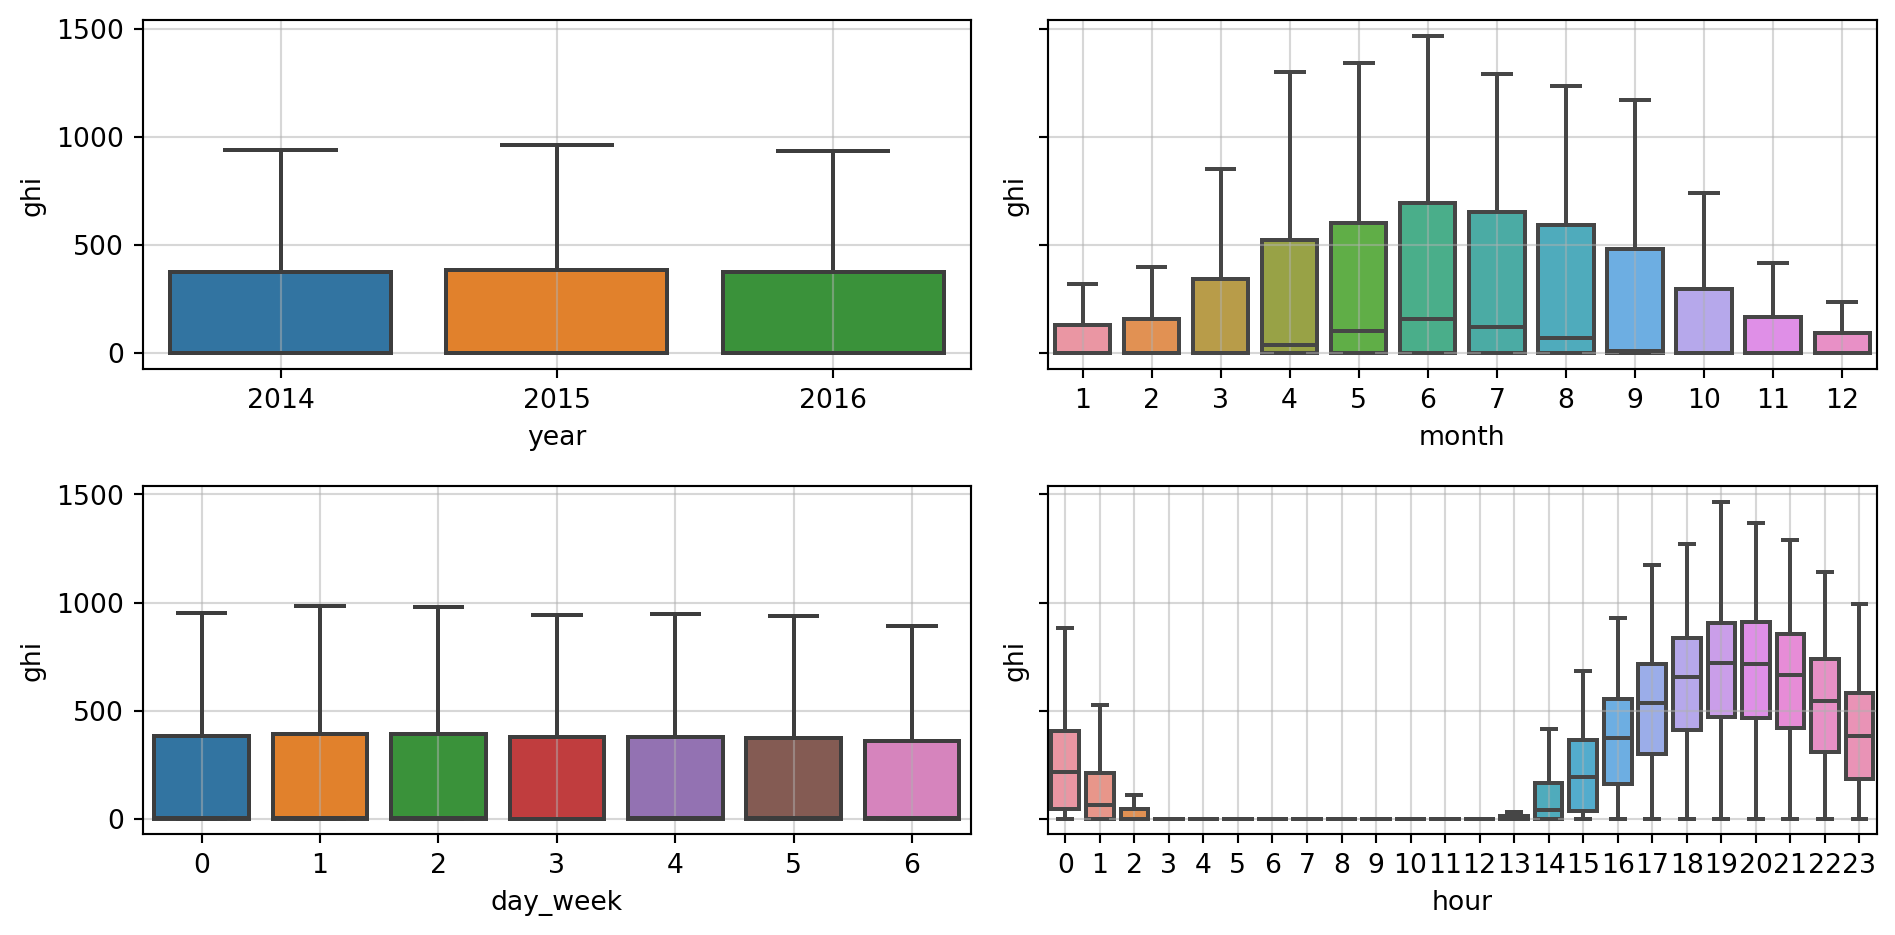

In [10]:
groupers = [
    "year",
    "month",
    "day_week",
    "hour"
]
fig, axs = plt.subplots(2, 2, figsize=(10, 5), sharey=True)

for ax, grouper in zip(axs.flatten(), groupers):

    sns.boxplot(
        data=ghi_df,
        x=grouper,
        y="ghi",
        showfliers=False,
        ax=ax
    )
    ax.grid(alpha=0.5)

plt.tight_layout()
plt.show()

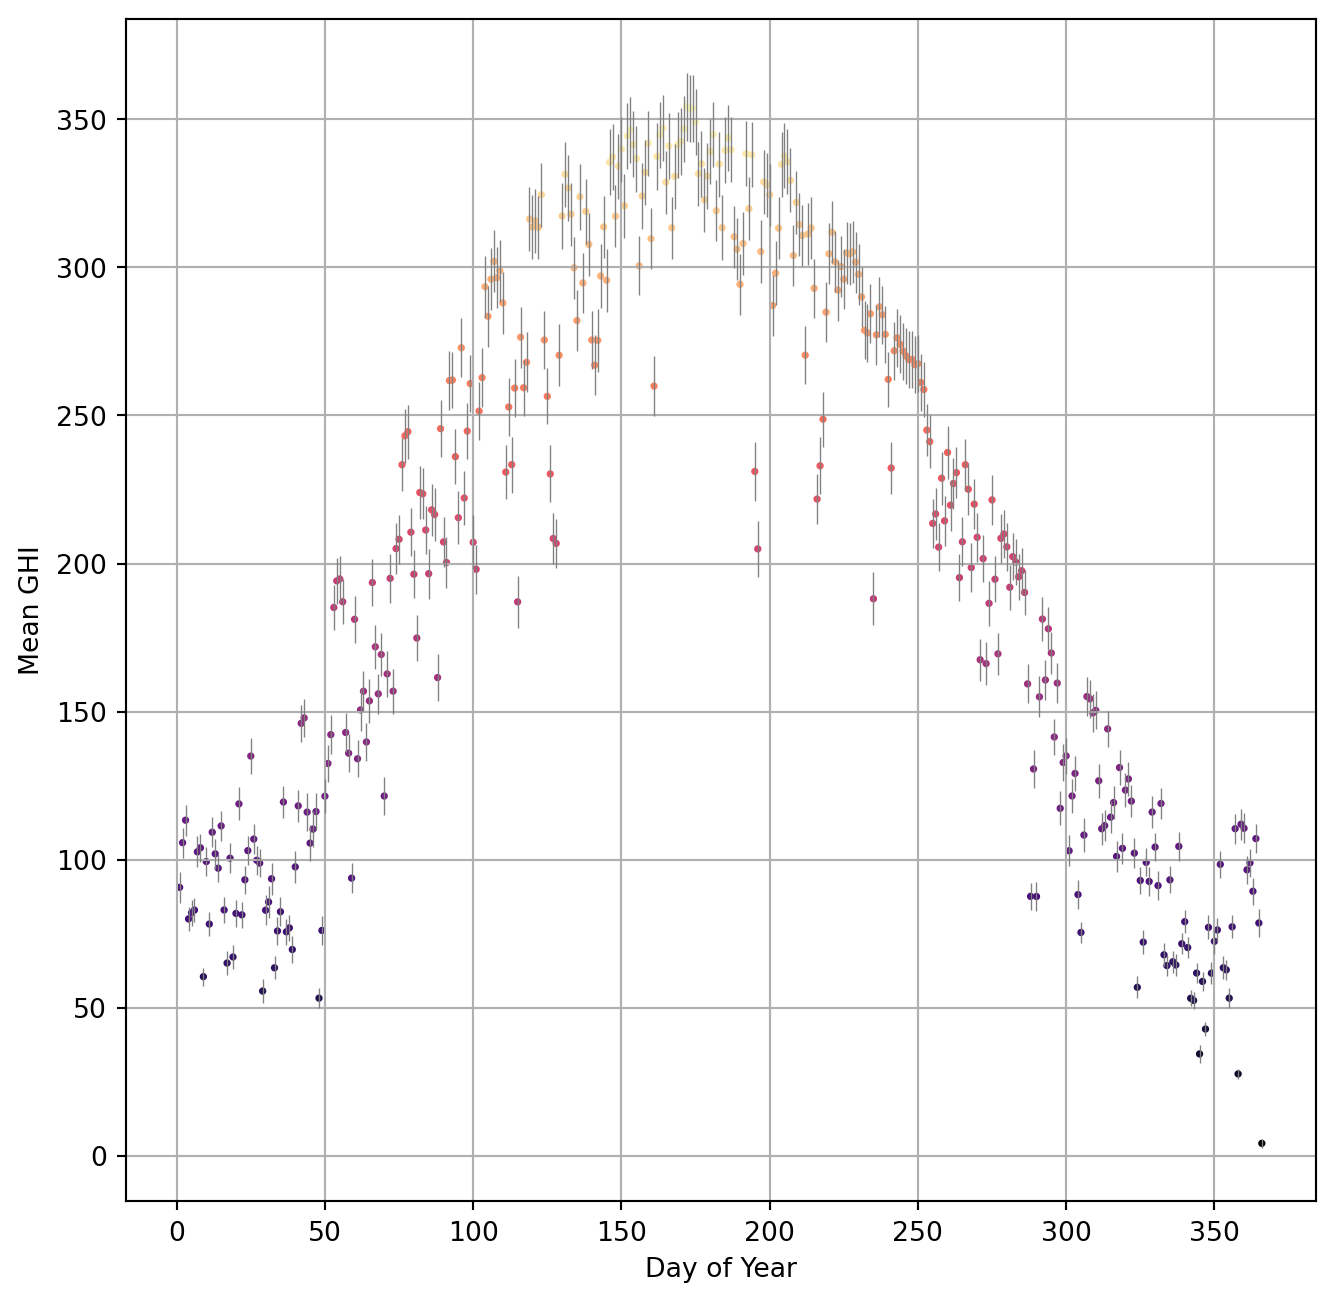

In [11]:
dayly_stats = (
    ghi_df
    .groupby("day_year")
    .agg(
        mean=("ghi", "mean"),
        std_err_mean=("ghi", lambda x: sem(x))
    )
    .reset_index()
    
)

plt.figure(figsize=(8, 8))
plt.scatter(
    x=dayly_stats["day_year"].values,
    y=dayly_stats["mean"].values,
    s=3,
    c=dayly_stats["mean"].values,
    cmap="magma"
)
plt.errorbar(
    x=dayly_stats["day_year"].values,
    y=dayly_stats["mean"].values,
    yerr=dayly_stats["std_err_mean"].values * 1.96,
    linewidth=0.5,
    ls='none',
    c="grey"

)
plt.ylabel("Mean GHI")
plt.xlabel("Day of Year")
plt.grid()

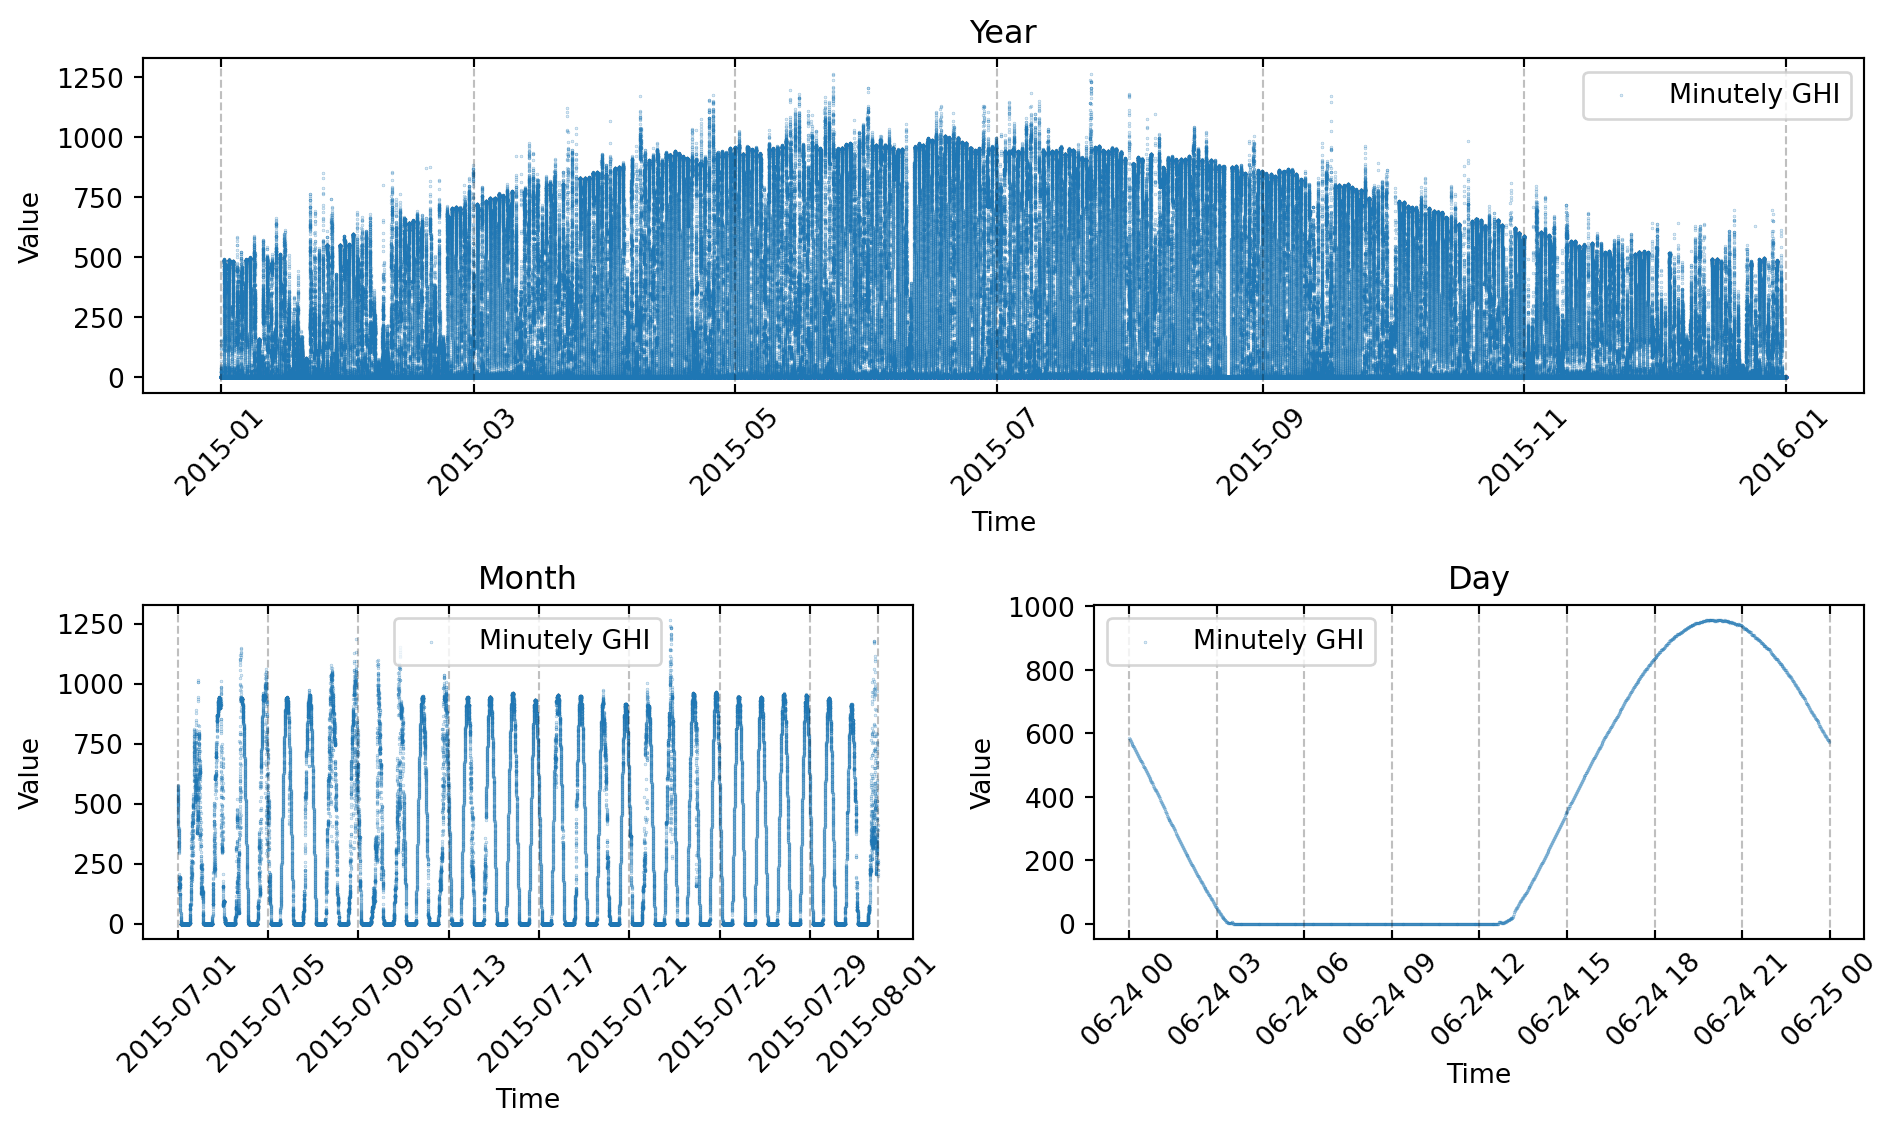

In [12]:
single_year_ghi_df = ghi_df[ghi_df["year"] == 2015]
single_month_ghi_df = ghi_df[(ghi_df["year"] == 2015) & (ghi_df["month"] == 7)]
single_day_ghi_df = ghi_df[(ghi_df["year"] == 2015) & (ghi_df["day_year"] == 175)]

fig = plt.figure(figsize=(10, 6), tight_layout=True)
gs = gridspec.GridSpec(2, 2)

ax_year = fig.add_subplot(gs[0, :])
ax_month = fig.add_subplot(gs[1, 0])
ax_day = fig.add_subplot(gs[1, 1])


axes_dfs = {
   "Year": (ax_year, single_year_ghi_df),
   "Month": (ax_month, single_month_ghi_df),
   "Day": (ax_day, single_day_ghi_df)

}

for title, (ax, df) in axes_dfs.items():

    ax = visualize_time_series(
        ax=ax,
        time_series_name="Minutely GHI",
        time_series=df.set_index("time")["ghi"],
        s=0.05,
        alpha=0.5
    )
    ax.set_title(title)
    ax.legend()

## Satellite Data


In [13]:
satellite_df.head(5)

time     1     2     3     4     5     6     7     8     9  \
0 2014-03-13 18:00:00  77.0  76.0  77.0  77.0  84.0  82.0  79.0  76.0  74.0   
1 2014-03-13 18:15:00  77.0  76.0  77.0  77.0  84.0  82.0  79.0  76.0  74.0   
2 2014-03-13 18:30:00  79.0  77.0  76.0  75.0  89.0  79.0  76.0  74.0  67.0   
3 2014-03-13 18:45:00  79.0  77.0  76.0  75.0  89.0  79.0  76.0  74.0  67.0   
4 2014-03-13 19:00:00  81.0  80.0  79.0  78.0  86.0  81.0  83.0  80.0  68.0   

   ...    91    92    93    94    95    96    97    98    99   100  
0  ...  77.0  76.0  75.0  74.0  76.0  76.0  76.0  77.0  77.0  78.0  
1  ...  77.0  76.0  75.0  74.0  76.0  76.0  76.0  77.0  77.0  78.0  
2  ...  81.0  82.0  80.0  76.0  79.0  78.0  77.0  76.0  77.0  78.0  
3  ...  81.0  82.0  80.0  76.0  79.0  78.0  77.0  76.0  77.0  78.0  
4  ...  78.0  79.0  78.0  76.0  79.0  79.0  79.0  79.0  80.0  81.0  

[5 rows x 101 columns]

In [14]:
satellite_df.describe()

time             1             2  \
count                          98327  98327.000000  98327.000000   
mean   2015-08-07 20:45:00.000000512    104.673986    104.354572   
min              2014-03-13 18:00:00      0.000000      0.000000   
25%              2014-11-24 19:22:30     82.000000     81.000000   
50%              2015-08-07 20:45:00     95.000000     94.000000   
75%              2016-04-19 22:07:30    117.000000    117.000000   
max              2016-12-31 23:30:00    255.000000    255.000000   
std                              NaN     31.515204     31.803811   

                  3             4             5             6             7  \
count  98327.000000  98327.000000  98327.000000  98327.000000  98327.000000   
mean     104.089691    103.965279    104.878446    104.323492    103.427512   
min        0.000000      0.000000      0.000000      0.000000      0.000000   
25%       81.000000     80.000000     82.000000     82.000000     81.000000   
50%       94.000000     93.000000     95.000000     95.000000     95.000000   
75%      117.000000    116.000000    116.000000    116.000000    115.000000   
max      255.000000    255.000000    255.000000    255.000000    255.000000   
std       31.878095     32.076861     31.736400     32.138111     32.745757   

                  8             9  ...            91            92  \
count  98327.000000  98327.000000  ...  98327.000000  98327.000000   
mean     103.123059    102.464542  ...    104.924680    105.412308   
min        0.000000      0.000000  ...      0.000000      0.000000   
25%       80.000000     79.000000  ...     82.000000     83.000000   
50%       95.000000     93.000000  ...     95.000000     95.000000   
75%      115.000000    115.000000  ...    117.000000    117.000000   
max      255.000000    255.000000  ...    255.000000    255.000000   
std       32.914638     33.090754  ...     31.432413     31.217330   

                 93            94            95            96            97  \
count  98327.000000  98327.000000  98327.000000  98327.000000  98327.000000   
mean     105.496273    105.406287    106.677362    107.025151    107.638289   
min        0.000000      0.000000      0.000000      0.000000      0.000000   
25%       83.000000     83.000000     85.000000     85.000000     86.000000   
50%       96.000000     96.000000     97.000000     97.000000     98.000000   
75%      117.000000    117.000000    117.000000    117.000000    118.000000   
max      255.000000    255.000000    255.000000    255.000000    255.000000   
std       31.298630     31.428878     30.567715     30.247307     29.893872   

                 98            99           100  
count  98327.000000  98327.000000  98327.000000  
mean     108.432760    109.142657    109.312457  
min        0.000000      0.000000      0.000000  
25%       88.000000     89.000000     89.000000  
50%       99.000000    100.000000    101.000000  
75%      118.000000    119.000000    119.000000  
max      255.000000    255.000000    255.000000  
std       29.529785     29.328337     29.243425  

[8 rows x 101 columns]

In [15]:
satellite_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 98327 entries, 0 to 98326
Columns: 101 entries, time to 100
dtypes: datetime64[ns](1), float64(100)
memory usage: 75.8 MB


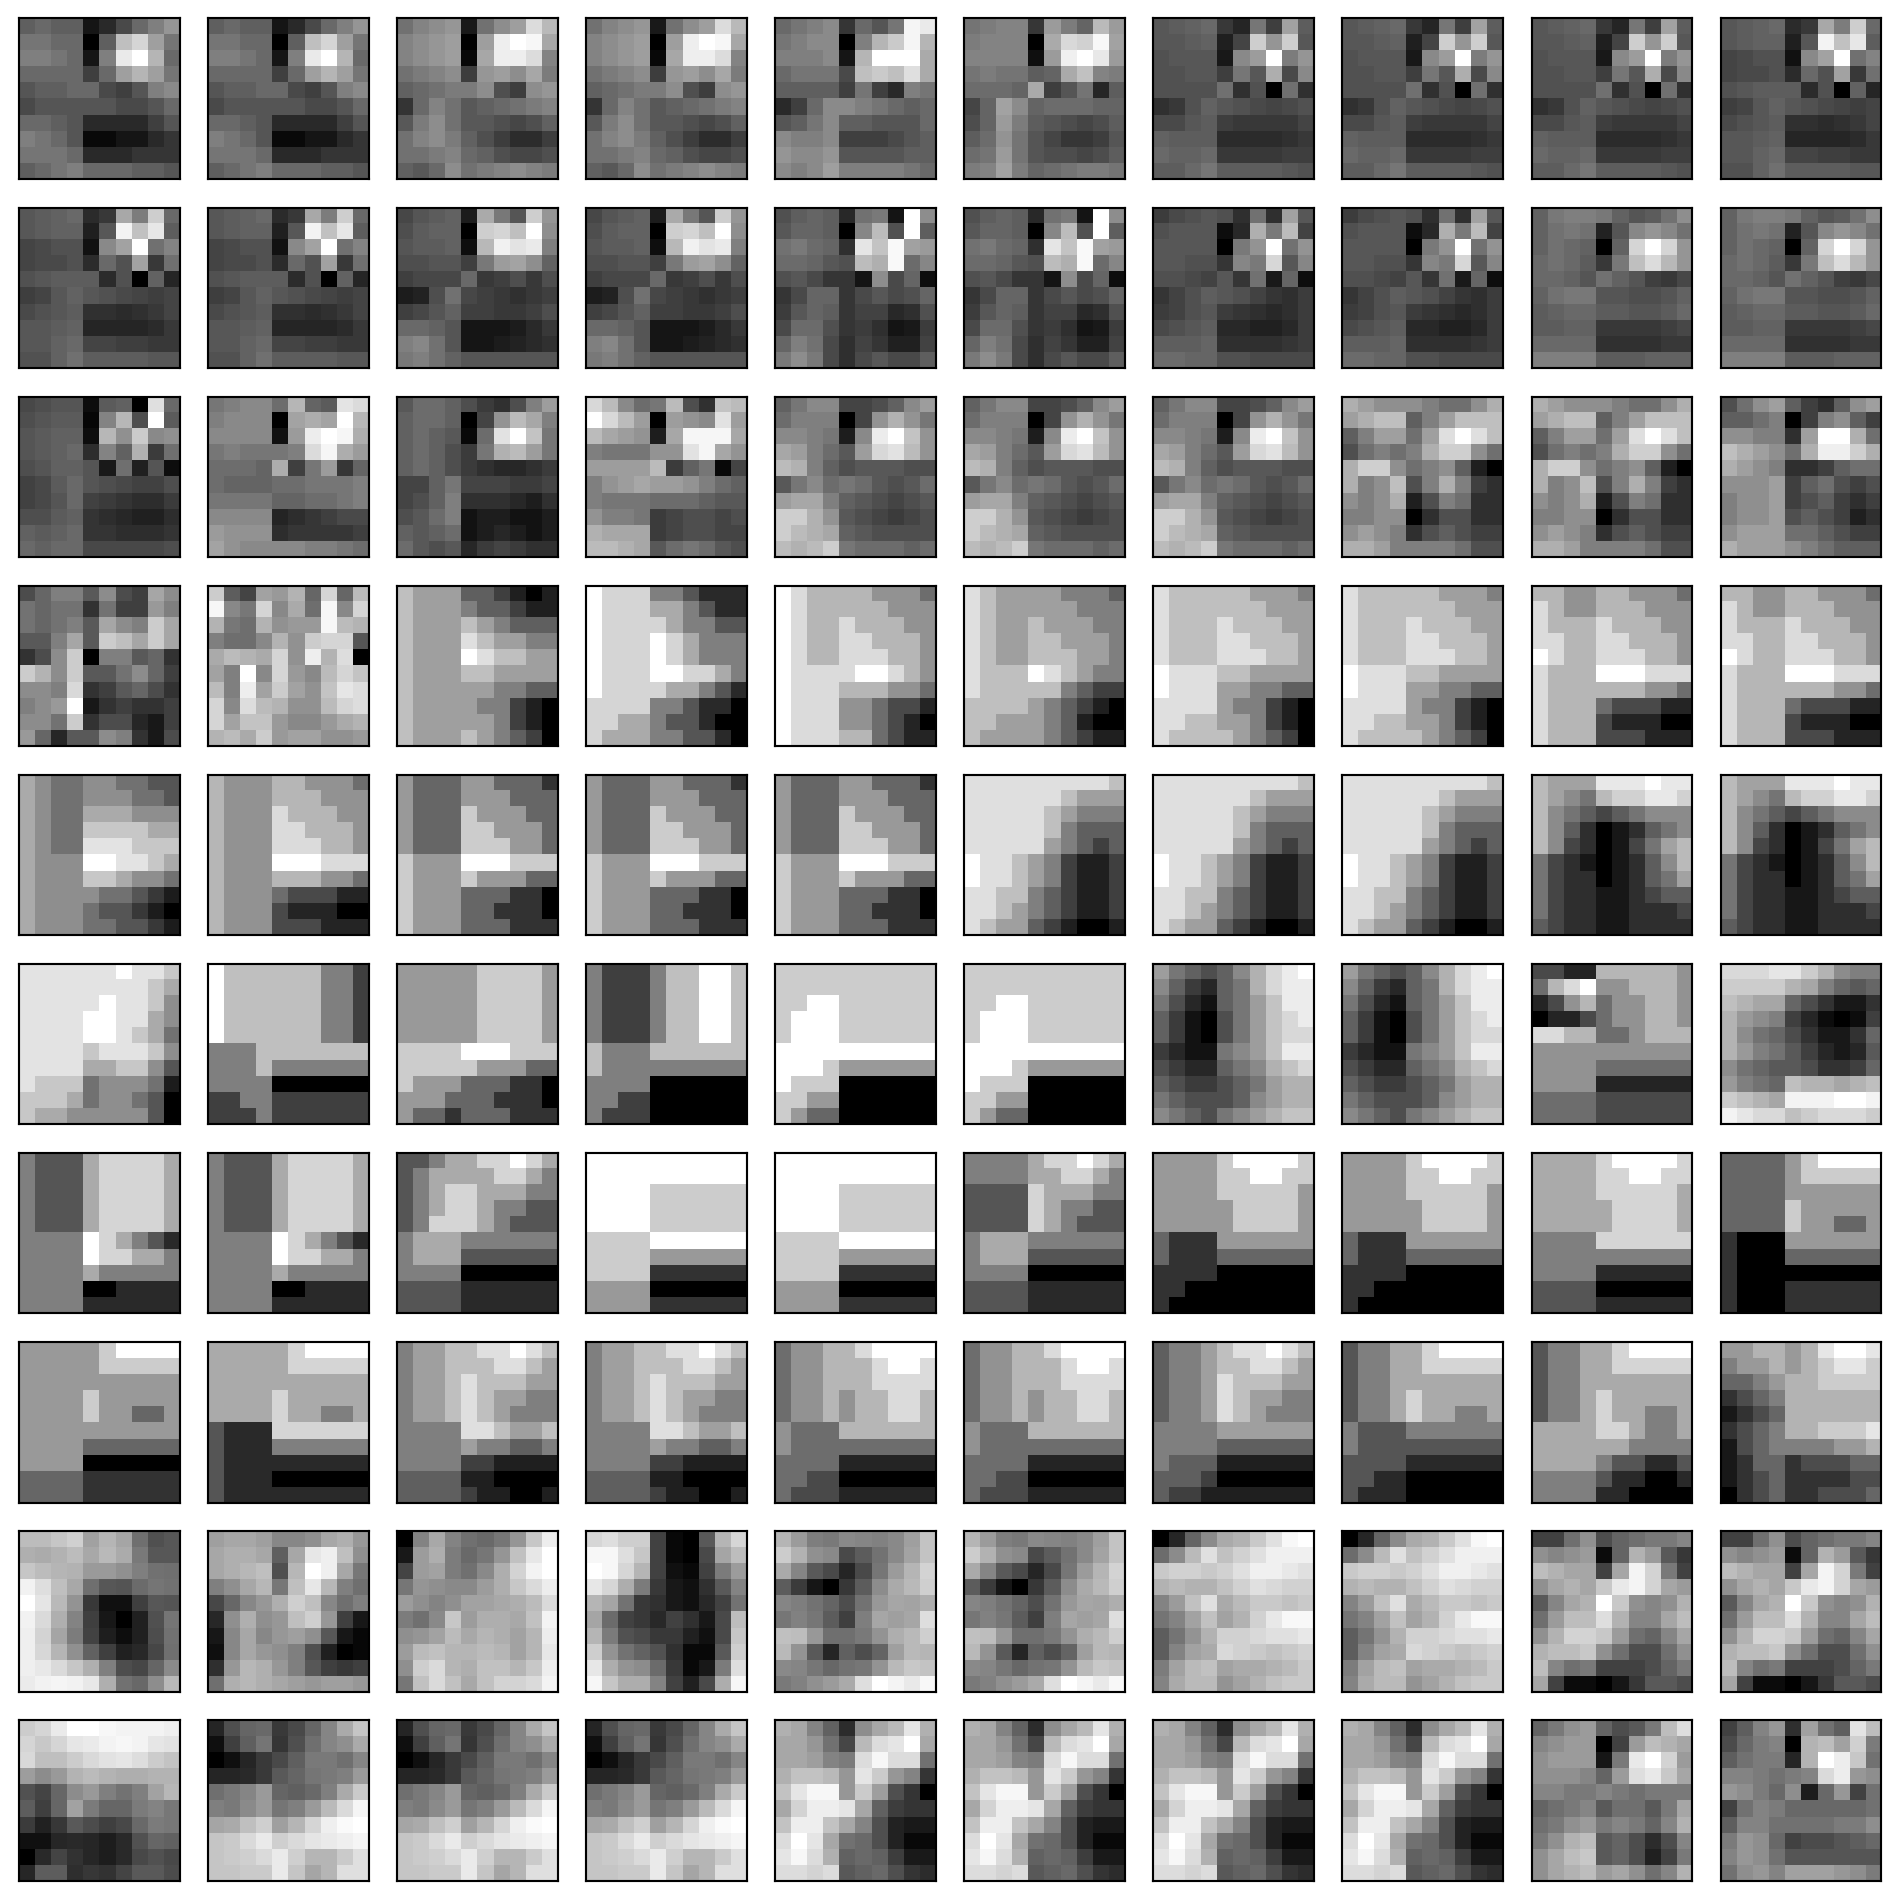

In [16]:
#| code-fold: true
#| code-summary: "Show supplementary code"
fig, axs = plt.subplots(10, 10, figsize=(10, 10), sharex=True, sharey=True)

for row, ax in enumerate(axs.flatten()):

    satellite_img = satellite_df.loc[row, :][np.arange(1, 101)].values.astype("float")
    satellite_img = satellite_img.reshape(10, 10)

    ax.imshow(satellite_img, cmap="binary")

    ax.set_yticks([])
    ax.set_xticks([])

plt.tight_layout()
plt.show()

# Modelling

In this section we will illustrate some modelling approaches for tackling the problem of minutely forecasting with a 30 minutes time horizons. We will start from some very simple baselines and build complexity using the information provided by the fit of the various models.

First of all we need to specify the different type of evaluation framework we could use for fitting and testing the perfromance of our model, each of them has its strengths and weaknesses and rely on different type of assumptions.

### Expanding window scheme
<img src="images/presentation/expanding_forecast.png" alt="drawing" width="700"/>

### Fixed window scheme
<img src="images/presentation/windowed_forecast.png" alt="drawing" width="700"/>

### Full history scheme
<img src="images/presentation/full_forecast.png" alt="drawing" width="700"/>

## Modelling Data Preparation

Here we perfrom a series of data preparations steps necessary for our modelling attempts


In [17]:
# we shift satellite time by 30 minuts so we are always sure to have covariate data in the future (assuming 30 minutes time to get them)
satellite_df["time"] = satellite_df["time"] + pd.Timedelta("30minutes")

# We divide in-sample and out sample data
insample_ghi_df, outsample_ghi_df = split_time_series_df(
    df=ghi_df,
    start_date=TRAINING_END_DATE,
    time_column="time"
)
insample_satellite_df, outsample_satellite_df = split_time_series_df(
    df=satellite_df,
    start_date=TRAINING_END_DATE,
    time_column="time"
)

insample_ghi_df = (
    insample_ghi_df
    .set_index("time")
    [["ghi", "year", "month", "day_year", "hour", "minute"]]
)
outsample_ghi_df = (
    outsample_ghi_df
    .set_index("time")
    [["ghi", "year", "month", "day_year", "hour", "minute"]]
)

# Join the covariates of interest
insample_satellite_df = (
    insample_satellite_df
    .set_index("time")
)
outsample_satellite_df = (
    outsample_satellite_df
    .set_index("time")
)

insample_ghi_df = pd.merge(
    insample_ghi_df,
    insample_satellite_df,
    how="left",
    on="time"
).interpolate("linear", limit_direction="both")

outsample_ghi_df = pd.merge(
    outsample_ghi_df,
    outsample_satellite_df,
    how="left",
    on="time"
).interpolate("linear", limit_direction="both")

## Modelling Constants


In [18]:
OUTSAMPLE_WINDOW_SIZE = 30
NUMBER_OF_SPLITS = int(len(outsample_ghi_df) / OUTSAMPLE_WINDOW_SIZE)
TIME_SERIES_SPLITTER = TimeSeriesSplit(n_splits=NUMBER_OF_SPLITS, test_size=30)

FULL_SERIES = ghi_df["ghi"].values

EARLY_STOP_LIMIT = 9000

MODELS_RESULTS = {}

## Baseline 

Here we define some increasingly more elaborated baselines

### 0 - Constant Model

$$\hat{y}_{T+1} = \frac{1}{T} \sum_{t0}^T y_t$$


In [19]:
from modules.models.baselines import static_stat_forecast

ground_truth = []
forecasts = []
early_stop_counter = 0

for insample_indices, outsample_indices in tqdm(TIME_SERIES_SPLITTER.split(FULL_SERIES)):

    insample_series, outsample_series = FULL_SERIES[insample_indices], FULL_SERIES[outsample_indices]
    insample_forecast, outsample_forecast = static_stat_forecast(
        time_series=insample_series,
        steps_ahead=OUTSAMPLE_WINDOW_SIZE,
        stat_func=np.mean
    )

    forecasts.append(outsample_forecast)
    ground_truth.append(outsample_series)
    early_stop_counter += 1

    if early_stop_counter > EARLY_STOP_LIMIT:
        break

0it [00:00, ?it/s]

19it [00:00, 181.19it/s]

38it [00:00, 175.27it/s]

56it [00:00, 169.72it/s]

73it [00:00, 165.19it/s]

90it [00:00, 147.74it/s]

107it [00:00, 151.66it/s]

125it [00:00, 158.53it/s]

143it [00:00, 163.28it/s]

160it [00:00, 164.31it/s]

177it [00:01, 145.56it/s]

194it [00:01, 150.49it/s]

212it [00:01, 156.88it/s]

229it [00:01, 159.62it/s]

246it [00:01, 156.16it/s]

262it [00:01, 150.93it/s]

285it [00:01, 171.15it/s]

308it [00:01, 186.34it/s]

328it [00:01, 188.16it/s]

347it [00:02, 187.32it/s]

366it [00:02, 186.44it/s]

385it [00:02, 185.63it/s]

404it [00:02, 182.08it/s]

423it [00:02, 179.45it/s]

441it [00:02, 177.76it/s]

459it [00:02, 176.23it/s]

478it [00:02, 177.77it/s]

497it [00:02, 179.42it/s]

517it [00:03, 183.62it/s]

536it [00:03, 183.54it/s]

555it [00:03, 178.85it/s]

573it [00:03, 144.35it/s]

589it [00:03, 110.22it/s]

602it [00:03, 103.33it/s]

614it [00:03, 101.30it/s]

625it [00:04, 100.50it/s]

636it [00:04, 102.43it/s]

647it [00:04, 103.78it/s]

659it [00:04, 107.68it/s]

672it [00:04, 112.58it/s]

685it [00:04, 116.70it/s]

698it [00:04, 119.45it/s]

711it [00:04, 122.46it/s]

725it [00:04, 125.15it/s]

738it [00:04, 125.59it/s]

751it [00:05, 122.92it/s]

764it [00:05, 120.58it/s]

777it [00:05, 116.29it/s]

789it [00:05, 115.34it/s]

801it [00:05, 114.52it/s]

813it [00:05, 114.57it/s]

825it [00:05, 115.24it/s]

837it [00:05, 113.39it/s]

849it [00:05, 112.75it/s]

861it [00:06, 111.26it/s]

873it [00:06, 109.64it/s]

885it [00:06, 110.96it/s]

897it [00:06, 111.42it/s]

909it [00:06, 111.86it/s]

921it [00:06, 112.93it/s]

933it [00:06, 113.46it/s]

945it [00:06, 113.57it/s]

957it [00:06, 114.72it/s]

969it [00:07, 115.49it/s]

982it [00:07, 117.05it/s]

995it [00:07, 119.45it/s]

1008it [00:07, 122.14it/s]

1022it [00:07, 127.06it/s]

1046it [00:07, 159.69it/s]

1070it [00:07, 181.97it/s]

1092it [00:07, 191.65it/s]

1114it [00:07, 198.02it/s]

1134it [00:07, 197.95it/s]

1154it [00:08, 198.06it/s]

1175it [00:08, 199.37it/s]

1196it [00:08, 201.28it/s]

1217it [00:08, 202.65it/s]

1238it [00:08, 204.07it/s]

1259it [00:08, 204.15it/s]

1280it [00:08, 204.07it/s]

1301it [00:08, 203.48it/s]

1322it [00:08, 202.36it/s]

1343it [00:08, 202.11it/s]

1364it [00:09, 201.44it/s]

1385it [00:09, 200.72it/s]

1406it [00:09, 200.80it/s]

1427it [00:09, 201.16it/s]

1448it [00:09, 198.99it/s]

1469it [00:09, 199.84it/s]

1490it [00:09, 200.10it/s]

1511it [00:09, 200.10it/s]

1532it [00:09, 199.25it/s]

1552it [00:10, 197.62it/s]

1572it [00:10, 169.74it/s]

1593it [00:10, 179.23it/s]

1612it [00:10, 180.67it/s]

1631it [00:10, 183.06it/s]

1650it [00:10, 182.80it/s]

1669it [00:10, 168.51it/s]

1689it [00:10, 176.75it/s]

1711it [00:10, 187.00it/s]

1732it [00:11, 190.73it/s]

1752it [00:11, 180.15it/s]

1771it [00:11, 162.19it/s]

1788it [00:11, 158.07it/s]

1805it [00:11, 156.81it/s]

1821it [00:11, 155.44it/s]

1837it [00:11, 154.15it/s]

1853it [00:11, 154.53it/s]

1869it [00:11, 150.25it/s]

1885it [00:12, 105.65it/s]

1904it [00:12, 123.19it/s]

1922it [00:12, 134.96it/s]

1939it [00:12, 143.01it/s]

1956it [00:12, 148.70it/s]

1973it [00:12, 153.18it/s]

1990it [00:12, 156.89it/s]

2007it [00:12, 158.68it/s]

2024it [00:13, 160.54it/s]

2041it [00:13, 156.42it/s]

2057it [00:13, 141.25it/s]

2072it [00:13, 141.76it/s]

2092it [00:13, 156.84it/s]

2113it [00:13, 169.37it/s]

2131it [00:13, 139.56it/s]

2146it [00:13, 130.91it/s]

2168it [00:14, 150.97it/s]

2189it [00:14, 164.74it/s]

2208it [00:14, 171.16it/s]

2227it [00:14, 174.11it/s]

2245it [00:14, 169.11it/s]

2263it [00:14, 150.80it/s]

2280it [00:14, 153.52it/s]

2298it [00:14, 158.07it/s]

2315it [00:14, 158.67it/s]

2332it [00:15, 156.43it/s]

2348it [00:15, 154.51it/s]

2364it [00:15, 153.11it/s]

2380it [00:15, 154.88it/s]

2397it [00:15, 157.11it/s]

2414it [00:15, 157.91it/s]

2431it [00:15, 158.98it/s]

2447it [00:15, 159.22it/s]

2464it [00:15, 159.72it/s]

2481it [00:15, 160.60it/s]

2498it [00:16, 162.13it/s]

2515it [00:16, 161.74it/s]

2532it [00:16, 159.63it/s]

2548it [00:16, 156.23it/s]

2564it [00:16, 154.38it/s]

2580it [00:16, 152.77it/s]

2596it [00:16, 151.94it/s]

2612it [00:16, 152.64it/s]

2628it [00:16, 154.34it/s]

2644it [00:17, 155.65it/s]

2660it [00:17, 156.24it/s]

2676it [00:17, 157.10it/s]

2693it [00:17, 158.32it/s]

2710it [00:17, 160.28it/s]

2727it [00:17, 160.82it/s]

2744it [00:17, 161.90it/s]

2761it [00:17, 162.03it/s]

2778it [00:17, 161.62it/s]

2795it [00:17, 163.35it/s]

2812it [00:18, 162.50it/s]

2829it [00:18, 162.61it/s]

2846it [00:18, 163.59it/s]

2863it [00:18, 163.77it/s]

2880it [00:18, 163.77it/s]

2897it [00:18, 163.65it/s]

2914it [00:18, 163.29it/s]

2931it [00:18, 163.94it/s]

2948it [00:18, 163.08it/s]

2965it [00:19, 162.90it/s]

2982it [00:19, 162.59it/s]

2999it [00:19, 162.72it/s]

3016it [00:19, 162.64it/s]

3033it [00:19, 159.47it/s]

3049it [00:19, 156.97it/s]

3065it [00:19, 152.44it/s]

3081it [00:19, 152.58it/s]

3097it [00:19, 154.11it/s]

3113it [00:19, 154.52it/s]

3129it [00:20, 155.38it/s]

3145it [00:20, 156.65it/s]

3161it [00:20, 155.86it/s]

3177it [00:20, 154.93it/s]

3193it [00:20, 155.70it/s]

3209it [00:20, 156.75it/s]

3225it [00:20, 155.07it/s]

3241it [00:20, 156.17it/s]

3257it [00:20, 157.14it/s]

3273it [00:20, 157.46it/s]

3289it [00:21, 158.12it/s]

3305it [00:21, 158.03it/s]

3322it [00:21, 159.21it/s]

3339it [00:21, 159.82it/s]

3356it [00:21, 159.91it/s]

3372it [00:21, 157.37it/s]

3388it [00:21, 156.30it/s]

3404it [00:21, 155.05it/s]

3420it [00:21, 155.38it/s]

3436it [00:22, 127.90it/s]

3450it [00:22, 115.13it/s]

3463it [00:22, 112.82it/s]

3475it [00:22, 112.55it/s]

3487it [00:22, 112.61it/s]

3499it [00:22, 113.35it/s]

3511it [00:22, 114.15it/s]

3523it [00:22, 114.18it/s]

3535it [00:23, 114.12it/s]

3547it [00:23, 111.29it/s]

3559it [00:23, 108.69it/s]

3570it [00:23, 106.30it/s]

3581it [00:23, 104.15it/s]

3592it [00:23, 104.99it/s]

3604it [00:23, 107.41it/s]

3616it [00:23, 110.06it/s]

3628it [00:23, 111.02it/s]

3640it [00:23, 112.80it/s]

3653it [00:24, 115.62it/s]

3666it [00:24, 118.68it/s]

3679it [00:24, 118.96it/s]

3691it [00:24, 116.97it/s]

3703it [00:24, 112.11it/s]

3715it [00:24, 107.92it/s]

3726it [00:24, 106.19it/s]

3737it [00:24, 104.50it/s]

3748it [00:24, 105.07it/s]

3760it [00:25, 107.77it/s]

3772it [00:25, 110.51it/s]

3792it [00:25, 135.11it/s]

3811it [00:25, 149.71it/s]

3829it [00:25, 157.08it/s]

3846it [00:25, 160.51it/s]

3863it [00:25, 162.50it/s]

3880it [00:25, 164.38it/s]

3897it [00:25, 164.64it/s]

3914it [00:25, 164.70it/s]

3931it [00:26, 164.43it/s]

3948it [00:26, 163.72it/s]

3965it [00:26, 163.59it/s]

3982it [00:26, 159.56it/s]

3998it [00:26, 159.55it/s]

4014it [00:26, 158.25it/s]

4030it [00:26, 157.55it/s]

4046it [00:26, 158.26it/s]

4063it [00:26, 159.09it/s]

4080it [00:27, 160.33it/s]

4097it [00:27, 158.40it/s]

4114it [00:27, 159.37it/s]

4131it [00:27, 159.91it/s]

4147it [00:27, 159.30it/s]

4163it [00:27, 157.95it/s]

4179it [00:27, 157.46it/s]

4195it [00:27, 157.82it/s]

4211it [00:27, 157.18it/s]

4227it [00:27, 155.38it/s]

4243it [00:28, 155.45it/s]

4260it [00:28, 157.43it/s]

4276it [00:28, 157.82it/s]

4292it [00:28, 158.30it/s]

4308it [00:28, 158.51it/s]

4324it [00:28, 156.78it/s]

4340it [00:28, 156.84it/s]

4356it [00:28, 157.71it/s]

4372it [00:28, 155.79it/s]

4388it [00:28, 156.57it/s]

4404it [00:29, 157.45it/s]

4420it [00:29, 158.15it/s]

4437it [00:29, 159.04it/s]

4453it [00:29, 159.00it/s]

4469it [00:29, 158.80it/s]

4485it [00:29, 157.45it/s]

4502it [00:29, 158.81it/s]

4519it [00:29, 161.28it/s]

4536it [00:29, 161.35it/s]

4553it [00:30, 153.08it/s]

4570it [00:30, 155.52it/s]

4587it [00:30, 157.79it/s]

4604it [00:30, 159.00it/s]

4621it [00:30, 160.36it/s]

4638it [00:30, 161.40it/s]

4655it [00:30, 162.05it/s]

4672it [00:30, 162.63it/s]

4689it [00:30, 161.34it/s]

4706it [00:30, 157.76it/s]

4722it [00:31, 155.37it/s]

4738it [00:31, 153.72it/s]

4754it [00:31, 152.98it/s]

4770it [00:31, 152.00it/s]

4786it [00:31, 150.62it/s]

4802it [00:31, 131.93it/s]

4816it [00:31, 119.54it/s]

4829it [00:31, 115.91it/s]

4841it [00:32, 112.98it/s]

4853it [00:32, 109.00it/s]

4865it [00:32, 110.38it/s]

4881it [00:32, 123.06it/s]

4899it [00:32, 137.71it/s]

4916it [00:32, 145.71it/s]

4933it [00:32, 150.08it/s]

4949it [00:32, 152.24it/s]

4966it [00:32, 154.67it/s]

4982it [00:33, 155.98it/s]

4998it [00:33, 155.80it/s]

5015it [00:33, 157.29it/s]

5032it [00:33, 158.53it/s]

5048it [00:33, 158.72it/s]

5065it [00:33, 159.32it/s]

5081it [00:33, 159.03it/s]

5103it [00:33, 175.16it/s]

5124it [00:33, 184.51it/s]

5143it [00:33, 184.57it/s]

5162it [00:34, 181.39it/s]

5181it [00:34, 179.95it/s]

5200it [00:34, 181.06it/s]

5219it [00:34, 182.20it/s]

5238it [00:34, 178.58it/s]

5256it [00:34, 177.55it/s]

5274it [00:34, 176.70it/s]

5292it [00:34, 175.95it/s]

5310it [00:34, 175.28it/s]

5328it [00:34, 175.19it/s]

5346it [00:35, 174.45it/s]

5365it [00:35, 176.69it/s]

5384it [00:35, 179.31it/s]

5403it [00:35, 181.31it/s]

5422it [00:35, 180.22it/s]

5441it [00:35, 178.91it/s]

5459it [00:35, 178.97it/s]

5477it [00:35, 172.88it/s]

5495it [00:35, 163.76it/s]

5512it [00:36, 159.69it/s]

5529it [00:36, 156.99it/s]

5545it [00:36, 155.12it/s]

5561it [00:36, 152.65it/s]

5577it [00:36, 151.26it/s]

5593it [00:36, 150.87it/s]

5609it [00:36, 149.21it/s]

5624it [00:36, 147.61it/s]

5639it [00:36, 125.44it/s]

5655it [00:37, 133.16it/s]

5671it [00:37, 139.39it/s]

5686it [00:37, 125.82it/s]

5702it [00:37, 134.19it/s]

5718it [00:37, 138.82it/s]

5733it [00:37, 139.78it/s]

5748it [00:37, 140.37it/s]

5763it [00:37, 140.71it/s]

5778it [00:37, 139.65it/s]

5793it [00:38, 137.47it/s]

5807it [00:38, 135.99it/s]

5822it [00:38, 139.51it/s]

5837it [00:38, 140.98it/s]

5853it [00:38, 144.27it/s]

5869it [00:38, 147.44it/s]

5885it [00:38, 148.75it/s]

5901it [00:38, 150.59it/s]

5917it [00:38, 151.79it/s]

5933it [00:39, 151.22it/s]

5949it [00:39, 151.72it/s]

5965it [00:39, 152.60it/s]

5981it [00:39, 153.21it/s]

5997it [00:39, 154.00it/s]

6013it [00:39, 154.46it/s]

6029it [00:39, 154.91it/s]

6045it [00:39, 155.11it/s]

6061it [00:39, 155.13it/s]

6077it [00:39, 154.99it/s]

6093it [00:40, 155.23it/s]

6109it [00:40, 155.55it/s]

6125it [00:40, 156.01it/s]

6141it [00:40, 157.04it/s]

6158it [00:40, 157.94it/s]

6174it [00:40, 157.12it/s]

6190it [00:40, 155.55it/s]

6206it [00:40, 155.75it/s]

6222it [00:40, 155.39it/s]

6238it [00:40, 153.90it/s]

6254it [00:41, 147.44it/s]

6269it [00:41, 147.40it/s]

6284it [00:41, 134.72it/s]

6300it [00:41, 141.39it/s]

6315it [00:41, 143.70it/s]

6331it [00:41, 146.69it/s]

6347it [00:41, 148.48it/s]

6362it [00:41, 148.91it/s]

6377it [00:41, 148.90it/s]

6393it [00:42, 149.22it/s]

6408it [00:42, 148.56it/s]

6423it [00:42, 148.09it/s]

6438it [00:42, 148.34it/s]

6453it [00:42, 148.13it/s]

6469it [00:42, 150.36it/s]

6485it [00:42, 149.85it/s]

6501it [00:42, 150.15it/s]

6517it [00:42, 151.95it/s]

6533it [00:42, 153.65it/s]

6549it [00:43, 154.67it/s]

6565it [00:43, 155.44it/s]

6581it [00:43, 155.36it/s]

6597it [00:43, 154.86it/s]

6613it [00:43, 153.34it/s]

6629it [00:43, 152.95it/s]

6645it [00:43, 128.35it/s]

6659it [00:43, 118.40it/s]

6677it [00:44, 133.18it/s]

6694it [00:44, 142.54it/s]

6711it [00:44, 148.62it/s]

6727it [00:44, 151.61it/s]

6743it [00:44, 152.43it/s]

6759it [00:44, 153.67it/s]

6775it [00:44, 153.06it/s]

6791it [00:44, 152.94it/s]

6807it [00:44, 153.39it/s]

6823it [00:44, 153.83it/s]

6839it [00:45, 153.62it/s]

6855it [00:45, 154.07it/s]

6871it [00:45, 154.71it/s]

6887it [00:45, 154.97it/s]

6903it [00:45, 155.44it/s]

6919it [00:45, 154.72it/s]

6935it [00:45, 154.36it/s]

6951it [00:45, 153.29it/s]

6967it [00:45, 152.84it/s]

6983it [00:45, 153.67it/s]

6999it [00:46, 152.48it/s]

7015it [00:46, 153.16it/s]

7031it [00:46, 149.02it/s]

7047it [00:46, 149.75it/s]

7063it [00:46, 151.56it/s]

7079it [00:46, 151.36it/s]

7095it [00:46, 152.31it/s]

7111it [00:46, 150.81it/s]

7127it [00:46, 151.53it/s]

7143it [00:47, 151.66it/s]

7159it [00:47, 151.30it/s]

7175it [00:47, 151.09it/s]

7191it [00:47, 151.78it/s]

7207it [00:47, 152.82it/s]

7223it [00:47, 152.25it/s]

7239it [00:47, 153.20it/s]

7255it [00:47, 153.74it/s]

7271it [00:47, 153.55it/s]

7287it [00:47, 152.68it/s]

7303it [00:48, 152.49it/s]

7319it [00:48, 153.17it/s]

7335it [00:48, 153.87it/s]

7351it [00:48, 154.33it/s]

7367it [00:48, 152.85it/s]

7383it [00:48, 152.62it/s]

7399it [00:48, 152.28it/s]

7415it [00:48, 152.14it/s]

7431it [00:48, 152.30it/s]

7447it [00:49, 152.68it/s]

7463it [00:49, 152.87it/s]

7479it [00:49, 153.34it/s]

7495it [00:49, 153.49it/s]

7511it [00:49, 153.02it/s]

7527it [00:49, 152.97it/s]

7543it [00:49, 151.64it/s]

7559it [00:49, 151.47it/s]

7575it [00:49, 152.01it/s]

7591it [00:49, 152.43it/s]

7607it [00:50, 151.81it/s]

7623it [00:50, 151.24it/s]

7639it [00:50, 151.69it/s]

7655it [00:50, 152.25it/s]

7671it [00:50, 152.96it/s]

7687it [00:50, 152.29it/s]

7703it [00:50, 152.82it/s]

7719it [00:50, 152.49it/s]

7735it [00:50, 152.64it/s]

7751it [00:51, 152.75it/s]

7767it [00:51, 153.50it/s]

7783it [00:51, 153.65it/s]

7799it [00:51, 154.09it/s]

7815it [00:51, 154.53it/s]

7831it [00:51, 154.48it/s]

7847it [00:51, 154.49it/s]

7863it [00:51, 154.60it/s]

7879it [00:51, 154.13it/s]

7895it [00:51, 153.59it/s]

7911it [00:52, 153.30it/s]

7927it [00:52, 152.22it/s]

7943it [00:52, 151.34it/s]

7959it [00:52, 150.70it/s]

7975it [00:52, 150.61it/s]

7991it [00:52, 150.05it/s]

8007it [00:52, 149.98it/s]

8022it [00:52, 149.58it/s]

8037it [00:52, 148.68it/s]

8052it [00:53, 147.78it/s]

8067it [00:53, 147.88it/s]

8082it [00:53, 148.06it/s]

8098it [00:53, 149.53it/s]

8114it [00:53, 150.05it/s]

8130it [00:53, 150.43it/s]

8146it [00:53, 149.55it/s]

8161it [00:53, 149.03it/s]

8176it [00:53, 147.41it/s]

8191it [00:53, 147.61it/s]

8206it [00:54, 148.03it/s]

8227it [00:54, 165.72it/s]

8244it [00:54, 164.68it/s]

8261it [00:54, 156.61it/s]

8277it [00:54, 152.53it/s]

8293it [00:54, 146.88it/s]

8308it [00:54, 145.50it/s]

8323it [00:54, 145.88it/s]

8338it [00:54, 146.85it/s]

8353it [00:55, 147.69it/s]

8368it [00:55, 147.53it/s]

8383it [00:55, 147.64it/s]

8398it [00:55, 147.80it/s]

8414it [00:55, 148.88it/s]

8430it [00:55, 150.34it/s]

8446it [00:55, 143.34it/s]

8461it [00:55, 143.60it/s]

8480it [00:55, 155.43it/s]

8499it [00:55, 164.15it/s]

8517it [00:56, 166.46it/s]

8534it [00:56, 165.43it/s]

8551it [00:56, 164.27it/s]

8568it [00:56, 161.90it/s]

8585it [00:56, 162.15it/s]

8602it [00:56, 157.62it/s]

8618it [00:56, 143.57it/s]

8634it [00:56, 146.35it/s]

8652it [00:56, 154.65it/s]

8668it [00:57, 147.98it/s]

8683it [00:57, 134.51it/s]

8697it [00:57, 128.52it/s]

8714it [00:57, 138.48it/s]

8731it [00:57, 146.71it/s]

8746it [00:57, 134.95it/s]

8760it [00:57, 127.74it/s]

8777it [00:57, 138.45it/s]

8796it [00:57, 151.55it/s]

8814it [00:58, 158.57it/s]

8832it [00:58, 162.41it/s]

8849it [00:58, 159.92it/s]

8866it [00:58, 158.81it/s]

8882it [00:58, 151.93it/s]

8898it [00:58, 102.60it/s]

8916it [00:58, 118.63it/s]

8931it [00:59, 91.57it/s] 

8943it [00:59, 86.42it/s]

8954it [00:59, 87.68it/s]

8965it [00:59, 90.51it/s]

8984it [00:59, 112.27it/s]

9000it [00:59, 150.58it/s]

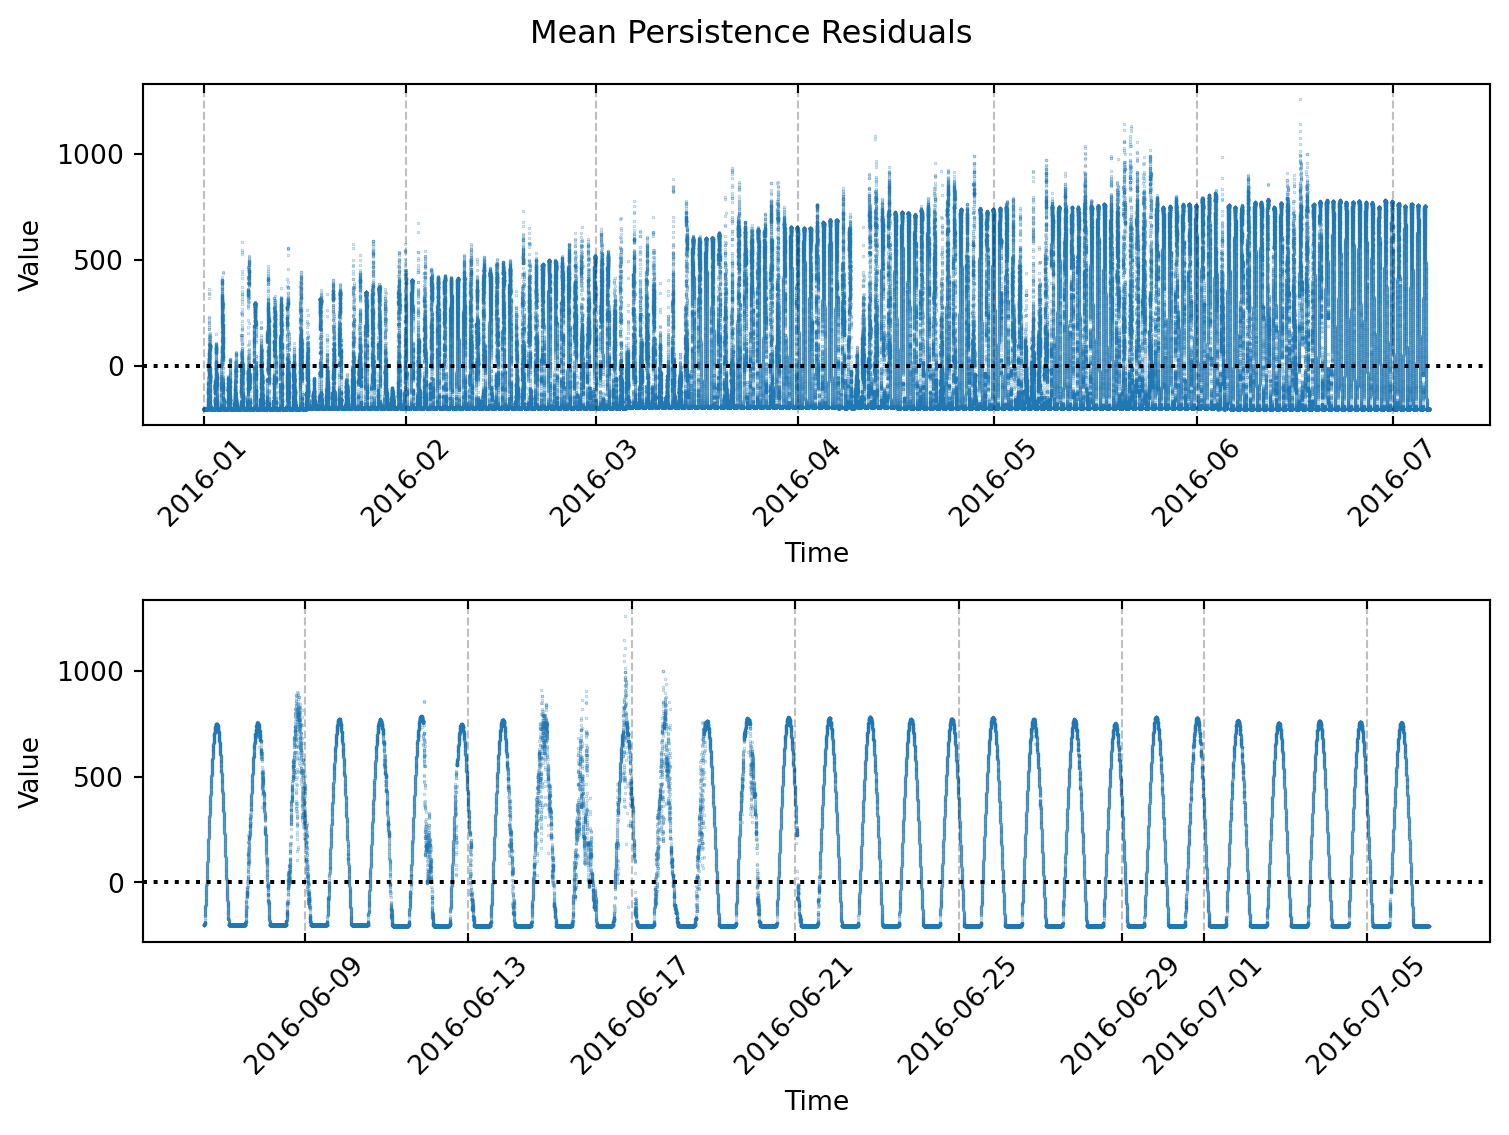

In [20]:
#| code-fold: true
#| code-summary: "Show supplementary code"
residual = (
    pd.Series(np.hstack(ground_truth) - np.hstack(forecasts))
)
residual.index = outsample_ghi_df.index[:len(np.hstack(ground_truth))]

fig, axs = plt.subplots(2, 1, figsize=(8, 6))

ax = visualize_time_series(
    ax=axs[0],
    time_series=residual,
    time_series_name="Residuals",
    s=0.05,
    alpha=0.5
)
ax=visualize_time_series(
    axs[1],
    time_series=residual[-(60 * 24 * 30):],
    time_series_name="Residuals",
    s=0.05,
    alpha=0.5
)


for ax in axs:
    ax.axhline(
        y=0,
        linestyle=":",
        c="k"
    )

plt.suptitle("Mean Persistence Residuals")
plt.tight_layout()
plt.show()

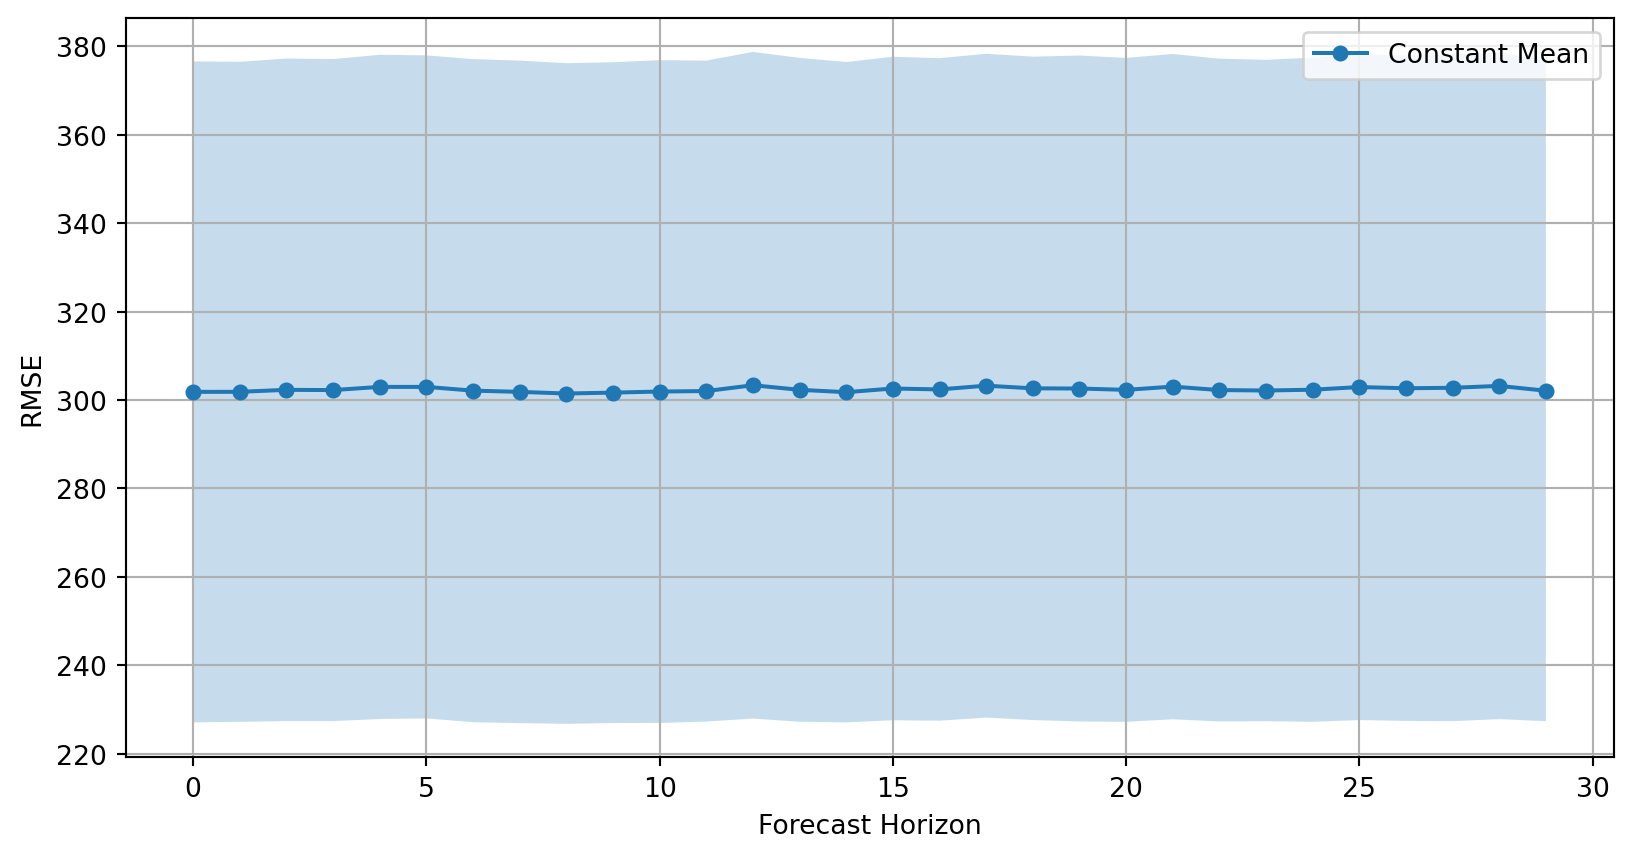

In [21]:
#| code-fold: true
#| code-summary: "Show supplementary code"
error_mean, error_sem = compute_rmse(
    y_true=np.array(ground_truth),
    y_forecast=np.array(forecasts),
    axis=0
)
MODELS_RESULTS["Constant Mean"] = {"error_mean": error_mean, "error_sem": error_sem}

fig, ax = plt.subplots(1, 1, figsize=(10, 5))
ax = visualize_forecast_horizon_accuracy(
    ax=ax,
    model_name="Constant Mean",
    error_name="RMSE",
    error_mean=error_mean,
    error_sem=error_sem,
    marker="o",
    markersize=5
)
plt.legend()
plt.show()

### I - Mean Persistence Model

$$\hat{y}_{S+1} = \frac{1}{S} \sum_{s0}^S y_s$$


In [22]:
mean_persistence_model = (
    insample_ghi_df
    .groupby(["day_year", "hour"])
    ["ghi"]
    .mean()
    .reset_index()
    .rename({"ghi": "ghi_forecast"}, axis=1)
)


outsample_forecast = (
    outsample_ghi_df
    .merge(
        mean_persistence_model,
        how="left",
        on=["day_year", "hour"],
        
    )
    .interpolate(method="linear", limit_direction="both")
    [["ghi", "ghi_forecast"]]
)
outsample_forecast.index = outsample_ghi_df.index

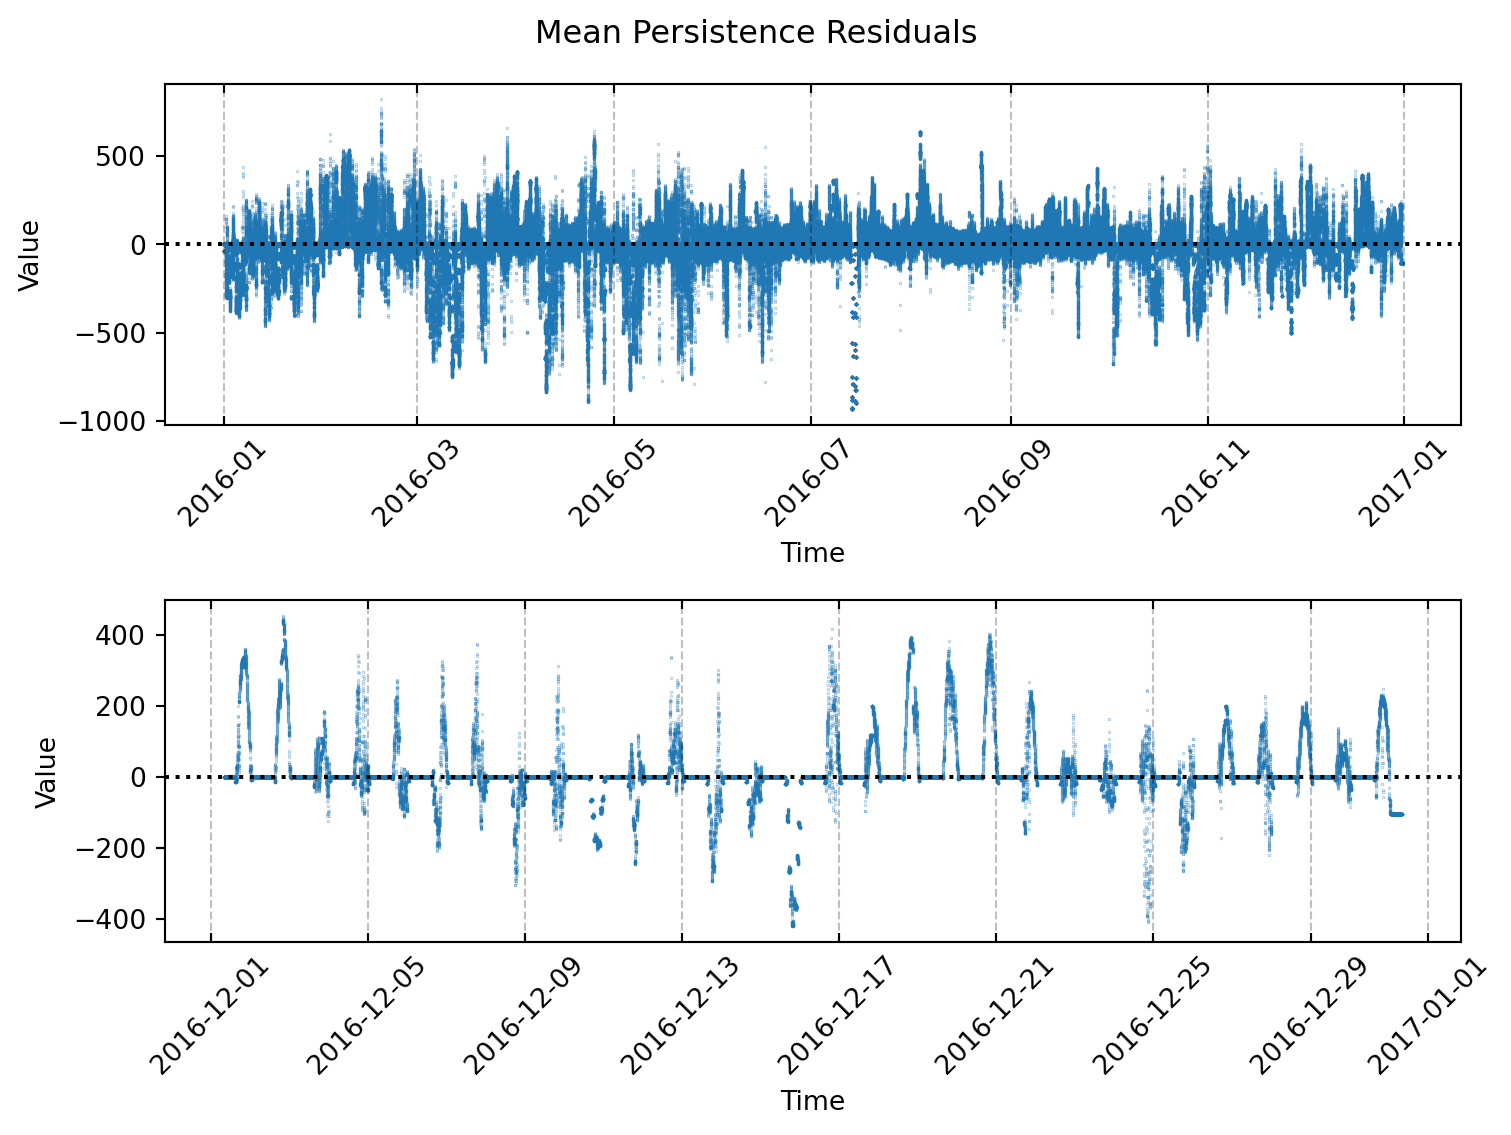

In [23]:
#| code-fold: true
#| code-summary: "Show supplementary code"
residual = outsample_forecast["ghi"] - outsample_forecast["ghi_forecast"]

fig, axs = plt.subplots(2, 1, figsize=(8, 6))

ax = visualize_time_series(
    ax=axs[0],
    time_series=residual,
    time_series_name="Residuals",
    s=0.05,
    alpha=0.5
)
ax=visualize_time_series(
    axs[1],
    time_series=residual[-(60 * 24 * 30):],
    time_series_name="Residuals",
    s=0.05,
    alpha=0.5
)


for ax in axs:
    ax.axhline(
        y=0,
        linestyle=":",
        c="k"
    )

plt.suptitle("Mean Persistence Residuals")
plt.tight_layout()
plt.show()

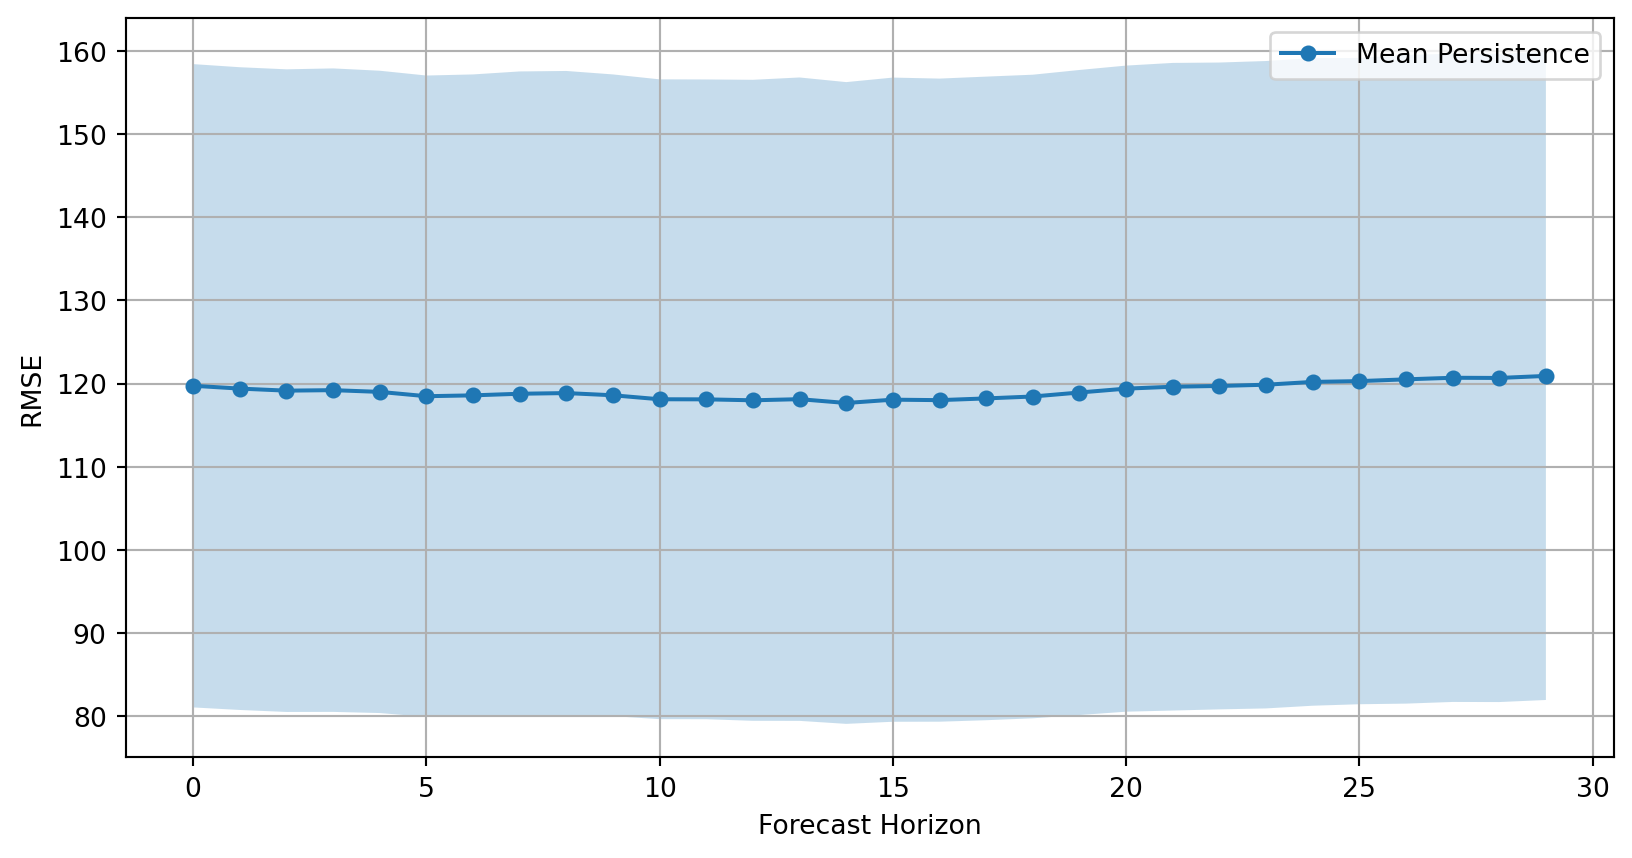

In [24]:
#| code-fold: true
#| code-summary: "Show supplementary code"
y_forecast = np.array(
    np.split(
        outsample_forecast["ghi_forecast"].values,      
        int(len(outsample_forecast["ghi"].values) / 30)
    )
)
y_true = np.array(
    np.split(
        outsample_forecast["ghi"].values,      
        int(len(outsample_forecast["ghi"].values) / 30)
    )
)

error_mean, error_sem = compute_rmse(
    y_true=y_true,
    y_forecast=y_forecast,
    axis=0
)
MODELS_RESULTS["Mean Persistence"] = {"error_mean": error_mean, "error_sem": error_sem}

fig, ax = plt.subplots(1, 1, figsize=(10, 5))
ax = visualize_forecast_horizon_accuracy(
    ax=ax,
    model_name="Mean Persistence",
    error_name="RMSE",
    error_mean=error_mean,
    error_sem=error_sem,
    marker="o",
    markersize=5
)
plt.legend()
plt.show()

### II - Exponential Moving Average

$$\hat{y}_{T+1} = \frac{1}{T} \sum_{t0}^T y_t$$


In [25]:
from modules.models.baselines import ewm_forecast

ground_truth = []
forecasts = []
early_stop_counter = 0

for insample_indices, outsample_indices in tqdm(TIME_SERIES_SPLITTER.split(FULL_SERIES)):

    insample_series, outsample_series = FULL_SERIES[insample_indices], FULL_SERIES[outsample_indices]
    insample_forecast, outsample_forecast = ewm_forecast(
        time_series=insample_series,
        steps_ahead=30,
        alpha=0.5,
    )

    forecasts.append(outsample_forecast)
    ground_truth.append(outsample_series)
    early_stop_counter += 1

    if early_stop_counter > EARLY_STOP_LIMIT:
        break

0it [00:00, ?it/s]

6it [00:00, 52.28it/s]

12it [00:00, 55.39it/s]

18it [00:00, 55.61it/s]

24it [00:00, 54.63it/s]

30it [00:00, 52.22it/s]

36it [00:00, 51.94it/s]

42it [00:00, 53.72it/s]

48it [00:00, 55.06it/s]

54it [00:01, 50.66it/s]

60it [00:01, 41.86it/s]

65it [00:01, 31.19it/s]

69it [00:01, 27.79it/s]

73it [00:01, 26.15it/s]

76it [00:01, 26.77it/s]

79it [00:02, 26.29it/s]

82it [00:02, 24.67it/s]

85it [00:02, 24.27it/s]

90it [00:02, 29.37it/s]

95it [00:02, 34.22it/s]

100it [00:02, 36.84it/s]

105it [00:02, 38.45it/s]

110it [00:02, 41.12it/s]

115it [00:03, 42.95it/s]

120it [00:03, 44.56it/s]

126it [00:03, 46.45it/s]

132it [00:03, 47.76it/s]

138it [00:03, 49.00it/s]

144it [00:03, 49.79it/s]

150it [00:03, 49.90it/s]

155it [00:03, 49.48it/s]

160it [00:03, 49.31it/s]

165it [00:04, 45.47it/s]

170it [00:04, 44.93it/s]

175it [00:04, 42.69it/s]

180it [00:04, 43.93it/s]

185it [00:04, 45.07it/s]

190it [00:04, 46.41it/s]

196it [00:04, 47.74it/s]

202it [00:04, 48.54it/s]

208it [00:04, 49.28it/s]

214it [00:05, 49.55it/s]

219it [00:05, 49.61it/s]

224it [00:05, 47.87it/s]

229it [00:05, 47.12it/s]

234it [00:05, 47.92it/s]

240it [00:05, 48.71it/s]

245it [00:05, 49.05it/s]

250it [00:05, 47.83it/s]

255it [00:05, 47.10it/s]

260it [00:06, 46.05it/s]

265it [00:06, 45.79it/s]

270it [00:06, 46.12it/s]

275it [00:06, 46.73it/s]

280it [00:06, 47.52it/s]

285it [00:06, 47.86it/s]

293it [00:06, 55.22it/s]

300it [00:06, 57.90it/s]

306it [00:06, 58.45it/s]

312it [00:07, 58.82it/s]

318it [00:07, 58.25it/s]

324it [00:07, 50.27it/s]

330it [00:07, 51.64it/s]

337it [00:07, 54.67it/s]

343it [00:07, 56.11it/s]

349it [00:07, 57.10it/s]

355it [00:07, 57.83it/s]

361it [00:07, 58.29it/s]

367it [00:07, 58.51it/s]

373it [00:08, 58.59it/s]

379it [00:08, 58.28it/s]

386it [00:08, 60.49it/s]

393it [00:08, 60.29it/s]

400it [00:08, 59.92it/s]

406it [00:08, 58.68it/s]

412it [00:08, 58.36it/s]

418it [00:08, 58.20it/s]

424it [00:08, 58.34it/s]

430it [00:09, 57.09it/s]

436it [00:09, 53.91it/s]

442it [00:09, 54.21it/s]

448it [00:09, 53.60it/s]

454it [00:09, 53.32it/s]

460it [00:09, 38.20it/s]

465it [00:09, 38.95it/s]

471it [00:10, 42.38it/s]

476it [00:10, 44.04it/s]

481it [00:10, 42.50it/s]

486it [00:10, 39.93it/s]

491it [00:10, 38.78it/s]

496it [00:10, 39.69it/s]

501it [00:10, 36.58it/s]

505it [00:10, 33.71it/s]

509it [00:11, 33.80it/s]

514it [00:11, 36.55it/s]

519it [00:11, 38.88it/s]

523it [00:11, 30.49it/s]

527it [00:11, 27.49it/s]

530it [00:11, 26.21it/s]

534it [00:11, 28.12it/s]

541it [00:12, 37.63it/s]

548it [00:12, 44.55it/s]

555it [00:12, 49.19it/s]

561it [00:12, 51.82it/s]

567it [00:12, 53.66it/s]

573it [00:12, 55.23it/s]

579it [00:12, 55.97it/s]

585it [00:12, 56.33it/s]

591it [00:12, 56.54it/s]

597it [00:13, 55.05it/s]

603it [00:13, 53.01it/s]

609it [00:13, 50.37it/s]

615it [00:13, 52.29it/s]

621it [00:13, 53.58it/s]

627it [00:13, 54.46it/s]

633it [00:13, 54.85it/s]

639it [00:13, 52.92it/s]

645it [00:14, 39.04it/s]

650it [00:14, 37.45it/s]

655it [00:14, 37.29it/s]

659it [00:14, 37.02it/s]

663it [00:14, 37.58it/s]

667it [00:14, 38.06it/s]

672it [00:14, 39.31it/s]

677it [00:14, 39.80it/s]

682it [00:15, 40.51it/s]

687it [00:15, 40.80it/s]

692it [00:15, 41.36it/s]

699it [00:15, 47.35it/s]

705it [00:15, 48.85it/s]

710it [00:15, 46.95it/s]

715it [00:15, 47.03it/s]

720it [00:15, 47.51it/s]

726it [00:15, 48.55it/s]

732it [00:16, 49.50it/s]

737it [00:16, 48.15it/s]

742it [00:16, 40.39it/s]

747it [00:16, 37.03it/s]

751it [00:16, 36.06it/s]

755it [00:16, 36.49it/s]

759it [00:16, 37.21it/s]

763it [00:16, 37.67it/s]

769it [00:17, 43.27it/s]

776it [00:17, 48.73it/s]

782it [00:17, 51.15it/s]

788it [00:17, 50.98it/s]

794it [00:17, 51.70it/s]

800it [00:17, 53.60it/s]

806it [00:17, 53.31it/s]

812it [00:17, 38.76it/s]

817it [00:18, 36.37it/s]

822it [00:18, 38.71it/s]

829it [00:18, 45.19it/s]

835it [00:18, 48.70it/s]

841it [00:18, 51.24it/s]

847it [00:18, 53.05it/s]

853it [00:18, 54.12it/s]

859it [00:18, 54.64it/s]

865it [00:18, 55.00it/s]

871it [00:19, 54.42it/s]

877it [00:19, 53.33it/s]

883it [00:19, 52.32it/s]

889it [00:19, 50.73it/s]

895it [00:19, 49.58it/s]

900it [00:19, 49.48it/s]

905it [00:19, 41.26it/s]

910it [00:20, 35.19it/s]

914it [00:20, 30.19it/s]

918it [00:20, 29.12it/s]

925it [00:20, 36.76it/s]

930it [00:20, 38.11it/s]

935it [00:20, 34.99it/s]

939it [00:21, 26.01it/s]

943it [00:21, 26.28it/s]

948it [00:21, 30.30it/s]

954it [00:21, 35.22it/s]

958it [00:21, 33.00it/s]

962it [00:21, 27.24it/s]

966it [00:21, 29.50it/s]

970it [00:22, 30.80it/s]

974it [00:22, 32.67it/s]

979it [00:22, 36.70it/s]

984it [00:22, 39.75it/s]

989it [00:22, 41.79it/s]

994it [00:22, 42.84it/s]

999it [00:22, 43.48it/s]

1004it [00:22, 44.10it/s]

1009it [00:22, 44.81it/s]

1014it [00:22, 45.50it/s]

1019it [00:23, 45.71it/s]

1024it [00:23, 46.05it/s]

1029it [00:23, 46.68it/s]

1034it [00:23, 47.41it/s]

1039it [00:23, 48.09it/s]

1044it [00:23, 48.19it/s]

1049it [00:23, 48.19it/s]

1054it [00:23, 47.28it/s]

1060it [00:23, 48.29it/s]

1065it [00:24, 48.60it/s]

1070it [00:24, 48.15it/s]

1075it [00:24, 40.40it/s]

1080it [00:24, 34.20it/s]

1084it [00:24, 34.10it/s]

1089it [00:24, 35.15it/s]

1093it [00:24, 35.49it/s]

1097it [00:25, 33.98it/s]

1101it [00:25, 30.86it/s]

1105it [00:25, 30.44it/s]

1109it [00:25, 31.39it/s]

1113it [00:25, 32.74it/s]

1117it [00:25, 33.83it/s]

1121it [00:25, 34.93it/s]

1125it [00:25, 35.95it/s]

1129it [00:25, 36.81it/s]

1133it [00:26, 37.26it/s]

1137it [00:26, 37.51it/s]

1141it [00:26, 38.12it/s]

1146it [00:26, 39.04it/s]

1151it [00:26, 39.68it/s]

1156it [00:26, 40.17it/s]

1163it [00:26, 47.93it/s]

1170it [00:26, 53.27it/s]

1177it [00:26, 55.97it/s]

1183it [00:27, 56.83it/s]

1189it [00:27, 56.87it/s]

1195it [00:27, 56.54it/s]

1201it [00:27, 57.04it/s]

1207it [00:27, 56.89it/s]

1213it [00:27, 56.47it/s]

1219it [00:27, 56.46it/s]

1225it [00:27, 56.06it/s]

1231it [00:27, 56.16it/s]

1237it [00:28, 55.66it/s]

1243it [00:28, 54.71it/s]

1249it [00:28, 55.09it/s]

1255it [00:28, 56.15it/s]

1261it [00:28, 56.26it/s]

1267it [00:28, 55.90it/s]

1273it [00:28, 55.80it/s]

1279it [00:28, 52.56it/s]

1285it [00:28, 49.62it/s]

1291it [00:29, 52.28it/s]

1297it [00:29, 53.03it/s]

1303it [00:29, 53.81it/s]

1309it [00:29, 54.40it/s]

1315it [00:29, 55.08it/s]

1321it [00:29, 55.30it/s]

1327it [00:29, 55.70it/s]

1333it [00:29, 55.93it/s]

1339it [00:29, 56.33it/s]

1345it [00:29, 55.65it/s]

1351it [00:30, 55.48it/s]

1357it [00:30, 55.65it/s]

1363it [00:30, 55.79it/s]

1369it [00:30, 55.49it/s]

1375it [00:30, 55.18it/s]

1381it [00:30, 53.78it/s]

1387it [00:30, 52.02it/s]

1393it [00:30, 51.41it/s]

1399it [00:30, 53.57it/s]

1405it [00:31, 54.68it/s]

1411it [00:31, 54.99it/s]

1417it [00:31, 55.29it/s]

1423it [00:31, 55.42it/s]

1429it [00:31, 55.59it/s]

1435it [00:31, 55.63it/s]

1441it [00:31, 54.40it/s]

1447it [00:31, 54.53it/s]

1453it [00:31, 54.93it/s]

1459it [00:32, 54.99it/s]

1465it [00:32, 55.26it/s]

1471it [00:32, 55.30it/s]

1477it [00:32, 54.95it/s]

1483it [00:32, 54.07it/s]

1489it [00:32, 54.09it/s]

1495it [00:32, 54.76it/s]

1501it [00:32, 54.97it/s]

1507it [00:32, 55.13it/s]

1513it [00:33, 55.08it/s]

1519it [00:33, 55.17it/s]

1525it [00:33, 55.34it/s]

1531it [00:33, 55.67it/s]

1537it [00:33, 55.55it/s]

1543it [00:33, 55.65it/s]

1549it [00:33, 55.52it/s]

1555it [00:33, 55.70it/s]

1561it [00:33, 55.84it/s]

1567it [00:34, 55.72it/s]

1573it [00:34, 55.21it/s]

1579it [00:34, 55.25it/s]

1585it [00:34, 54.95it/s]

1591it [00:34, 54.99it/s]

1597it [00:34, 55.01it/s]

1603it [00:34, 55.16it/s]

1609it [00:34, 55.10it/s]

1615it [00:34, 55.19it/s]

1621it [00:35, 55.20it/s]

1627it [00:35, 55.20it/s]

1633it [00:35, 55.98it/s]

1640it [00:35, 57.38it/s]

1646it [00:35, 57.47it/s]

1652it [00:35, 55.96it/s]

1658it [00:35, 45.20it/s]

1663it [00:35, 40.37it/s]

1668it [00:36, 38.80it/s]

1674it [00:36, 43.15it/s]

1680it [00:36, 46.14it/s]

1686it [00:36, 47.59it/s]

1691it [00:36, 47.72it/s]

1696it [00:36, 47.02it/s]

1701it [00:36, 46.83it/s]

1706it [00:36, 46.97it/s]

1711it [00:36, 46.93it/s]

1716it [00:37, 46.85it/s]

1721it [00:37, 47.29it/s]

1726it [00:37, 47.77it/s]

1731it [00:37, 48.21it/s]

1738it [00:37, 54.25it/s]

1745it [00:37, 56.16it/s]

1751it [00:37, 56.91it/s]

1757it [00:37, 56.52it/s]

1763it [00:37, 45.58it/s]

1768it [00:38, 33.79it/s]

1773it [00:38, 31.64it/s]

1779it [00:38, 36.91it/s]

1785it [00:38, 41.55it/s]

1791it [00:38, 45.28it/s]

1797it [00:38, 47.85it/s]

1803it [00:38, 49.98it/s]

1809it [00:39, 51.26it/s]

1815it [00:39, 52.24it/s]

1821it [00:39, 52.96it/s]

1827it [00:39, 53.43it/s]

1833it [00:39, 54.14it/s]

1839it [00:39, 54.79it/s]

1845it [00:39, 55.09it/s]

1851it [00:39, 55.44it/s]

1857it [00:39, 55.63it/s]

1863it [00:40, 55.50it/s]

1869it [00:40, 55.39it/s]

1875it [00:40, 55.47it/s]

1881it [00:40, 55.51it/s]

1887it [00:40, 55.75it/s]

1893it [00:40, 55.65it/s]

1899it [00:40, 55.28it/s]

1905it [00:40, 52.62it/s]

1911it [00:40, 46.86it/s]

1916it [00:41, 46.69it/s]

1921it [00:41, 46.76it/s]

1926it [00:41, 46.68it/s]

1931it [00:41, 46.93it/s]

1936it [00:41, 47.00it/s]

1941it [00:41, 47.36it/s]

1946it [00:41, 47.82it/s]

1951it [00:41, 47.95it/s]

1956it [00:41, 48.21it/s]

1961it [00:42, 48.33it/s]

1966it [00:42, 48.25it/s]

1971it [00:42, 48.31it/s]

1976it [00:42, 48.29it/s]

1981it [00:42, 48.46it/s]

1986it [00:42, 48.51it/s]

1991it [00:42, 48.72it/s]

1998it [00:42, 54.98it/s]

2005it [00:42, 57.50it/s]

2012it [00:42, 58.36it/s]

2018it [00:43, 57.96it/s]

2024it [00:43, 57.35it/s]

2030it [00:43, 57.36it/s]

2036it [00:43, 56.88it/s]

2042it [00:43, 56.72it/s]

2048it [00:43, 56.57it/s]

2054it [00:43, 56.25it/s]

2060it [00:43, 56.26it/s]

2066it [00:43, 55.83it/s]

2072it [00:44, 55.93it/s]

2078it [00:44, 55.54it/s]

2084it [00:44, 55.86it/s]

2090it [00:44, 55.68it/s]

2096it [00:44, 55.98it/s]

2102it [00:44, 55.98it/s]

2108it [00:44, 56.00it/s]

2114it [00:44, 56.17it/s]

2120it [00:44, 55.91it/s]

2126it [00:44, 56.02it/s]

2132it [00:45, 55.78it/s]

2138it [00:45, 55.91it/s]

2144it [00:45, 55.81it/s]

2150it [00:45, 55.85it/s]

2156it [00:45, 55.98it/s]

2162it [00:45, 55.79it/s]

2168it [00:45, 55.89it/s]

2174it [00:45, 55.62it/s]

2180it [00:45, 55.78it/s]

2186it [00:46, 55.51it/s]

2192it [00:46, 55.61it/s]

2198it [00:46, 55.42it/s]

2204it [00:46, 55.47it/s]

2210it [00:46, 55.19it/s]

2216it [00:46, 51.54it/s]

2222it [00:46, 47.27it/s]

2229it [00:46, 50.97it/s]

2235it [00:47, 52.30it/s]

2241it [00:47, 52.92it/s]

2247it [00:47, 53.50it/s]

2253it [00:47, 54.14it/s]

2259it [00:47, 54.37it/s]

2265it [00:47, 54.71it/s]

2271it [00:47, 54.66it/s]

2277it [00:47, 54.76it/s]

2283it [00:47, 54.49it/s]

2289it [00:47, 54.20it/s]

2295it [00:48, 54.34it/s]

2301it [00:48, 54.29it/s]

2308it [00:48, 56.64it/s]

2314it [00:48, 56.71it/s]

2320it [00:48, 56.44it/s]

2326it [00:48, 55.96it/s]

2332it [00:48, 55.53it/s]

2338it [00:48, 55.34it/s]

2344it [00:48, 55.16it/s]

2350it [00:49, 54.74it/s]

2356it [00:49, 54.26it/s]

2362it [00:49, 53.91it/s]

2368it [00:49, 53.78it/s]

2374it [00:49, 53.59it/s]

2380it [00:49, 53.27it/s]

2386it [00:49, 53.16it/s]

2392it [00:49, 53.32it/s]

2398it [00:49, 53.21it/s]

2404it [00:50, 52.73it/s]

2410it [00:50, 52.86it/s]

2416it [00:50, 53.27it/s]

2422it [00:50, 53.54it/s]

2428it [00:50, 53.73it/s]

2434it [00:50, 53.80it/s]

2440it [00:50, 51.50it/s]

2446it [00:50, 51.42it/s]

2452it [00:51, 51.97it/s]

2458it [00:51, 52.62it/s]

2464it [00:51, 52.95it/s]

2470it [00:51, 53.35it/s]

2476it [00:51, 53.30it/s]

2482it [00:51, 52.81it/s]

2488it [00:51, 52.66it/s]

2494it [00:51, 52.90it/s]

2500it [00:51, 52.55it/s]

2506it [00:52, 52.16it/s]

2512it [00:52, 51.81it/s]

2518it [00:52, 52.57it/s]

2524it [00:52, 53.16it/s]

2530it [00:52, 53.31it/s]

2536it [00:52, 53.51it/s]

2542it [00:52, 54.34it/s]

2548it [00:52, 54.11it/s]

2554it [00:52, 54.39it/s]

2560it [00:53, 54.25it/s]

2566it [00:53, 53.97it/s]

2572it [00:53, 54.39it/s]

2578it [00:53, 54.26it/s]

2584it [00:53, 54.41it/s]

2590it [00:53, 54.64it/s]

2596it [00:53, 54.91it/s]

2602it [00:53, 54.46it/s]

2608it [00:53, 54.49it/s]

2614it [00:54, 55.01it/s]

2620it [00:54, 51.78it/s]

2626it [00:54, 49.59it/s]

2632it [00:54, 49.76it/s]

2638it [00:54, 50.71it/s]

2644it [00:54, 43.73it/s]

2649it [00:54, 36.89it/s]

2653it [00:55, 37.27it/s]

2657it [00:55, 29.16it/s]

2661it [00:55, 30.31it/s]

2666it [00:55, 34.21it/s]

2671it [00:55, 36.32it/s]

2676it [00:55, 37.61it/s]

2681it [00:55, 38.78it/s]

2686it [00:55, 39.94it/s]

2691it [00:56, 41.14it/s]

2696it [00:56, 42.79it/s]

2702it [00:56, 45.76it/s]

2707it [00:56, 46.28it/s]

2712it [00:56, 45.58it/s]

2717it [00:56, 45.21it/s]

2722it [00:56, 44.73it/s]

2727it [00:56, 45.04it/s]

2732it [00:56, 46.12it/s]

2738it [00:57, 48.09it/s]

2743it [00:57, 48.13it/s]

2748it [00:57, 48.57it/s]

2753it [00:57, 47.85it/s]

2758it [00:57, 46.26it/s]

2763it [00:57, 43.82it/s]

2768it [00:57, 43.79it/s]

2773it [00:57, 44.90it/s]

2778it [00:57, 44.79it/s]

2783it [00:58, 43.27it/s]

2788it [00:58, 43.45it/s]

2793it [00:58, 45.15it/s]

2798it [00:58, 34.31it/s]

2802it [00:58, 31.57it/s]

2806it [00:58, 31.30it/s]

2810it [00:58, 31.81it/s]

2814it [00:59, 32.31it/s]

2818it [00:59, 32.66it/s]

2822it [00:59, 33.23it/s]

2826it [00:59, 33.64it/s]

2830it [00:59, 34.01it/s]

2834it [00:59, 34.32it/s]

2841it [00:59, 42.63it/s]

2848it [00:59, 48.17it/s]

2854it [00:59, 49.61it/s]

2859it [01:00, 48.81it/s]

2864it [01:00, 47.86it/s]

2870it [01:00, 49.02it/s]

2876it [01:00, 50.87it/s]

2882it [01:00, 51.40it/s]

2888it [01:00, 51.38it/s]

2894it [01:00, 51.17it/s]

2900it [01:00, 51.65it/s]

2906it [01:00, 52.29it/s]

2912it [01:01, 52.49it/s]

2918it [01:01, 52.66it/s]

2924it [01:01, 52.73it/s]

2930it [01:01, 53.19it/s]

2936it [01:01, 53.49it/s]

2942it [01:01, 53.47it/s]

2948it [01:01, 53.40it/s]

2954it [01:01, 53.44it/s]

2960it [01:01, 54.20it/s]

2966it [01:02, 53.93it/s]

2972it [01:02, 53.81it/s]

2978it [01:02, 53.92it/s]

2984it [01:02, 53.73it/s]

2990it [01:02, 53.84it/s]

2996it [01:02, 54.33it/s]

3002it [01:02, 54.08it/s]

3008it [01:02, 54.26it/s]

3014it [01:02, 53.93it/s]

3020it [01:03, 51.35it/s]

3026it [01:03, 49.79it/s]

3032it [01:03, 50.61it/s]

3038it [01:03, 51.25it/s]

3044it [01:03, 50.33it/s]

3050it [01:03, 50.95it/s]

3056it [01:03, 51.51it/s]

3062it [01:03, 44.76it/s]

3067it [01:04, 31.99it/s]

3071it [01:04, 29.14it/s]

3075it [01:04, 25.63it/s]

3078it [01:04, 24.93it/s]

3081it [01:04, 23.99it/s]

3084it [01:05, 24.04it/s]

3088it [01:05, 27.08it/s]

3092it [01:05, 29.47it/s]

3097it [01:05, 32.93it/s]

3102it [01:05, 34.96it/s]

3106it [01:05, 36.20it/s]

3111it [01:05, 37.96it/s]

3116it [01:05, 39.58it/s]

3121it [01:05, 41.05it/s]

3126it [01:06, 41.67it/s]

3131it [01:06, 41.29it/s]

3136it [01:06, 40.36it/s]

3141it [01:06, 41.52it/s]

3146it [01:06, 42.45it/s]

3151it [01:06, 42.84it/s]

3156it [01:06, 42.48it/s]

3161it [01:06, 42.54it/s]

3168it [01:07, 47.93it/s]

3174it [01:07, 50.67it/s]

3180it [01:07, 51.62it/s]

3186it [01:07, 51.93it/s]

3192it [01:07, 51.63it/s]

3198it [01:07, 50.84it/s]

3204it [01:07, 50.97it/s]

3210it [01:07, 51.31it/s]

3216it [01:07, 50.86it/s]

3222it [01:08, 52.26it/s]

3228it [01:08, 52.78it/s]

3234it [01:08, 52.92it/s]

3240it [01:08, 52.83it/s]

3246it [01:08, 53.00it/s]

3252it [01:08, 53.34it/s]

3258it [01:08, 53.34it/s]

3264it [01:08, 53.46it/s]

3270it [01:08, 53.54it/s]

3276it [01:09, 53.57it/s]

3282it [01:09, 53.51it/s]

3288it [01:09, 53.67it/s]

3294it [01:09, 53.51it/s]

3300it [01:09, 53.34it/s]

3306it [01:09, 53.35it/s]

3312it [01:09, 53.30it/s]

3318it [01:09, 53.33it/s]

3324it [01:09, 53.25it/s]

3330it [01:10, 53.00it/s]

3336it [01:10, 53.00it/s]

3342it [01:10, 53.23it/s]

3348it [01:10, 53.16it/s]

3354it [01:10, 53.10it/s]

3360it [01:10, 53.10it/s]

3366it [01:10, 53.26it/s]

3372it [01:10, 53.17it/s]

3378it [01:10, 53.22it/s]

3384it [01:11, 53.35it/s]

3390it [01:11, 53.65it/s]

3396it [01:11, 53.63it/s]

3402it [01:11, 53.62it/s]

3408it [01:11, 53.11it/s]

3414it [01:11, 53.11it/s]

3420it [01:11, 52.92it/s]

3426it [01:11, 52.54it/s]

3432it [01:11, 51.61it/s]

3438it [01:12, 50.46it/s]

3444it [01:12, 47.56it/s]

3449it [01:12, 48.12it/s]

3455it [01:12, 49.97it/s]

3461it [01:12, 50.86it/s]

3467it [01:12, 51.06it/s]

3473it [01:12, 50.64it/s]

3479it [01:12, 49.61it/s]

3484it [01:13, 47.28it/s]

3489it [01:13, 44.13it/s]

3494it [01:13, 42.60it/s]

3499it [01:13, 41.49it/s]

3504it [01:13, 40.71it/s]

3509it [01:13, 41.37it/s]

3514it [01:13, 42.22it/s]

3519it [01:13, 42.38it/s]

3524it [01:14, 42.20it/s]

3529it [01:14, 42.43it/s]

3534it [01:14, 42.62it/s]

3539it [01:14, 40.34it/s]

3544it [01:14, 38.04it/s]

3548it [01:14, 38.39it/s]

3552it [01:14, 38.58it/s]

3556it [01:15, 26.62it/s]

3560it [01:15, 23.95it/s]

3564it [01:15, 26.41it/s]

3569it [01:15, 31.00it/s]

3574it [01:15, 34.23it/s]

3580it [01:15, 40.27it/s]

3586it [01:15, 44.87it/s]

3592it [01:15, 46.40it/s]

3597it [01:16, 47.27it/s]

3602it [01:16, 47.86it/s]

3607it [01:16, 48.14it/s]

3613it [01:16, 48.87it/s]

3618it [01:16, 44.83it/s]

3623it [01:16, 42.02it/s]

3629it [01:16, 46.36it/s]

3634it [01:16, 46.72it/s]

3639it [01:16, 45.37it/s]

3645it [01:17, 48.05it/s]

3651it [01:17, 49.47it/s]

3657it [01:17, 50.36it/s]

3663it [01:17, 50.96it/s]

3669it [01:17, 51.41it/s]

3675it [01:17, 51.62it/s]

3681it [01:17, 51.69it/s]

3687it [01:17, 51.40it/s]

3693it [01:17, 50.59it/s]

3699it [01:18, 48.83it/s]

3704it [01:18, 46.56it/s]

3709it [01:18, 46.06it/s]

3714it [01:18, 46.67it/s]

3719it [01:18, 46.97it/s]

3724it [01:18, 46.87it/s]

3729it [01:18, 47.06it/s]

3734it [01:18, 46.47it/s]

3739it [01:18, 45.58it/s]

3744it [01:19, 46.09it/s]

3750it [01:19, 47.64it/s]

3756it [01:19, 48.71it/s]

3761it [01:19, 48.33it/s]

3766it [01:19, 37.38it/s]

3771it [01:19, 28.71it/s]

3777it [01:20, 33.51it/s]

3781it [01:20, 32.66it/s]

3785it [01:20, 32.27it/s]

3789it [01:20, 33.05it/s]

3793it [01:20, 32.18it/s]

3797it [01:20, 22.93it/s]

3801it [01:20, 25.34it/s]

3805it [01:21, 27.71it/s]

3809it [01:21, 21.24it/s]

3812it [01:21, 21.47it/s]

3815it [01:21, 23.06it/s]

3821it [01:21, 30.66it/s]

3827it [01:21, 36.14it/s]

3833it [01:21, 40.43it/s]

3839it [01:22, 43.63it/s]

3844it [01:22, 44.98it/s]

3849it [01:22, 44.22it/s]

3854it [01:22, 44.49it/s]

3859it [01:22, 45.15it/s]

3864it [01:22, 46.16it/s]

3869it [01:22, 45.45it/s]

3874it [01:22, 45.86it/s]

3879it [01:22, 46.42it/s]

3884it [01:23, 46.65it/s]

3889it [01:23, 45.72it/s]

3894it [01:23, 44.45it/s]

3899it [01:23, 43.95it/s]

3904it [01:23, 43.71it/s]

3909it [01:23, 43.64it/s]

3914it [01:23, 43.72it/s]

3919it [01:23, 43.81it/s]

3924it [01:23, 44.19it/s]

3929it [01:24, 44.43it/s]

3934it [01:24, 44.61it/s]

3939it [01:24, 44.39it/s]

3944it [01:24, 44.69it/s]

3949it [01:24, 44.52it/s]

3954it [01:24, 44.62it/s]

3959it [01:24, 44.31it/s]

3964it [01:24, 44.01it/s]

3969it [01:24, 44.17it/s]

3974it [01:25, 44.34it/s]

3979it [01:25, 44.47it/s]

3984it [01:25, 44.80it/s]

3989it [01:25, 45.18it/s]

3994it [01:25, 45.32it/s]

3999it [01:25, 45.47it/s]

4004it [01:25, 45.56it/s]

4009it [01:25, 43.89it/s]

4014it [01:25, 42.74it/s]

4019it [01:26, 41.36it/s]

4024it [01:26, 34.01it/s]

4028it [01:26, 32.67it/s]

4032it [01:26, 32.70it/s]

4036it [01:26, 33.32it/s]

4040it [01:26, 33.86it/s]

4044it [01:26, 34.25it/s]

4048it [01:27, 34.33it/s]

4052it [01:27, 34.60it/s]

4056it [01:27, 35.79it/s]

4060it [01:27, 36.19it/s]

4064it [01:27, 37.01it/s]

4068it [01:27, 37.52it/s]

4072it [01:27, 37.98it/s]

4076it [01:27, 37.99it/s]

4080it [01:27, 38.06it/s]

4084it [01:27, 38.06it/s]

4088it [01:28, 37.79it/s]

4092it [01:28, 37.19it/s]

4096it [01:28, 36.59it/s]

4100it [01:28, 36.16it/s]

4104it [01:28, 36.43it/s]

4108it [01:28, 36.35it/s]

4112it [01:28, 36.43it/s]

4116it [01:28, 37.01it/s]

4120it [01:28, 36.94it/s]

4124it [01:29, 37.38it/s]

4128it [01:29, 37.61it/s]

4132it [01:29, 37.91it/s]

4136it [01:29, 38.11it/s]

4140it [01:29, 38.29it/s]

4144it [01:29, 38.41it/s]

4148it [01:29, 38.49it/s]

4152it [01:29, 38.70it/s]

4156it [01:29, 38.98it/s]

4160it [01:30, 38.84it/s]

4164it [01:30, 38.72it/s]

4168it [01:30, 38.30it/s]

4172it [01:30, 38.19it/s]

4176it [01:30, 38.35it/s]

4180it [01:30, 38.10it/s]

4184it [01:30, 37.94it/s]

4188it [01:30, 38.14it/s]

4192it [01:30, 38.34it/s]

4196it [01:30, 38.81it/s]

4200it [01:31, 39.12it/s]

4204it [01:31, 39.16it/s]

4208it [01:31, 38.52it/s]

4212it [01:31, 38.70it/s]

4216it [01:31, 38.67it/s]

4220it [01:31, 38.39it/s]

4224it [01:31, 37.89it/s]

4228it [01:31, 37.84it/s]

4232it [01:31, 37.96it/s]

4236it [01:31, 38.06it/s]

4240it [01:32, 38.19it/s]

4244it [01:32, 38.12it/s]

4248it [01:32, 37.60it/s]

4252it [01:32, 37.76it/s]

4256it [01:32, 37.49it/s]

4260it [01:32, 37.53it/s]

4264it [01:32, 37.90it/s]

4268it [01:32, 38.40it/s]

4272it [01:32, 38.84it/s]

4276it [01:33, 39.06it/s]

4281it [01:33, 39.32it/s]

4285it [01:33, 38.57it/s]

4289it [01:33, 38.52it/s]

4293it [01:33, 38.23it/s]

4297it [01:33, 38.48it/s]

4301it [01:33, 38.65it/s]

4306it [01:33, 39.44it/s]

4311it [01:33, 39.74it/s]

4315it [01:34, 39.70it/s]

4320it [01:34, 40.10it/s]

4325it [01:34, 40.17it/s]

4330it [01:34, 40.68it/s]

4335it [01:34, 40.61it/s]

4340it [01:34, 40.34it/s]

4345it [01:34, 40.36it/s]

4350it [01:34, 40.42it/s]

4355it [01:35, 40.71it/s]

4360it [01:35, 40.49it/s]

4365it [01:35, 40.78it/s]

4370it [01:35, 40.79it/s]

4375it [01:35, 40.99it/s]

4380it [01:35, 41.03it/s]

4385it [01:35, 41.02it/s]

4390it [01:35, 40.99it/s]

4395it [01:35, 41.04it/s]

4400it [01:36, 41.17it/s]

4405it [01:36, 41.04it/s]

4410it [01:36, 40.92it/s]

4415it [01:36, 40.23it/s]

4420it [01:36, 39.47it/s]

4424it [01:36, 39.05it/s]

4428it [01:36, 38.73it/s]

4432it [01:36, 38.36it/s]

4436it [01:37, 38.60it/s]

4441it [01:37, 39.07it/s]

4446it [01:37, 39.53it/s]

4453it [01:37, 46.88it/s]

4460it [01:37, 51.94it/s]

4466it [01:37, 54.15it/s]

4472it [01:37, 55.13it/s]

4478it [01:37, 55.47it/s]

4484it [01:37, 55.18it/s]

4490it [01:38, 55.45it/s]

4496it [01:38, 54.95it/s]

4502it [01:38, 54.87it/s]

4508it [01:38, 54.82it/s]

4514it [01:38, 54.83it/s]

4520it [01:38, 54.95it/s]

4526it [01:38, 53.96it/s]

4532it [01:38, 52.88it/s]

4538it [01:38, 51.59it/s]

4544it [01:39, 50.02it/s]

4550it [01:39, 49.74it/s]

4556it [01:39, 50.99it/s]

4562it [01:39, 51.05it/s]

4568it [01:39, 40.62it/s]

4573it [01:39, 37.75it/s]

4580it [01:39, 43.40it/s]

4586it [01:40, 46.62it/s]

4592it [01:40, 48.13it/s]

4598it [01:40, 48.70it/s]

4604it [01:40, 49.50it/s]

4610it [01:40, 50.08it/s]

4616it [01:40, 50.50it/s]

4622it [01:40, 51.08it/s]

4628it [01:40, 51.53it/s]

4634it [01:40, 51.85it/s]

4640it [01:41, 51.98it/s]

4646it [01:41, 51.48it/s]

4652it [01:41, 51.41it/s]

4658it [01:41, 51.41it/s]

4664it [01:41, 51.53it/s]

4670it [01:41, 51.17it/s]

4676it [01:41, 51.25it/s]

4682it [01:41, 51.35it/s]

4688it [01:42, 49.53it/s]

4693it [01:42, 48.46it/s]

4699it [01:42, 50.22it/s]

4705it [01:42, 50.50it/s]

4711it [01:42, 40.48it/s]

4717it [01:42, 43.34it/s]

4723it [01:42, 45.83it/s]

4728it [01:42, 39.24it/s]

4733it [01:43, 36.41it/s]

4739it [01:43, 41.61it/s]

4744it [01:43, 43.48it/s]

4749it [01:43, 44.65it/s]

4754it [01:43, 45.50it/s]

4760it [01:43, 47.00it/s]

4765it [01:43, 47.68it/s]

4770it [01:43, 47.47it/s]

4775it [01:43, 47.55it/s]

4780it [01:44, 47.09it/s]

4785it [01:44, 46.70it/s]

4790it [01:44, 46.67it/s]

4796it [01:44, 49.75it/s]

4802it [01:44, 50.65it/s]

4808it [01:44, 50.60it/s]

4814it [01:44, 50.44it/s]

4820it [01:44, 49.97it/s]

4826it [01:44, 49.90it/s]

4832it [01:45, 50.20it/s]

4838it [01:45, 50.05it/s]

4844it [01:45, 50.00it/s]

4850it [01:45, 49.95it/s]

4855it [01:45, 49.04it/s]

4860it [01:45, 45.80it/s]

4865it [01:45, 43.65it/s]

4870it [01:45, 39.26it/s]

4875it [01:46, 32.49it/s]

4879it [01:46, 27.97it/s]

4883it [01:46, 28.25it/s]

4887it [01:46, 28.96it/s]

4891it [01:46, 29.29it/s]

4895it [01:46, 28.86it/s]

4898it [01:47, 28.99it/s]

4901it [01:47, 28.27it/s]

4905it [01:47, 29.20it/s]

4909it [01:47, 30.90it/s]

4913it [01:47, 32.22it/s]

4920it [01:47, 41.08it/s]

4927it [01:47, 47.49it/s]

4933it [01:47, 50.67it/s]

4939it [01:47, 52.36it/s]

4945it [01:48, 52.85it/s]

4951it [01:48, 53.08it/s]

4957it [01:48, 52.82it/s]

4963it [01:48, 52.81it/s]

4969it [01:48, 52.64it/s]

4975it [01:48, 52.34it/s]

4981it [01:48, 52.03it/s]

4987it [01:48, 51.74it/s]

4993it [01:48, 51.33it/s]

4999it [01:49, 51.85it/s]

5005it [01:49, 52.02it/s]

5011it [01:49, 52.39it/s]

5017it [01:49, 52.75it/s]

5023it [01:49, 52.62it/s]

5029it [01:49, 52.85it/s]

5035it [01:49, 53.07it/s]

5041it [01:49, 53.10it/s]

5047it [01:50, 52.39it/s]

5053it [01:50, 52.52it/s]

5059it [01:50, 52.68it/s]

5065it [01:50, 52.66it/s]

5071it [01:50, 52.67it/s]

5077it [01:50, 52.62it/s]

5083it [01:50, 52.37it/s]

5089it [01:50, 52.26it/s]

5095it [01:50, 52.04it/s]

5101it [01:51, 51.09it/s]

5107it [01:51, 50.22it/s]

5113it [01:51, 49.18it/s]

5118it [01:51, 48.46it/s]

5123it [01:51, 47.89it/s]

5128it [01:51, 47.89it/s]

5133it [01:51, 48.13it/s]

5138it [01:51, 48.45it/s]

5143it [01:51, 48.65it/s]

5149it [01:52, 51.69it/s]

5155it [01:52, 52.16it/s]

5161it [01:52, 52.08it/s]

5167it [01:52, 52.10it/s]

5173it [01:52, 52.13it/s]

5179it [01:52, 52.41it/s]

5185it [01:52, 52.43it/s]

5191it [01:52, 52.46it/s]

5197it [01:52, 52.49it/s]

5203it [01:53, 52.37it/s]

5209it [01:53, 52.45it/s]

5215it [01:53, 52.55it/s]

5221it [01:53, 52.52it/s]

5227it [01:53, 52.50it/s]

5233it [01:53, 52.43it/s]

5239it [01:53, 52.39it/s]

5245it [01:53, 52.38it/s]

5251it [01:53, 52.31it/s]

5257it [01:54, 52.15it/s]

5263it [01:54, 52.11it/s]

5269it [01:54, 51.99it/s]

5275it [01:54, 52.14it/s]

5281it [01:54, 51.98it/s]

5287it [01:54, 51.69it/s]

5293it [01:54, 51.47it/s]

5299it [01:54, 51.32it/s]

5305it [01:55, 51.47it/s]

5311it [01:55, 51.43it/s]

5317it [01:55, 51.41it/s]

5323it [01:55, 51.52it/s]

5329it [01:55, 51.59it/s]

5335it [01:55, 51.54it/s]

5341it [01:55, 51.52it/s]

5347it [01:55, 40.32it/s]

5352it [01:56, 36.68it/s]

5356it [01:56, 35.69it/s]

5360it [01:56, 35.47it/s]

5364it [01:56, 35.49it/s]

5368it [01:56, 35.77it/s]

5372it [01:56, 35.82it/s]

5376it [01:56, 36.20it/s]

5380it [01:56, 36.74it/s]

5384it [01:57, 37.00it/s]

5388it [01:57, 37.29it/s]

5392it [01:57, 37.59it/s]

5396it [01:57, 37.09it/s]

5400it [01:57, 36.72it/s]

5404it [01:57, 36.34it/s]

5408it [01:57, 35.99it/s]

5412it [01:57, 36.47it/s]

5416it [01:57, 36.77it/s]

5420it [01:57, 36.99it/s]

5424it [01:58, 37.47it/s]

5428it [01:58, 37.86it/s]

5432it [01:58, 38.32it/s]

5437it [01:58, 39.11it/s]

5441it [01:58, 39.19it/s]

5446it [01:58, 39.60it/s]

5450it [01:58, 39.63it/s]

5455it [01:58, 39.90it/s]

5460it [01:58, 39.97it/s]

5465it [01:59, 40.08it/s]

5470it [01:59, 39.88it/s]

5474it [01:59, 39.35it/s]

5478it [01:59, 38.87it/s]

5482it [01:59, 38.86it/s]

5486it [01:59, 38.55it/s]

5490it [01:59, 38.40it/s]

5494it [01:59, 38.36it/s]

5501it [01:59, 45.77it/s]

5508it [02:00, 50.60it/s]

5514it [02:00, 52.48it/s]

5520it [02:00, 52.71it/s]

5526it [02:00, 52.92it/s]

5532it [02:00, 53.03it/s]

5538it [02:00, 53.07it/s]

5544it [02:00, 53.12it/s]

5550it [02:00, 52.83it/s]

5556it [02:01, 43.53it/s]

5561it [02:01, 38.92it/s]

5566it [02:01, 37.43it/s]

5570it [02:01, 36.82it/s]

5574it [02:01, 36.42it/s]

5578it [02:01, 36.09it/s]

5582it [02:01, 36.23it/s]

5586it [02:01, 35.54it/s]

5590it [02:02, 35.32it/s]

5594it [02:02, 35.50it/s]

5598it [02:02, 35.60it/s]

5602it [02:02, 35.92it/s]

5606it [02:02, 35.78it/s]

5610it [02:02, 35.74it/s]

5614it [02:02, 35.82it/s]

5618it [02:02, 35.98it/s]

5622it [02:02, 36.39it/s]

5626it [02:03, 36.52it/s]

5633it [02:03, 44.50it/s]

5640it [02:03, 49.36it/s]

5646it [02:03, 51.33it/s]

5652it [02:03, 52.51it/s]

5658it [02:03, 53.15it/s]

5664it [02:03, 53.30it/s]

5670it [02:03, 53.16it/s]

5676it [02:03, 52.68it/s]

5682it [02:04, 52.36it/s]

5688it [02:04, 52.22it/s]

5694it [02:04, 52.17it/s]

5700it [02:04, 51.70it/s]

5706it [02:04, 51.18it/s]

5712it [02:04, 51.02it/s]

5718it [02:04, 51.21it/s]

5724it [02:04, 51.23it/s]

5730it [02:05, 50.77it/s]

5736it [02:05, 51.10it/s]

5742it [02:05, 51.26it/s]

5748it [02:05, 51.41it/s]

5754it [02:05, 51.48it/s]

5760it [02:05, 51.00it/s]

5766it [02:05, 36.60it/s]

5771it [02:06, 33.42it/s]

5775it [02:06, 33.16it/s]

5779it [02:06, 33.47it/s]

5783it [02:06, 33.87it/s]

5787it [02:06, 34.64it/s]

5791it [02:06, 35.05it/s]

5795it [02:06, 35.47it/s]

5799it [02:06, 36.03it/s]

5803it [02:06, 36.43it/s]

5807it [02:07, 36.94it/s]

5811it [02:07, 37.34it/s]

5815it [02:07, 37.73it/s]

5819it [02:07, 38.11it/s]

5823it [02:07, 38.16it/s]

5827it [02:07, 38.62it/s]

5831it [02:07, 38.98it/s]

5835it [02:07, 39.27it/s]

5840it [02:07, 39.87it/s]

5844it [02:08, 39.77it/s]

5849it [02:08, 40.02it/s]

5854it [02:08, 40.17it/s]

5859it [02:08, 40.40it/s]

5864it [02:08, 40.33it/s]

5869it [02:08, 40.42it/s]

5875it [02:08, 44.91it/s]

5881it [02:08, 46.99it/s]

5886it [02:08, 47.62it/s]

5891it [02:09, 44.71it/s]

5896it [02:09, 40.98it/s]

5901it [02:09, 39.73it/s]

5906it [02:09, 39.45it/s]

5910it [02:09, 39.47it/s]

5914it [02:09, 39.47it/s]

5918it [02:09, 39.41it/s]

5922it [02:09, 38.97it/s]

5926it [02:10, 38.15it/s]

5930it [02:10, 37.33it/s]

5934it [02:10, 37.94it/s]

5938it [02:10, 37.05it/s]

5942it [02:10, 36.69it/s]

5946it [02:10, 36.47it/s]

5950it [02:10, 36.55it/s]

5954it [02:10, 36.76it/s]

5958it [02:10, 37.62it/s]

5962it [02:10, 37.94it/s]

5966it [02:11, 38.44it/s]

5970it [02:11, 38.68it/s]

5974it [02:11, 38.71it/s]

5978it [02:11, 36.67it/s]

5982it [02:11, 35.78it/s]

5986it [02:11, 36.23it/s]

5990it [02:11, 36.98it/s]

5994it [02:11, 37.75it/s]

5998it [02:11, 38.34it/s]

6002it [02:12, 38.71it/s]

6006it [02:12, 38.78it/s]

6010it [02:12, 38.75it/s]

6014it [02:12, 38.92it/s]

6018it [02:12, 39.05it/s]

6022it [02:12, 39.26it/s]

6027it [02:12, 39.61it/s]

6031it [02:12, 39.48it/s]

6035it [02:12, 39.43it/s]

6039it [02:12, 38.80it/s]

6043it [02:13, 38.34it/s]

6047it [02:13, 38.14it/s]

6051it [02:13, 38.34it/s]

6055it [02:13, 38.32it/s]

6059it [02:13, 38.63it/s]

6063it [02:13, 38.51it/s]

6067it [02:13, 38.70it/s]

6071it [02:13, 38.39it/s]

6075it [02:13, 38.29it/s]

6082it [02:14, 45.64it/s]

6088it [02:14, 49.65it/s]

6094it [02:14, 51.66it/s]

6100it [02:14, 52.78it/s]

6106it [02:14, 53.25it/s]

6112it [02:14, 53.36it/s]

6118it [02:14, 53.21it/s]

6124it [02:14, 53.05it/s]

6130it [02:14, 51.26it/s]

6136it [02:15, 50.83it/s]

6142it [02:15, 50.92it/s]

6148it [02:15, 50.78it/s]

6154it [02:15, 50.87it/s]

6160it [02:15, 50.64it/s]

6166it [02:15, 50.37it/s]

6172it [02:15, 50.54it/s]

6178it [02:15, 50.07it/s]

6184it [02:16, 49.97it/s]

6190it [02:16, 50.24it/s]

6196it [02:16, 50.62it/s]

6202it [02:16, 50.93it/s]

6208it [02:16, 50.85it/s]

6214it [02:16, 50.29it/s]

6220it [02:16, 49.09it/s]

6225it [02:16, 49.24it/s]

6231it [02:16, 49.95it/s]

6237it [02:17, 50.47it/s]

6243it [02:17, 50.70it/s]

6249it [02:17, 50.76it/s]

6255it [02:17, 50.49it/s]

6261it [02:17, 50.38it/s]

6267it [02:17, 50.53it/s]

6273it [02:17, 50.63it/s]

6279it [02:17, 50.71it/s]

6285it [02:18, 50.78it/s]

6291it [02:18, 50.73it/s]

6297it [02:18, 50.79it/s]

6303it [02:18, 50.88it/s]

6309it [02:18, 50.59it/s]

6315it [02:18, 50.26it/s]

6321it [02:18, 50.36it/s]

6327it [02:18, 49.87it/s]

6332it [02:18, 49.42it/s]

6337it [02:19, 49.32it/s]

6343it [02:19, 49.68it/s]

6348it [02:19, 49.35it/s]

6353it [02:19, 49.34it/s]

6359it [02:19, 49.72it/s]

6364it [02:19, 49.67it/s]

6369it [02:19, 49.27it/s]

6374it [02:19, 49.16it/s]

6379it [02:19, 49.11it/s]

6384it [02:19, 49.00it/s]

6389it [02:20, 48.75it/s]

6394it [02:20, 48.48it/s]

6399it [02:20, 47.50it/s]

6404it [02:20, 47.95it/s]

6410it [02:20, 48.83it/s]

6416it [02:20, 49.40it/s]

6421it [02:20, 49.52it/s]

6426it [02:20, 49.52it/s]

6432it [02:20, 49.74it/s]

6438it [02:21, 49.91it/s]

6443it [02:21, 49.84it/s]

6448it [02:21, 49.84it/s]

6454it [02:21, 50.14it/s]

6460it [02:21, 51.00it/s]

6466it [02:21, 51.62it/s]

6472it [02:21, 52.31it/s]

6478it [02:21, 52.44it/s]

6484it [02:21, 51.67it/s]

6490it [02:22, 48.88it/s]

6495it [02:22, 46.82it/s]

6500it [02:22, 47.15it/s]

6505it [02:22, 47.16it/s]

6510it [02:22, 47.62it/s]

6516it [02:22, 48.40it/s]

6521it [02:22, 47.91it/s]

6526it [02:22, 48.44it/s]

6532it [02:23, 49.30it/s]

6538it [02:23, 49.74it/s]

6544it [02:23, 50.07it/s]

6550it [02:23, 50.37it/s]

6556it [02:23, 50.46it/s]

6562it [02:23, 50.43it/s]

6568it [02:23, 50.49it/s]

6574it [02:23, 50.68it/s]

6580it [02:23, 50.67it/s]

6586it [02:24, 48.87it/s]

6591it [02:24, 48.05it/s]

6596it [02:24, 48.33it/s]

6601it [02:24, 40.69it/s]

6606it [02:24, 35.84it/s]

6610it [02:24, 35.13it/s]

6614it [02:24, 34.91it/s]

6618it [02:24, 34.84it/s]

6622it [02:25, 35.42it/s]

6626it [02:25, 35.67it/s]

6630it [02:25, 36.00it/s]

6634it [02:25, 36.82it/s]

6638it [02:25, 37.40it/s]

6642it [02:25, 37.50it/s]

6646it [02:25, 37.25it/s]

6650it [02:25, 37.32it/s]

6654it [02:25, 37.56it/s]

6658it [02:26, 37.48it/s]

6662it [02:26, 37.49it/s]

6666it [02:26, 37.44it/s]

6670it [02:26, 38.00it/s]

6674it [02:26, 38.33it/s]

6678it [02:26, 38.50it/s]

6682it [02:26, 38.69it/s]

6687it [02:26, 39.24it/s]

6691it [02:26, 39.14it/s]

6695it [02:27, 39.23it/s]

6699it [02:27, 39.41it/s]

6703it [02:27, 37.94it/s]

6707it [02:27, 37.23it/s]

6711it [02:27, 37.49it/s]

6715it [02:27, 37.54it/s]

6719it [02:27, 37.94it/s]

6723it [02:27, 38.02it/s]

6727it [02:27, 38.32it/s]

6731it [02:27, 38.57it/s]

6735it [02:28, 38.96it/s]

6739it [02:28, 39.23it/s]

6744it [02:28, 39.64it/s]

6749it [02:28, 39.78it/s]

6753it [02:28, 39.72it/s]

6757it [02:28, 39.28it/s]

6761it [02:28, 38.68it/s]

6765it [02:28, 37.83it/s]

6769it [02:28, 37.48it/s]

6773it [02:29, 37.09it/s]

6777it [02:29, 37.30it/s]

6781it [02:29, 36.59it/s]

6785it [02:29, 36.48it/s]

6789it [02:29, 36.40it/s]

6793it [02:29, 36.13it/s]

6799it [02:29, 41.39it/s]

6805it [02:29, 46.12it/s]

6811it [02:29, 48.66it/s]

6817it [02:30, 49.93it/s]

6822it [02:30, 48.68it/s]

6827it [02:30, 47.43it/s]

6832it [02:30, 46.37it/s]

6837it [02:30, 45.35it/s]

6842it [02:30, 44.55it/s]

6847it [02:30, 43.99it/s]

6852it [02:30, 43.58it/s]

6857it [02:30, 43.65it/s]

6862it [02:31, 44.07it/s]

6867it [02:31, 44.22it/s]

6872it [02:31, 44.26it/s]

6877it [02:31, 44.00it/s]

6882it [02:31, 43.96it/s]

6887it [02:31, 43.93it/s]

6894it [02:31, 49.16it/s]

6900it [02:31, 51.26it/s]

6906it [02:31, 52.31it/s]

6912it [02:32, 52.05it/s]

6918it [02:32, 51.63it/s]

6924it [02:32, 50.81it/s]

6930it [02:32, 48.84it/s]

6936it [02:32, 49.38it/s]

6942it [02:32, 50.24it/s]

6948it [02:32, 50.37it/s]

6954it [02:32, 50.67it/s]

6960it [02:33, 51.17it/s]

6966it [02:33, 51.60it/s]

6972it [02:33, 51.97it/s]

6978it [02:33, 52.15it/s]

6984it [02:33, 52.36it/s]

6990it [02:33, 52.29it/s]

6996it [02:33, 51.34it/s]

7002it [02:33, 51.12it/s]

7008it [02:33, 49.97it/s]

7014it [02:34, 48.05it/s]

7019it [02:34, 44.49it/s]

7024it [02:34, 44.19it/s]

7030it [02:34, 46.20it/s]

7036it [02:34, 47.49it/s]

7041it [02:34, 48.05it/s]

7046it [02:34, 48.49it/s]

7052it [02:34, 49.09it/s]

7058it [02:35, 49.49it/s]

7063it [02:35, 49.41it/s]

7068it [02:35, 49.17it/s]

7073it [02:35, 47.49it/s]

7078it [02:35, 46.81it/s]

7084it [02:35, 48.03it/s]

7090it [02:35, 48.96it/s]

7096it [02:35, 49.56it/s]

7102it [02:35, 50.02it/s]

7107it [02:36, 49.85it/s]

7113it [02:36, 50.01it/s]

7119it [02:36, 49.98it/s]

7124it [02:36, 49.89it/s]

7129it [02:36, 48.91it/s]

7134it [02:36, 47.08it/s]

7140it [02:36, 48.18it/s]

7145it [02:36, 48.34it/s]

7151it [02:36, 49.00it/s]

7157it [02:37, 49.63it/s]

7163it [02:37, 50.05it/s]

7169it [02:37, 50.64it/s]

7175it [02:37, 50.79it/s]

7181it [02:37, 51.06it/s]

7187it [02:37, 51.29it/s]

7193it [02:37, 51.61it/s]

7199it [02:37, 51.54it/s]

7205it [02:38, 51.62it/s]

7211it [02:38, 51.53it/s]

7217it [02:38, 51.71it/s]

7223it [02:38, 51.73it/s]

7229it [02:38, 51.70it/s]

7235it [02:38, 50.76it/s]

7241it [02:38, 50.77it/s]

7247it [02:38, 50.93it/s]

7253it [02:38, 50.79it/s]

7259it [02:39, 48.97it/s]

7264it [02:39, 48.21it/s]

7269it [02:39, 47.85it/s]

7274it [02:39, 47.44it/s]

7279it [02:39, 45.29it/s]

7284it [02:39, 46.40it/s]

7289it [02:39, 47.10it/s]

7294it [02:39, 47.41it/s]

7299it [02:39, 47.56it/s]

7304it [02:40, 47.21it/s]

7309it [02:40, 47.81it/s]

7314it [02:40, 48.18it/s]

7319it [02:40, 48.43it/s]

7324it [02:40, 48.60it/s]

7329it [02:40, 48.78it/s]

7334it [02:40, 48.98it/s]

7340it [02:40, 49.69it/s]

7346it [02:40, 50.45it/s]

7352it [02:40, 50.89it/s]

7358it [02:41, 51.20it/s]

7364it [02:41, 50.92it/s]

7370it [02:41, 50.25it/s]

7376it [02:41, 49.61it/s]

7381it [02:41, 49.01it/s]

7386it [02:41, 48.74it/s]

7391it [02:41, 48.74it/s]

7396it [02:41, 48.40it/s]

7401it [02:42, 47.77it/s]

7406it [02:42, 47.09it/s]

7411it [02:42, 46.94it/s]

7416it [02:42, 46.74it/s]

7421it [02:42, 46.73it/s]

7426it [02:42, 46.63it/s]

7431it [02:42, 46.69it/s]

7436it [02:42, 46.95it/s]

7441it [02:42, 46.13it/s]

7446it [02:42, 46.06it/s]

7451it [02:43, 43.73it/s]

7456it [02:43, 41.29it/s]

7461it [02:43, 40.20it/s]

7466it [02:43, 39.97it/s]

7471it [02:43, 39.31it/s]

7476it [02:43, 41.90it/s]

7482it [02:43, 44.82it/s]

7487it [02:43, 45.14it/s]

7492it [02:44, 44.76it/s]

7497it [02:44, 44.78it/s]

7502it [02:44, 44.71it/s]

7507it [02:44, 44.08it/s]

7512it [02:44, 44.05it/s]

7517it [02:44, 43.62it/s]

7522it [02:44, 42.96it/s]

7527it [02:44, 36.13it/s]

7531it [02:45, 32.26it/s]

7536it [02:45, 35.65it/s]

7541it [02:45, 37.70it/s]

7546it [02:45, 39.13it/s]

7551it [02:45, 40.00it/s]

7556it [02:45, 40.77it/s]

7561it [02:45, 41.40it/s]

7566it [02:45, 41.90it/s]

7571it [02:46, 42.41it/s]

7576it [02:46, 42.41it/s]

7581it [02:46, 42.34it/s]

7586it [02:46, 42.12it/s]

7591it [02:46, 42.23it/s]

7596it [02:46, 42.43it/s]

7601it [02:46, 42.44it/s]

7606it [02:46, 42.52it/s]

7611it [02:46, 42.91it/s]

7616it [02:47, 42.98it/s]

7621it [02:47, 42.12it/s]

7626it [02:47, 41.30it/s]

7631it [02:47, 41.17it/s]

7636it [02:47, 41.25it/s]

7641it [02:47, 41.33it/s]

7646it [02:47, 40.94it/s]

7651it [02:47, 40.98it/s]

7656it [02:48, 41.09it/s]

7661it [02:48, 40.26it/s]

7666it [02:48, 40.70it/s]

7671it [02:48, 41.28it/s]

7676it [02:48, 41.23it/s]

7681it [02:48, 41.13it/s]

7686it [02:48, 40.92it/s]

7691it [02:48, 40.94it/s]

7696it [02:49, 40.53it/s]

7701it [02:49, 40.21it/s]

7706it [02:49, 40.69it/s]

7711it [02:49, 41.13it/s]

7716it [02:49, 41.62it/s]

7721it [02:49, 42.05it/s]

7726it [02:49, 42.27it/s]

7731it [02:49, 42.35it/s]

7736it [02:50, 42.40it/s]

7741it [02:50, 42.43it/s]

7746it [02:50, 42.55it/s]

7751it [02:50, 42.30it/s]

7756it [02:50, 41.94it/s]

7761it [02:50, 40.92it/s]

7766it [02:50, 40.52it/s]

7771it [02:50, 40.13it/s]

7776it [02:51, 39.72it/s]

7780it [02:51, 39.77it/s]

7785it [02:51, 40.43it/s]

7790it [02:51, 40.88it/s]

7795it [02:51, 40.63it/s]

7800it [02:51, 40.34it/s]

7805it [02:51, 40.42it/s]

7810it [02:51, 40.42it/s]

7815it [02:51, 40.49it/s]

7820it [02:52, 40.52it/s]

7825it [02:52, 40.79it/s]

7830it [02:52, 40.86it/s]

7835it [02:52, 40.38it/s]

7840it [02:52, 40.38it/s]

7845it [02:52, 40.96it/s]

7850it [02:52, 41.43it/s]

7855it [02:52, 41.75it/s]

7860it [02:53, 41.57it/s]

7865it [02:53, 41.53it/s]

7870it [02:53, 41.99it/s]

7875it [02:53, 42.54it/s]

7880it [02:53, 42.76it/s]

7885it [02:53, 42.97it/s]

7890it [02:53, 42.64it/s]

7895it [02:53, 42.77it/s]

7900it [02:53, 42.73it/s]

7905it [02:54, 42.93it/s]

7910it [02:54, 42.99it/s]

7915it [02:54, 43.23it/s]

7920it [02:54, 43.41it/s]

7925it [02:54, 43.28it/s]

7930it [02:54, 43.22it/s]

7935it [02:54, 42.95it/s]

7940it [02:54, 42.86it/s]

7945it [02:55, 42.67it/s]

7952it [02:55, 47.95it/s]

7958it [02:55, 49.85it/s]

7964it [02:55, 50.36it/s]

7970it [02:55, 50.13it/s]

7976it [02:55, 49.93it/s]

7981it [02:55, 49.47it/s]

7986it [02:55, 47.69it/s]

7991it [02:55, 44.26it/s]

7996it [02:56, 42.29it/s]

8001it [02:56, 41.15it/s]

8006it [02:56, 40.06it/s]

8011it [02:56, 39.93it/s]

8016it [02:56, 40.06it/s]

8021it [02:56, 39.66it/s]

8025it [02:56, 39.55it/s]

8029it [02:56, 39.64it/s]

8033it [02:57, 39.73it/s]

8038it [02:57, 40.19it/s]

8043it [02:57, 39.21it/s]

8047it [02:57, 37.72it/s]

8052it [02:57, 38.68it/s]

8057it [02:57, 39.56it/s]

8062it [02:57, 40.13it/s]

8067it [02:57, 40.77it/s]

8072it [02:58, 40.98it/s]

8077it [02:58, 41.16it/s]

8082it [02:58, 40.40it/s]

8087it [02:58, 38.29it/s]

8092it [02:58, 38.81it/s]

8097it [02:58, 39.24it/s]

8101it [02:58, 39.37it/s]

8106it [02:58, 39.83it/s]

8111it [02:59, 40.24it/s]

8116it [02:59, 40.59it/s]

8121it [02:59, 41.00it/s]

8126it [02:59, 41.44it/s]

8131it [02:59, 41.95it/s]

8136it [02:59, 41.97it/s]

8141it [02:59, 41.92it/s]

8146it [02:59, 41.45it/s]

8151it [02:59, 41.21it/s]

8156it [03:00, 41.43it/s]

8161it [03:00, 41.63it/s]

8166it [03:00, 41.90it/s]

8173it [03:00, 47.09it/s]

8179it [03:00, 48.99it/s]

8185it [03:00, 49.72it/s]

8190it [03:00, 48.65it/s]

8195it [03:00, 44.01it/s]

8201it [03:01, 46.10it/s]

8206it [03:01, 46.75it/s]

8211it [03:01, 47.15it/s]

8216it [03:01, 47.48it/s]

8221it [03:01, 47.61it/s]

8226it [03:01, 47.72it/s]

8231it [03:01, 47.92it/s]

8236it [03:01, 44.10it/s]

8241it [03:01, 44.77it/s]

8246it [03:02, 39.16it/s]

8252it [03:02, 43.27it/s]

8258it [03:02, 45.37it/s]

8263it [03:02, 46.38it/s]

8268it [03:02, 39.13it/s]

8273it [03:02, 34.80it/s]

8277it [03:02, 33.76it/s]

8281it [03:03, 33.51it/s]

8285it [03:03, 33.82it/s]

8289it [03:03, 34.11it/s]

8293it [03:03, 34.67it/s]

8297it [03:03, 35.47it/s]

8301it [03:03, 35.51it/s]

8305it [03:03, 35.79it/s]

8309it [03:03, 35.97it/s]

8313it [03:03, 36.01it/s]

8317it [03:04, 36.32it/s]

8321it [03:04, 36.16it/s]

8325it [03:04, 36.53it/s]

8329it [03:04, 36.82it/s]

8333it [03:04, 37.11it/s]

8339it [03:04, 42.18it/s]

8344it [03:04, 42.69it/s]

8350it [03:04, 46.44it/s]

8356it [03:04, 48.49it/s]

8361it [03:04, 48.53it/s]

8366it [03:05, 48.40it/s]

8371it [03:05, 48.58it/s]

8376it [03:05, 48.24it/s]

8381it [03:05, 46.28it/s]

8386it [03:05, 39.75it/s]

8391it [03:05, 37.49it/s]

8396it [03:05, 38.35it/s]

8400it [03:05, 38.52it/s]

8404it [03:06, 38.86it/s]

8409it [03:06, 39.76it/s]

8414it [03:06, 40.44it/s]

8419it [03:06, 41.09it/s]

8424it [03:06, 41.43it/s]

8429it [03:06, 41.79it/s]

8434it [03:06, 42.14it/s]

8439it [03:06, 37.14it/s]

8443it [03:07, 34.82it/s]

8447it [03:07, 33.17it/s]

8451it [03:07, 32.89it/s]

8455it [03:07, 33.11it/s]

8459it [03:07, 33.22it/s]

8463it [03:07, 33.55it/s]

8467it [03:07, 33.29it/s]

8471it [03:07, 32.40it/s]

8475it [03:08, 31.97it/s]

8480it [03:08, 35.55it/s]

8485it [03:08, 38.87it/s]

8490it [03:08, 41.00it/s]

8495it [03:08, 42.34it/s]

8500it [03:08, 42.95it/s]

8506it [03:08, 47.49it/s]

8512it [03:08, 50.43it/s]

8518it [03:08, 51.30it/s]

8524it [03:09, 51.35it/s]

8530it [03:09, 50.52it/s]

8536it [03:09, 49.23it/s]

8541it [03:09, 48.52it/s]

8546it [03:09, 48.47it/s]

8551it [03:09, 48.37it/s]

8556it [03:09, 48.40it/s]

8561it [03:09, 48.67it/s]

8566it [03:09, 46.45it/s]

8571it [03:10, 33.29it/s]

8575it [03:10, 30.24it/s]

8580it [03:10, 33.93it/s]

8585it [03:10, 36.91it/s]

8590it [03:10, 36.19it/s]

8594it [03:10, 34.13it/s]

8598it [03:11, 26.41it/s]

8601it [03:11, 22.54it/s]

8604it [03:11, 21.44it/s]

8609it [03:11, 26.17it/s]

8613it [03:11, 29.07it/s]

8617it [03:11, 31.38it/s]

8621it [03:11, 32.92it/s]

8625it [03:12, 31.49it/s]

8629it [03:12, 32.39it/s]

8634it [03:12, 34.78it/s]

8638it [03:12, 35.66it/s]

8642it [03:12, 36.40it/s]

8646it [03:12, 36.89it/s]

8650it [03:12, 37.41it/s]

8654it [03:12, 37.89it/s]

8658it [03:12, 37.95it/s]

8662it [03:13, 38.50it/s]

8666it [03:13, 38.92it/s]

8671it [03:13, 39.46it/s]

8675it [03:13, 36.63it/s]

8679it [03:13, 34.20it/s]

8683it [03:13, 32.66it/s]

8687it [03:13, 33.15it/s]

8691it [03:13, 33.69it/s]

8695it [03:13, 34.21it/s]

8699it [03:14, 34.76it/s]

8703it [03:14, 34.83it/s]

8707it [03:14, 35.25it/s]

8711it [03:14, 35.21it/s]

8715it [03:14, 35.29it/s]

8719it [03:14, 35.06it/s]

8723it [03:14, 35.40it/s]

8729it [03:14, 40.45it/s]

8734it [03:14, 42.47it/s]

8739it [03:15, 43.45it/s]

8744it [03:15, 43.59it/s]

8749it [03:15, 43.45it/s]

8754it [03:15, 42.75it/s]

8759it [03:15, 41.70it/s]

8764it [03:15, 40.88it/s]

8769it [03:15, 40.87it/s]

8774it [03:15, 40.56it/s]

8779it [03:16, 40.45it/s]

8785it [03:16, 45.30it/s]

8791it [03:16, 47.87it/s]

8797it [03:16, 48.79it/s]

8803it [03:16, 49.29it/s]

8808it [03:16, 49.06it/s]

8814it [03:16, 49.70it/s]

8820it [03:16, 49.91it/s]

8825it [03:16, 49.87it/s]

8830it [03:17, 49.74it/s]

8835it [03:17, 49.37it/s]

8840it [03:17, 49.52it/s]

8845it [03:17, 49.37it/s]

8850it [03:17, 49.46it/s]

8855it [03:17, 48.85it/s]

8860it [03:17, 48.90it/s]

8865it [03:17, 48.79it/s]

8870it [03:17, 48.60it/s]

8875it [03:17, 48.66it/s]

8880it [03:18, 48.72it/s]

8885it [03:18, 48.42it/s]

8890it [03:18, 48.49it/s]

8895it [03:18, 48.77it/s]

8900it [03:18, 48.58it/s]

8905it [03:18, 48.05it/s]

8910it [03:18, 47.66it/s]

8915it [03:18, 47.59it/s]

8920it [03:18, 47.46it/s]

8925it [03:19, 47.29it/s]

8930it [03:19, 47.25it/s]

8935it [03:19, 47.50it/s]

8940it [03:19, 47.64it/s]

8946it [03:19, 49.68it/s]

8951it [03:19, 49.70it/s]

8956it [03:19, 49.57it/s]

8961it [03:19, 49.24it/s]

8966it [03:19, 49.21it/s]

8971it [03:19, 48.90it/s]

8976it [03:20, 48.17it/s]

8981it [03:20, 47.79it/s]

8986it [03:20, 47.70it/s]

8991it [03:20, 47.59it/s]

8996it [03:20, 47.44it/s]

9000it [03:20, 44.87it/s]

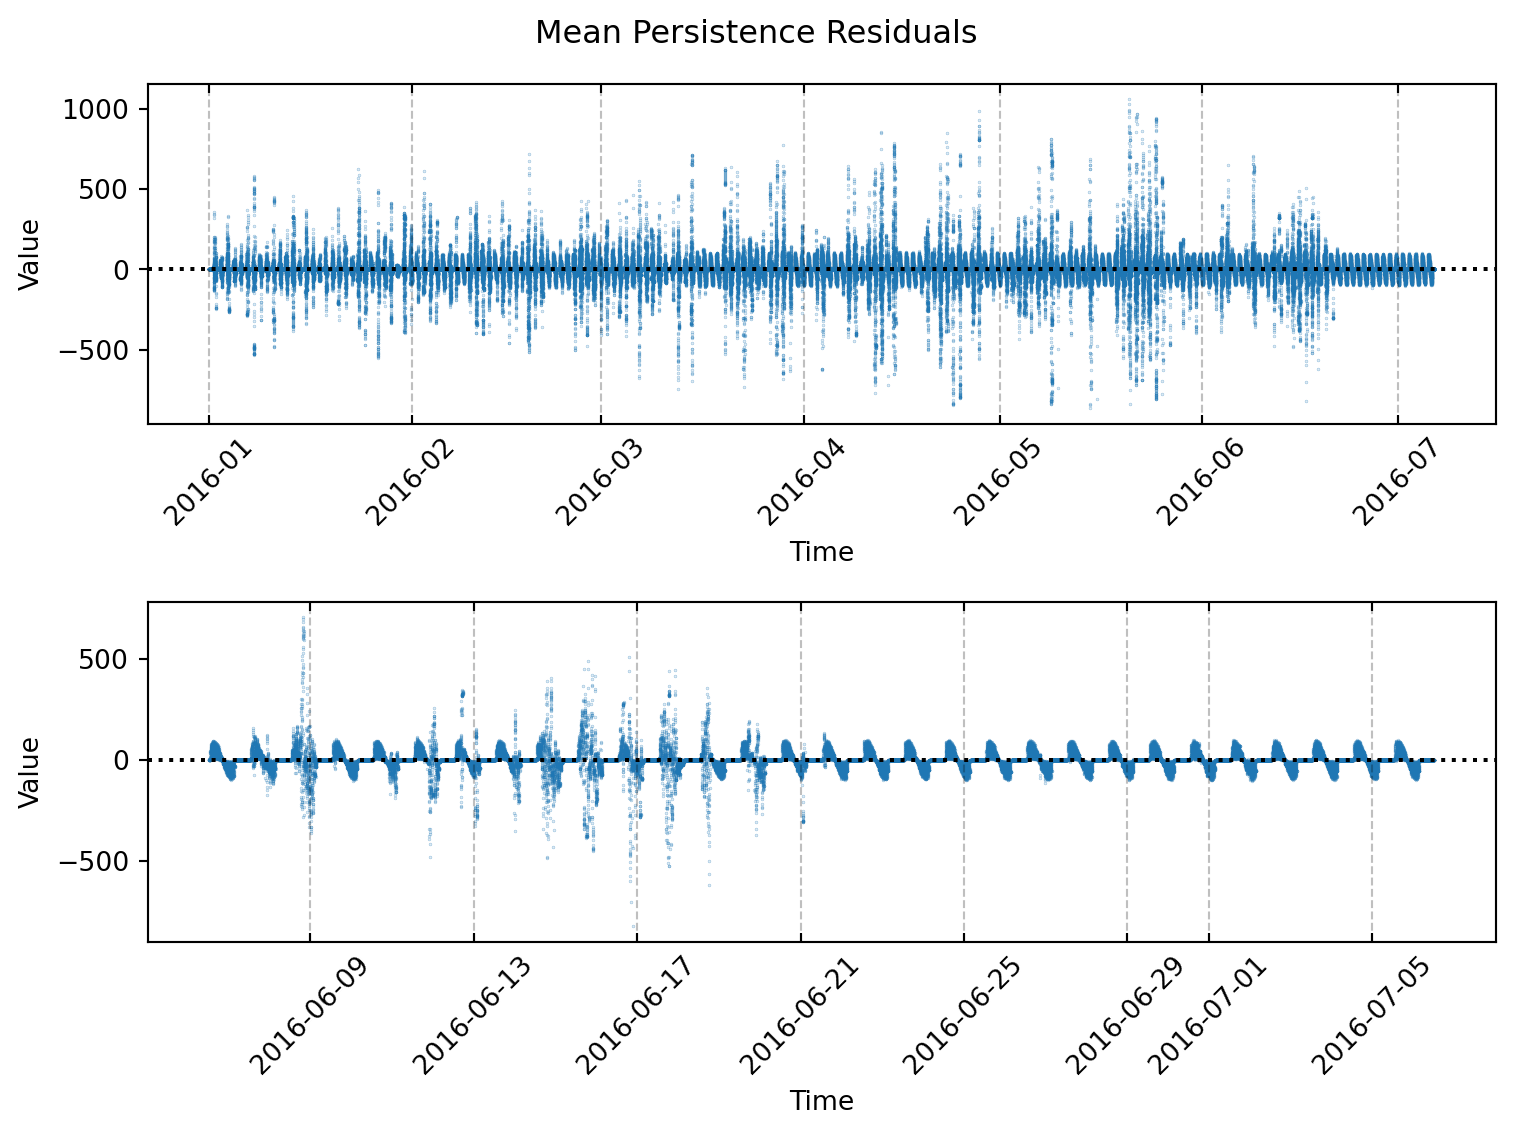

In [26]:
#| code-fold: true
#| code-summary: "Show supplementary code"
residual = (
    pd.Series(np.hstack(ground_truth) - np.hstack(forecasts))
)
residual.index = outsample_ghi_df.index[:len(np.hstack(ground_truth))]

fig, axs = plt.subplots(2, 1, figsize=(8, 6))

ax = visualize_time_series(
    ax=axs[0],
    time_series=residual,
    time_series_name="Residuals",
    s=0.05,
    alpha=0.5
)
ax=visualize_time_series(
    axs[1],
    time_series=residual[-(60 * 24 * 30):],
    time_series_name="Residuals",
    s=0.05,
    alpha=0.5
)


for ax in axs:
    ax.axhline(
        y=0,
        linestyle=":",
        c="k"
    )

plt.suptitle("Mean Persistence Residuals")
plt.tight_layout()
plt.show()

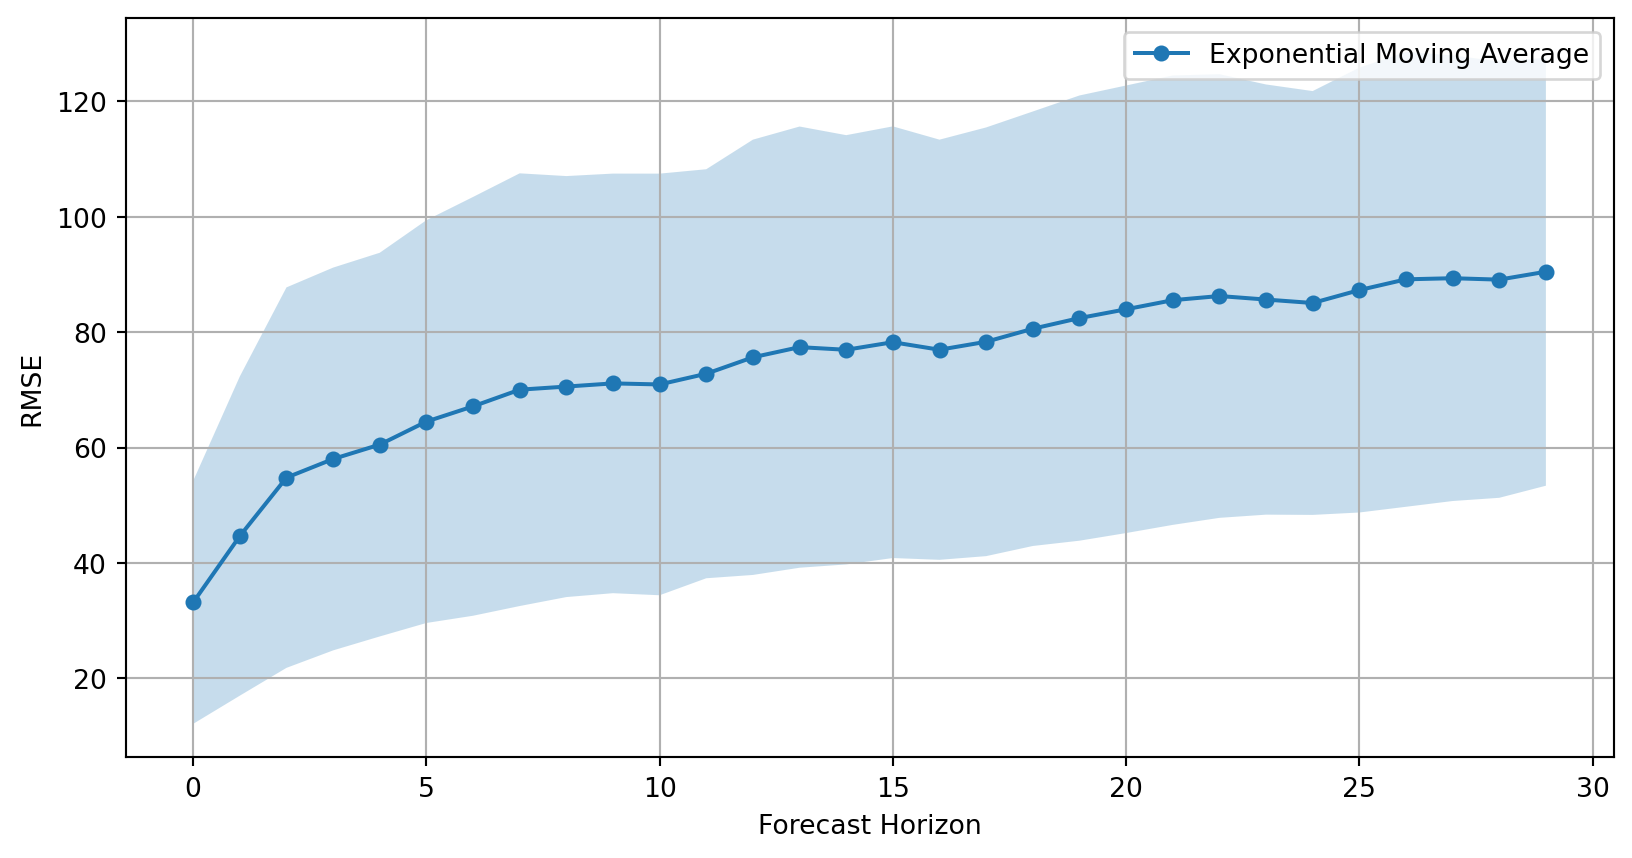

In [27]:
#| code-fold: true
#| code-summary: "Show supplementary code"
error_mean, error_sem = compute_rmse(
    y_true=np.array(ground_truth),
    y_forecast=np.array(forecasts),
    axis=0
)
MODELS_RESULTS["Exponential Moving Average"] = {"error_mean": error_mean, "error_sem": error_sem}

fig, ax = plt.subplots(1, 1, figsize=(10, 5))
ax = visualize_forecast_horizon_accuracy(
    ax=ax,
    model_name="Exponential Moving Average",
    error_name="RMSE",
    error_mean=error_mean,
    error_sem=error_sem,
    marker="o",
    markersize=5
)
plt.legend()
plt.show()

## IV - Gaussian Process Based Top-Down Forecast

$$
\hat{y}_{s_0 : S} \sim \mathcal{GP}(X)\\
\hat{y}_{S+1} = \boldsymbol{W}\hat{y}_{S}
$$


In [28]:
daily_ghi_df = (
    insample_ghi_df
    .groupby(["day_year", "hour", "minute"])["ghi"]
    .mean()
    .reset_index()
    .groupby(["day_year"])["ghi"]
    .sum()
    .reset_index()
    .rename(
        {
            "ghi": "daily_ghi"
        },
    axis=1
    )
    .set_index(
        pd.date_range(
            start="2015-01-01", 
            end="2015-12-31",
            freq="d"
        )
    )
)

# We create a weighting scheme for going from hours to minutes
weighting_df = pd.merge(
    insample_ghi_df.groupby(["day_year", "hour", "minute"])["ghi"].mean().reset_index(),
    daily_ghi_df,
    how="left",
    on=["day_year"]
)

weighting_df["weight_day_to_minute"] = (weighting_df["ghi"] / weighting_df["daily_ghi"]).fillna(0)
weighting_df = weighting_df[["day_year", "hour", "minute", "ghi", "weight_day_to_minute"]]

weighting_df.index = insample_ghi_df[insample_ghi_df["year"] == 2015].index

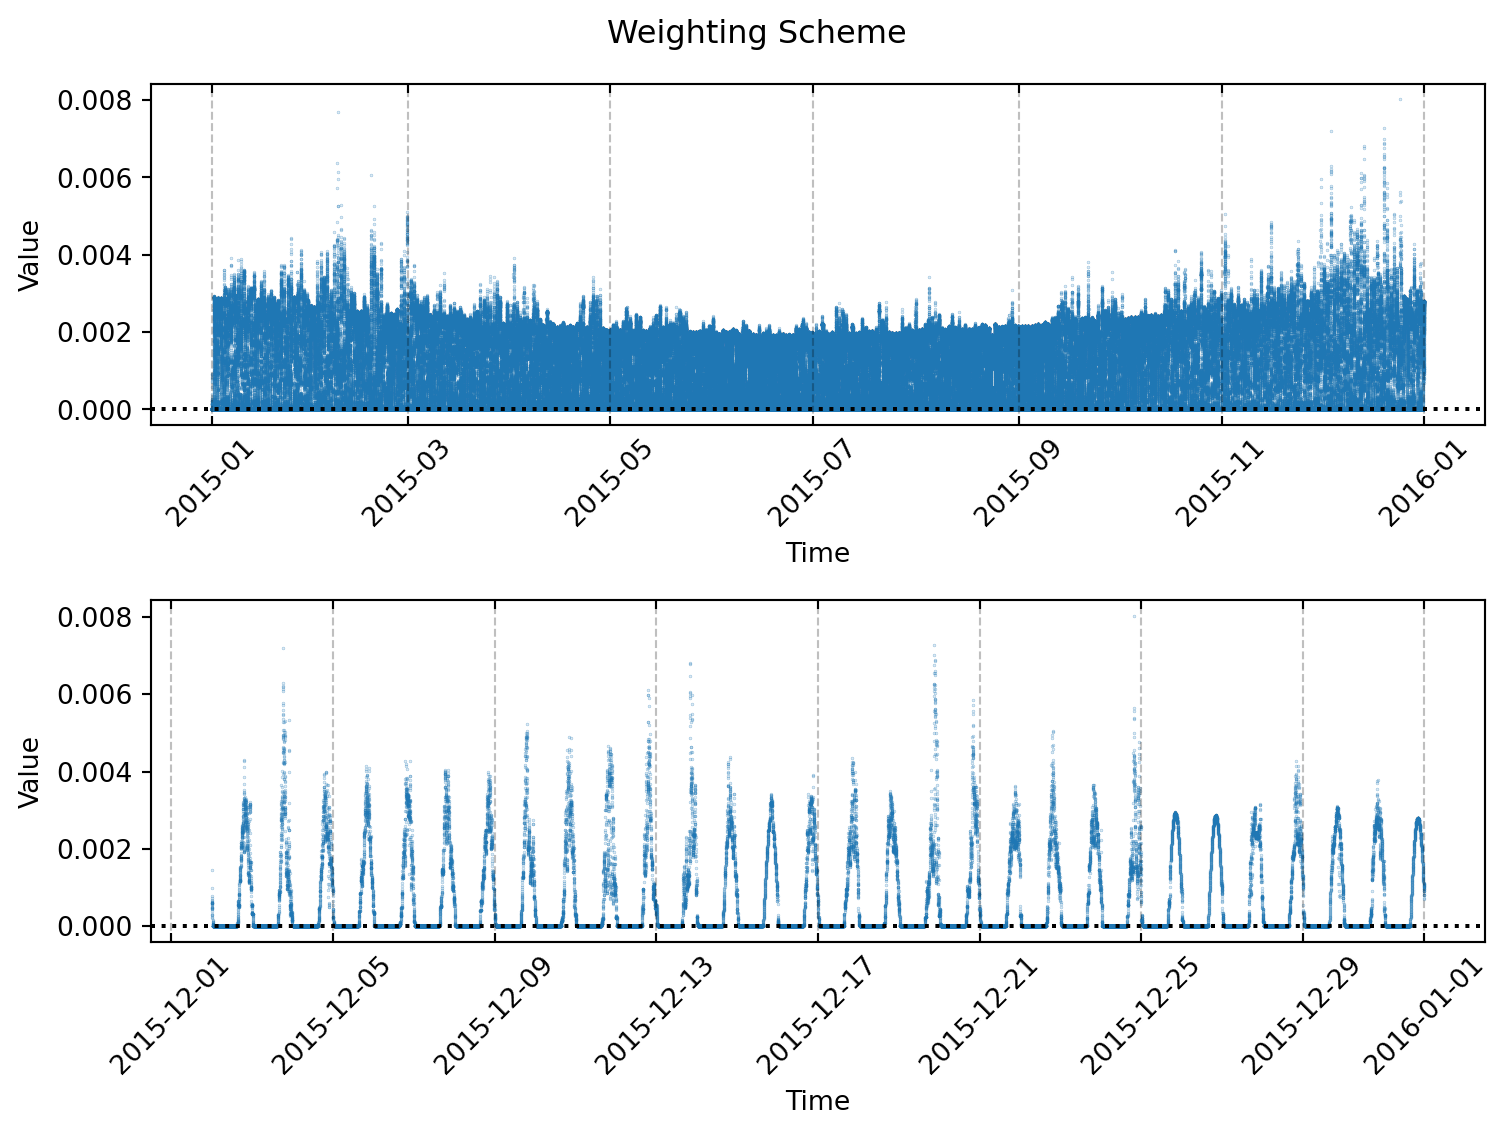

In [29]:
#| code-fold: true
#| code-summary: "Show supplementary code"
fig, axs = plt.subplots(2, 1, figsize=(8, 6))

ax = visualize_time_series(
    ax=axs[0],
    time_series=weighting_df["weight_day_to_minute"],
    time_series_name="Weighting Day-Minute",
    s=0.05,
    alpha=0.5
)
ax=visualize_time_series(
    axs[1],
    time_series=weighting_df["weight_day_to_minute"][-(60 * 24 * 30):],
    time_series_name="Weighting Day-Minute",
    s=0.05,
    alpha=0.5
)


for ax in axs:
    ax.axhline(
        y=0,
        linestyle=":",
        c="k"
    )

plt.suptitle("Weighting Scheme")
plt.tight_layout()
plt.show()

In [30]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ExpSineSquared, WhiteKernel

gaussian_process_scaler = StandardScaler()

yearly_seasonal_kernel = (
    ExpSineSquared(
        length_scale=1,
        periodicity=365.25, 
        periodicity_bounds="fixed"
    )
)
noise_kernel = (
    RBF(length_scale=30) + 
    WhiteKernel(
        noise_level=0.1**2, 
        noise_level_bounds=(1e-5, 1e5)
    )
)
gp_model = GaussianProcessRegressor(
    alpha=0.1,
    kernel=yearly_seasonal_kernel + noise_kernel,
    copy_X_train=False
)

y = (
    gaussian_process_scaler
    .fit_transform(daily_ghi_df["daily_ghi"].values.reshape(-1, 1))
    .flatten()
)
X = np.arange(len(y))


gp_model = gp_model.fit(X.reshape(-1, 1), y)
daily_ghi_df["estimated_daily_ghi"] = gaussian_process_scaler.inverse_transform(
    gp_model.predict(X.reshape(-1, 1)).reshape(-1, 1)
).flatten()

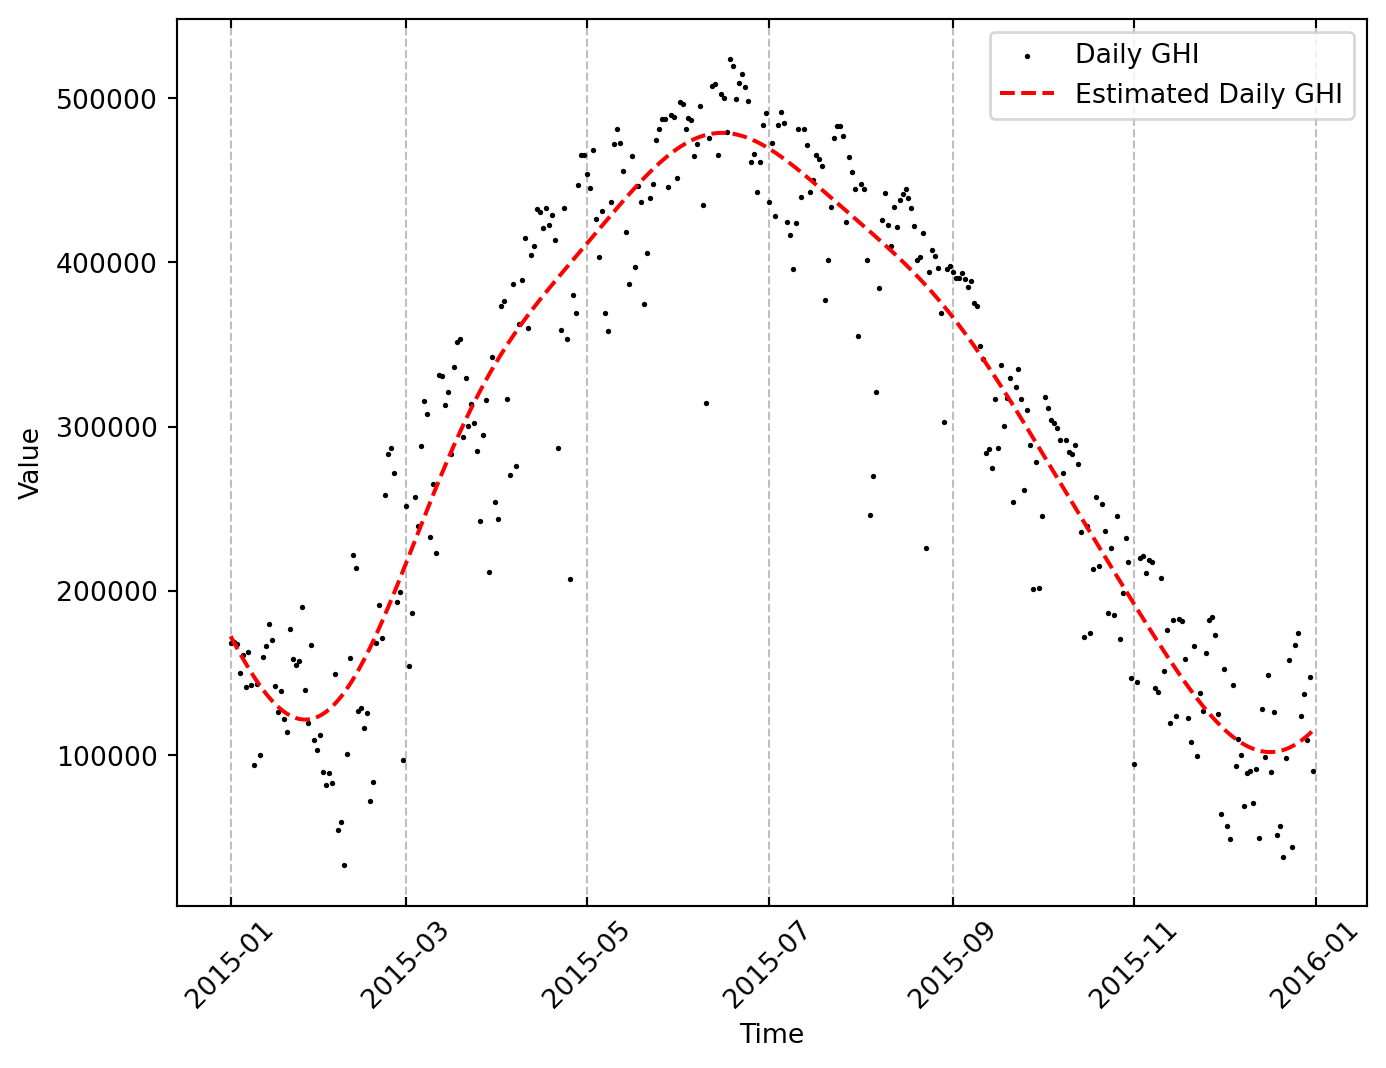

In [31]:
#| code-fold: true
#| code-summary: "Show supplementary code"
fig, ax = plt.subplots(1, 1, figsize=(8, 6))

ax = visualize_time_series(
    ax=ax,
    time_series=daily_ghi_df["daily_ghi"],
    time_series_name="Daily GHI",
    s=1,
    c="k"
)
ax.plot(
    daily_ghi_df["estimated_daily_ghi"].index,
    daily_ghi_df["estimated_daily_ghi"].values,
    label="Estimated Daily GHI",
    c="r",
    linestyle="--"
)
plt.legend()
plt.show()

In [32]:
estimated_minutely_ghi = (
    weighting_df[["day_year", "hour", "minute", "weight_day_to_minute"]]
    .merge(
        daily_ghi_df[["day_year", "estimated_daily_ghi"]],
        how="left",
        on="day_year"
    )
)
estimated_minutely_ghi["estimated_minutely_ghi"] = (
    estimated_minutely_ghi["estimated_daily_ghi"] * estimated_minutely_ghi["weight_day_to_minute"]
)
estimated_minutely_ghi = estimated_minutely_ghi[["day_year", "hour", "minute", "estimated_minutely_ghi"]]

outsample_forecast = (
    pd.merge(
        left=outsample_ghi_df[["day_year", "hour", "minute", "ghi"]],
        right=estimated_minutely_ghi,
        how="left",
        on=["day_year", "hour", "minute"]
    )
    .interpolate(method="linear", limit_direction="both")
)

outsample_forecast = outsample_forecast[["ghi", "estimated_minutely_ghi"]]
outsample_forecast.index = outsample_ghi_df.index

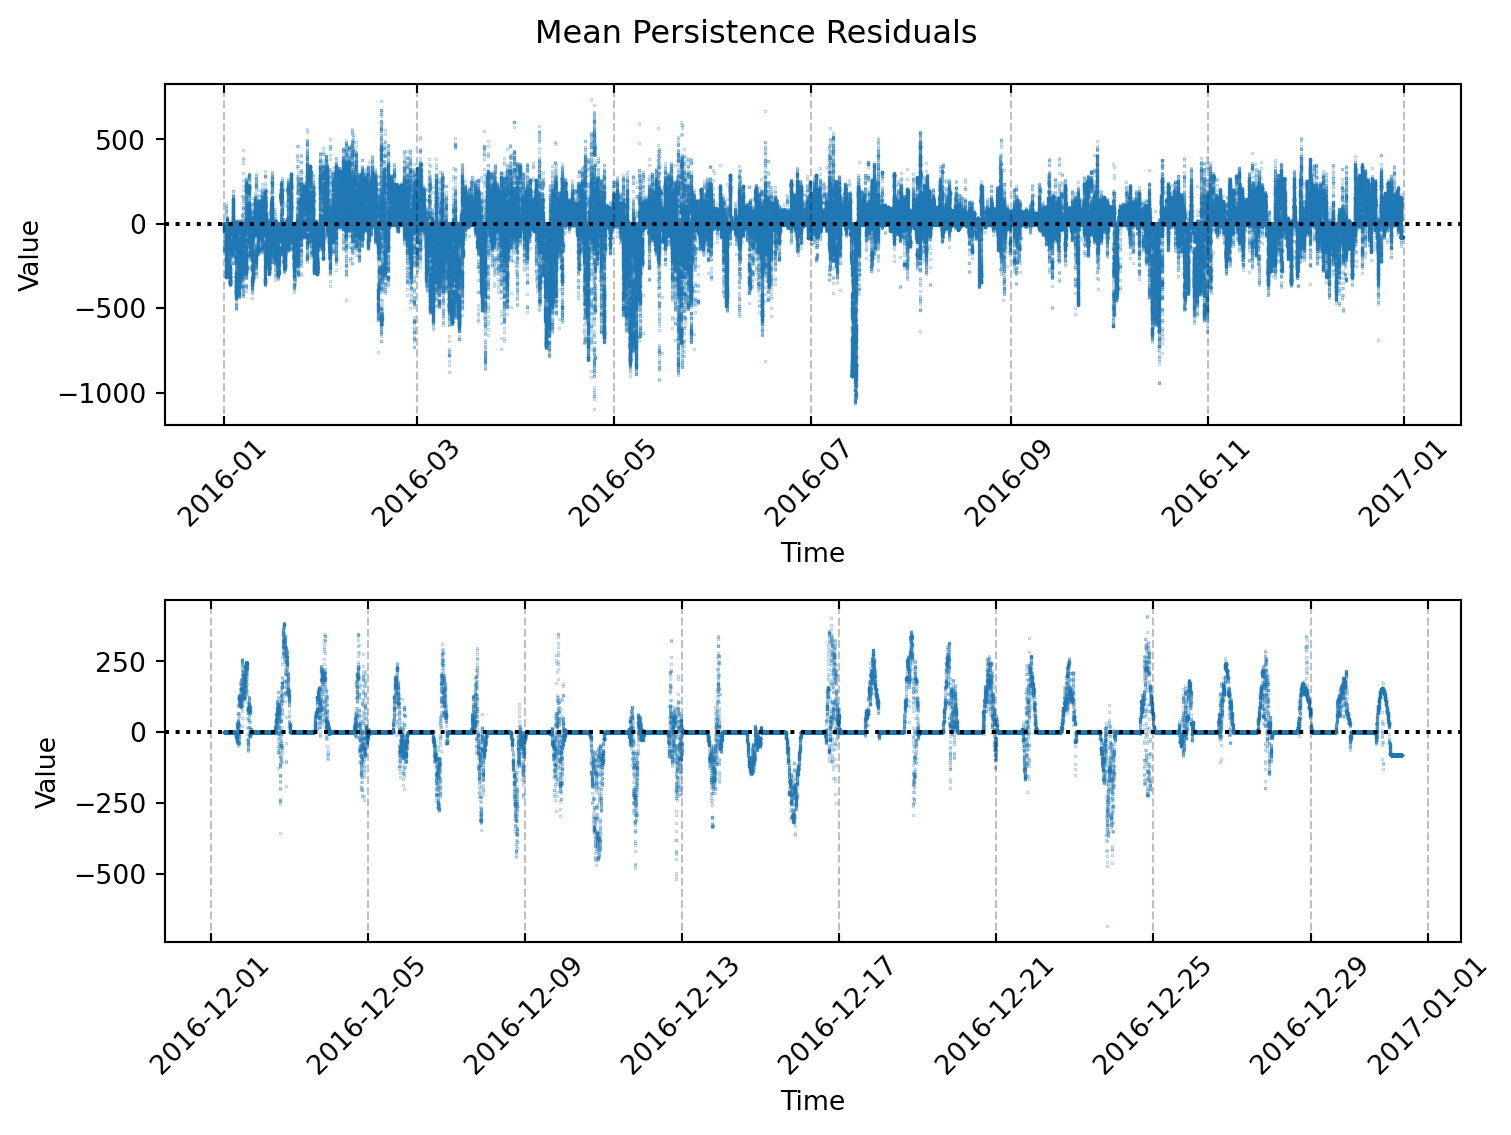

In [33]:
#| code-fold: true
#| code-summary: "Show supplementary code"
residual = (
    outsample_forecast["ghi"] - outsample_forecast["estimated_minutely_ghi"]
)

fig, axs = plt.subplots(2, 1, figsize=(8, 6))

ax = visualize_time_series(
    ax=axs[0],
    time_series=residual,
    time_series_name="Residuals",
    s=0.05,
    alpha=0.5
)
ax=visualize_time_series(
    axs[1],
    time_series=residual[-(60 * 24 * 30):],
    time_series_name="Residuals",
    s=0.05,
    alpha=0.5
)


for ax in axs:
    ax.axhline(
        y=0,
        linestyle=":",
        c="k"
    )

plt.suptitle("Mean Persistence Residuals")
plt.tight_layout()
plt.show()

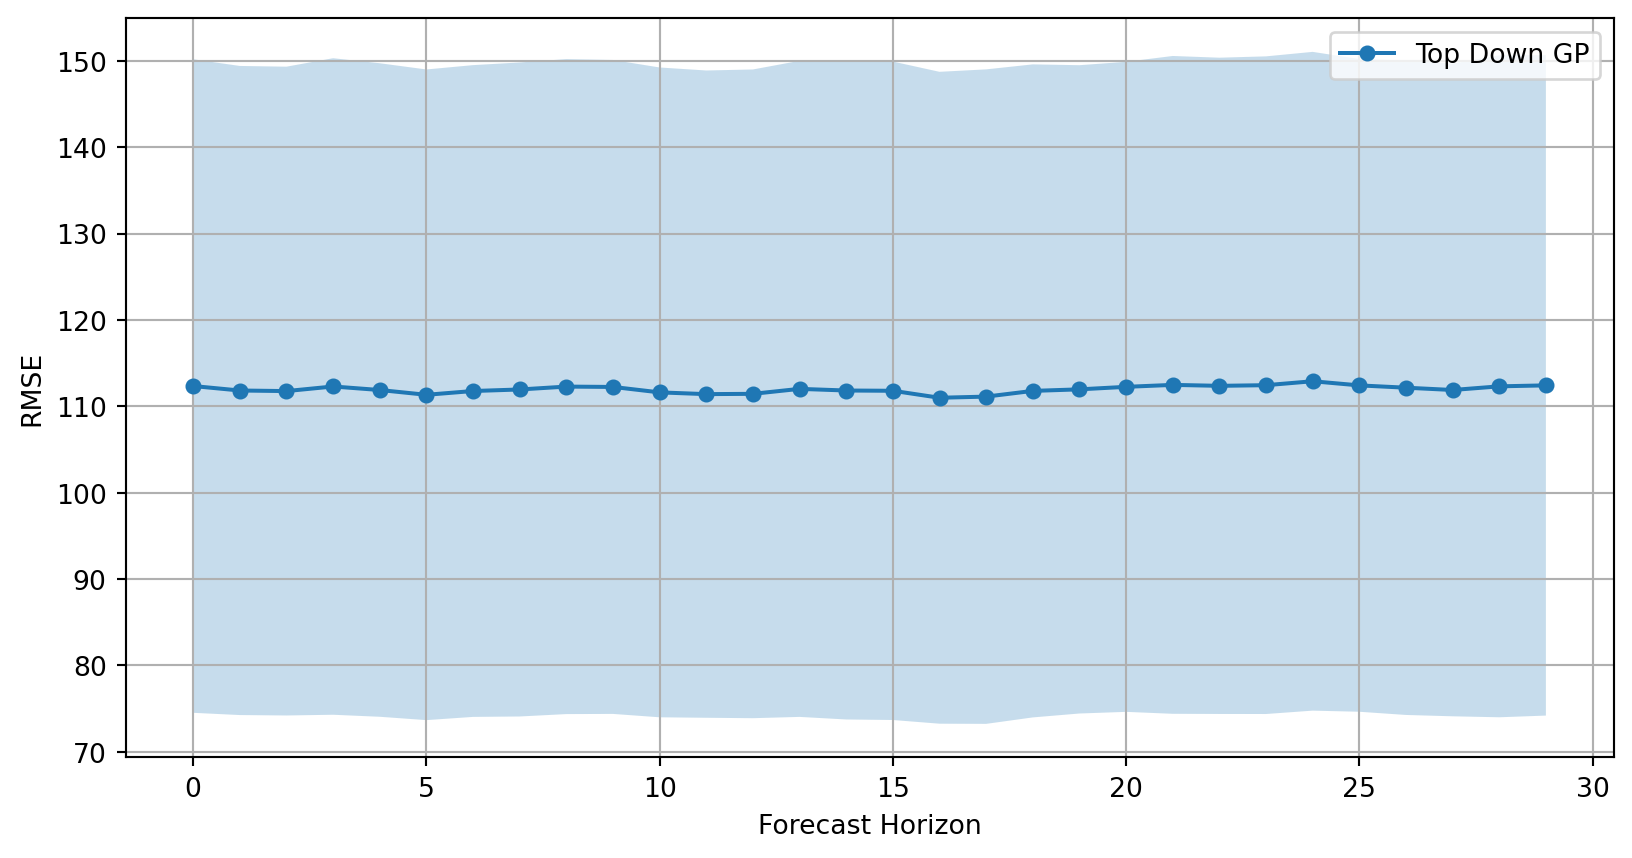

In [34]:
#| code-fold: true
#| code-summary: "Show supplementary code"
y_forecast = np.array(
    np.split(
        outsample_forecast["estimated_minutely_ghi"].values,      
        int(len(outsample_forecast["ghi"].values) / 30)
    )
)
y_true = np.array(
    np.split(
        outsample_forecast["ghi"].values,      
        int(len(outsample_forecast["ghi"].values) / 30)
    )
)

error_mean, error_sem = compute_rmse(
    y_true=y_true,
    y_forecast=y_forecast,
    axis=0
)
MODELS_RESULTS["Top Down GP"] = {"error_mean": error_mean, "error_sem": error_sem}

fig, ax = plt.subplots(1, 1, figsize=(10, 5))
ax = visualize_forecast_horizon_accuracy(
    ax=ax,
    model_name="Top Down GP",
    error_name="RMSE",
    error_mean=error_mean,
    error_sem=error_sem,
    marker="o",
    markersize=5
)
plt.legend()
plt.show()

## More Advanced Models


In [35]:
from torch.utils.data import  DataLoader
from modules.models.torch_backend.data_handlers import TimeseriesAutoregressiveDataset

AR_WINDOW = 100

insample_ghi_series = insample_ghi_df[insample_ghi_df.index <= "2015-01-02 08:00:00"]["ghi"].values
validation_ghi_series = insample_ghi_df[insample_ghi_df.index > "2015-01-02 08:00:00"]["ghi"].values

test_ghi_series = np.hstack([validation_ghi_series[-AR_WINDOW:],  outsample_ghi_df["ghi"].values])

insample_ar_dataset = TimeseriesAutoregressiveDataset(
    X=insample_ghi_series.astype("float32"),
    y=insample_ghi_series.astype("float32"),
    ar_window=AR_WINDOW,
    forecast_horizon=OUTSAMPLE_WINDOW_SIZE,
    gap=OUTSAMPLE_WINDOW_SIZE
)
validation_ar_dataset = TimeseriesAutoregressiveDataset(
    X=validation_ghi_series.astype("float32"),
    y=validation_ghi_series.astype("float32"),
    ar_window=AR_WINDOW,
    forecast_horizon=OUTSAMPLE_WINDOW_SIZE,
    gap=OUTSAMPLE_WINDOW_SIZE
)
test_ar_dataset = TimeseriesAutoregressiveDataset(
    X=test_ghi_series.astype("float32"),
    y=test_ghi_series.astype("float32"),
    ar_window=AR_WINDOW,
    forecast_horizon=OUTSAMPLE_WINDOW_SIZE,
    gap=OUTSAMPLE_WINDOW_SIZE
)

train_loader = DataLoader(
    insample_ar_dataset,
    batch_size=2048,
    shuffle=False
)
validation_loader = DataLoader(
    validation_ar_dataset,
    batch_size=2048,
    shuffle=False
)
test_loader = DataLoader(
    test_ar_dataset,
    batch_size=2048,
    shuffle=False
)

### I Regularized Auto Regressive Model


In [36]:
from torch.optim import Adam
from torch.nn import MSELoss

from modules.models.torch_backend.neural_networks.architectures import LinearModel, MLPModel
from modules.models.torch_backend.fitters import TorchModelFitter
from modules.models.torch_backend.callbacks import EarlyStopping


model = LinearModel(
    in_features=AR_WINDOW,
    out_features=OUTSAMPLE_WINDOW_SIZE,
    link_function="ReLU",
).to("cuda")
stopper = EarlyStopping(tolerance=100, min_delta=0.001)
fitter = TorchModelFitter()


model, optimizer, hisotry = fitter.fit(
    model=model,
    optimizer=Adam(model.parameters(), weight_decay=0.01),
    train_loader=train_loader,
    validation_loader=validation_loader,
    stopper=stopper,
    epochs=300,
    loss_function=MSELoss()
)

  0%|          | 0/300 [00:00<?, ?it/s]

Loss 68225.0192 - Validation Loss 41182.3429:   0%|          | 0/300 [00:00<?, ?it/s]

Loss 68225.0192 - Validation Loss 41182.3429:   0%|          | 1/300 [00:00<02:03,  2.43it/s]

Loss 31835.7707 - Validation Loss 27180.7531:   0%|          | 1/300 [00:00<02:03,  2.43it/s]

Loss 31835.7707 - Validation Loss 27180.7531:   1%|          | 2/300 [00:00<01:52,  2.64it/s]

Loss 25454.1831 - Validation Loss 20778.4338:   1%|          | 2/300 [00:01<01:52,  2.64it/s]

Loss 25454.1831 - Validation Loss 20778.4338:   1%|          | 3/300 [00:01<01:54,  2.60it/s]

Loss 18707.6118 - Validation Loss 17602.3908:   1%|          | 3/300 [00:01<01:54,  2.60it/s]

Loss 18707.6118 - Validation Loss 17602.3908:   1%|▏         | 4/300 [00:01<01:59,  2.48it/s]

Loss 17556.6708 - Validation Loss 17113.6268:   1%|▏         | 4/300 [00:01<01:59,  2.48it/s]

Loss 17556.6708 - Validation Loss 17113.6268:   2%|▏         | 5/300 [00:01<01:55,  2.56it/s]

Loss 15874.7452 - Validation Loss 12864.0495:   2%|▏         | 5/300 [00:02<01:55,  2.56it/s]

Loss 15874.7452 - Validation Loss 12864.0495:   2%|▏         | 6/300 [00:02<01:52,  2.62it/s]

Loss 11961.1634 - Validation Loss 12216.8001:   2%|▏         | 6/300 [00:02<01:52,  2.62it/s]

Loss 11961.1634 - Validation Loss 12216.8001:   2%|▏         | 7/300 [00:02<01:50,  2.66it/s]

Loss 11856.9536 - Validation Loss 11377.8257:   2%|▏         | 7/300 [00:03<01:50,  2.66it/s]

Loss 11856.9536 - Validation Loss 11377.8257:   3%|▎         | 8/300 [00:03<02:12,  2.20it/s]

Loss 10980.4784 - Validation Loss 11002.7952:   3%|▎         | 8/300 [00:03<02:12,  2.20it/s]

Loss 10980.4784 - Validation Loss 11002.7952:   3%|▎         | 9/300 [00:03<02:14,  2.16it/s]

Loss 10686.8437 - Validation Loss 10503.5924:   3%|▎         | 9/300 [00:04<02:14,  2.16it/s]

Loss 10686.8437 - Validation Loss 10503.5924:   3%|▎         | 10/300 [00:04<02:12,  2.19it/s]

Loss 10236.7326 - Validation Loss 10169.844:   3%|▎         | 10/300 [00:04<02:12,  2.19it/s] 

Loss 10236.7326 - Validation Loss 10169.844:   4%|▎         | 11/300 [00:04<02:07,  2.26it/s]

Loss 9876.1171 - Validation Loss 9877.6278:   4%|▎         | 11/300 [00:05<02:07,  2.26it/s] 

Loss 9876.1171 - Validation Loss 9877.6278:   4%|▍         | 12/300 [00:05<02:05,  2.30it/s]

Loss 8956.7209 - Validation Loss 6143.0668:   4%|▍         | 12/300 [00:05<02:05,  2.30it/s]

Loss 8956.7209 - Validation Loss 6143.0668:   4%|▍         | 13/300 [00:05<01:51,  2.57it/s]

Loss 5704.9763 - Validation Loss 6058.6104:   4%|▍         | 13/300 [00:05<01:51,  2.57it/s]

Loss 5704.9763 - Validation Loss 6058.6104:   5%|▍         | 14/300 [00:05<01:51,  2.56it/s]

Loss 5601.542 - Validation Loss 5482.3954:   5%|▍         | 14/300 [00:06<01:51,  2.56it/s] 

Loss 5601.542 - Validation Loss 5482.3954:   5%|▌         | 15/300 [00:06<01:55,  2.46it/s]

Loss 5290.2615 - Validation Loss 5278.7204:   5%|▌         | 15/300 [00:06<01:55,  2.46it/s]

Loss 5290.2615 - Validation Loss 5278.7204:   5%|▌         | 16/300 [00:06<01:49,  2.60it/s]

Loss 4988.4419 - Validation Loss 5136.2266:   5%|▌         | 16/300 [00:06<01:49,  2.60it/s]

Loss 4988.4419 - Validation Loss 5136.2266:   6%|▌         | 17/300 [00:06<01:51,  2.54it/s]

Loss 4846.6027 - Validation Loss 4988.3298:   6%|▌         | 17/300 [00:07<01:51,  2.54it/s]

Loss 4846.6027 - Validation Loss 4988.3298:   6%|▌         | 18/300 [00:07<01:44,  2.69it/s]

Loss 4730.3146 - Validation Loss 4908.9555:   6%|▌         | 18/300 [00:07<01:44,  2.69it/s]

Loss 4730.3146 - Validation Loss 4908.9555:   6%|▋         | 19/300 [00:07<01:40,  2.79it/s]

Loss 4632.6023 - Validation Loss 4848.5809:   6%|▋         | 19/300 [00:07<01:40,  2.79it/s]

Loss 4632.6023 - Validation Loss 4848.5809:   7%|▋         | 20/300 [00:07<01:37,  2.88it/s]

Loss 4596.8094 - Validation Loss 4787.1028:   7%|▋         | 20/300 [00:08<01:37,  2.88it/s]

Loss 4596.8094 - Validation Loss 4787.1028:   7%|▋         | 21/300 [00:08<01:34,  2.94it/s]

Loss 4562.823 - Validation Loss 4723.5183:   7%|▋         | 21/300 [00:08<01:34,  2.94it/s] 

Loss 4562.823 - Validation Loss 4723.5183:   7%|▋         | 22/300 [00:08<01:33,  2.97it/s]

Loss 4526.358 - Validation Loss 4644.7161:   7%|▋         | 22/300 [00:08<01:33,  2.97it/s]

Loss 4526.358 - Validation Loss 4644.7161:   8%|▊         | 23/300 [00:08<01:32,  3.00it/s]

Loss 4470.8247 - Validation Loss 4655.1724:   8%|▊         | 23/300 [00:09<01:32,  3.00it/s]

Loss 4470.8247 - Validation Loss 4655.1724:   8%|▊         | 24/300 [00:09<01:32,  3.00it/s]

Loss 4423.0483 - Validation Loss 4619.5895:   8%|▊         | 24/300 [00:09<01:32,  3.00it/s]

Loss 4423.0483 - Validation Loss 4619.5895:   8%|▊         | 25/300 [00:09<01:40,  2.73it/s]

Loss 4447.6314 - Validation Loss 4621.2727:   8%|▊         | 25/300 [00:09<01:40,  2.73it/s]

Loss 4447.6314 - Validation Loss 4621.2727:   9%|▊         | 26/300 [00:09<01:38,  2.79it/s]

Loss 4423.7358 - Validation Loss 4522.5121:   9%|▊         | 26/300 [00:10<01:38,  2.79it/s]

Loss 4423.7358 - Validation Loss 4522.5121:   9%|▉         | 27/300 [00:10<01:49,  2.50it/s]

Loss 4429.7269 - Validation Loss 4377.3856:   9%|▉         | 27/300 [00:10<01:49,  2.50it/s]

Loss 4429.7269 - Validation Loss 4377.3856:   9%|▉         | 28/300 [00:10<01:55,  2.35it/s]

Loss 4315.0736 - Validation Loss 4193.264:   9%|▉         | 28/300 [00:11<01:55,  2.35it/s] 

Loss 4315.0736 - Validation Loss 4193.264:  10%|▉         | 29/300 [00:11<01:48,  2.50it/s]

Loss 4139.0157 - Validation Loss 4108.8318:  10%|▉         | 29/300 [00:11<01:48,  2.50it/s]

Loss 4139.0157 - Validation Loss 4108.8318:  10%|█         | 30/300 [00:11<01:40,  2.68it/s]

Loss 3967.6201 - Validation Loss 4097.1559:  10%|█         | 30/300 [00:12<01:40,  2.68it/s]

Loss 3967.6201 - Validation Loss 4097.1559:  10%|█         | 31/300 [00:12<01:42,  2.62it/s]

Loss 3896.3237 - Validation Loss 4086.0701:  10%|█         | 31/300 [00:12<01:42,  2.62it/s]

Loss 3896.3237 - Validation Loss 4086.0701:  11%|█         | 32/300 [00:12<01:41,  2.63it/s]

Loss 3884.7771 - Validation Loss 4114.2878:  11%|█         | 32/300 [00:12<01:41,  2.63it/s]

Loss 3884.7771 - Validation Loss 4114.2878:  11%|█         | 33/300 [00:12<01:40,  2.67it/s]

Loss 3884.5954 - Validation Loss 4139.7596:  11%|█         | 33/300 [00:13<01:40,  2.67it/s]

Loss 3884.5954 - Validation Loss 4139.7596:  11%|█▏        | 34/300 [00:13<01:47,  2.47it/s]

Loss 3917.4333 - Validation Loss 4249.3673:  11%|█▏        | 34/300 [00:13<01:47,  2.47it/s]

Loss 3917.4333 - Validation Loss 4249.3673:  12%|█▏        | 35/300 [00:13<01:43,  2.56it/s]

Loss 3964.3209 - Validation Loss 4373.7988:  12%|█▏        | 35/300 [00:13<01:43,  2.56it/s]

Loss 3964.3209 - Validation Loss 4373.7988:  12%|█▏        | 36/300 [00:13<01:40,  2.63it/s]

Loss 4089.0021 - Validation Loss 4603.4067:  12%|█▏        | 36/300 [00:14<01:40,  2.63it/s]

Loss 4089.0021 - Validation Loss 4603.4067:  12%|█▏        | 37/300 [00:14<01:33,  2.81it/s]

Loss 4257.9634 - Validation Loss 4754.654:  12%|█▏        | 37/300 [00:14<01:33,  2.81it/s] 

Loss 4257.9634 - Validation Loss 4754.654:  13%|█▎        | 38/300 [00:14<01:30,  2.90it/s]

Loss 4514.9791 - Validation Loss 4850.52:  13%|█▎        | 38/300 [00:14<01:30,  2.90it/s] 

Loss 4514.9791 - Validation Loss 4850.52:  13%|█▎        | 39/300 [00:14<01:28,  2.94it/s]

Loss 4667.7828 - Validation Loss 4836.3805:  13%|█▎        | 39/300 [00:15<01:28,  2.94it/s]

Loss 4667.7828 - Validation Loss 4836.3805:  13%|█▎        | 40/300 [00:15<01:27,  2.96it/s]

Loss 4773.2097 - Validation Loss 4726.0409:  13%|█▎        | 40/300 [00:15<01:27,  2.96it/s]

Loss 4773.2097 - Validation Loss 4726.0409:  14%|█▎        | 41/300 [00:15<01:37,  2.64it/s]

Loss 4744.9916 - Validation Loss 4494.927:  14%|█▎        | 41/300 [00:16<01:37,  2.64it/s] 

Loss 4744.9916 - Validation Loss 4494.927:  14%|█▍        | 42/300 [00:16<01:55,  2.24it/s]

Loss 4601.5138 - Validation Loss 4210.8221:  14%|█▍        | 42/300 [00:16<01:55,  2.24it/s]

Loss 4601.5138 - Validation Loss 4210.8221:  14%|█▍        | 43/300 [00:16<01:55,  2.23it/s]

Loss 4320.6516 - Validation Loss 4010.3781:  14%|█▍        | 43/300 [00:17<01:55,  2.23it/s]

Loss 4320.6516 - Validation Loss 4010.3781:  15%|█▍        | 44/300 [00:17<01:54,  2.24it/s]

Loss 4001.9152 - Validation Loss 3918.2545:  15%|█▍        | 44/300 [00:17<01:54,  2.24it/s]

Loss 4001.9152 - Validation Loss 3918.2545:  15%|█▌        | 45/300 [00:17<01:52,  2.26it/s]

Loss 3810.8968 - Validation Loss 3898.4551:  15%|█▌        | 45/300 [00:18<01:52,  2.26it/s]

Loss 3810.8968 - Validation Loss 3898.4551:  15%|█▌        | 46/300 [00:18<01:50,  2.29it/s]

Loss 3716.1911 - Validation Loss 3904.9138:  15%|█▌        | 46/300 [00:18<01:50,  2.29it/s]

Loss 3716.1911 - Validation Loss 3904.9138:  16%|█▌        | 47/300 [00:18<01:38,  2.57it/s]

Loss 3698.6329 - Validation Loss 3903.0856:  16%|█▌        | 47/300 [00:18<01:38,  2.57it/s]

Loss 3698.6329 - Validation Loss 3903.0856:  16%|█▌        | 48/300 [00:18<01:32,  2.72it/s]

Loss 3698.6649 - Validation Loss 3937.295:  16%|█▌        | 48/300 [00:18<01:32,  2.72it/s] 

Loss 3698.6649 - Validation Loss 3937.295:  16%|█▋        | 49/300 [00:18<01:27,  2.87it/s]

Loss 3706.9124 - Validation Loss 3967.1673:  16%|█▋        | 49/300 [00:19<01:27,  2.87it/s]

Loss 3706.9124 - Validation Loss 3967.1673:  17%|█▋        | 50/300 [00:19<01:24,  2.95it/s]

Loss 3733.2513 - Validation Loss 4071.5281:  17%|█▋        | 50/300 [00:19<01:24,  2.95it/s]

Loss 3733.2513 - Validation Loss 4071.5281:  17%|█▋        | 51/300 [00:19<01:31,  2.72it/s]

Loss 3783.3322 - Validation Loss 4177.0702:  17%|█▋        | 51/300 [00:20<01:31,  2.72it/s]

Loss 3783.3322 - Validation Loss 4177.0702:  17%|█▋        | 52/300 [00:20<01:29,  2.78it/s]

Loss 3888.6079 - Validation Loss 4340.9466:  17%|█▋        | 52/300 [00:20<01:29,  2.78it/s]

Loss 3888.6079 - Validation Loss 4340.9466:  18%|█▊        | 53/300 [00:20<01:27,  2.83it/s]

Loss 4046.536 - Validation Loss 4317.2387:  18%|█▊        | 53/300 [00:20<01:27,  2.83it/s] 

Loss 4046.536 - Validation Loss 4317.2387:  18%|█▊        | 54/300 [00:20<01:42,  2.40it/s]

Loss 4208.3725 - Validation Loss 4108.6137:  18%|█▊        | 54/300 [00:21<01:42,  2.40it/s]

Loss 4208.3725 - Validation Loss 4108.6137:  18%|█▊        | 55/300 [00:21<01:34,  2.61it/s]

Loss 4125.5964 - Validation Loss 3891.0496:  18%|█▊        | 55/300 [00:21<01:34,  2.61it/s]

Loss 4125.5964 - Validation Loss 3891.0496:  19%|█▊        | 56/300 [00:21<01:29,  2.73it/s]

Loss 3877.708 - Validation Loss 3829.7127:  19%|█▊        | 56/300 [00:21<01:29,  2.73it/s] 

Loss 3877.708 - Validation Loss 3829.7127:  19%|█▉        | 57/300 [00:21<01:29,  2.72it/s]

Loss 3687.5944 - Validation Loss 3850.5425:  19%|█▉        | 57/300 [00:22<01:29,  2.72it/s]

Loss 3687.5944 - Validation Loss 3850.5425:  19%|█▉        | 58/300 [00:22<01:37,  2.49it/s]

Loss 3632.0286 - Validation Loss 3860.7013:  19%|█▉        | 58/300 [00:23<01:37,  2.49it/s]

Loss 3632.0286 - Validation Loss 3860.7013:  20%|█▉        | 59/300 [00:23<01:54,  2.10it/s]

Loss 3652.6988 - Validation Loss 3905.817:  20%|█▉        | 59/300 [00:23<01:54,  2.10it/s] 

Loss 3652.6988 - Validation Loss 3905.817:  20%|██        | 60/300 [00:23<01:54,  2.10it/s]

Loss 3670.1654 - Validation Loss 3945.7689:  20%|██        | 60/300 [00:23<01:54,  2.10it/s]

Loss 3670.1654 - Validation Loss 3945.7689:  20%|██        | 61/300 [00:23<01:42,  2.33it/s]

Loss 3731.5304 - Validation Loss 4036.4812:  20%|██        | 61/300 [00:24<01:42,  2.33it/s]

Loss 3731.5304 - Validation Loss 4036.4812:  21%|██        | 62/300 [00:24<01:37,  2.44it/s]

Loss 3787.1391 - Validation Loss 4107.8316:  21%|██        | 62/300 [00:24<01:37,  2.44it/s]

Loss 3787.1391 - Validation Loss 4107.8316:  21%|██        | 63/300 [00:24<01:36,  2.46it/s]

Loss 3903.2802 - Validation Loss 4183.8457:  21%|██        | 63/300 [00:25<01:36,  2.46it/s]

Loss 3903.2802 - Validation Loss 4183.8457:  21%|██▏       | 64/300 [00:25<01:36,  2.45it/s]

Loss 3978.7675 - Validation Loss 4246.6262:  21%|██▏       | 64/300 [00:25<01:36,  2.45it/s]

Loss 3978.7675 - Validation Loss 4246.6262:  22%|██▏       | 65/300 [00:25<01:33,  2.51it/s]

Loss 4066.2076 - Validation Loss 4359.1125:  22%|██▏       | 65/300 [00:25<01:33,  2.51it/s]

Loss 4066.2076 - Validation Loss 4359.1125:  22%|██▏       | 66/300 [00:25<01:25,  2.72it/s]

Loss 4132.999 - Validation Loss 4587.7162:  22%|██▏       | 66/300 [00:26<01:25,  2.72it/s] 

Loss 4132.999 - Validation Loss 4587.7162:  22%|██▏       | 67/300 [00:26<01:23,  2.79it/s]

Loss 4296.3349 - Validation Loss 4748.6895:  22%|██▏       | 67/300 [00:26<01:23,  2.79it/s]

Loss 4296.3349 - Validation Loss 4748.6895:  23%|██▎       | 68/300 [00:26<01:31,  2.54it/s]

Loss 4583.06 - Validation Loss 4678.4982:  23%|██▎       | 68/300 [00:26<01:31,  2.54it/s]  

Loss 4583.06 - Validation Loss 4678.4982:  23%|██▎       | 69/300 [00:26<01:27,  2.63it/s]

Loss 4713.6675 - Validation Loss 4328.4689:  23%|██▎       | 69/300 [00:27<01:27,  2.63it/s]

Loss 4713.6675 - Validation Loss 4328.4689:  23%|██▎       | 70/300 [00:27<01:24,  2.71it/s]

Loss 4550.4722 - Validation Loss 4143.8228:  23%|██▎       | 70/300 [00:27<01:24,  2.71it/s]

Loss 4550.4722 - Validation Loss 4143.8228:  24%|██▎       | 71/300 [00:27<01:21,  2.80it/s]

Loss 4163.4865 - Validation Loss 4131.3808:  24%|██▎       | 71/300 [00:27<01:21,  2.80it/s]

Loss 4163.4865 - Validation Loss 4131.3808:  24%|██▍       | 72/300 [00:27<01:20,  2.84it/s]

Loss 4024.3392 - Validation Loss 4219.1217:  24%|██▍       | 72/300 [00:28<01:20,  2.84it/s]

Loss 4024.3392 - Validation Loss 4219.1217:  24%|██▍       | 73/300 [00:28<01:19,  2.87it/s]

Loss 3993.9861 - Validation Loss 4310.8239:  24%|██▍       | 73/300 [00:28<01:19,  2.87it/s]

Loss 3993.9861 - Validation Loss 4310.8239:  25%|██▍       | 74/300 [00:28<01:17,  2.91it/s]

Loss 4082.0122 - Validation Loss 4531.2108:  25%|██▍       | 74/300 [00:28<01:17,  2.91it/s]

Loss 4082.0122 - Validation Loss 4531.2108:  25%|██▌       | 75/300 [00:28<01:16,  2.92it/s]

Loss 4175.1742 - Validation Loss 4861.012:  25%|██▌       | 75/300 [00:29<01:16,  2.92it/s] 

Loss 4175.1742 - Validation Loss 4861.012:  25%|██▌       | 76/300 [00:29<01:24,  2.66it/s]

Loss 4469.8467 - Validation Loss 5093.81:  25%|██▌       | 76/300 [00:29<01:24,  2.66it/s] 

Loss 4469.8467 - Validation Loss 5093.81:  26%|██▌       | 77/300 [00:29<01:22,  2.71it/s]

Loss 4862.9386 - Validation Loss 4882.1833:  26%|██▌       | 77/300 [00:30<01:22,  2.71it/s]

Loss 4862.9386 - Validation Loss 4882.1833:  26%|██▌       | 78/300 [00:30<01:20,  2.76it/s]

Loss 5026.9443 - Validation Loss 4527.6166:  26%|██▌       | 78/300 [00:30<01:20,  2.76it/s]

Loss 5026.9443 - Validation Loss 4527.6166:  26%|██▋       | 79/300 [00:30<01:17,  2.85it/s]

Loss 4684.9109 - Validation Loss 4449.3125:  26%|██▋       | 79/300 [00:30<01:17,  2.85it/s]

Loss 4684.9109 - Validation Loss 4449.3125:  27%|██▋       | 80/300 [00:30<01:15,  2.90it/s]

Loss 4390.6174 - Validation Loss 4662.8845:  27%|██▋       | 80/300 [00:31<01:15,  2.90it/s]

Loss 4390.6174 - Validation Loss 4662.8845:  27%|██▋       | 81/300 [00:31<01:15,  2.92it/s]

Loss 4375.4275 - Validation Loss 4772.9409:  27%|██▋       | 81/300 [00:31<01:15,  2.92it/s]

Loss 4375.4275 - Validation Loss 4772.9409:  27%|██▋       | 82/300 [00:31<01:20,  2.71it/s]

Loss 4610.0968 - Validation Loss 4805.3902:  27%|██▋       | 82/300 [00:31<01:20,  2.71it/s]

Loss 4610.0968 - Validation Loss 4805.3902:  28%|██▊       | 83/300 [00:31<01:26,  2.52it/s]

Loss 4680.5041 - Validation Loss 4747.5792:  28%|██▊       | 83/300 [00:32<01:26,  2.52it/s]

Loss 4680.5041 - Validation Loss 4747.5792:  28%|██▊       | 84/300 [00:32<01:27,  2.46it/s]

Loss 4756.226 - Validation Loss 4592.7577:  28%|██▊       | 84/300 [00:32<01:27,  2.46it/s] 

Loss 4756.226 - Validation Loss 4592.7577:  28%|██▊       | 85/300 [00:32<01:38,  2.19it/s]

Loss 4626.481 - Validation Loss 4528.9153:  28%|██▊       | 85/300 [00:33<01:38,  2.19it/s]

Loss 4626.481 - Validation Loss 4528.9153:  29%|██▊       | 86/300 [00:33<01:31,  2.33it/s]

Loss 4515.0292 - Validation Loss 4465.9086:  29%|██▊       | 86/300 [00:33<01:31,  2.33it/s]

Loss 4515.0292 - Validation Loss 4465.9086:  29%|██▉       | 87/300 [00:33<01:31,  2.34it/s]

Loss 4395.3873 - Validation Loss 4649.9777:  29%|██▉       | 87/300 [00:34<01:31,  2.34it/s]

Loss 4395.3873 - Validation Loss 4649.9777:  29%|██▉       | 88/300 [00:34<01:32,  2.29it/s]

Loss 4411.2104 - Validation Loss 4793.6991:  29%|██▉       | 88/300 [00:34<01:32,  2.29it/s]

Loss 4411.2104 - Validation Loss 4793.6991:  30%|██▉       | 89/300 [00:34<01:32,  2.27it/s]

Loss 4638.3377 - Validation Loss 4828.2141:  30%|██▉       | 89/300 [00:35<01:32,  2.27it/s]

Loss 4638.3377 - Validation Loss 4828.2141:  30%|███       | 90/300 [00:35<01:33,  2.25it/s]

Loss 4763.9307 - Validation Loss 4684.724:  30%|███       | 90/300 [00:35<01:33,  2.25it/s] 

Loss 4763.9307 - Validation Loss 4684.724:  30%|███       | 91/300 [00:35<01:23,  2.50it/s]

Loss 4741.8854 - Validation Loss 4806.1922:  30%|███       | 91/300 [00:35<01:23,  2.50it/s]

Loss 4741.8854 - Validation Loss 4806.1922:  31%|███       | 92/300 [00:35<01:20,  2.59it/s]

Loss 4588.0458 - Validation Loss 5237.9165:  31%|███       | 92/300 [00:36<01:20,  2.59it/s]

Loss 4588.0458 - Validation Loss 5237.9165:  31%|███       | 93/300 [00:36<01:23,  2.49it/s]

Loss 4815.7131 - Validation Loss 5752.3743:  31%|███       | 93/300 [00:36<01:23,  2.49it/s]

Loss 4815.7131 - Validation Loss 5752.3743:  31%|███▏      | 94/300 [00:36<01:19,  2.60it/s]

Loss 5388.111 - Validation Loss 5731.1601:  31%|███▏      | 94/300 [00:36<01:19,  2.60it/s] 

Loss 5388.111 - Validation Loss 5731.1601:  32%|███▏      | 95/300 [00:36<01:16,  2.68it/s]

Loss 5886.3541 - Validation Loss 5081.8031:  32%|███▏      | 95/300 [00:37<01:16,  2.68it/s]

Loss 5886.3541 - Validation Loss 5081.8031:  32%|███▏      | 96/300 [00:37<01:14,  2.76it/s]

Loss 5726.6401 - Validation Loss 4306.524:  32%|███▏      | 96/300 [00:37<01:14,  2.76it/s] 

Loss 5726.6401 - Validation Loss 4306.524:  32%|███▏      | 97/300 [00:37<01:12,  2.78it/s]

Loss 4835.7917 - Validation Loss 4119.4511:  32%|███▏      | 97/300 [00:37<01:12,  2.78it/s]

Loss 4835.7917 - Validation Loss 4119.4511:  33%|███▎      | 98/300 [00:37<01:11,  2.81it/s]

Loss 4161.7903 - Validation Loss 4349.5131:  33%|███▎      | 98/300 [00:38<01:11,  2.81it/s]

Loss 4161.7903 - Validation Loss 4349.5131:  33%|███▎      | 99/300 [00:38<01:10,  2.85it/s]

Loss 3987.8936 - Validation Loss 4798.9525:  33%|███▎      | 99/300 [00:38<01:10,  2.85it/s]

Loss 3987.8936 - Validation Loss 4798.9525:  33%|███▎      | 100/300 [00:38<01:21,  2.46it/s]

Loss 4295.1175 - Validation Loss 5390.6386:  33%|███▎      | 100/300 [00:39<01:21,  2.46it/s]

Loss 4295.1175 - Validation Loss 5390.6386:  34%|███▎      | 101/300 [00:39<01:28,  2.25it/s]

Loss 4807.5738 - Validation Loss 5895.2159:  34%|███▎      | 101/300 [00:39<01:28,  2.25it/s]

Loss 4807.5738 - Validation Loss 5895.2159:  34%|███▍      | 102/300 [00:39<01:40,  1.98it/s]

Loss 5577.2758 - Validation Loss 5911.0432:  34%|███▍      | 102/300 [00:40<01:40,  1.98it/s]

Loss 5577.2758 - Validation Loss 5911.0432:  34%|███▍      | 103/300 [00:40<01:40,  1.95it/s]

Loss 6023.0989 - Validation Loss 5432.1476:  34%|███▍      | 103/300 [00:40<01:40,  1.95it/s]

Loss 6023.0989 - Validation Loss 5432.1476:  35%|███▍      | 104/300 [00:40<01:33,  2.10it/s]

Loss 5991.3475 - Validation Loss 4801.5874:  35%|███▍      | 104/300 [00:41<01:33,  2.10it/s]

Loss 5991.3475 - Validation Loss 4801.5874:  35%|███▌      | 105/300 [00:41<01:37,  1.99it/s]

Loss 5260.7548 - Validation Loss 4829.8172:  35%|███▌      | 105/300 [00:41<01:37,  1.99it/s]

Loss 5260.7548 - Validation Loss 4829.8172:  35%|███▌      | 106/300 [00:41<01:36,  2.02it/s]

Loss 4749.5924 - Validation Loss 5210.4716:  35%|███▌      | 106/300 [00:42<01:36,  2.02it/s]

Loss 4749.5924 - Validation Loss 5210.4716:  36%|███▌      | 107/300 [00:42<01:32,  2.09it/s]

Loss 4915.79 - Validation Loss 5547.4573:  36%|███▌      | 107/300 [00:42<01:32,  2.09it/s]  

Loss 4915.79 - Validation Loss 5547.4573:  36%|███▌      | 108/300 [00:42<01:29,  2.16it/s]

Loss 5302.5447 - Validation Loss 5480.1658:  36%|███▌      | 108/300 [00:43<01:29,  2.16it/s]

Loss 5302.5447 - Validation Loss 5480.1658:  36%|███▋      | 109/300 [00:43<01:30,  2.10it/s]

Loss 5659.4631 - Validation Loss 5341.378:  36%|███▋      | 109/300 [00:43<01:30,  2.10it/s] 

Loss 5659.4631 - Validation Loss 5341.378:  37%|███▋      | 110/300 [00:43<01:39,  1.91it/s]

Loss 5467.1323 - Validation Loss 5221.6375:  37%|███▋      | 110/300 [00:44<01:39,  1.91it/s]

Loss 5467.1323 - Validation Loss 5221.6375:  37%|███▋      | 111/300 [00:44<01:37,  1.93it/s]

Loss 5410.9797 - Validation Loss 5128.6604:  37%|███▋      | 111/300 [00:44<01:37,  1.93it/s]

Loss 5410.9797 - Validation Loss 5128.6604:  37%|███▋      | 112/300 [00:44<01:27,  2.16it/s]

Loss 5221.6023 - Validation Loss 4833.7628:  37%|███▋      | 112/300 [00:45<01:27,  2.16it/s]

Loss 5221.6023 - Validation Loss 4833.7628:  38%|███▊      | 113/300 [00:45<01:17,  2.40it/s]

Loss 5081.6634 - Validation Loss 4723.3771:  38%|███▊      | 113/300 [00:45<01:17,  2.40it/s]

Loss 5081.6634 - Validation Loss 4723.3771:  38%|███▊      | 114/300 [00:45<01:16,  2.43it/s]

Loss 4721.7426 - Validation Loss 4603.9666:  38%|███▊      | 114/300 [00:45<01:16,  2.43it/s]

Loss 4721.7426 - Validation Loss 4603.9666:  38%|███▊      | 115/300 [00:45<01:14,  2.48it/s]

Loss 4686.634 - Validation Loss 4407.0219:  38%|███▊      | 115/300 [00:46<01:14,  2.48it/s] 

Loss 4686.634 - Validation Loss 4407.0219:  39%|███▊      | 116/300 [00:46<01:10,  2.61it/s]

Loss 4431.1885 - Validation Loss 4246.9116:  39%|███▊      | 116/300 [00:46<01:10,  2.61it/s]

Loss 4431.1885 - Validation Loss 4246.9116:  39%|███▉      | 117/300 [00:46<01:13,  2.48it/s]

Loss 4292.4264 - Validation Loss 4203.9181:  39%|███▉      | 117/300 [00:47<01:13,  2.48it/s]

Loss 4292.4264 - Validation Loss 4203.9181:  39%|███▉      | 118/300 [00:47<01:17,  2.35it/s]

Loss 4105.8212 - Validation Loss 4137.865:  39%|███▉      | 118/300 [00:47<01:17,  2.35it/s] 

Loss 4105.8212 - Validation Loss 4137.865:  40%|███▉      | 119/300 [00:47<01:21,  2.22it/s]

Loss 4087.1628 - Validation Loss 4129.9223:  40%|███▉      | 119/300 [00:47<01:21,  2.22it/s]

Loss 4087.1628 - Validation Loss 4129.9223:  40%|████      | 120/300 [00:47<01:14,  2.43it/s]

Loss 3985.7828 - Validation Loss 4088.0957:  40%|████      | 120/300 [00:48<01:14,  2.43it/s]

Loss 3985.7828 - Validation Loss 4088.0957:  40%|████      | 121/300 [00:48<01:19,  2.25it/s]

Loss 4022.5143 - Validation Loss 3926.1995:  40%|████      | 121/300 [00:48<01:19,  2.25it/s]

Loss 4022.5143 - Validation Loss 3926.1995:  41%|████      | 122/300 [00:48<01:20,  2.21it/s]

Loss 3893.1171 - Validation Loss 3744.142:  41%|████      | 122/300 [00:49<01:20,  2.21it/s] 

Loss 3893.1171 - Validation Loss 3744.142:  41%|████      | 123/300 [00:49<01:19,  2.24it/s]

Loss 3724.0066 - Validation Loss 3620.932:  41%|████      | 123/300 [00:49<01:19,  2.24it/s]

Loss 3724.0066 - Validation Loss 3620.932:  41%|████▏     | 124/300 [00:49<01:17,  2.27it/s]

Loss 3497.4001 - Validation Loss 3593.1216:  41%|████▏     | 124/300 [00:50<01:17,  2.27it/s]

Loss 3497.4001 - Validation Loss 3593.1216:  42%|████▏     | 125/300 [00:50<01:16,  2.29it/s]

Loss 3381.1464 - Validation Loss 3589.6074:  42%|████▏     | 125/300 [00:50<01:16,  2.29it/s]

Loss 3381.1464 - Validation Loss 3589.6074:  42%|████▏     | 126/300 [00:50<01:16,  2.28it/s]

Loss 3346.1922 - Validation Loss 3609.0441:  42%|████▏     | 126/300 [00:51<01:16,  2.28it/s]

Loss 3346.1922 - Validation Loss 3609.0441:  42%|████▏     | 127/300 [00:51<01:21,  2.12it/s]

Loss 3339.2525 - Validation Loss 3615.6378:  42%|████▏     | 127/300 [00:51<01:21,  2.12it/s]

Loss 3339.2525 - Validation Loss 3615.6378:  43%|████▎     | 128/300 [00:51<01:20,  2.14it/s]

Loss 3363.3285 - Validation Loss 3658.045:  43%|████▎     | 128/300 [00:52<01:20,  2.14it/s] 

Loss 3363.3285 - Validation Loss 3658.045:  43%|████▎     | 129/300 [00:52<01:19,  2.15it/s]

Loss 3373.8092 - Validation Loss 3688.721:  43%|████▎     | 129/300 [00:52<01:19,  2.15it/s]

Loss 3373.8092 - Validation Loss 3688.721:  43%|████▎     | 130/300 [00:52<01:17,  2.19it/s]

Loss 3430.9268 - Validation Loss 3773.9134:  43%|████▎     | 130/300 [00:52<01:17,  2.19it/s]

Loss 3430.9268 - Validation Loss 3773.9134:  44%|████▎     | 131/300 [00:52<01:08,  2.47it/s]

Loss 3472.0176 - Validation Loss 3834.8759:  44%|████▎     | 131/300 [00:53<01:08,  2.47it/s]

Loss 3472.0176 - Validation Loss 3834.8759:  44%|████▍     | 132/300 [00:53<01:03,  2.63it/s]

Loss 3587.4327 - Validation Loss 3920.7008:  44%|████▍     | 132/300 [00:53<01:03,  2.63it/s]

Loss 3587.4327 - Validation Loss 3920.7008:  44%|████▍     | 133/300 [00:53<01:01,  2.72it/s]

Loss 3658.3613 - Validation Loss 3907.6183:  44%|████▍     | 133/300 [00:53<01:01,  2.72it/s]

Loss 3658.3613 - Validation Loss 3907.6183:  45%|████▍     | 134/300 [00:53<01:00,  2.75it/s]

Loss 3767.475 - Validation Loss 3832.3554:  45%|████▍     | 134/300 [00:54<01:00,  2.75it/s] 

Loss 3767.475 - Validation Loss 3832.3554:  45%|████▌     | 135/300 [00:54<00:58,  2.82it/s]

Loss 3712.4805 - Validation Loss 3704.7733:  45%|████▌     | 135/300 [00:54<00:58,  2.82it/s]

Loss 3712.4805 - Validation Loss 3704.7733:  45%|████▌     | 136/300 [00:54<01:02,  2.63it/s]

Loss 3629.3257 - Validation Loss 3615.2464:  45%|████▌     | 136/300 [00:54<01:02,  2.63it/s]

Loss 3629.3257 - Validation Loss 3615.2464:  46%|████▌     | 137/300 [00:54<00:58,  2.81it/s]

Loss 3464.6259 - Validation Loss 3574.87:  46%|████▌     | 137/300 [00:55<00:58,  2.81it/s]  

Loss 3464.6259 - Validation Loss 3574.87:  46%|████▌     | 138/300 [00:55<00:58,  2.76it/s]

Loss 3372.5414 - Validation Loss 3563.3564:  46%|████▌     | 138/300 [00:55<00:58,  2.76it/s]

Loss 3372.5414 - Validation Loss 3563.3564:  46%|████▋     | 139/300 [00:55<00:57,  2.81it/s]

Loss 3319.9703 - Validation Loss 3574.9286:  46%|████▋     | 139/300 [00:56<00:57,  2.81it/s]

Loss 3319.9703 - Validation Loss 3574.9286:  47%|████▋     | 140/300 [00:56<00:56,  2.82it/s]

Loss 3306.1349 - Validation Loss 3576.8643:  47%|████▋     | 140/300 [00:56<00:56,  2.82it/s]

Loss 3306.1349 - Validation Loss 3576.8643:  47%|████▋     | 141/300 [00:56<01:02,  2.53it/s]

Loss 3312.9939 - Validation Loss 3614.4773:  47%|████▋     | 141/300 [00:57<01:02,  2.53it/s]

Loss 3312.9939 - Validation Loss 3614.4773:  47%|████▋     | 142/300 [00:57<01:06,  2.39it/s]

Loss 3322.2409 - Validation Loss 3638.4903:  47%|████▋     | 142/300 [00:57<01:06,  2.39it/s]

Loss 3322.2409 - Validation Loss 3638.4903:  48%|████▊     | 143/300 [00:57<01:15,  2.09it/s]

Loss 3359.3961 - Validation Loss 3738.8267:  48%|████▊     | 143/300 [00:58<01:15,  2.09it/s]

Loss 3359.3961 - Validation Loss 3738.8267:  48%|████▊     | 144/300 [00:58<01:24,  1.84it/s]

Loss 3402.7888 - Validation Loss 3833.7493:  48%|████▊     | 144/300 [00:58<01:24,  1.84it/s]

Loss 3402.7888 - Validation Loss 3833.7493:  48%|████▊     | 145/300 [00:58<01:19,  1.94it/s]

Loss 3512.7679 - Validation Loss 4063.5352:  48%|████▊     | 145/300 [00:59<01:19,  1.94it/s]

Loss 3512.7679 - Validation Loss 4063.5352:  49%|████▊     | 146/300 [00:59<01:10,  2.20it/s]

Loss 3655.6369 - Validation Loss 4242.4095:  49%|████▊     | 146/300 [00:59<01:10,  2.20it/s]

Loss 3655.6369 - Validation Loss 4242.4095:  49%|████▉     | 147/300 [00:59<01:04,  2.37it/s]

Loss 3927.6489 - Validation Loss 4435.6436:  49%|████▉     | 147/300 [00:59<01:04,  2.37it/s]

Loss 3927.6489 - Validation Loss 4435.6436:  49%|████▉     | 148/300 [00:59<01:00,  2.51it/s]

Loss 4154.9774 - Validation Loss 4354.4329:  49%|████▉     | 148/300 [01:00<01:00,  2.51it/s]

Loss 4154.9774 - Validation Loss 4354.4329:  50%|████▉     | 149/300 [01:00<00:58,  2.60it/s]

Loss 4348.5337 - Validation Loss 4221.6814:  50%|████▉     | 149/300 [01:00<00:58,  2.60it/s]

Loss 4348.5337 - Validation Loss 4221.6814:  50%|█████     | 150/300 [01:00<00:55,  2.69it/s]

Loss 4200.6529 - Validation Loss 4079.5308:  50%|█████     | 150/300 [01:00<00:55,  2.69it/s]

Loss 4200.6529 - Validation Loss 4079.5308:  50%|█████     | 151/300 [01:00<00:53,  2.78it/s]

Loss 4101.4465 - Validation Loss 3997.962:  50%|█████     | 151/300 [01:01<00:53,  2.78it/s] 

Loss 4101.4465 - Validation Loss 3997.962:  51%|█████     | 152/300 [01:01<00:52,  2.82it/s]

Loss 3909.786 - Validation Loss 3935.0276:  51%|█████     | 152/300 [01:01<00:52,  2.82it/s]

Loss 3909.786 - Validation Loss 3935.0276:  51%|█████     | 153/300 [01:01<00:56,  2.59it/s]

Loss 3838.4822 - Validation Loss 3982.418:  51%|█████     | 153/300 [01:01<00:56,  2.59it/s]

Loss 3838.4822 - Validation Loss 3982.418:  51%|█████▏    | 154/300 [01:01<00:54,  2.68it/s]

Loss 3752.8313 - Validation Loss 4140.8347:  51%|█████▏    | 154/300 [01:02<00:54,  2.68it/s]

Loss 3752.8313 - Validation Loss 4140.8347:  52%|█████▏    | 155/300 [01:02<00:52,  2.74it/s]

Loss 3849.7124 - Validation Loss 4363.6444:  52%|█████▏    | 155/300 [01:02<00:52,  2.74it/s]

Loss 3849.7124 - Validation Loss 4363.6444:  52%|█████▏    | 156/300 [01:02<00:51,  2.79it/s]

Loss 4060.2587 - Validation Loss 4458.5119:  52%|█████▏    | 156/300 [01:02<00:51,  2.79it/s]

Loss 4060.2587 - Validation Loss 4458.5119:  52%|█████▏    | 157/300 [01:02<00:50,  2.83it/s]

Loss 4312.0754 - Validation Loss 4357.1133:  52%|█████▏    | 157/300 [01:03<00:50,  2.83it/s]

Loss 4312.0754 - Validation Loss 4357.1133:  53%|█████▎    | 158/300 [01:03<00:55,  2.57it/s]

Loss 4391.1851 - Validation Loss 4045.6534:  53%|█████▎    | 158/300 [01:03<00:55,  2.57it/s]

Loss 4391.1851 - Validation Loss 4045.6534:  53%|█████▎    | 159/300 [01:03<00:51,  2.71it/s]

Loss 4215.2794 - Validation Loss 3749.0634:  53%|█████▎    | 159/300 [01:04<00:51,  2.71it/s]

Loss 4215.2794 - Validation Loss 3749.0634:  53%|█████▎    | 160/300 [01:04<00:50,  2.78it/s]

Loss 3824.3121 - Validation Loss 3596.8127:  53%|█████▎    | 160/300 [01:04<00:50,  2.78it/s]

Loss 3824.3121 - Validation Loss 3596.8127:  54%|█████▎    | 161/300 [01:04<00:54,  2.56it/s]

Loss 3518.9276 - Validation Loss 3556.7872:  54%|█████▎    | 161/300 [01:04<00:54,  2.56it/s]

Loss 3518.9276 - Validation Loss 3556.7872:  54%|█████▍    | 162/300 [01:04<00:51,  2.67it/s]

Loss 3345.5627 - Validation Loss 3570.125:  54%|█████▍    | 162/300 [01:05<00:51,  2.67it/s] 

Loss 3345.5627 - Validation Loss 3570.125:  54%|█████▍    | 163/300 [01:05<00:49,  2.76it/s]

Loss 3294.8041 - Validation Loss 3593.5831:  54%|█████▍    | 163/300 [01:05<00:49,  2.76it/s]

Loss 3294.8041 - Validation Loss 3593.5831:  55%|█████▍    | 164/300 [01:05<00:48,  2.82it/s]

Loss 3308.5187 - Validation Loss 3649.2474:  55%|█████▍    | 164/300 [01:05<00:48,  2.82it/s]

Loss 3308.5187 - Validation Loss 3649.2474:  55%|█████▌    | 165/300 [01:05<00:46,  2.88it/s]

Loss 3337.8837 - Validation Loss 3710.5741:  55%|█████▌    | 165/300 [01:06<00:46,  2.88it/s]

Loss 3337.8837 - Validation Loss 3710.5741:  55%|█████▌    | 166/300 [01:06<00:46,  2.91it/s]

Loss 3413.1734 - Validation Loss 3819.9611:  55%|█████▌    | 166/300 [01:06<00:46,  2.91it/s]

Loss 3413.1734 - Validation Loss 3819.9611:  56%|█████▌    | 167/300 [01:06<00:45,  2.89it/s]

Loss 3493.3739 - Validation Loss 3918.2368:  56%|█████▌    | 167/300 [01:06<00:45,  2.89it/s]

Loss 3493.3739 - Validation Loss 3918.2368:  56%|█████▌    | 168/300 [01:06<00:46,  2.85it/s]

Loss 3642.1104 - Validation Loss 4000.41:  56%|█████▌    | 168/300 [01:07<00:46,  2.85it/s]  

Loss 3642.1104 - Validation Loss 4000.41:  56%|█████▋    | 169/300 [01:07<00:47,  2.74it/s]

Loss 3748.5881 - Validation Loss 4003.1702:  56%|█████▋    | 169/300 [01:07<00:47,  2.74it/s]

Loss 3748.5881 - Validation Loss 4003.1702:  57%|█████▋    | 170/300 [01:07<00:52,  2.46it/s]

Loss 3856.9592 - Validation Loss 3956.4744:  57%|█████▋    | 170/300 [01:08<00:52,  2.46it/s]

Loss 3856.9592 - Validation Loss 3956.4744:  57%|█████▋    | 171/300 [01:08<00:52,  2.47it/s]

Loss 3810.0998 - Validation Loss 3983.1455:  57%|█████▋    | 171/300 [01:08<00:52,  2.47it/s]

Loss 3810.0998 - Validation Loss 3983.1455:  57%|█████▋    | 172/300 [01:08<00:47,  2.68it/s]

Loss 3790.1042 - Validation Loss 4143.667:  57%|█████▋    | 172/300 [01:08<00:47,  2.68it/s] 

Loss 3790.1042 - Validation Loss 4143.667:  58%|█████▊    | 173/300 [01:08<00:45,  2.78it/s]

Loss 3834.6534 - Validation Loss 4415.5469:  58%|█████▊    | 173/300 [01:09<00:45,  2.78it/s]

Loss 3834.6534 - Validation Loss 4415.5469:  58%|█████▊    | 174/300 [01:09<00:44,  2.85it/s]

Loss 4053.6052 - Validation Loss 4717.6588:  58%|█████▊    | 174/300 [01:09<00:44,  2.85it/s]

Loss 4053.6052 - Validation Loss 4717.6588:  58%|█████▊    | 175/300 [01:09<00:43,  2.85it/s]

Loss 4405.1935 - Validation Loss 4844.6944:  58%|█████▊    | 175/300 [01:09<00:43,  2.85it/s]

Loss 4405.1935 - Validation Loss 4844.6944:  59%|█████▊    | 176/300 [01:09<00:45,  2.72it/s]

Loss 4723.1183 - Validation Loss 4785.8358:  59%|█████▊    | 176/300 [01:10<00:45,  2.72it/s]

Loss 4723.1183 - Validation Loss 4785.8358:  59%|█████▉    | 177/300 [01:10<00:44,  2.80it/s]

Loss 4869.1522 - Validation Loss 4518.4069:  59%|█████▉    | 177/300 [01:10<00:44,  2.80it/s]

Loss 4869.1522 - Validation Loss 4518.4069:  59%|█████▉    | 178/300 [01:10<00:53,  2.29it/s]

Loss 4720.7893 - Validation Loss 4316.129:  59%|█████▉    | 178/300 [01:11<00:53,  2.29it/s] 

Loss 4720.7893 - Validation Loss 4316.129:  60%|█████▉    | 179/300 [01:11<00:48,  2.48it/s]

Loss 4455.1586 - Validation Loss 4140.5053:  60%|█████▉    | 179/300 [01:11<00:48,  2.48it/s]

Loss 4455.1586 - Validation Loss 4140.5053:  60%|██████    | 180/300 [01:11<00:46,  2.59it/s]

Loss 4173.3565 - Validation Loss 4185.406:  60%|██████    | 180/300 [01:11<00:46,  2.59it/s] 

Loss 4173.3565 - Validation Loss 4185.406:  60%|██████    | 181/300 [01:11<00:45,  2.64it/s]

Loss 4039.2936 - Validation Loss 4250.7165:  60%|██████    | 181/300 [01:12<00:45,  2.64it/s]

Loss 4039.2936 - Validation Loss 4250.7165:  61%|██████    | 182/300 [01:12<00:45,  2.61it/s]

Loss 4078.7777 - Validation Loss 4362.7144:  61%|██████    | 182/300 [01:12<00:45,  2.61it/s]

Loss 4078.7777 - Validation Loss 4362.7144:  61%|██████    | 183/300 [01:12<00:44,  2.60it/s]

Loss 4156.3188 - Validation Loss 4436.6529:  61%|██████    | 183/300 [01:13<00:44,  2.60it/s]

Loss 4156.3188 - Validation Loss 4436.6529:  61%|██████▏   | 184/300 [01:13<00:44,  2.60it/s]

Loss 4276.0336 - Validation Loss 4616.9694:  61%|██████▏   | 184/300 [01:13<00:44,  2.60it/s]

Loss 4276.0336 - Validation Loss 4616.9694:  62%|██████▏   | 185/300 [01:13<00:42,  2.71it/s]

Loss 4388.4509 - Validation Loss 4770.2945:  62%|██████▏   | 185/300 [01:13<00:42,  2.71it/s]

Loss 4388.4509 - Validation Loss 4770.2945:  62%|██████▏   | 186/300 [01:13<00:40,  2.82it/s]

Loss 4612.7925 - Validation Loss 4812.8427:  62%|██████▏   | 186/300 [01:14<00:40,  2.82it/s]

Loss 4612.7925 - Validation Loss 4812.8427:  62%|██████▏   | 187/300 [01:14<00:43,  2.60it/s]

Loss 4789.0962 - Validation Loss 4607.1097:  62%|██████▏   | 187/300 [01:14<00:43,  2.60it/s]

Loss 4789.0962 - Validation Loss 4607.1097:  63%|██████▎   | 188/300 [01:14<00:41,  2.70it/s]

Loss 4748.9181 - Validation Loss 4413.8173:  63%|██████▎   | 188/300 [01:14<00:41,  2.70it/s]

Loss 4748.9181 - Validation Loss 4413.8173:  63%|██████▎   | 189/300 [01:14<00:40,  2.72it/s]

Loss 4537.6877 - Validation Loss 4153.4478:  63%|██████▎   | 189/300 [01:15<00:40,  2.72it/s]

Loss 4537.6877 - Validation Loss 4153.4478:  63%|██████▎   | 190/300 [01:15<00:39,  2.75it/s]

Loss 4287.8408 - Validation Loss 3883.7406:  63%|██████▎   | 190/300 [01:15<00:39,  2.75it/s]

Loss 4287.8408 - Validation Loss 3883.7406:  64%|██████▎   | 191/300 [01:15<00:38,  2.80it/s]

Loss 3946.825 - Validation Loss 3678.9436:  64%|██████▎   | 191/300 [01:15<00:38,  2.80it/s] 

Loss 3946.825 - Validation Loss 3678.9436:  64%|██████▍   | 192/300 [01:15<00:37,  2.86it/s]

Loss 3637.3372 - Validation Loss 3638.0913:  64%|██████▍   | 192/300 [01:16<00:37,  2.86it/s]

Loss 3637.3372 - Validation Loss 3638.0913:  64%|██████▍   | 193/300 [01:16<00:37,  2.88it/s]

Loss 3423.8681 - Validation Loss 3694.5233:  64%|██████▍   | 193/300 [01:16<00:37,  2.88it/s]

Loss 3423.8681 - Validation Loss 3694.5233:  65%|██████▍   | 194/300 [01:16<00:36,  2.88it/s]

Loss 3390.3459 - Validation Loss 3823.7802:  65%|██████▍   | 194/300 [01:17<00:36,  2.88it/s]

Loss 3390.3459 - Validation Loss 3823.7802:  65%|██████▌   | 195/300 [01:17<00:38,  2.71it/s]

Loss 3468.9197 - Validation Loss 3972.312:  65%|██████▌   | 195/300 [01:17<00:38,  2.71it/s] 

Loss 3468.9197 - Validation Loss 3972.312:  65%|██████▌   | 196/300 [01:17<00:37,  2.77it/s]

Loss 3626.3604 - Validation Loss 4158.3633:  65%|██████▌   | 196/300 [01:17<00:37,  2.77it/s]

Loss 3626.3604 - Validation Loss 4158.3633:  66%|██████▌   | 197/300 [01:17<00:36,  2.84it/s]

Loss 3829.9081 - Validation Loss 4250.8446:  66%|██████▌   | 197/300 [01:18<00:36,  2.84it/s]

Loss 3829.9081 - Validation Loss 4250.8446:  66%|██████▌   | 198/300 [01:18<00:36,  2.81it/s]

Loss 4023.0208 - Validation Loss 4391.368:  66%|██████▌   | 198/300 [01:18<00:36,  2.81it/s] 

Loss 4023.0208 - Validation Loss 4391.368:  66%|██████▋   | 199/300 [01:18<00:37,  2.66it/s]

Loss 4154.3812 - Validation Loss 4524.2051:  66%|██████▋   | 199/300 [01:18<00:37,  2.66it/s]

Loss 4154.3812 - Validation Loss 4524.2051:  67%|██████▋   | 200/300 [01:18<00:36,  2.71it/s]

Loss 4297.4458 - Validation Loss 4931.2463:  67%|██████▋   | 200/300 [01:19<00:36,  2.71it/s]

Loss 4297.4458 - Validation Loss 4931.2463:  67%|██████▋   | 201/300 [01:19<00:35,  2.78it/s]

Loss 4526.1234 - Validation Loss 5321.4727:  67%|██████▋   | 201/300 [01:19<00:35,  2.78it/s]

Loss 4526.1234 - Validation Loss 5321.4727:  67%|██████▋   | 202/300 [01:19<00:34,  2.82it/s]

Loss 5065.1203 - Validation Loss 5562.1721:  67%|██████▋   | 202/300 [01:19<00:34,  2.82it/s]

Loss 5065.1203 - Validation Loss 5562.1721:  68%|██████▊   | 203/300 [01:19<00:33,  2.90it/s]

Loss 5450.6863 - Validation Loss 5495.3713:  68%|██████▊   | 203/300 [01:20<00:33,  2.90it/s]

Loss 5450.6863 - Validation Loss 5495.3713:  68%|██████▊   | 204/300 [01:20<00:36,  2.65it/s]

Loss 5751.6152 - Validation Loss 5291.2365:  68%|██████▊   | 204/300 [01:20<00:36,  2.65it/s]

Loss 5751.6152 - Validation Loss 5291.2365:  68%|██████▊   | 205/300 [01:20<00:34,  2.73it/s]

Loss 5541.7802 - Validation Loss 5175.775:  68%|██████▊   | 205/300 [01:21<00:34,  2.73it/s] 

Loss 5541.7802 - Validation Loss 5175.775:  69%|██████▊   | 206/300 [01:21<00:35,  2.63it/s]

Loss 5404.7602 - Validation Loss 5084.662:  69%|██████▊   | 206/300 [01:21<00:35,  2.63it/s]

Loss 5404.7602 - Validation Loss 5084.662:  69%|██████▉   | 207/300 [01:21<00:33,  2.75it/s]

Loss 5240.1383 - Validation Loss 4954.3176:  69%|██████▉   | 207/300 [01:21<00:33,  2.75it/s]

Loss 5240.1383 - Validation Loss 4954.3176:  69%|██████▉   | 208/300 [01:21<00:32,  2.82it/s]

Loss 5108.1367 - Validation Loss 4849.4925:  69%|██████▉   | 208/300 [01:22<00:32,  2.82it/s]

Loss 5108.1367 - Validation Loss 4849.4925:  70%|██████▉   | 209/300 [01:22<00:31,  2.86it/s]

Loss 4953.3246 - Validation Loss 4734.4554:  70%|██████▉   | 209/300 [01:22<00:31,  2.86it/s]

Loss 4953.3246 - Validation Loss 4734.4554:  70%|███████   | 210/300 [01:22<00:31,  2.86it/s]

Loss 4794.2401 - Validation Loss 4637.7857:  70%|███████   | 210/300 [01:22<00:31,  2.86it/s]

Loss 4794.2401 - Validation Loss 4637.7857:  70%|███████   | 211/300 [01:22<00:31,  2.86it/s]

Loss 4725.5909 - Validation Loss 4450.4502:  70%|███████   | 211/300 [01:23<00:31,  2.86it/s]

Loss 4725.5909 - Validation Loss 4450.4502:  71%|███████   | 212/300 [01:23<00:35,  2.51it/s]

Loss 4517.695 - Validation Loss 4362.4626:  71%|███████   | 212/300 [01:23<00:35,  2.51it/s] 

Loss 4517.695 - Validation Loss 4362.4626:  71%|███████   | 213/300 [01:23<00:33,  2.62it/s]

Loss 4329.5198 - Validation Loss 4513.2921:  71%|███████   | 213/300 [01:24<00:33,  2.62it/s]

Loss 4329.5198 - Validation Loss 4513.2921:  71%|███████▏  | 214/300 [01:24<00:31,  2.71it/s]

Loss 4275.6923 - Validation Loss 4800.5639:  71%|███████▏  | 214/300 [01:24<00:31,  2.71it/s]

Loss 4275.6923 - Validation Loss 4800.5639:  72%|███████▏  | 215/300 [01:24<00:31,  2.74it/s]

Loss 4518.997 - Validation Loss 5050.4845:  72%|███████▏  | 215/300 [01:24<00:31,  2.74it/s] 

Loss 4518.997 - Validation Loss 5050.4845:  72%|███████▏  | 216/300 [01:24<00:30,  2.71it/s]

Loss 4829.5935 - Validation Loss 5178.6208:  72%|███████▏  | 216/300 [01:25<00:30,  2.71it/s]

Loss 4829.5935 - Validation Loss 5178.6208:  72%|███████▏  | 217/300 [01:25<00:29,  2.78it/s]

Loss 5149.5595 - Validation Loss 5055.2742:  72%|███████▏  | 217/300 [01:25<00:29,  2.78it/s]

Loss 5149.5595 - Validation Loss 5055.2742:  73%|███████▎  | 218/300 [01:25<00:28,  2.88it/s]

Loss 5236.3968 - Validation Loss 4769.5454:  73%|███████▎  | 218/300 [01:25<00:28,  2.88it/s]

Loss 5236.3968 - Validation Loss 4769.5454:  73%|███████▎  | 219/300 [01:25<00:27,  2.93it/s]

Loss 5052.4066 - Validation Loss 4458.284:  73%|███████▎  | 219/300 [01:26<00:27,  2.93it/s] 

Loss 5052.4066 - Validation Loss 4458.284:  73%|███████▎  | 220/300 [01:26<00:28,  2.78it/s]

Loss 4698.1303 - Validation Loss 4285.1205:  73%|███████▎  | 220/300 [01:26<00:28,  2.78it/s]

Loss 4698.1303 - Validation Loss 4285.1205:  74%|███████▎  | 221/300 [01:26<00:32,  2.43it/s]

Loss 4349.8066 - Validation Loss 4202.7493:  74%|███████▎  | 221/300 [01:27<00:32,  2.43it/s]

Loss 4349.8066 - Validation Loss 4202.7493:  74%|███████▍  | 222/300 [01:27<00:31,  2.47it/s]

Loss 4141.0663 - Validation Loss 4244.8659:  74%|███████▍  | 222/300 [01:27<00:31,  2.47it/s]

Loss 4141.0663 - Validation Loss 4244.8659:  74%|███████▍  | 223/300 [01:27<00:30,  2.50it/s]

Loss 4067.4664 - Validation Loss 4180.7878:  74%|███████▍  | 223/300 [01:27<00:30,  2.50it/s]

Loss 4067.4664 - Validation Loss 4180.7878:  75%|███████▍  | 224/300 [01:27<00:29,  2.54it/s]

Loss 4117.4702 - Validation Loss 3944.9065:  75%|███████▍  | 224/300 [01:28<00:29,  2.54it/s]

Loss 4117.4702 - Validation Loss 3944.9065:  75%|███████▌  | 225/300 [01:28<00:29,  2.57it/s]

Loss 3936.2192 - Validation Loss 3765.7333:  75%|███████▌  | 225/300 [01:28<00:29,  2.57it/s]

Loss 3936.2192 - Validation Loss 3765.7333:  75%|███████▌  | 226/300 [01:28<00:29,  2.54it/s]

Loss 3693.5068 - Validation Loss 3778.1638:  75%|███████▌  | 226/300 [01:28<00:29,  2.54it/s]

Loss 3693.5068 - Validation Loss 3778.1638:  76%|███████▌  | 227/300 [01:28<00:28,  2.57it/s]

Loss 3515.3175 - Validation Loss 3951.3583:  76%|███████▌  | 227/300 [01:29<00:28,  2.57it/s]

Loss 3515.3175 - Validation Loss 3951.3583:  76%|███████▌  | 228/300 [01:29<00:27,  2.60it/s]

Loss 3564.9108 - Validation Loss 4212.9405:  76%|███████▌  | 228/300 [01:29<00:27,  2.60it/s]

Loss 3564.9108 - Validation Loss 4212.9405:  76%|███████▋  | 229/300 [01:29<00:29,  2.41it/s]

Loss 3784.3801 - Validation Loss 4506.751:  76%|███████▋  | 229/300 [01:30<00:29,  2.41it/s] 

Loss 3784.3801 - Validation Loss 4506.751:  77%|███████▋  | 230/300 [01:30<00:28,  2.47it/s]

Loss 4126.2758 - Validation Loss 4638.8133:  77%|███████▋  | 230/300 [01:30<00:28,  2.47it/s]

Loss 4126.2758 - Validation Loss 4638.8133:  77%|███████▋  | 231/300 [01:30<00:29,  2.35it/s]

Loss 4420.4214 - Validation Loss 4775.0918:  77%|███████▋  | 231/300 [01:30<00:29,  2.35it/s]

Loss 4420.4214 - Validation Loss 4775.0918:  77%|███████▋  | 232/300 [01:30<00:26,  2.62it/s]

Loss 4616.0112 - Validation Loss 4751.5812:  77%|███████▋  | 232/300 [01:31<00:26,  2.62it/s]

Loss 4616.0112 - Validation Loss 4751.5812:  78%|███████▊  | 233/300 [01:31<00:24,  2.76it/s]

Loss 4754.9788 - Validation Loss 4610.2613:  78%|███████▊  | 233/300 [01:31<00:24,  2.76it/s]

Loss 4754.9788 - Validation Loss 4610.2613:  78%|███████▊  | 234/300 [01:31<00:23,  2.83it/s]

Loss 4697.2719 - Validation Loss 4208.5097:  78%|███████▊  | 234/300 [01:31<00:23,  2.83it/s]

Loss 4697.2719 - Validation Loss 4208.5097:  78%|███████▊  | 235/300 [01:31<00:21,  2.96it/s]

Loss 4522.5645 - Validation Loss 3746.8643:  78%|███████▊  | 235/300 [01:32<00:21,  2.96it/s]

Loss 4522.5645 - Validation Loss 3746.8643:  79%|███████▊  | 236/300 [01:32<00:21,  2.97it/s]

Loss 3921.1015 - Validation Loss 3517.1809:  79%|███████▊  | 236/300 [01:32<00:21,  2.97it/s]

Loss 3921.1015 - Validation Loss 3517.1809:  79%|███████▉  | 237/300 [01:32<00:21,  2.95it/s]

Loss 3483.6117 - Validation Loss 3464.1188:  79%|███████▉  | 237/300 [01:33<00:21,  2.95it/s]

Loss 3483.6117 - Validation Loss 3464.1188:  79%|███████▉  | 238/300 [01:33<00:23,  2.68it/s]

Loss 3225.2123 - Validation Loss 3460.2163:  79%|███████▉  | 238/300 [01:33<00:23,  2.68it/s]

Loss 3225.2123 - Validation Loss 3460.2163:  80%|███████▉  | 239/300 [01:33<00:22,  2.77it/s]

Loss 3156.5646 - Validation Loss 3459.8482:  80%|███████▉  | 239/300 [01:33<00:22,  2.77it/s]

Loss 3156.5646 - Validation Loss 3459.8482:  80%|████████  | 240/300 [01:33<00:21,  2.83it/s]

Loss 3142.3976 - Validation Loss 3460.1279:  80%|████████  | 240/300 [01:34<00:21,  2.83it/s]

Loss 3142.3976 - Validation Loss 3460.1279:  80%|████████  | 241/300 [01:34<00:20,  2.89it/s]

Loss 3141.1114 - Validation Loss 3456.0925:  80%|████████  | 241/300 [01:34<00:20,  2.89it/s]

Loss 3141.1114 - Validation Loss 3456.0925:  81%|████████  | 242/300 [01:34<00:19,  2.94it/s]

Loss 3141.5578 - Validation Loss 3456.3402:  81%|████████  | 242/300 [01:34<00:19,  2.94it/s]

Loss 3141.5578 - Validation Loss 3456.3402:  81%|████████  | 243/300 [01:34<00:19,  2.99it/s]

Loss 3137.9759 - Validation Loss 3454.3016:  81%|████████  | 243/300 [01:35<00:19,  2.99it/s]

Loss 3137.9759 - Validation Loss 3454.3016:  81%|████████▏ | 244/300 [01:35<00:18,  3.01it/s]

Loss 3138.0554 - Validation Loss 3455.1763:  81%|████████▏ | 244/300 [01:35<00:18,  3.01it/s]

Loss 3138.0554 - Validation Loss 3455.1763:  82%|████████▏ | 245/300 [01:35<00:20,  2.66it/s]

Loss 3135.436 - Validation Loss 3453.757:  82%|████████▏ | 245/300 [01:36<00:20,  2.66it/s]  

Loss 3135.436 - Validation Loss 3453.757:  82%|████████▏ | 246/300 [01:36<00:23,  2.26it/s]

Loss 3136.2889 - Validation Loss 3455.629:  82%|████████▏ | 246/300 [01:36<00:23,  2.26it/s]

Loss 3136.2889 - Validation Loss 3455.629:  82%|████████▏ | 247/300 [01:36<00:23,  2.25it/s]

Loss 3134.1821 - Validation Loss 3454.4181:  82%|████████▏ | 247/300 [01:36<00:23,  2.25it/s]

Loss 3134.1821 - Validation Loss 3454.4181:  83%|████████▎ | 248/300 [01:36<00:22,  2.27it/s]

Loss 3136.4754 - Validation Loss 3458.9724:  83%|████████▎ | 248/300 [01:37<00:22,  2.27it/s]

Loss 3136.4754 - Validation Loss 3458.9724:  83%|████████▎ | 249/300 [01:37<00:22,  2.28it/s]

Loss 3134.6491 - Validation Loss 3458.8859:  83%|████████▎ | 249/300 [01:37<00:22,  2.28it/s]

Loss 3134.6491 - Validation Loss 3458.8859:  83%|████████▎ | 250/300 [01:37<00:20,  2.50it/s]

Loss 3140.5008 - Validation Loss 3470.1103:  83%|████████▎ | 250/300 [01:38<00:20,  2.50it/s]

Loss 3140.5008 - Validation Loss 3470.1103:  84%|████████▎ | 251/300 [01:38<00:18,  2.69it/s]

Loss 3140.2864 - Validation Loss 3475.3025:  84%|████████▎ | 251/300 [01:38<00:18,  2.69it/s]

Loss 3140.2864 - Validation Loss 3475.3025:  84%|████████▍ | 252/300 [01:38<00:17,  2.81it/s]

Loss 3155.0163 - Validation Loss 3503.7775:  84%|████████▍ | 252/300 [01:38<00:17,  2.81it/s]

Loss 3155.0163 - Validation Loss 3503.7775:  84%|████████▍ | 253/300 [01:38<00:16,  2.89it/s]

Loss 3161.9331 - Validation Loss 3527.3383:  84%|████████▍ | 253/300 [01:38<00:16,  2.89it/s]

Loss 3161.9331 - Validation Loss 3527.3383:  85%|████████▍ | 254/300 [01:38<00:15,  2.94it/s]

Loss 3199.6572 - Validation Loss 3599.6077:  85%|████████▍ | 254/300 [01:39<00:15,  2.94it/s]

Loss 3199.6572 - Validation Loss 3599.6077:  85%|████████▌ | 255/300 [01:39<00:16,  2.71it/s]

Loss 3230.9029 - Validation Loss 3674.7767:  85%|████████▌ | 255/300 [01:39<00:16,  2.71it/s]

Loss 3230.9029 - Validation Loss 3674.7767:  85%|████████▌ | 256/300 [01:39<00:17,  2.50it/s]

Loss 3327.0814 - Validation Loss 3840.7455:  85%|████████▌ | 256/300 [01:40<00:17,  2.50it/s]

Loss 3327.0814 - Validation Loss 3840.7455:  86%|████████▌ | 257/300 [01:40<00:18,  2.38it/s]

Loss 3425.6796 - Validation Loss 4007.4496:  86%|████████▌ | 257/300 [01:40<00:18,  2.38it/s]

Loss 3425.6796 - Validation Loss 4007.4496:  86%|████████▌ | 258/300 [01:40<00:18,  2.32it/s]

Loss 3646.5795 - Validation Loss 4255.3045:  86%|████████▌ | 258/300 [01:41<00:18,  2.32it/s]

Loss 3646.5795 - Validation Loss 4255.3045:  86%|████████▋ | 259/300 [01:41<00:16,  2.50it/s]

Loss 3849.2239 - Validation Loss 4416.9809:  86%|████████▋ | 259/300 [01:41<00:16,  2.50it/s]

Loss 3849.2239 - Validation Loss 4416.9809:  87%|████████▋ | 260/300 [01:41<00:14,  2.68it/s]

Loss 4177.9398 - Validation Loss 4504.3404:  87%|████████▋ | 260/300 [01:41<00:14,  2.68it/s]

Loss 4177.9398 - Validation Loss 4504.3404:  87%|████████▋ | 261/300 [01:41<00:15,  2.50it/s]

Loss 4309.9383 - Validation Loss 4469.6193:  87%|████████▋ | 261/300 [01:42<00:15,  2.50it/s]

Loss 4309.9383 - Validation Loss 4469.6193:  87%|████████▋ | 262/300 [01:42<00:16,  2.37it/s]

Loss 4469.178 - Validation Loss 4281.805:  87%|████████▋ | 262/300 [01:42<00:16,  2.37it/s]  

Loss 4469.178 - Validation Loss 4281.805:  88%|████████▊ | 263/300 [01:42<00:17,  2.13it/s]

Loss 4291.8581 - Validation Loss 4247.2684:  88%|████████▊ | 263/300 [01:43<00:17,  2.13it/s]

Loss 4291.8581 - Validation Loss 4247.2684:  88%|████████▊ | 264/300 [01:43<00:14,  2.43it/s]

Loss 4166.7449 - Validation Loss 4267.856:  88%|████████▊ | 264/300 [01:43<00:14,  2.43it/s] 

Loss 4166.7449 - Validation Loss 4267.856:  88%|████████▊ | 265/300 [01:43<00:13,  2.64it/s]

Loss 4106.0031 - Validation Loss 4380.647:  88%|████████▊ | 265/300 [01:43<00:13,  2.64it/s]

Loss 4106.0031 - Validation Loss 4380.647:  89%|████████▊ | 266/300 [01:43<00:12,  2.79it/s]

Loss 4157.2343 - Validation Loss 4309.2859:  89%|████████▊ | 266/300 [01:44<00:12,  2.79it/s]

Loss 4157.2343 - Validation Loss 4309.2859:  89%|████████▉ | 267/300 [01:44<00:11,  2.89it/s]

Loss 4267.178 - Validation Loss 4214.7853:  89%|████████▉ | 267/300 [01:44<00:11,  2.89it/s] 

Loss 4267.178 - Validation Loss 4214.7853:  89%|████████▉ | 268/300 [01:44<00:10,  2.97it/s]

Loss 4131.6111 - Validation Loss 4060.6439:  89%|████████▉ | 268/300 [01:44<00:10,  2.97it/s]

Loss 4131.6111 - Validation Loss 4060.6439:  90%|████████▉ | 269/300 [01:44<00:10,  3.02it/s]

Loss 4076.9733 - Validation Loss 3845.1661:  90%|████████▉ | 269/300 [01:45<00:10,  3.02it/s]

Loss 4076.9733 - Validation Loss 3845.1661:  90%|█████████ | 270/300 [01:45<00:09,  3.05it/s]

Loss 3812.071 - Validation Loss 3642.5318:  90%|█████████ | 270/300 [01:45<00:09,  3.05it/s] 

Loss 3812.071 - Validation Loss 3642.5318:  90%|█████████ | 271/300 [01:45<00:09,  3.07it/s]

Loss 3597.5422 - Validation Loss 3514.5627:  90%|█████████ | 271/300 [01:45<00:09,  3.07it/s]

Loss 3597.5422 - Validation Loss 3514.5627:  91%|█████████ | 272/300 [01:45<00:10,  2.79it/s]

Loss 3332.0251 - Validation Loss 3495.4274:  91%|█████████ | 272/300 [01:46<00:10,  2.79it/s]

Loss 3332.0251 - Validation Loss 3495.4274:  91%|█████████ | 273/300 [01:46<00:09,  2.85it/s]

Loss 3210.5225 - Validation Loss 3513.0838:  91%|█████████ | 273/300 [01:46<00:09,  2.85it/s]

Loss 3210.5225 - Validation Loss 3513.0838:  91%|█████████▏| 274/300 [01:46<00:10,  2.55it/s]

Loss 3185.4793 - Validation Loss 3586.2814:  91%|█████████▏| 274/300 [01:47<00:10,  2.55it/s]

Loss 3185.4793 - Validation Loss 3586.2814:  92%|█████████▏| 275/300 [01:47<00:10,  2.44it/s]

Loss 3207.2107 - Validation Loss 3664.8323:  92%|█████████▏| 275/300 [01:47<00:10,  2.44it/s]

Loss 3207.2107 - Validation Loss 3664.8323:  92%|█████████▏| 276/300 [01:47<00:09,  2.41it/s]

Loss 3299.0359 - Validation Loss 3831.6199:  92%|█████████▏| 276/300 [01:48<00:09,  2.41it/s]

Loss 3299.0359 - Validation Loss 3831.6199:  92%|█████████▏| 277/300 [01:48<00:09,  2.39it/s]

Loss 3403.1245 - Validation Loss 3996.1325:  92%|█████████▏| 277/300 [01:48<00:09,  2.39it/s]

Loss 3403.1245 - Validation Loss 3996.1325:  93%|█████████▎| 278/300 [01:48<00:09,  2.37it/s]

Loss 3626.4896 - Validation Loss 4181.3195:  93%|█████████▎| 278/300 [01:48<00:09,  2.37it/s]

Loss 3626.4896 - Validation Loss 4181.3195:  93%|█████████▎| 279/300 [01:48<00:08,  2.36it/s]

Loss 3817.7732 - Validation Loss 4217.9033:  93%|█████████▎| 279/300 [01:49<00:08,  2.36it/s]

Loss 3817.7732 - Validation Loss 4217.9033:  93%|█████████▎| 280/300 [01:49<00:09,  2.16it/s]

Loss 4060.5202 - Validation Loss 4131.6038:  93%|█████████▎| 280/300 [01:49<00:09,  2.16it/s]

Loss 4060.5202 - Validation Loss 4131.6038:  94%|█████████▎| 281/300 [01:49<00:08,  2.20it/s]

Loss 3998.7768 - Validation Loss 4101.1092:  94%|█████████▎| 281/300 [01:50<00:08,  2.20it/s]

Loss 3998.7768 - Validation Loss 4101.1092:  94%|█████████▍| 282/300 [01:50<00:07,  2.50it/s]

Loss 3974.4166 - Validation Loss 4262.3381:  94%|█████████▍| 282/300 [01:50<00:07,  2.50it/s]

Loss 3974.4166 - Validation Loss 4262.3381:  94%|█████████▍| 283/300 [01:50<00:06,  2.71it/s]

Loss 3950.8784 - Validation Loss 4459.3454:  94%|█████████▍| 283/300 [01:50<00:06,  2.71it/s]

Loss 3950.8784 - Validation Loss 4459.3454:  95%|█████████▍| 284/300 [01:50<00:05,  2.84it/s]

Loss 4204.4261 - Validation Loss 4574.6268:  95%|█████████▍| 284/300 [01:51<00:05,  2.84it/s]

Loss 4204.4261 - Validation Loss 4574.6268:  95%|█████████▌| 285/300 [01:51<00:05,  2.92it/s]

Loss 4387.6839 - Validation Loss 4496.823:  95%|█████████▌| 285/300 [01:51<00:05,  2.92it/s] 

Loss 4387.6839 - Validation Loss 4496.823:  95%|█████████▌| 286/300 [01:51<00:04,  2.96it/s]

Loss 4537.609 - Validation Loss 4315.2747:  95%|█████████▌| 286/300 [01:51<00:04,  2.96it/s]

Loss 4537.609 - Validation Loss 4315.2747:  96%|█████████▌| 287/300 [01:51<00:04,  2.99it/s]

Loss 4338.1027 - Validation Loss 4286.4724:  96%|█████████▌| 287/300 [01:52<00:04,  2.99it/s]

Loss 4338.1027 - Validation Loss 4286.4724:  96%|█████████▌| 288/300 [01:52<00:03,  3.03it/s]

Loss 4206.2458 - Validation Loss 4400.9956:  96%|█████████▌| 288/300 [01:52<00:03,  3.03it/s]

Loss 4206.2458 - Validation Loss 4400.9956:  96%|█████████▋| 289/300 [01:52<00:03,  2.77it/s]

Loss 4194.4016 - Validation Loss 4459.3045:  96%|█████████▋| 289/300 [01:52<00:03,  2.77it/s]

Loss 4194.4016 - Validation Loss 4459.3045:  97%|█████████▋| 290/300 [01:52<00:03,  2.86it/s]

Loss 4304.9523 - Validation Loss 4412.2861:  97%|█████████▋| 290/300 [01:53<00:03,  2.86it/s]

Loss 4304.9523 - Validation Loss 4412.2861:  97%|█████████▋| 291/300 [01:53<00:03,  2.92it/s]

Loss 4364.2032 - Validation Loss 4189.0963:  97%|█████████▋| 291/300 [01:53<00:03,  2.92it/s]

Loss 4364.2032 - Validation Loss 4189.0963:  97%|█████████▋| 292/300 [01:53<00:02,  2.90it/s]

Loss 4249.0536 - Validation Loss 3910.4921:  97%|█████████▋| 292/300 [01:53<00:02,  2.90it/s]

Loss 4249.0536 - Validation Loss 3910.4921:  98%|█████████▊| 293/300 [01:53<00:02,  2.85it/s]

Loss 3972.1953 - Validation Loss 3675.2172:  98%|█████████▊| 293/300 [01:54<00:02,  2.85it/s]

Loss 3972.1953 - Validation Loss 3675.2172:  98%|█████████▊| 294/300 [01:54<00:02,  2.92it/s]

Loss 3639.1506 - Validation Loss 3575.9542:  98%|█████████▊| 294/300 [01:54<00:02,  2.92it/s]

Loss 3639.1506 - Validation Loss 3575.9542:  98%|█████████▊| 295/300 [01:54<00:01,  2.98it/s]

Loss 3385.032 - Validation Loss 3608.6464:  98%|█████████▊| 295/300 [01:54<00:01,  2.98it/s] 

Loss 3385.032 - Validation Loss 3608.6464:  99%|█████████▊| 296/300 [01:54<00:01,  3.01it/s]

Loss 3280.9408 - Validation Loss 3702.9391:  99%|█████████▊| 296/300 [01:55<00:01,  3.01it/s]

Loss 3280.9408 - Validation Loss 3702.9391:  99%|█████████▉| 297/300 [01:55<00:01,  2.76it/s]

Loss 3331.3937 - Validation Loss 3853.8864:  99%|█████████▉| 297/300 [01:55<00:01,  2.76it/s]

Loss 3331.3937 - Validation Loss 3853.8864:  99%|█████████▉| 298/300 [01:55<00:00,  2.83it/s]

Loss 3446.889 - Validation Loss 3979.1191:  99%|█████████▉| 298/300 [01:55<00:00,  2.83it/s] 

Loss 3446.889 - Validation Loss 3979.1191: 100%|█████████▉| 299/300 [01:55<00:00,  2.89it/s]

Loss 3646.2757 - Validation Loss 4013.9057: 100%|█████████▉| 299/300 [01:56<00:00,  2.89it/s]

Loss 3646.2757 - Validation Loss 4013.9057: 100%|██████████| 300/300 [01:56<00:00,  2.93it/s]

Loss 3646.2757 - Validation Loss 4013.9057: 100%|██████████| 300/300 [01:56<00:00,  2.58it/s]

Loaded the latest best model state from epoch 246


In [37]:
#| code-fold: true
#| code-summary: "Show supplementary code"
ground_truth = []
forecasts = []

for ar_window,  outsample_target in test_loader:

    forecasts.append(
        model.forward(
            ar_window.to("cuda")
        ).to("cpu").detach().numpy()
    )
    ground_truth.append(outsample_target.detach().numpy())

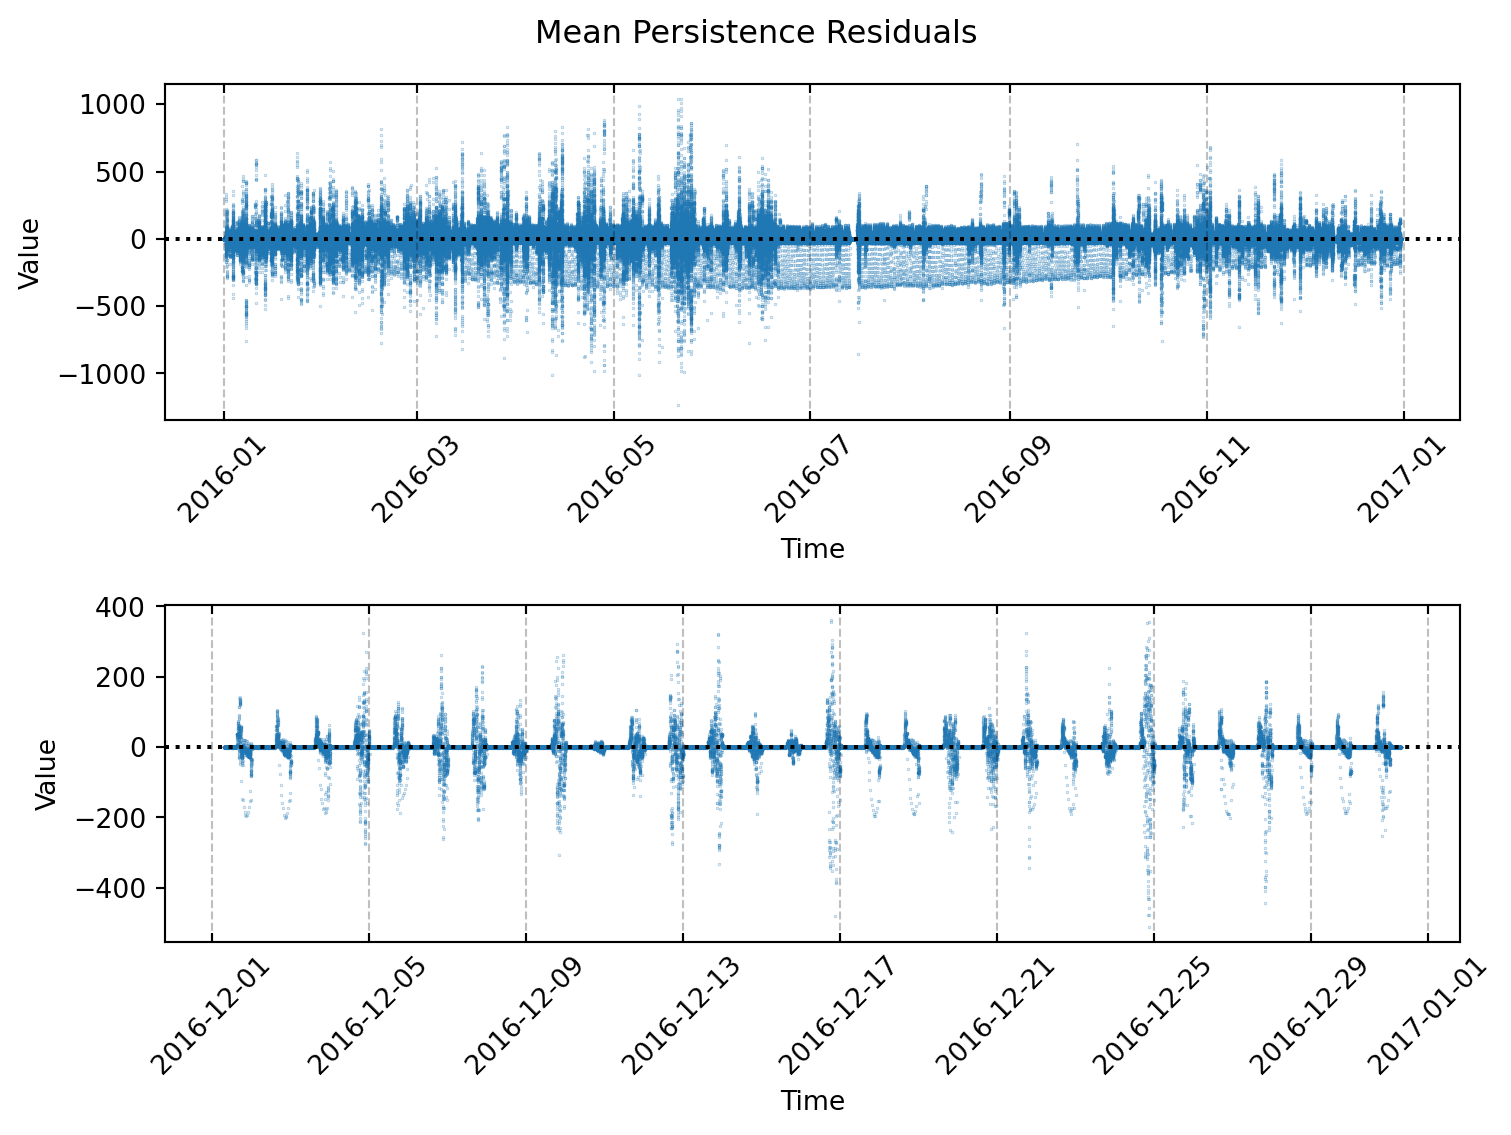

In [38]:
#| code-fold: true
#| code-summary: "Show supplementary code"
residual = (
    pd.Series(np.vstack(ground_truth).flatten() - np.vstack(forecasts).flatten())
)
residual.index = outsample_ghi_df.index[:len(residual)]

fig, axs = plt.subplots(2, 1, figsize=(8, 6))

ax = visualize_time_series(
    ax=axs[0],
    time_series=residual,
    time_series_name="Residuals",
    s=0.05,
    alpha=0.5
)
ax=visualize_time_series(
    axs[1],
    time_series=residual[-(60 * 24 * 30):],
    time_series_name="Residuals",
    s=0.05,
    alpha=0.5
)


for ax in axs:
    ax.axhline(
        y=0,
        linestyle=":",
        c="k"
    )

plt.suptitle("Mean Persistence Residuals")
plt.tight_layout()
plt.show()

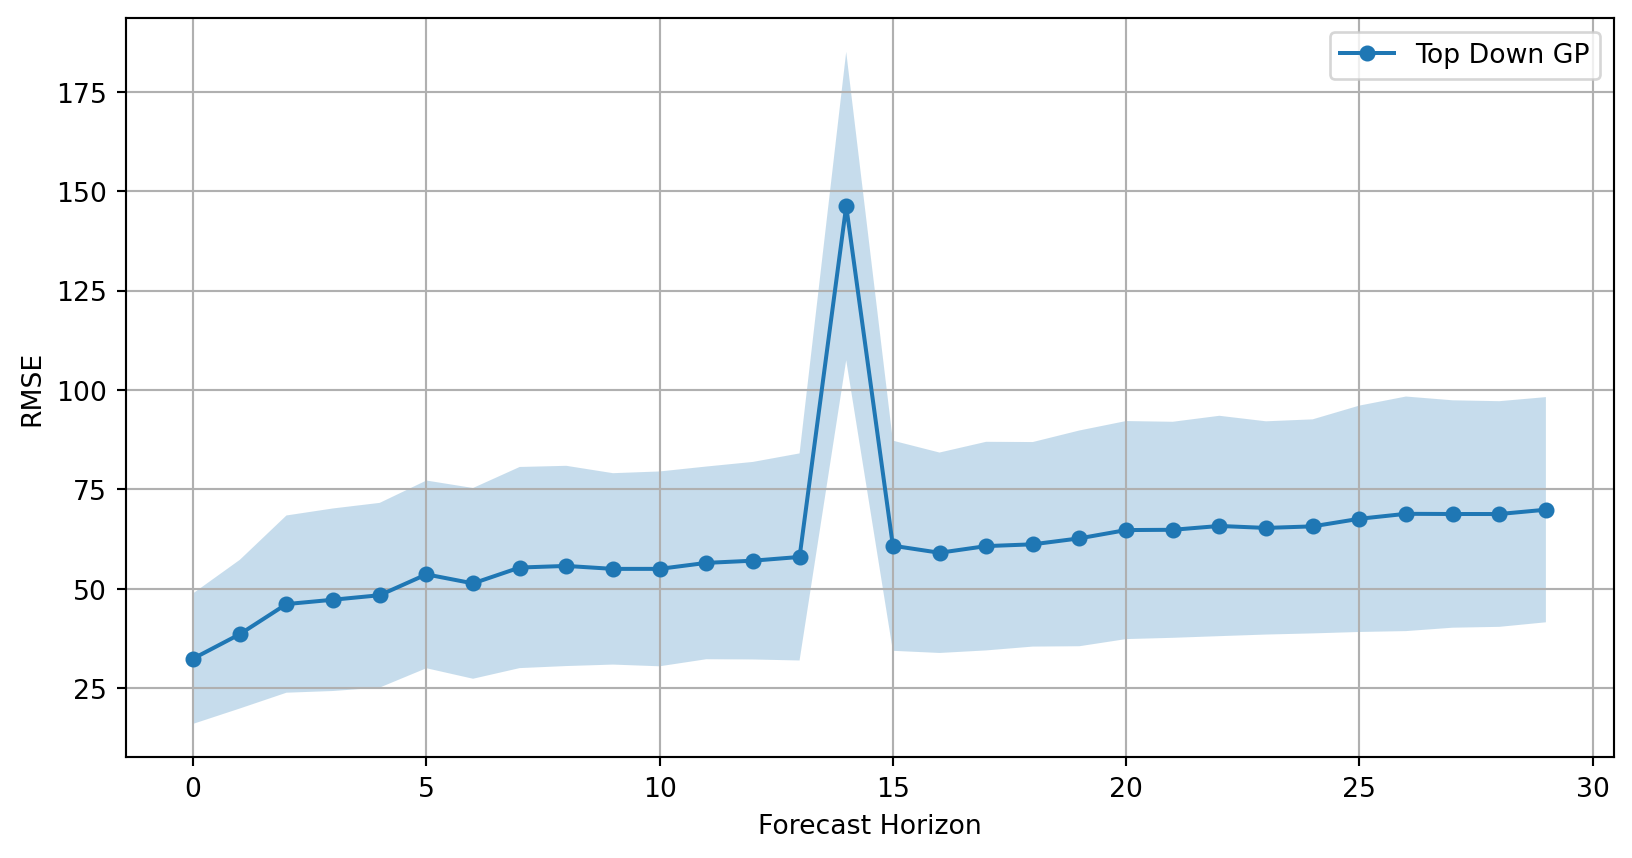

In [39]:
#| code-fold: true
#| code-summary: "Show supplementary code"
error_mean, error_sem = compute_rmse(
    y_true=np.vstack(ground_truth),
    y_forecast=np.vstack(forecasts),
    axis=0
)
MODELS_RESULTS["AR"] = {"error_mean": error_mean, "error_sem": error_sem}

fig, ax = plt.subplots(1, 1, figsize=(10, 5))
ax = visualize_forecast_horizon_accuracy(
    ax=ax,
    model_name="Top Down GP",
    error_name="RMSE",
    error_mean=error_mean,
    error_sem=error_sem,
    marker="o",
    markersize=5
)
plt.legend()
plt.show()

### II Autoregressive Multilayer Perceptron


In [40]:
from modules.models.torch_backend.neural_networks.architectures import MLPModel

model = MLPModel(
    in_features=AR_WINDOW,
    out_features=OUTSAMPLE_WINDOW_SIZE,
    layers=(30, 30, 30),
    link_function="ReLU",
    activation_function="ReLU",
    dropout_rate=0.1,
).to("cuda")
stopper = EarlyStopping(tolerance=100, min_delta=0.001)
fitter = TorchModelFitter()


model, optimizer, hisotry = fitter.fit(
    model=model,
    optimizer=Adam(model.parameters(), weight_decay=0.01),
    train_loader=train_loader,
    validation_loader=validation_loader,
    stopper=stopper,
    epochs=300,
    loss_function=MSELoss()
)

  0%|          | 0/300 [00:00<?, ?it/s]

Loss 113118.3503 - Validation Loss 97663.0679:   0%|          | 0/300 [00:00<?, ?it/s]

Loss 113118.3503 - Validation Loss 97663.0679:   0%|          | 1/300 [00:00<01:54,  2.61it/s]

Loss 81944.8551 - Validation Loss 57508.3768:   0%|          | 1/300 [00:00<01:54,  2.61it/s] 

Loss 81944.8551 - Validation Loss 57508.3768:   1%|          | 2/300 [00:00<02:04,  2.40it/s]

Loss 52498.8054 - Validation Loss 38982.8885:   1%|          | 2/300 [00:01<02:04,  2.40it/s]

Loss 52498.8054 - Validation Loss 38982.8885:   1%|          | 3/300 [00:01<02:00,  2.47it/s]

Loss 40719.5143 - Validation Loss 29558.7757:   1%|          | 3/300 [00:01<02:00,  2.47it/s]

Loss 40719.5143 - Validation Loss 29558.7757:   1%|▏         | 4/300 [00:01<02:00,  2.46it/s]

Loss 32088.059 - Validation Loss 20695.1685:   1%|▏         | 4/300 [00:02<02:00,  2.46it/s] 

Loss 32088.059 - Validation Loss 20695.1685:   2%|▏         | 5/300 [00:02<01:59,  2.47it/s]

Loss 24169.0634 - Validation Loss 14470.8544:   2%|▏         | 5/300 [00:02<01:59,  2.47it/s]

Loss 24169.0634 - Validation Loss 14470.8544:   2%|▏         | 6/300 [00:02<01:57,  2.50it/s]

Loss 19373.8335 - Validation Loss 11799.6974:   2%|▏         | 6/300 [00:02<01:57,  2.50it/s]

Loss 19373.8335 - Validation Loss 11799.6974:   2%|▏         | 7/300 [00:02<01:58,  2.48it/s]

Loss 15918.5806 - Validation Loss 6939.9819:   2%|▏         | 7/300 [00:03<01:58,  2.48it/s] 

Loss 15918.5806 - Validation Loss 6939.9819:   3%|▎         | 8/300 [00:03<01:51,  2.63it/s]

Loss 12250.6413 - Validation Loss 5151.0247:   3%|▎         | 8/300 [00:03<01:51,  2.63it/s]

Loss 12250.6413 - Validation Loss 5151.0247:   3%|▎         | 9/300 [00:03<01:46,  2.74it/s]

Loss 10559.9942 - Validation Loss 4778.5136:   3%|▎         | 9/300 [00:03<01:46,  2.74it/s]

Loss 10559.9942 - Validation Loss 4778.5136:   3%|▎         | 10/300 [00:03<01:54,  2.54it/s]

Loss 9729.0646 - Validation Loss 4471.7358:   3%|▎         | 10/300 [00:04<01:54,  2.54it/s] 

Loss 9729.0646 - Validation Loss 4471.7358:   4%|▎         | 11/300 [00:04<01:49,  2.63it/s]

Loss 9400.5325 - Validation Loss 3917.2906:   4%|▎         | 11/300 [00:04<01:49,  2.63it/s]

Loss 9400.5325 - Validation Loss 3917.2906:   4%|▍         | 12/300 [00:04<01:46,  2.71it/s]

Loss 8518.7923 - Validation Loss 3898.1902:   4%|▍         | 12/300 [00:04<01:46,  2.71it/s]

Loss 8518.7923 - Validation Loss 3898.1902:   4%|▍         | 13/300 [00:04<01:42,  2.79it/s]

Loss 8132.8252 - Validation Loss 4128.0542:   4%|▍         | 13/300 [00:05<01:42,  2.79it/s]

Loss 8132.8252 - Validation Loss 4128.0542:   5%|▍         | 14/300 [00:05<01:41,  2.82it/s]

Loss 7849.881 - Validation Loss 4157.0939:   5%|▍         | 14/300 [00:05<01:41,  2.82it/s] 

Loss 7849.881 - Validation Loss 4157.0939:   5%|▌         | 15/300 [00:05<01:41,  2.82it/s]

Loss 7818.7364 - Validation Loss 4246.5959:   5%|▌         | 15/300 [00:06<01:41,  2.82it/s]

Loss 7818.7364 - Validation Loss 4246.5959:   5%|▌         | 16/300 [00:06<01:40,  2.82it/s]

Loss 7528.7593 - Validation Loss 4523.1329:   5%|▌         | 16/300 [00:06<01:40,  2.82it/s]

Loss 7528.7593 - Validation Loss 4523.1329:   6%|▌         | 17/300 [00:06<01:53,  2.50it/s]

Loss 7591.0165 - Validation Loss 4239.7875:   6%|▌         | 17/300 [00:07<01:53,  2.50it/s]

Loss 7591.0165 - Validation Loss 4239.7875:   6%|▌         | 18/300 [00:07<01:59,  2.36it/s]

Loss 7384.6473 - Validation Loss 3965.6225:   6%|▌         | 18/300 [00:07<01:59,  2.36it/s]

Loss 7384.6473 - Validation Loss 3965.6225:   6%|▋         | 19/300 [00:07<02:13,  2.10it/s]

Loss 7249.0984 - Validation Loss 3851.7956:   6%|▋         | 19/300 [00:08<02:13,  2.10it/s]

Loss 7249.0984 - Validation Loss 3851.7956:   7%|▋         | 20/300 [00:08<02:12,  2.12it/s]

Loss 7082.0498 - Validation Loss 3786.71:   7%|▋         | 20/300 [00:08<02:12,  2.12it/s]  

Loss 7082.0498 - Validation Loss 3786.71:   7%|▋         | 21/300 [00:08<02:09,  2.15it/s]

Loss 6910.9589 - Validation Loss 3859.0468:   7%|▋         | 21/300 [00:08<02:09,  2.15it/s]

Loss 6910.9589 - Validation Loss 3859.0468:   7%|▋         | 22/300 [00:08<02:08,  2.17it/s]

Loss 6763.5134 - Validation Loss 3888.0063:   7%|▋         | 22/300 [00:09<02:08,  2.17it/s]

Loss 6763.5134 - Validation Loss 3888.0063:   8%|▊         | 23/300 [00:09<01:53,  2.44it/s]

Loss 6770.1074 - Validation Loss 4263.0586:   8%|▊         | 23/300 [00:09<01:53,  2.44it/s]

Loss 6770.1074 - Validation Loss 4263.0586:   8%|▊         | 24/300 [00:09<01:45,  2.61it/s]

Loss 6609.7784 - Validation Loss 4551.7361:   8%|▊         | 24/300 [00:09<01:45,  2.61it/s]

Loss 6609.7784 - Validation Loss 4551.7361:   8%|▊         | 25/300 [00:09<01:45,  2.62it/s]

Loss 6618.0609 - Validation Loss 5128.4862:   8%|▊         | 25/300 [00:10<01:45,  2.62it/s]

Loss 6618.0609 - Validation Loss 5128.4862:   9%|▊         | 26/300 [00:10<01:46,  2.58it/s]

Loss 6831.9813 - Validation Loss 4549.688:   9%|▊         | 26/300 [00:10<01:46,  2.58it/s] 

Loss 6831.9813 - Validation Loss 4549.688:   9%|▉         | 27/300 [00:10<01:55,  2.37it/s]

Loss 6757.0978 - Validation Loss 3951.5783:   9%|▉         | 27/300 [00:11<01:55,  2.37it/s]

Loss 6757.0978 - Validation Loss 3951.5783:   9%|▉         | 28/300 [00:11<01:52,  2.41it/s]

Loss 6407.5249 - Validation Loss 3778.0124:   9%|▉         | 28/300 [00:11<01:52,  2.41it/s]

Loss 6407.5249 - Validation Loss 3778.0124:  10%|▉         | 29/300 [00:11<01:49,  2.47it/s]

Loss 6194.1453 - Validation Loss 3696.6294:  10%|▉         | 29/300 [00:12<01:49,  2.47it/s]

Loss 6194.1453 - Validation Loss 3696.6294:  10%|█         | 30/300 [00:12<01:47,  2.51it/s]

Loss 6145.403 - Validation Loss 4035.7461:  10%|█         | 30/300 [00:12<01:47,  2.51it/s] 

Loss 6145.403 - Validation Loss 4035.7461:  10%|█         | 31/300 [00:12<01:45,  2.54it/s]

Loss 6110.0943 - Validation Loss 4535.2116:  10%|█         | 31/300 [00:12<01:45,  2.54it/s]

Loss 6110.0943 - Validation Loss 4535.2116:  11%|█         | 32/300 [00:12<01:43,  2.58it/s]

Loss 6087.2608 - Validation Loss 4762.7652:  11%|█         | 32/300 [00:13<01:43,  2.58it/s]

Loss 6087.2608 - Validation Loss 4762.7652:  11%|█         | 33/300 [00:13<01:43,  2.59it/s]

Loss 6111.7819 - Validation Loss 5430.6895:  11%|█         | 33/300 [00:13<01:43,  2.59it/s]

Loss 6111.7819 - Validation Loss 5430.6895:  11%|█▏        | 34/300 [00:13<01:42,  2.60it/s]

Loss 6395.6132 - Validation Loss 4518.5968:  11%|█▏        | 34/300 [00:13<01:42,  2.60it/s]

Loss 6395.6132 - Validation Loss 4518.5968:  12%|█▏        | 35/300 [00:13<01:41,  2.60it/s]

Loss 6193.6723 - Validation Loss 4044.1026:  12%|█▏        | 35/300 [00:14<01:41,  2.60it/s]

Loss 6193.6723 - Validation Loss 4044.1026:  12%|█▏        | 36/300 [00:14<01:58,  2.23it/s]

Loss 5994.5892 - Validation Loss 4165.5977:  12%|█▏        | 36/300 [00:14<01:58,  2.23it/s]

Loss 5994.5892 - Validation Loss 4165.5977:  12%|█▏        | 37/300 [00:14<01:58,  2.21it/s]

Loss 5968.2339 - Validation Loss 3827.5989:  12%|█▏        | 37/300 [00:15<01:58,  2.21it/s]

Loss 5968.2339 - Validation Loss 3827.5989:  13%|█▎        | 38/300 [00:15<01:51,  2.35it/s]

Loss 5892.1995 - Validation Loss 3933.0144:  13%|█▎        | 38/300 [00:15<01:51,  2.35it/s]

Loss 5892.1995 - Validation Loss 3933.0144:  13%|█▎        | 39/300 [00:15<01:41,  2.58it/s]

Loss 5734.8383 - Validation Loss 3952.3135:  13%|█▎        | 39/300 [00:15<01:41,  2.58it/s]

Loss 5734.8383 - Validation Loss 3952.3135:  13%|█▎        | 40/300 [00:15<01:36,  2.70it/s]

Loss 5719.0297 - Validation Loss 4231.4662:  13%|█▎        | 40/300 [00:16<01:36,  2.70it/s]

Loss 5719.0297 - Validation Loss 4231.4662:  14%|█▎        | 41/300 [00:16<01:32,  2.80it/s]

Loss 5664.8746 - Validation Loss 4464.1561:  14%|█▎        | 41/300 [00:16<01:32,  2.80it/s]

Loss 5664.8746 - Validation Loss 4464.1561:  14%|█▍        | 42/300 [00:16<01:31,  2.83it/s]

Loss 5731.7975 - Validation Loss 4996.6143:  14%|█▍        | 42/300 [00:16<01:31,  2.83it/s]

Loss 5731.7975 - Validation Loss 4996.6143:  14%|█▍        | 43/300 [00:16<01:28,  2.90it/s]

Loss 5946.875 - Validation Loss 5145.3568:  14%|█▍        | 43/300 [00:17<01:28,  2.90it/s] 

Loss 5946.875 - Validation Loss 5145.3568:  15%|█▍        | 44/300 [00:17<01:28,  2.89it/s]

Loss 5962.0342 - Validation Loss 5108.2351:  15%|█▍        | 44/300 [00:17<01:28,  2.89it/s]

Loss 5962.0342 - Validation Loss 5108.2351:  15%|█▌        | 45/300 [00:17<01:36,  2.64it/s]

Loss 5937.6573 - Validation Loss 4598.7601:  15%|█▌        | 45/300 [00:18<01:36,  2.64it/s]

Loss 5937.6573 - Validation Loss 4598.7601:  15%|█▌        | 46/300 [00:18<01:32,  2.76it/s]

Loss 5758.5237 - Validation Loss 4157.922:  15%|█▌        | 46/300 [00:18<01:32,  2.76it/s] 

Loss 5758.5237 - Validation Loss 4157.922:  16%|█▌        | 47/300 [00:18<01:30,  2.78it/s]

Loss 5720.7262 - Validation Loss 3838.0299:  16%|█▌        | 47/300 [00:18<01:30,  2.78it/s]

Loss 5720.7262 - Validation Loss 3838.0299:  16%|█▌        | 48/300 [00:18<01:29,  2.81it/s]

Loss 5471.0299 - Validation Loss 3964.2655:  16%|█▌        | 48/300 [00:19<01:29,  2.81it/s]

Loss 5471.0299 - Validation Loss 3964.2655:  16%|█▋        | 49/300 [00:19<01:28,  2.83it/s]

Loss 5493.3466 - Validation Loss 4244.8218:  16%|█▋        | 49/300 [00:19<01:28,  2.83it/s]

Loss 5493.3466 - Validation Loss 4244.8218:  17%|█▋        | 50/300 [00:19<01:27,  2.85it/s]

Loss 5352.7421 - Validation Loss 4380.7479:  17%|█▋        | 50/300 [00:19<01:27,  2.85it/s]

Loss 5352.7421 - Validation Loss 4380.7479:  17%|█▋        | 51/300 [00:19<01:27,  2.85it/s]

Loss 5461.7922 - Validation Loss 4444.9503:  17%|█▋        | 51/300 [00:20<01:27,  2.85it/s]

Loss 5461.7922 - Validation Loss 4444.9503:  17%|█▋        | 52/300 [00:20<01:26,  2.86it/s]

Loss 5477.3261 - Validation Loss 4567.0437:  17%|█▋        | 52/300 [00:20<01:26,  2.86it/s]

Loss 5477.3261 - Validation Loss 4567.0437:  18%|█▊        | 53/300 [00:20<01:33,  2.63it/s]

Loss 5525.1326 - Validation Loss 4757.9907:  18%|█▊        | 53/300 [00:20<01:33,  2.63it/s]

Loss 5525.1326 - Validation Loss 4757.9907:  18%|█▊        | 54/300 [00:20<01:30,  2.71it/s]

Loss 5483.1061 - Validation Loss 4584.0876:  18%|█▊        | 54/300 [00:21<01:30,  2.71it/s]

Loss 5483.1061 - Validation Loss 4584.0876:  18%|█▊        | 55/300 [00:21<01:28,  2.76it/s]

Loss 5496.8776 - Validation Loss 4368.7015:  18%|█▊        | 55/300 [00:21<01:28,  2.76it/s]

Loss 5496.8776 - Validation Loss 4368.7015:  19%|█▊        | 56/300 [00:21<01:27,  2.80it/s]

Loss 5440.1365 - Validation Loss 4190.3662:  19%|█▊        | 56/300 [00:22<01:27,  2.80it/s]

Loss 5440.1365 - Validation Loss 4190.3662:  19%|█▉        | 57/300 [00:22<01:24,  2.87it/s]

Loss 5332.6035 - Validation Loss 4249.1244:  19%|█▉        | 57/300 [00:22<01:24,  2.87it/s]

Loss 5332.6035 - Validation Loss 4249.1244:  19%|█▉        | 58/300 [00:22<01:23,  2.88it/s]

Loss 5305.2634 - Validation Loss 4363.5089:  19%|█▉        | 58/300 [00:22<01:23,  2.88it/s]

Loss 5305.2634 - Validation Loss 4363.5089:  20%|█▉        | 59/300 [00:22<01:22,  2.91it/s]

Loss 5305.935 - Validation Loss 4441.8636:  20%|█▉        | 59/300 [00:23<01:22,  2.91it/s] 

Loss 5305.935 - Validation Loss 4441.8636:  20%|██        | 60/300 [00:23<01:23,  2.88it/s]

Loss 5221.1696 - Validation Loss 4446.2466:  20%|██        | 60/300 [00:23<01:23,  2.88it/s]

Loss 5221.1696 - Validation Loss 4446.2466:  20%|██        | 61/300 [00:23<01:22,  2.90it/s]

Loss 5218.4051 - Validation Loss 5049.4001:  20%|██        | 61/300 [00:23<01:22,  2.90it/s]

Loss 5218.4051 - Validation Loss 5049.4001:  21%|██        | 62/300 [00:23<01:30,  2.63it/s]

Loss 5280.3629 - Validation Loss 4737.7163:  21%|██        | 62/300 [00:24<01:30,  2.63it/s]

Loss 5280.3629 - Validation Loss 4737.7163:  21%|██        | 63/300 [00:24<01:28,  2.69it/s]

Loss 5248.8779 - Validation Loss 4609.4186:  21%|██        | 63/300 [00:24<01:28,  2.69it/s]

Loss 5248.8779 - Validation Loss 4609.4186:  21%|██▏       | 64/300 [00:24<01:26,  2.74it/s]

Loss 5207.543 - Validation Loss 4402.7333:  21%|██▏       | 64/300 [00:24<01:26,  2.74it/s] 

Loss 5207.543 - Validation Loss 4402.7333:  22%|██▏       | 65/300 [00:24<01:24,  2.79it/s]

Loss 5173.2185 - Validation Loss 4270.1033:  22%|██▏       | 65/300 [00:25<01:24,  2.79it/s]

Loss 5173.2185 - Validation Loss 4270.1033:  22%|██▏       | 66/300 [00:25<01:23,  2.82it/s]

Loss 5218.7852 - Validation Loss 4380.3158:  22%|██▏       | 66/300 [00:25<01:23,  2.82it/s]

Loss 5218.7852 - Validation Loss 4380.3158:  22%|██▏       | 67/300 [00:25<01:22,  2.84it/s]

Loss 5021.9355 - Validation Loss 4649.2804:  22%|██▏       | 67/300 [00:25<01:22,  2.84it/s]

Loss 5021.9355 - Validation Loss 4649.2804:  23%|██▎       | 68/300 [00:25<01:21,  2.85it/s]

Loss 5168.4247 - Validation Loss 4748.7445:  23%|██▎       | 68/300 [00:26<01:21,  2.85it/s]

Loss 5168.4247 - Validation Loss 4748.7445:  23%|██▎       | 69/300 [00:26<01:20,  2.86it/s]

Loss 5253.9275 - Validation Loss 5501.4904:  23%|██▎       | 69/300 [00:26<01:20,  2.86it/s]

Loss 5253.9275 - Validation Loss 5501.4904:  23%|██▎       | 70/300 [00:26<01:20,  2.86it/s]

Loss 5297.1833 - Validation Loss 5750.2965:  23%|██▎       | 70/300 [00:27<01:20,  2.86it/s]

Loss 5297.1833 - Validation Loss 5750.2965:  24%|██▎       | 71/300 [00:27<01:27,  2.60it/s]

Loss 5392.67 - Validation Loss 5500.5767:  24%|██▎       | 71/300 [00:27<01:27,  2.60it/s]  

Loss 5392.67 - Validation Loss 5500.5767:  24%|██▍       | 72/300 [00:27<01:28,  2.56it/s]

Loss 5378.6009 - Validation Loss 4966.1003:  24%|██▍       | 72/300 [00:27<01:28,  2.56it/s]

Loss 5378.6009 - Validation Loss 4966.1003:  24%|██▍       | 73/300 [00:27<01:24,  2.69it/s]

Loss 5206.1399 - Validation Loss 4585.3952:  24%|██▍       | 73/300 [00:28<01:24,  2.69it/s]

Loss 5206.1399 - Validation Loss 4585.3952:  25%|██▍       | 74/300 [00:28<01:21,  2.76it/s]

Loss 5104.0214 - Validation Loss 4331.9034:  25%|██▍       | 74/300 [00:28<01:21,  2.76it/s]

Loss 5104.0214 - Validation Loss 4331.9034:  25%|██▌       | 75/300 [00:28<01:19,  2.83it/s]

Loss 4907.3398 - Validation Loss 4027.203:  25%|██▌       | 75/300 [00:28<01:19,  2.83it/s] 

Loss 4907.3398 - Validation Loss 4027.203:  25%|██▌       | 76/300 [00:28<01:18,  2.84it/s]

Loss 5016.1041 - Validation Loss 4328.943:  25%|██▌       | 76/300 [00:29<01:18,  2.84it/s]

Loss 5016.1041 - Validation Loss 4328.943:  26%|██▌       | 77/300 [00:29<01:21,  2.75it/s]

Loss 4881.7178 - Validation Loss 4487.0723:  26%|██▌       | 77/300 [00:29<01:21,  2.75it/s]

Loss 4881.7178 - Validation Loss 4487.0723:  26%|██▌       | 78/300 [00:29<01:23,  2.67it/s]

Loss 5064.8995 - Validation Loss 4605.4333:  26%|██▌       | 78/300 [00:30<01:23,  2.67it/s]

Loss 5064.8995 - Validation Loss 4605.4333:  26%|██▋       | 79/300 [00:30<01:25,  2.59it/s]

Loss 5023.1021 - Validation Loss 4560.0714:  26%|██▋       | 79/300 [00:30<01:25,  2.59it/s]

Loss 5023.1021 - Validation Loss 4560.0714:  27%|██▋       | 80/300 [00:30<01:22,  2.68it/s]

Loss 4989.9578 - Validation Loss 4195.3251:  27%|██▋       | 80/300 [00:30<01:22,  2.68it/s]

Loss 4989.9578 - Validation Loss 4195.3251:  27%|██▋       | 81/300 [00:30<01:20,  2.73it/s]

Loss 5008.8427 - Validation Loss 4326.0796:  27%|██▋       | 81/300 [00:31<01:20,  2.73it/s]

Loss 5008.8427 - Validation Loss 4326.0796:  27%|██▋       | 82/300 [00:31<01:17,  2.81it/s]

Loss 4948.6866 - Validation Loss 4759.2388:  27%|██▋       | 82/300 [00:31<01:17,  2.81it/s]

Loss 4948.6866 - Validation Loss 4759.2388:  28%|██▊       | 83/300 [00:31<01:16,  2.84it/s]

Loss 4743.3393 - Validation Loss 4701.5227:  28%|██▊       | 83/300 [00:31<01:16,  2.84it/s]

Loss 4743.3393 - Validation Loss 4701.5227:  28%|██▊       | 84/300 [00:31<01:15,  2.85it/s]

Loss 4931.2153 - Validation Loss 5034.3616:  28%|██▊       | 84/300 [00:32<01:15,  2.85it/s]

Loss 4931.2153 - Validation Loss 5034.3616:  28%|██▊       | 85/300 [00:32<01:15,  2.85it/s]

Loss 5034.3073 - Validation Loss 5032.7741:  28%|██▊       | 85/300 [00:32<01:15,  2.85it/s]

Loss 5034.3073 - Validation Loss 5032.7741:  29%|██▊       | 86/300 [00:32<01:14,  2.86it/s]

Loss 4947.6003 - Validation Loss 4841.6349:  29%|██▊       | 86/300 [00:32<01:14,  2.86it/s]

Loss 4947.6003 - Validation Loss 4841.6349:  29%|██▉       | 87/300 [00:32<01:14,  2.87it/s]

Loss 4991.1754 - Validation Loss 4269.4714:  29%|██▉       | 87/300 [00:33<01:14,  2.87it/s]

Loss 4991.1754 - Validation Loss 4269.4714:  29%|██▉       | 88/300 [00:33<01:21,  2.61it/s]

Loss 4918.1486 - Validation Loss 4338.7461:  29%|██▉       | 88/300 [00:33<01:21,  2.61it/s]

Loss 4918.1486 - Validation Loss 4338.7461:  30%|██▉       | 89/300 [00:33<01:19,  2.67it/s]

Loss 4950.0738 - Validation Loss 4600.8095:  30%|██▉       | 89/300 [00:33<01:19,  2.67it/s]

Loss 4950.0738 - Validation Loss 4600.8095:  30%|███       | 90/300 [00:33<01:17,  2.72it/s]

Loss 4910.0227 - Validation Loss 4494.3731:  30%|███       | 90/300 [00:34<01:17,  2.72it/s]

Loss 4910.0227 - Validation Loss 4494.3731:  30%|███       | 91/300 [00:34<01:15,  2.77it/s]

Loss 4854.9832 - Validation Loss 4621.1866:  30%|███       | 91/300 [00:34<01:15,  2.77it/s]

Loss 4854.9832 - Validation Loss 4621.1866:  31%|███       | 92/300 [00:34<01:14,  2.79it/s]

Loss 4711.8448 - Validation Loss 4470.9601:  31%|███       | 92/300 [00:35<01:14,  2.79it/s]

Loss 4711.8448 - Validation Loss 4470.9601:  31%|███       | 93/300 [00:35<01:13,  2.81it/s]

Loss 4853.845 - Validation Loss 4412.0317:  31%|███       | 93/300 [00:35<01:13,  2.81it/s] 

Loss 4853.845 - Validation Loss 4412.0317:  31%|███▏      | 94/300 [00:35<01:12,  2.82it/s]

Loss 4801.2203 - Validation Loss 4869.9773:  31%|███▏      | 94/300 [00:35<01:12,  2.82it/s]

Loss 4801.2203 - Validation Loss 4869.9773:  32%|███▏      | 95/300 [00:35<01:12,  2.82it/s]

Loss 4790.3865 - Validation Loss 4875.2861:  32%|███▏      | 95/300 [00:36<01:12,  2.82it/s]

Loss 4790.3865 - Validation Loss 4875.2861:  32%|███▏      | 96/300 [00:36<01:19,  2.57it/s]

Loss 4788.5321 - Validation Loss 5329.4894:  32%|███▏      | 96/300 [00:36<01:19,  2.57it/s]

Loss 4788.5321 - Validation Loss 5329.4894:  32%|███▏      | 97/300 [00:36<01:16,  2.64it/s]

Loss 4829.8872 - Validation Loss 5535.3965:  32%|███▏      | 97/300 [00:36<01:16,  2.64it/s]

Loss 4829.8872 - Validation Loss 5535.3965:  33%|███▎      | 98/300 [00:36<01:15,  2.68it/s]

Loss 4930.0016 - Validation Loss 5440.4565:  33%|███▎      | 98/300 [00:37<01:15,  2.68it/s]

Loss 4930.0016 - Validation Loss 5440.4565:  33%|███▎      | 99/300 [00:37<01:16,  2.62it/s]

Loss 4924.5637 - Validation Loss 5012.997:  33%|███▎      | 99/300 [00:37<01:16,  2.62it/s] 

Loss 4924.5637 - Validation Loss 5012.997:  33%|███▎      | 100/300 [00:37<01:17,  2.58it/s]

Loss 4895.1269 - Validation Loss 4449.7907:  33%|███▎      | 100/300 [00:38<01:17,  2.58it/s]

Loss 4895.1269 - Validation Loss 4449.7907:  34%|███▎      | 101/300 [00:38<01:17,  2.56it/s]

Loss 4729.8851 - Validation Loss 4635.2434:  34%|███▎      | 101/300 [00:38<01:17,  2.56it/s]

Loss 4729.8851 - Validation Loss 4635.2434:  34%|███▍      | 102/300 [00:38<01:17,  2.55it/s]

Loss 4715.6865 - Validation Loss 4699.1454:  34%|███▍      | 102/300 [00:38<01:17,  2.55it/s]

Loss 4715.6865 - Validation Loss 4699.1454:  34%|███▍      | 103/300 [00:38<01:13,  2.67it/s]

Loss 4751.0402 - Validation Loss 4733.7869:  34%|███▍      | 103/300 [00:39<01:13,  2.67it/s]

Loss 4751.0402 - Validation Loss 4733.7869:  35%|███▍      | 104/300 [00:39<01:10,  2.77it/s]

Loss 4685.5674 - Validation Loss 5112.4268:  35%|███▍      | 104/300 [00:39<01:10,  2.77it/s]

Loss 4685.5674 - Validation Loss 5112.4268:  35%|███▌      | 105/300 [00:39<01:25,  2.27it/s]

Loss 4712.432 - Validation Loss 5345.7338:  35%|███▌      | 105/300 [00:40<01:25,  2.27it/s] 

Loss 4712.432 - Validation Loss 5345.7338:  35%|███▌      | 106/300 [00:40<01:27,  2.22it/s]

Loss 4722.3322 - Validation Loss 4937.9862:  35%|███▌      | 106/300 [00:40<01:27,  2.22it/s]

Loss 4722.3322 - Validation Loss 4937.9862:  36%|███▌      | 107/300 [00:40<01:27,  2.22it/s]

Loss 4712.1046 - Validation Loss 5276.8533:  36%|███▌      | 107/300 [00:41<01:27,  2.22it/s]

Loss 4712.1046 - Validation Loss 5276.8533:  36%|███▌      | 108/300 [00:41<01:21,  2.36it/s]

Loss 4621.0868 - Validation Loss 4924.3961:  36%|███▌      | 108/300 [00:41<01:21,  2.36it/s]

Loss 4621.0868 - Validation Loss 4924.3961:  36%|███▋      | 109/300 [00:41<01:15,  2.54it/s]

Loss 4697.6941 - Validation Loss 4894.2705:  36%|███▋      | 109/300 [00:41<01:15,  2.54it/s]

Loss 4697.6941 - Validation Loss 4894.2705:  37%|███▋      | 110/300 [00:41<01:17,  2.44it/s]

Loss 4686.0787 - Validation Loss 5035.6851:  37%|███▋      | 110/300 [00:42<01:17,  2.44it/s]

Loss 4686.0787 - Validation Loss 5035.6851:  37%|███▋      | 111/300 [00:42<01:21,  2.33it/s]

Loss 4650.6763 - Validation Loss 5040.8692:  37%|███▋      | 111/300 [00:42<01:21,  2.33it/s]

Loss 4650.6763 - Validation Loss 5040.8692:  37%|███▋      | 112/300 [00:42<01:22,  2.27it/s]

Loss 4624.8755 - Validation Loss 4988.111:  37%|███▋      | 112/300 [00:43<01:22,  2.27it/s] 

Loss 4624.8755 - Validation Loss 4988.111:  38%|███▊      | 113/300 [00:43<01:30,  2.06it/s]

Loss 4683.5081 - Validation Loss 6992.2754:  38%|███▊      | 113/300 [00:43<01:30,  2.06it/s]

Loss 4683.5081 - Validation Loss 6992.2754:  38%|███▊      | 114/300 [00:43<01:29,  2.09it/s]

Loss 4581.539 - Validation Loss 5662.0051:  38%|███▊      | 114/300 [00:44<01:29,  2.09it/s] 

Loss 4581.539 - Validation Loss 5662.0051:  38%|███▊      | 115/300 [00:44<01:18,  2.36it/s]

Loss 4712.9695 - Validation Loss 5379.5024:  38%|███▊      | 115/300 [00:44<01:18,  2.36it/s]

Loss 4712.9695 - Validation Loss 5379.5024:  39%|███▊      | 116/300 [00:44<01:12,  2.52it/s]

Loss 4694.7663 - Validation Loss 5529.9776:  39%|███▊      | 116/300 [00:44<01:12,  2.52it/s]

Loss 4694.7663 - Validation Loss 5529.9776:  39%|███▉      | 117/300 [00:44<01:09,  2.64it/s]

Loss 4738.6539 - Validation Loss 5107.8602:  39%|███▉      | 117/300 [00:45<01:09,  2.64it/s]

Loss 4738.6539 - Validation Loss 5107.8602:  39%|███▉      | 118/300 [00:45<01:07,  2.72it/s]

Loss 4658.5254 - Validation Loss 4622.4281:  39%|███▉      | 118/300 [00:45<01:07,  2.72it/s]

Loss 4658.5254 - Validation Loss 4622.4281:  40%|███▉      | 119/300 [00:45<01:13,  2.46it/s]

Loss 4564.8575 - Validation Loss 4592.3333:  40%|███▉      | 119/300 [00:46<01:13,  2.46it/s]

Loss 4564.8575 - Validation Loss 4592.3333:  40%|████      | 120/300 [00:46<01:18,  2.31it/s]

Loss 4615.3616 - Validation Loss 4586.1294:  40%|████      | 120/300 [00:46<01:18,  2.31it/s]

Loss 4615.3616 - Validation Loss 4586.1294:  40%|████      | 121/300 [00:46<01:19,  2.25it/s]

Loss 4517.9765 - Validation Loss 5012.4379:  40%|████      | 121/300 [00:47<01:19,  2.25it/s]

Loss 4517.9765 - Validation Loss 5012.4379:  41%|████      | 122/300 [00:47<01:27,  2.04it/s]

Loss 4469.3742 - Validation Loss 5191.731:  41%|████      | 122/300 [00:47<01:27,  2.04it/s] 

Loss 4469.3742 - Validation Loss 5191.731:  41%|████      | 123/300 [00:47<01:24,  2.09it/s]

Loss 4595.8454 - Validation Loss 4882.6774:  41%|████      | 123/300 [00:48<01:24,  2.09it/s]

Loss 4595.8454 - Validation Loss 4882.6774:  41%|████▏     | 124/300 [00:48<01:22,  2.14it/s]

Loss 4511.0945 - Validation Loss 4921.3237:  41%|████▏     | 124/300 [00:48<01:22,  2.14it/s]

Loss 4511.0945 - Validation Loss 4921.3237:  42%|████▏     | 125/300 [00:48<01:20,  2.18it/s]

Loss 4595.2848 - Validation Loss 5037.6164:  42%|████▏     | 125/300 [00:48<01:20,  2.18it/s]

Loss 4595.2848 - Validation Loss 5037.6164:  42%|████▏     | 126/300 [00:48<01:18,  2.21it/s]

Loss 4444.8498 - Validation Loss 5012.7361:  42%|████▏     | 126/300 [00:49<01:18,  2.21it/s]

Loss 4444.8498 - Validation Loss 5012.7361:  42%|████▏     | 127/300 [00:49<01:13,  2.37it/s]

Loss 4506.6927 - Validation Loss 5110.0546:  42%|████▏     | 127/300 [00:49<01:13,  2.37it/s]

Loss 4506.6927 - Validation Loss 5110.0546:  43%|████▎     | 128/300 [00:49<01:07,  2.56it/s]

Loss 4546.6179 - Validation Loss 5294.0234:  43%|████▎     | 128/300 [00:49<01:07,  2.56it/s]

Loss 4546.6179 - Validation Loss 5294.0234:  43%|████▎     | 129/300 [00:49<01:03,  2.69it/s]

Loss 4466.4275 - Validation Loss 5244.1643:  43%|████▎     | 129/300 [00:50<01:03,  2.69it/s]

Loss 4466.4275 - Validation Loss 5244.1643:  43%|████▎     | 130/300 [00:50<01:01,  2.77it/s]

Loss 4464.297 - Validation Loss 4962.3689:  43%|████▎     | 130/300 [00:50<01:01,  2.77it/s] 

Loss 4464.297 - Validation Loss 4962.3689:  43%|████▎     | 130/300 [00:50<01:06,  2.56it/s]

Validation did not improve for 100 epochs, interrupting training.
Loaded the latest best model state from epoch 30


In [41]:
#| code-fold: true
#| code-summary: "Show supplementary code"
ground_truth = []
forecasts = []

for ar_window,  outsample_target in test_loader:

    forecasts.append(
        model.forward(
            ar_window.to("cuda")
        ).to("cpu").detach().numpy()
    )
    ground_truth.append(outsample_target.detach().numpy())

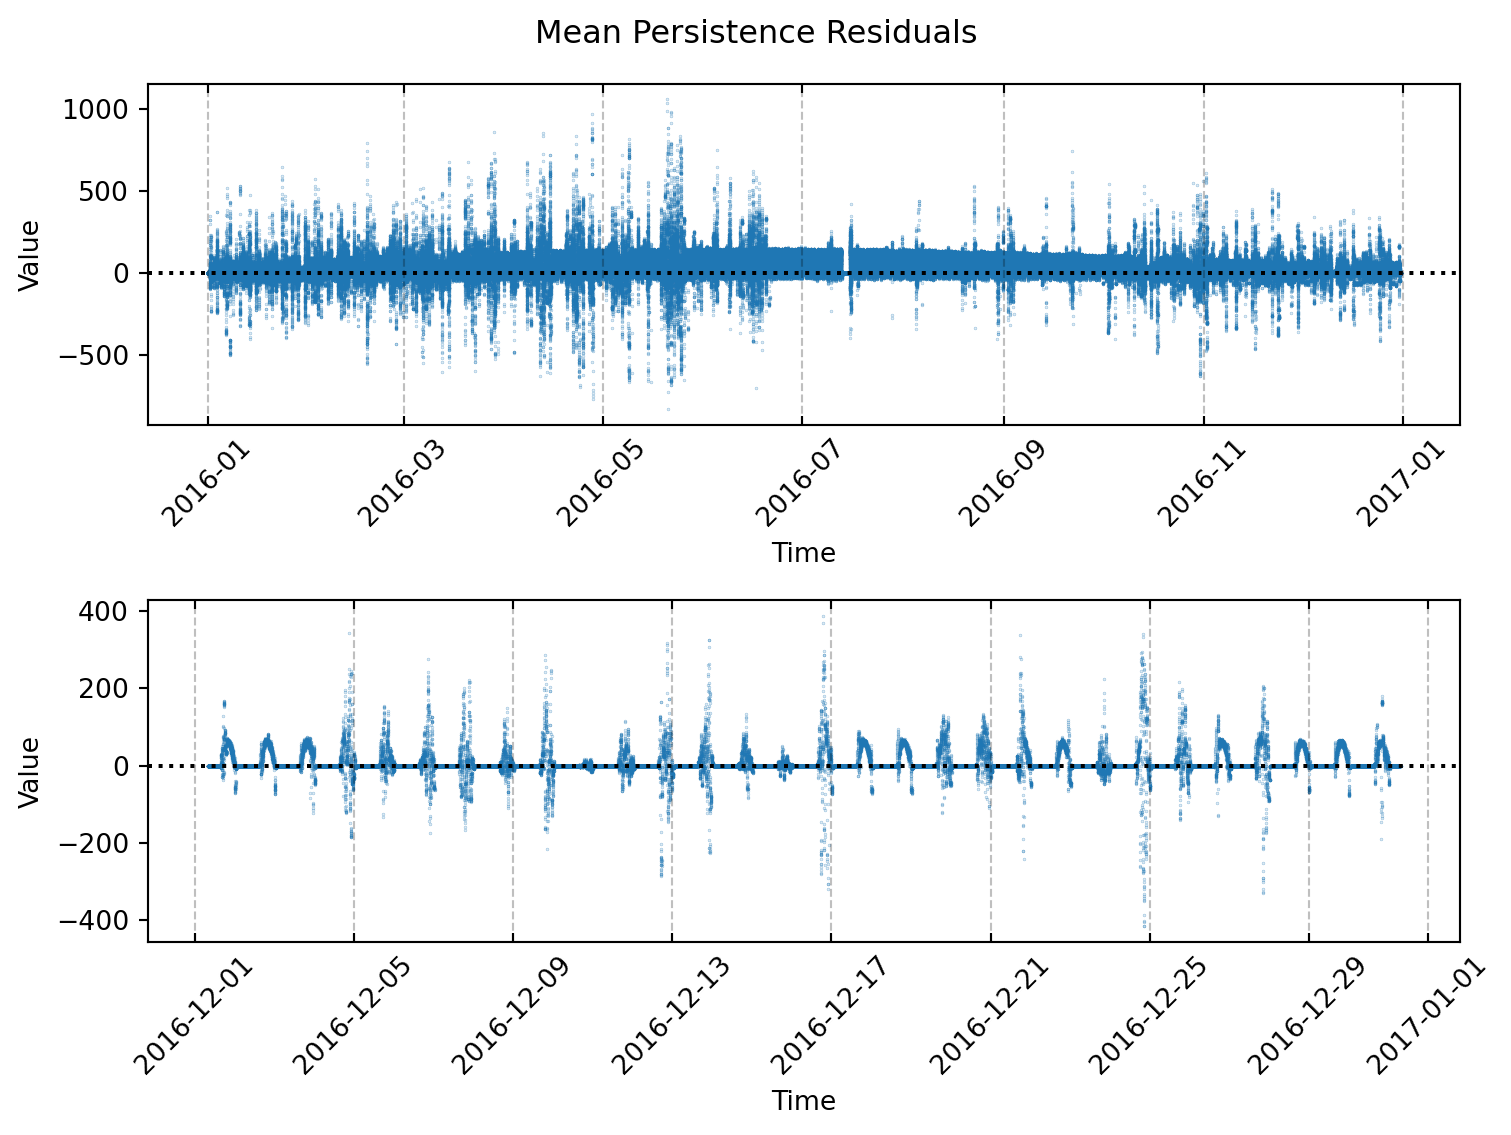

In [42]:
#| code-fold: true
#| code-summary: "Show supplementary code"
residual = (
    pd.Series(np.vstack(ground_truth).flatten() - np.vstack(forecasts).flatten())
)
residual.index = outsample_ghi_df.index[:len(residual)]

fig, axs = plt.subplots(2, 1, figsize=(8, 6))

ax = visualize_time_series(
    ax=axs[0],
    time_series=residual,
    time_series_name="Residuals",
    s=0.05,
    alpha=0.5
)
ax=visualize_time_series(
    axs[1],
    time_series=residual[-(60 * 24 * 30):],
    time_series_name="Residuals",
    s=0.05,
    alpha=0.5
)


for ax in axs:
    ax.axhline(
        y=0,
        linestyle=":",
        c="k"
    )

plt.suptitle("Mean Persistence Residuals")
plt.tight_layout()
plt.show()

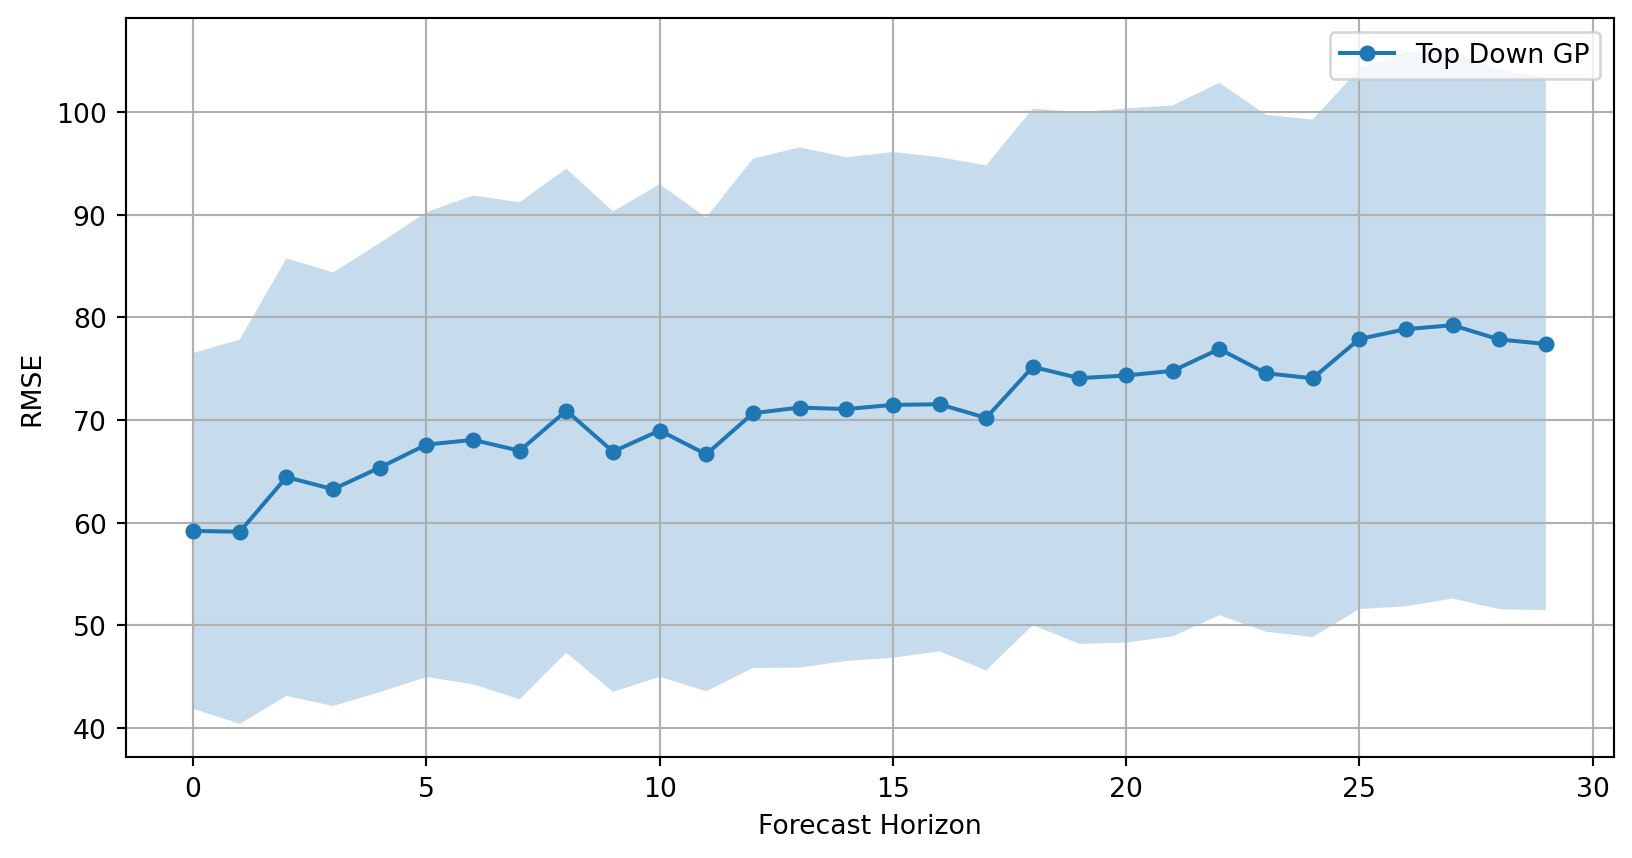

In [43]:
#| code-fold: true
#| code-summary: "Show supplementary code"
error_mean, error_sem = compute_rmse(
    y_true=np.vstack(ground_truth),
    y_forecast=np.vstack(forecasts),
    axis=0
)
MODELS_RESULTS["MLP AR"] = {"error_mean": error_mean, "error_sem": error_sem}

fig, ax = plt.subplots(1, 1, figsize=(10, 5))
ax = visualize_forecast_horizon_accuracy(
    ax=ax,
    model_name="Top Down GP",
    error_name="RMSE",
    error_mean=error_mean,
    error_sem=error_sem,
    marker="o",
    markersize=5
)
plt.legend()
plt.show()

## IV - Generalized Addtive Linear Model (with MLP as as a covariate function)

$$
\hat{y}_{t} = \alpha_{day}\phi_{day}(t) + \alpha_{year}\phi_{year}(t) + f(X_{t-2})
$$

Excluding the autograd functionality offered by JAX this model was developed from first principles using JAX numpy API


In [44]:
import numpy as np
from jax import random

from sklearn.preprocessing import MinMaxScaler

from modules.data_handling.features_generators import make_fourier_matrix


master_key = random.PRNGKey(666)

ghi_scaler = MinMaxScaler()
satellite_covariates_scaler = MinMaxScaler()

y_insample = insample_ghi_df["ghi"].values
y_outsample = outsample_ghi_df["ghi"].values

insample_satellite_covariates = insample_ghi_df[np.arange(1, 101)].values
insample_satellite_covariates = satellite_covariates_scaler.fit_transform(insample_satellite_covariates)

outsample_satellite_covariates = outsample_ghi_df[np.arange(1, 101)].values
outsample_satellite_covariates = satellite_covariates_scaler.fit_transform(outsample_satellite_covariates)

insample_time = np.arange(len(y_insample))
outsample_time = np.arange(insample_time.max(), insample_time.max() + len(y_outsample))

insample_fourier_matrix_year = make_fourier_matrix(
    time_series_indices=np.arange(len(y_insample)), 
    n_components=10, 
    period=525949.2
)
insample_fourier_matrix_day = make_fourier_matrix(
    time_series_indices=np.arange(len(y_insample)), 
    n_components=10, 
    period=1440
)
outsample_fourier_matrix_year = make_fourier_matrix(
    time_series_indices=outsample_time, 
    n_components=10, 
    period=525949.2
)
outsample_fourier_matrix_day = make_fourier_matrix(
    time_series_indices=outsample_time, 
    n_components=10, 
    period=1440
)

I0000 00:00:1698618466.512242    4372 tfrt_cpu_pjrt_client.cc:349] TfrtCpuClient created.
No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


In [45]:
from modules.models.jax_backend.additive_models import custom_ghi_model
from modules.models.jax_backend.initializers import random_gaussian
from modules.models.jax_backend.activation_functions import relu
from modules.models.jax_backend.losses import mae

init_params, forward, backward, get_components = custom_ghi_model(
    seasonality_init_method=random_gaussian,
    covariates_init_method=random_gaussian,
    mlp_hidden_link_function=relu,
    mlp_init_method=random_gaussian,
    mlp_layers=(),
    link_function=relu,
    loss_function=mae,
    covariates_reg_strength=0.001,
    seasonality_reg_strength=0.001,
    prngkey=random.split(master_key)[1]
)

start_params = init_params(
    insample_fourier_matrix_year, 
    insample_fourier_matrix_day,
    covariates=insample_satellite_covariates
)

In [46]:
from modules.models.jax_backend.fitters import fit
from modules.models.jax_backend.optimizers import newton_rhapson
from modules.models.jax_backend.callbacks import EarlyStopping

params, history = fit(
    X=(
        insample_fourier_matrix_year,
        insample_fourier_matrix_day,
        insample_satellite_covariates
    ),
    y=y_insample, 
    backward=backward, 
    start_params=start_params, 
    optimizer=newton_rhapson(learning_rate=10),
    epochs=1000, 
    stopper=EarlyStopping(tol=100), 
    verbose=1, 
    batch_size=None
)

Loss:   0%|          | 0/1000 [00:00<?, ?it/s]

Loss 205.8950958251953:   0%|          | 0/1000 [00:01<?, ?it/s]

Loss 205.8950958251953:   0%|          | 1/1000 [00:01<18:19,  1.10s/it]

Loss 204.3303985595703:   0%|          | 1/1000 [00:01<18:19,  1.10s/it]

Loss 204.3303985595703:   0%|          | 2/1000 [00:01<12:09,  1.37it/s]

Loss 200.43429565429688:   0%|          | 2/1000 [00:02<12:09,  1.37it/s]

Loss 200.43429565429688:   0%|          | 3/1000 [00:02<10:31,  1.58it/s]

Loss 195.15908813476562:   0%|          | 3/1000 [00:02<10:31,  1.58it/s]

Loss 195.15908813476562:   0%|          | 4/1000 [00:02<09:20,  1.78it/s]

Loss 190.47068786621094:   0%|          | 4/1000 [00:03<09:20,  1.78it/s]

Loss 190.47068786621094:   0%|          | 5/1000 [00:03<09:10,  1.81it/s]

Loss 179.75079345703125:   0%|          | 5/1000 [00:03<09:10,  1.81it/s]

Loss 179.75079345703125:   1%|          | 6/1000 [00:03<09:25,  1.76it/s]

Loss 173.71119689941406:   1%|          | 6/1000 [00:04<09:25,  1.76it/s]

Loss 173.71119689941406:   1%|          | 7/1000 [00:04<08:44,  1.89it/s]

Loss 162.57460021972656:   1%|          | 7/1000 [00:04<08:44,  1.89it/s]

Loss 162.57460021972656:   1%|          | 8/1000 [00:04<08:24,  1.97it/s]

Loss 153.02110290527344:   1%|          | 8/1000 [00:05<08:24,  1.97it/s]

Loss 153.02110290527344:   1%|          | 9/1000 [00:05<08:45,  1.89it/s]

Loss 146.4005889892578:   1%|          | 9/1000 [00:05<08:45,  1.89it/s] 

Loss 146.4005889892578:   1%|          | 10/1000 [00:05<08:50,  1.87it/s]

Loss 135.3822021484375:   1%|          | 10/1000 [00:06<08:50,  1.87it/s]

Loss 135.3822021484375:   1%|          | 11/1000 [00:06<09:21,  1.76it/s]

Loss 129.21759033203125:   1%|          | 11/1000 [00:06<09:21,  1.76it/s]

Loss 129.21759033203125:   1%|          | 12/1000 [00:06<08:55,  1.84it/s]

Loss 122.2614974975586:   1%|          | 12/1000 [00:07<08:55,  1.84it/s] 

Loss 122.2614974975586:   1%|▏         | 13/1000 [00:07<08:58,  1.83it/s]

Loss 114.36549377441406:   1%|▏         | 13/1000 [00:07<08:58,  1.83it/s]

Loss 114.36549377441406:   1%|▏         | 14/1000 [00:07<08:49,  1.86it/s]

Loss 108.3302993774414:   1%|▏         | 14/1000 [00:08<08:49,  1.86it/s] 

Loss 108.3302993774414:   2%|▏         | 15/1000 [00:08<08:27,  1.94it/s]

Loss 103.25039672851562:   2%|▏         | 15/1000 [00:08<08:27,  1.94it/s]

Loss 103.25039672851562:   2%|▏         | 16/1000 [00:08<08:40,  1.89it/s]

Loss 96.95349884033203:   2%|▏         | 16/1000 [00:09<08:40,  1.89it/s] 

Loss 96.95349884033203:   2%|▏         | 17/1000 [00:09<08:45,  1.87it/s]

Loss 91.3313980102539:   2%|▏         | 17/1000 [00:10<08:45,  1.87it/s] 

Loss 91.3313980102539:   2%|▏         | 18/1000 [00:10<08:44,  1.87it/s]

Loss 86.81520080566406:   2%|▏         | 18/1000 [00:10<08:44,  1.87it/s]

Loss 86.81520080566406:   2%|▏         | 19/1000 [00:10<08:50,  1.85it/s]

Loss 82.2698974609375:   2%|▏         | 19/1000 [00:11<08:50,  1.85it/s] 

Loss 82.2698974609375:   2%|▏         | 20/1000 [00:11<09:54,  1.65it/s]

Loss 77.45709991455078:   2%|▏         | 20/1000 [00:11<09:54,  1.65it/s]

Loss 77.45709991455078:   2%|▏         | 21/1000 [00:12<10:11,  1.60it/s]

Loss 73.08390045166016:   2%|▏         | 21/1000 [00:12<10:11,  1.60it/s]

Loss 73.08390045166016:   2%|▏         | 22/1000 [00:12<10:29,  1.55it/s]

Loss 69.6012954711914:   2%|▏         | 22/1000 [00:13<10:29,  1.55it/s] 

Loss 69.6012954711914:   2%|▏         | 23/1000 [00:13<10:26,  1.56it/s]

Loss 65.95079803466797:   2%|▏         | 23/1000 [00:13<10:26,  1.56it/s]

Loss 65.95079803466797:   2%|▏         | 24/1000 [00:13<09:35,  1.70it/s]

Loss 62.173797607421875:   2%|▏         | 24/1000 [00:14<09:35,  1.70it/s]

Loss 62.173797607421875:   2%|▎         | 25/1000 [00:14<09:16,  1.75it/s]

Loss 59.150699615478516:   2%|▎         | 25/1000 [00:14<09:16,  1.75it/s]

Loss 59.150699615478516:   3%|▎         | 26/1000 [00:14<09:08,  1.78it/s]

Loss 56.51029968261719:   3%|▎         | 26/1000 [00:15<09:08,  1.78it/s] 

Loss 56.51029968261719:   3%|▎         | 27/1000 [00:15<08:57,  1.81it/s]

Loss 53.89259719848633:   3%|▎         | 27/1000 [00:15<08:57,  1.81it/s]

Loss 53.89259719848633:   3%|▎         | 28/1000 [00:15<08:53,  1.82it/s]

Loss 51.75489807128906:   3%|▎         | 28/1000 [00:16<08:53,  1.82it/s]

Loss 51.75489807128906:   3%|▎         | 29/1000 [00:16<08:46,  1.84it/s]

Loss 50.57569885253906:   3%|▎         | 29/1000 [00:16<08:46,  1.84it/s]

Loss 50.57569885253906:   3%|▎         | 30/1000 [00:16<08:24,  1.92it/s]

Loss 49.38189697265625:   3%|▎         | 30/1000 [00:17<08:24,  1.92it/s]

Loss 49.38189697265625:   3%|▎         | 31/1000 [00:17<08:34,  1.88it/s]

Loss 48.52349853515625:   3%|▎         | 31/1000 [00:18<08:34,  1.88it/s]

Loss 48.52349853515625:   3%|▎         | 32/1000 [00:18<08:35,  1.88it/s]

Loss 48.301700592041016:   3%|▎         | 32/1000 [00:18<08:35,  1.88it/s]

Loss 48.301700592041016:   3%|▎         | 33/1000 [00:18<08:35,  1.88it/s]

Loss 48.12459945678711:   3%|▎         | 33/1000 [00:19<08:35,  1.88it/s] 

Loss 48.12459945678711:   3%|▎         | 34/1000 [00:19<08:34,  1.88it/s]

Loss 47.70669937133789:   3%|▎         | 34/1000 [00:19<08:34,  1.88it/s]

Loss 47.70669937133789:   4%|▎         | 35/1000 [00:19<08:31,  1.88it/s]

Loss 47.301998138427734:   4%|▎         | 35/1000 [00:20<08:31,  1.88it/s]

Loss 47.301998138427734:   4%|▎         | 36/1000 [00:20<08:30,  1.89it/s]

Loss 47.11039733886719:   4%|▎         | 36/1000 [00:20<08:30,  1.89it/s] 

Loss 47.11039733886719:   4%|▎         | 37/1000 [00:20<08:33,  1.87it/s]

Loss 46.742897033691406:   4%|▎         | 37/1000 [00:21<08:33,  1.87it/s]

Loss 46.742897033691406:   4%|▍         | 38/1000 [00:21<08:31,  1.88it/s]

Loss 46.15850067138672:   4%|▍         | 38/1000 [00:21<08:31,  1.88it/s] 

Loss 46.15850067138672:   4%|▍         | 39/1000 [00:21<08:33,  1.87it/s]

Loss 45.79999923706055:   4%|▍         | 39/1000 [00:22<08:33,  1.87it/s]

Loss 45.79999923706055:   4%|▍         | 40/1000 [00:22<09:07,  1.75it/s]

Loss 45.5015983581543:   4%|▍         | 40/1000 [00:23<09:07,  1.75it/s] 

Loss 45.5015983581543:   4%|▍         | 41/1000 [00:23<09:23,  1.70it/s]

Loss 45.024898529052734:   4%|▍         | 41/1000 [00:23<09:23,  1.70it/s]

Loss 45.024898529052734:   4%|▍         | 42/1000 [00:23<09:18,  1.71it/s]

Loss 44.7162971496582:   4%|▍         | 42/1000 [00:24<09:18,  1.71it/s]  

Loss 44.7162971496582:   4%|▍         | 43/1000 [00:24<08:46,  1.82it/s]

Loss 44.565399169921875:   4%|▍         | 43/1000 [00:24<08:46,  1.82it/s]

Loss 44.565399169921875:   4%|▍         | 44/1000 [00:24<08:13,  1.94it/s]

Loss 44.276100158691406:   4%|▍         | 44/1000 [00:24<08:13,  1.94it/s]

Loss 44.276100158691406:   4%|▍         | 45/1000 [00:24<07:58,  1.99it/s]

Loss 44.174598693847656:   4%|▍         | 45/1000 [00:25<07:58,  1.99it/s]

Loss 44.174598693847656:   5%|▍         | 46/1000 [00:25<07:53,  2.02it/s]

Loss 44.119598388671875:   5%|▍         | 46/1000 [00:25<07:53,  2.02it/s]

Loss 44.119598388671875:   5%|▍         | 47/1000 [00:25<07:46,  2.04it/s]

Loss 43.939697265625:   5%|▍         | 47/1000 [00:26<07:46,  2.04it/s]   

Loss 43.939697265625:   5%|▍         | 48/1000 [00:26<07:44,  2.05it/s]

Loss 43.833499908447266:   5%|▍         | 48/1000 [00:26<07:44,  2.05it/s]

Loss 43.833499908447266:   5%|▍         | 49/1000 [00:26<07:51,  2.02it/s]

Loss 43.67749786376953:   5%|▍         | 49/1000 [00:27<07:51,  2.02it/s] 

Loss 43.67749786376953:   5%|▌         | 50/1000 [00:27<07:41,  2.06it/s]

Loss 43.41299819946289:   5%|▌         | 50/1000 [00:27<07:41,  2.06it/s]

Loss 43.41299819946289:   5%|▌         | 51/1000 [00:27<07:31,  2.10it/s]

Loss 43.22469711303711:   5%|▌         | 51/1000 [00:28<07:31,  2.10it/s]

Loss 43.22469711303711:   5%|▌         | 52/1000 [00:28<07:32,  2.09it/s]

Loss 43.025299072265625:   5%|▌         | 52/1000 [00:28<07:32,  2.09it/s]

Loss 43.025299072265625:   5%|▌         | 53/1000 [00:28<07:36,  2.08it/s]

Loss 42.80769729614258:   5%|▌         | 53/1000 [00:29<07:36,  2.08it/s] 

Loss 42.80769729614258:   5%|▌         | 54/1000 [00:29<07:38,  2.06it/s]

Loss 42.69879913330078:   5%|▌         | 54/1000 [00:30<07:38,  2.06it/s]

Loss 42.69879913330078:   6%|▌         | 55/1000 [00:30<08:40,  1.81it/s]

Loss 42.55780029296875:   6%|▌         | 55/1000 [00:30<08:40,  1.81it/s]

Loss 42.55780029296875:   6%|▌         | 56/1000 [00:30<08:00,  1.96it/s]

Loss 42.41779708862305:   6%|▌         | 56/1000 [00:30<08:00,  1.96it/s]

Loss 42.41779708862305:   6%|▌         | 57/1000 [00:30<07:53,  1.99it/s]

Loss 42.336997985839844:   6%|▌         | 57/1000 [00:31<07:53,  1.99it/s]

Loss 42.336997985839844:   6%|▌         | 58/1000 [00:31<07:46,  2.02it/s]

Loss 42.20119857788086:   6%|▌         | 58/1000 [00:31<07:46,  2.02it/s] 

Loss 42.20119857788086:   6%|▌         | 59/1000 [00:31<07:39,  2.05it/s]

Loss 42.076900482177734:   6%|▌         | 59/1000 [00:32<07:39,  2.05it/s]

Loss 42.076900482177734:   6%|▌         | 60/1000 [00:32<07:49,  2.00it/s]

Loss 41.96999740600586:   6%|▌         | 60/1000 [00:33<07:49,  2.00it/s] 

Loss 41.96999740600586:   6%|▌         | 61/1000 [00:33<08:49,  1.77it/s]

Loss 41.818199157714844:   6%|▌         | 61/1000 [00:33<08:49,  1.77it/s]

Loss 41.818199157714844:   6%|▌         | 62/1000 [00:33<09:05,  1.72it/s]

Loss 41.704498291015625:   6%|▌         | 62/1000 [00:34<09:05,  1.72it/s]

Loss 41.704498291015625:   6%|▋         | 63/1000 [00:34<09:04,  1.72it/s]

Loss 41.594600677490234:   6%|▋         | 63/1000 [00:34<09:04,  1.72it/s]

Loss 41.594600677490234:   6%|▋         | 64/1000 [00:34<08:33,  1.82it/s]

Loss 41.49679946899414:   6%|▋         | 64/1000 [00:35<08:33,  1.82it/s] 

Loss 41.49679946899414:   6%|▋         | 65/1000 [00:35<08:56,  1.74it/s]

Loss 41.44419860839844:   6%|▋         | 65/1000 [00:36<08:56,  1.74it/s]

Loss 41.44419860839844:   7%|▋         | 66/1000 [00:36<09:14,  1.69it/s]

Loss 41.37989807128906:   7%|▋         | 66/1000 [00:36<09:14,  1.69it/s]

Loss 41.37989807128906:   7%|▋         | 67/1000 [00:36<09:10,  1.69it/s]

Loss 41.33829879760742:   7%|▋         | 67/1000 [00:37<09:10,  1.69it/s]

Loss 41.33829879760742:   7%|▋         | 68/1000 [00:37<08:19,  1.87it/s]

Loss 41.286800384521484:   7%|▋         | 68/1000 [00:37<08:19,  1.87it/s]

Loss 41.286800384521484:   7%|▋         | 69/1000 [00:37<07:54,  1.96it/s]

Loss 41.22520065307617:   7%|▋         | 69/1000 [00:37<07:54,  1.96it/s] 

Loss 41.22520065307617:   7%|▋         | 70/1000 [00:37<07:44,  2.00it/s]

Loss 41.17300033569336:   7%|▋         | 70/1000 [00:38<07:44,  2.00it/s]

Loss 41.17300033569336:   7%|▋         | 71/1000 [00:38<07:50,  1.97it/s]

Loss 41.10649871826172:   7%|▋         | 71/1000 [00:39<07:50,  1.97it/s]

Loss 41.10649871826172:   7%|▋         | 72/1000 [00:39<08:08,  1.90it/s]

Loss 41.05009841918945:   7%|▋         | 72/1000 [00:39<08:08,  1.90it/s]

Loss 41.05009841918945:   7%|▋         | 73/1000 [00:39<07:47,  1.98it/s]

Loss 40.994598388671875:   7%|▋         | 73/1000 [00:40<07:47,  1.98it/s]

Loss 40.994598388671875:   7%|▋         | 74/1000 [00:40<07:50,  1.97it/s]

Loss 40.93779754638672:   7%|▋         | 74/1000 [00:40<07:50,  1.97it/s] 

Loss 40.93779754638672:   8%|▊         | 75/1000 [00:40<08:46,  1.76it/s]

Loss 40.888797760009766:   8%|▊         | 75/1000 [00:41<08:46,  1.76it/s]

Loss 40.888797760009766:   8%|▊         | 76/1000 [00:41<09:04,  1.70it/s]

Loss 40.829898834228516:   8%|▊         | 76/1000 [00:42<09:04,  1.70it/s]

Loss 40.829898834228516:   8%|▊         | 77/1000 [00:42<09:11,  1.67it/s]

Loss 40.77739715576172:   8%|▊         | 77/1000 [00:42<09:11,  1.67it/s] 

Loss 40.77739715576172:   8%|▊         | 78/1000 [00:42<09:12,  1.67it/s]

Loss 40.72200012207031:   8%|▊         | 78/1000 [00:43<09:12,  1.67it/s]

Loss 40.72200012207031:   8%|▊         | 79/1000 [00:43<09:11,  1.67it/s]

Loss 40.66769790649414:   8%|▊         | 79/1000 [00:43<09:11,  1.67it/s]

Loss 40.66769790649414:   8%|▊         | 80/1000 [00:43<09:08,  1.68it/s]

Loss 40.61949920654297:   8%|▊         | 80/1000 [00:44<09:08,  1.68it/s]

Loss 40.61949920654297:   8%|▊         | 81/1000 [00:44<09:05,  1.68it/s]

Loss 40.569698333740234:   8%|▊         | 81/1000 [00:44<09:05,  1.68it/s]

Loss 40.569698333740234:   8%|▊         | 82/1000 [00:44<08:15,  1.85it/s]

Loss 40.5275993347168:   8%|▊         | 82/1000 [00:45<08:15,  1.85it/s]  

Loss 40.5275993347168:   8%|▊         | 83/1000 [00:45<08:07,  1.88it/s]

Loss 40.483097076416016:   8%|▊         | 83/1000 [00:45<08:07,  1.88it/s]

Loss 40.483097076416016:   8%|▊         | 84/1000 [00:45<08:06,  1.88it/s]

Loss 40.44169998168945:   8%|▊         | 84/1000 [00:46<08:06,  1.88it/s] 

Loss 40.44169998168945:   8%|▊         | 85/1000 [00:46<07:57,  1.92it/s]

Loss 40.4015007019043:   8%|▊         | 85/1000 [00:46<07:57,  1.92it/s] 

Loss 40.4015007019043:   9%|▊         | 86/1000 [00:46<08:00,  1.90it/s]

Loss 40.36050033569336:   9%|▊         | 86/1000 [00:47<08:00,  1.90it/s]

Loss 40.36050033569336:   9%|▊         | 87/1000 [00:47<07:59,  1.90it/s]

Loss 40.32339859008789:   9%|▊         | 87/1000 [00:48<07:59,  1.90it/s]

Loss 40.32339859008789:   9%|▉         | 88/1000 [00:48<08:32,  1.78it/s]

Loss 40.28479766845703:   9%|▉         | 88/1000 [00:48<08:32,  1.78it/s]

Loss 40.28479766845703:   9%|▉         | 89/1000 [00:48<08:32,  1.78it/s]

Loss 40.24939727783203:   9%|▉         | 89/1000 [00:49<08:32,  1.78it/s]

Loss 40.24939727783203:   9%|▉         | 90/1000 [00:49<08:46,  1.73it/s]

Loss 40.2140007019043:   9%|▉         | 90/1000 [00:49<08:46,  1.73it/s] 

Loss 40.2140007019043:   9%|▉         | 91/1000 [00:49<08:53,  1.70it/s]

Loss 40.17900085449219:   9%|▉         | 91/1000 [00:50<08:53,  1.70it/s]

Loss 40.17900085449219:   9%|▉         | 92/1000 [00:50<08:05,  1.87it/s]

Loss 40.145198822021484:   9%|▉         | 92/1000 [00:50<08:05,  1.87it/s]

Loss 40.145198822021484:   9%|▉         | 93/1000 [00:50<07:41,  1.97it/s]

Loss 40.11050033569336:   9%|▉         | 93/1000 [00:51<07:41,  1.97it/s] 

Loss 40.11050033569336:   9%|▉         | 94/1000 [00:51<07:42,  1.96it/s]

Loss 40.07699966430664:   9%|▉         | 94/1000 [00:51<07:42,  1.96it/s]

Loss 40.07699966430664:  10%|▉         | 95/1000 [00:51<08:32,  1.77it/s]

Loss 40.043399810791016:  10%|▉         | 95/1000 [00:52<08:32,  1.77it/s]

Loss 40.043399810791016:  10%|▉         | 96/1000 [00:52<07:52,  1.91it/s]

Loss 40.01009750366211:  10%|▉         | 96/1000 [00:52<07:52,  1.91it/s] 

Loss 40.01009750366211:  10%|▉         | 97/1000 [00:52<07:32,  1.99it/s]

Loss 39.97760009765625:  10%|▉         | 97/1000 [00:53<07:32,  1.99it/s]

Loss 39.97760009765625:  10%|▉         | 98/1000 [00:53<07:32,  1.99it/s]

Loss 39.94529724121094:  10%|▉         | 98/1000 [00:53<07:32,  1.99it/s]

Loss 39.94529724121094:  10%|▉         | 99/1000 [00:53<07:18,  2.06it/s]

Loss 39.914398193359375:  10%|▉         | 99/1000 [00:54<07:18,  2.06it/s]

Loss 39.914398193359375:  10%|█         | 100/1000 [00:54<08:16,  1.81it/s]

Loss 39.88359832763672:  10%|█         | 100/1000 [00:55<08:16,  1.81it/s] 

Loss 39.88359832763672:  10%|█         | 101/1000 [00:55<08:32,  1.75it/s]

Loss 39.85369873046875:  10%|█         | 101/1000 [00:55<08:32,  1.75it/s]

Loss 39.85369873046875:  10%|█         | 102/1000 [00:55<08:41,  1.72it/s]

Loss 39.824100494384766:  10%|█         | 102/1000 [00:56<08:41,  1.72it/s]

Loss 39.824100494384766:  10%|█         | 103/1000 [00:56<08:33,  1.75it/s]

Loss 39.794898986816406:  10%|█         | 103/1000 [00:56<08:33,  1.75it/s]

Loss 39.794898986816406:  10%|█         | 104/1000 [00:56<07:48,  1.91it/s]

Loss 39.766300201416016:  10%|█         | 104/1000 [00:57<07:48,  1.91it/s]

Loss 39.766300201416016:  10%|█         | 105/1000 [00:57<07:27,  2.00it/s]

Loss 39.73780059814453:  10%|█         | 105/1000 [00:57<07:27,  2.00it/s] 

Loss 39.73780059814453:  11%|█         | 106/1000 [00:57<07:15,  2.05it/s]

Loss 39.71030044555664:  11%|█         | 106/1000 [00:57<07:15,  2.05it/s]

Loss 39.71030044555664:  11%|█         | 107/1000 [00:57<07:05,  2.10it/s]

Loss 39.682899475097656:  11%|█         | 107/1000 [00:58<07:05,  2.10it/s]

Loss 39.682899475097656:  11%|█         | 108/1000 [00:58<07:05,  2.10it/s]

Loss 39.656097412109375:  11%|█         | 108/1000 [00:58<07:05,  2.10it/s]

Loss 39.656097412109375:  11%|█         | 109/1000 [00:58<07:07,  2.09it/s]

Loss 39.62969970703125:  11%|█         | 109/1000 [00:59<07:07,  2.09it/s] 

Loss 39.62969970703125:  11%|█         | 110/1000 [00:59<07:02,  2.10it/s]

Loss 39.60369873046875:  11%|█         | 110/1000 [00:59<07:02,  2.10it/s]

Loss 39.60369873046875:  11%|█         | 111/1000 [00:59<07:02,  2.10it/s]

Loss 39.57809829711914:  11%|█         | 111/1000 [01:00<07:02,  2.10it/s]

Loss 39.57809829711914:  11%|█         | 112/1000 [01:00<07:20,  2.02it/s]

Loss 39.552799224853516:  11%|█         | 112/1000 [01:01<07:20,  2.02it/s]

Loss 39.552799224853516:  11%|█▏        | 113/1000 [01:01<08:15,  1.79it/s]

Loss 39.52790069580078:  11%|█▏        | 113/1000 [01:01<08:15,  1.79it/s] 

Loss 39.52790069580078:  11%|█▏        | 114/1000 [01:01<08:25,  1.75it/s]

Loss 39.503299713134766:  11%|█▏        | 114/1000 [01:02<08:25,  1.75it/s]

Loss 39.503299713134766:  12%|█▏        | 115/1000 [01:02<08:25,  1.75it/s]

Loss 39.47909927368164:  12%|█▏        | 115/1000 [01:02<08:25,  1.75it/s] 

Loss 39.47909927368164:  12%|█▏        | 116/1000 [01:02<08:05,  1.82it/s]

Loss 39.455299377441406:  12%|█▏        | 116/1000 [01:03<08:05,  1.82it/s]

Loss 39.455299377441406:  12%|█▏        | 117/1000 [01:03<08:31,  1.73it/s]

Loss 39.43190002441406:  12%|█▏        | 117/1000 [01:04<08:31,  1.73it/s] 

Loss 39.43190002441406:  12%|█▏        | 118/1000 [01:04<08:38,  1.70it/s]

Loss 39.408897399902344:  12%|█▏        | 118/1000 [01:04<08:38,  1.70it/s]

Loss 39.408897399902344:  12%|█▏        | 119/1000 [01:04<08:30,  1.73it/s]

Loss 39.38629913330078:  12%|█▏        | 119/1000 [01:05<08:30,  1.73it/s] 

Loss 39.38629913330078:  12%|█▏        | 120/1000 [01:05<07:47,  1.88it/s]

Loss 39.36389923095703:  12%|█▏        | 120/1000 [01:05<07:47,  1.88it/s]

Loss 39.36389923095703:  12%|█▏        | 121/1000 [01:05<07:26,  1.97it/s]

Loss 39.34199905395508:  12%|█▏        | 121/1000 [01:05<07:26,  1.97it/s]

Loss 39.34199905395508:  12%|█▏        | 122/1000 [01:05<07:14,  2.02it/s]

Loss 39.32029724121094:  12%|█▏        | 122/1000 [01:06<07:14,  2.02it/s]

Loss 39.32029724121094:  12%|█▏        | 123/1000 [01:06<07:11,  2.03it/s]

Loss 39.29890060424805:  12%|█▏        | 123/1000 [01:06<07:11,  2.03it/s]

Loss 39.29890060424805:  12%|█▏        | 124/1000 [01:06<07:03,  2.07it/s]

Loss 39.27790069580078:  12%|█▏        | 124/1000 [01:07<07:03,  2.07it/s]

Loss 39.27790069580078:  12%|█▎        | 125/1000 [01:07<07:23,  1.97it/s]

Loss 39.25709915161133:  12%|█▎        | 125/1000 [01:08<07:23,  1.97it/s]

Loss 39.25709915161133:  13%|█▎        | 126/1000 [01:08<07:33,  1.93it/s]

Loss 39.23659896850586:  13%|█▎        | 126/1000 [01:08<07:33,  1.93it/s]

Loss 39.23659896850586:  13%|█▎        | 127/1000 [01:08<07:32,  1.93it/s]

Loss 39.21649932861328:  13%|█▎        | 127/1000 [01:09<07:32,  1.93it/s]

Loss 39.21649932861328:  13%|█▎        | 128/1000 [01:09<08:02,  1.81it/s]

Loss 39.196598052978516:  13%|█▎        | 128/1000 [01:09<08:02,  1.81it/s]

Loss 39.196598052978516:  13%|█▎        | 129/1000 [01:09<08:13,  1.76it/s]

Loss 39.17720031738281:  13%|█▎        | 129/1000 [01:10<08:13,  1.76it/s] 

Loss 39.17720031738281:  13%|█▎        | 130/1000 [01:10<08:10,  1.77it/s]

Loss 39.157997131347656:  13%|█▎        | 130/1000 [01:10<08:10,  1.77it/s]

Loss 39.157997131347656:  13%|█▎        | 131/1000 [01:10<07:49,  1.85it/s]

Loss 39.13909912109375:  13%|█▎        | 131/1000 [01:11<07:49,  1.85it/s] 

Loss 39.13909912109375:  13%|█▎        | 132/1000 [01:11<07:35,  1.91it/s]

Loss 39.12030029296875:  13%|█▎        | 132/1000 [01:11<07:35,  1.91it/s]

Loss 39.12030029296875:  13%|█▎        | 133/1000 [01:11<07:27,  1.94it/s]

Loss 39.101898193359375:  13%|█▎        | 133/1000 [01:12<07:27,  1.94it/s]

Loss 39.101898193359375:  13%|█▎        | 134/1000 [01:12<07:29,  1.93it/s]

Loss 39.083797454833984:  13%|█▎        | 134/1000 [01:12<07:29,  1.93it/s]

Loss 39.083797454833984:  14%|█▎        | 135/1000 [01:12<07:29,  1.93it/s]

Loss 39.06599807739258:  14%|█▎        | 135/1000 [01:13<07:29,  1.93it/s] 

Loss 39.06599807739258:  14%|█▎        | 136/1000 [01:13<07:05,  2.03it/s]

Loss 39.04840087890625:  14%|█▎        | 136/1000 [01:13<07:05,  2.03it/s]

Loss 39.04840087890625:  14%|█▎        | 137/1000 [01:13<06:59,  2.06it/s]

Loss 39.031097412109375:  14%|█▎        | 137/1000 [01:14<06:59,  2.06it/s]

Loss 39.031097412109375:  14%|█▍        | 138/1000 [01:14<07:08,  2.01it/s]

Loss 39.013999938964844:  14%|█▍        | 138/1000 [01:14<07:08,  2.01it/s]

Loss 39.013999938964844:  14%|█▍        | 139/1000 [01:14<07:46,  1.85it/s]

Loss 38.99720001220703:  14%|█▍        | 139/1000 [01:15<07:46,  1.85it/s] 

Loss 38.99720001220703:  14%|█▍        | 140/1000 [01:15<07:31,  1.90it/s]

Loss 38.98059844970703:  14%|█▍        | 140/1000 [01:15<07:31,  1.90it/s]

Loss 38.98059844970703:  14%|█▍        | 141/1000 [01:15<07:28,  1.92it/s]

Loss 38.96419906616211:  14%|█▍        | 141/1000 [01:16<07:28,  1.92it/s]

Loss 38.96419906616211:  14%|█▍        | 142/1000 [01:16<07:19,  1.95it/s]

Loss 38.947998046875:  14%|█▍        | 142/1000 [01:16<07:19,  1.95it/s]  

Loss 38.947998046875:  14%|█▍        | 143/1000 [01:16<06:56,  2.06it/s]

Loss 38.932098388671875:  14%|█▍        | 143/1000 [01:17<06:56,  2.06it/s]

Loss 38.932098388671875:  14%|█▍        | 144/1000 [01:17<06:46,  2.10it/s]

Loss 38.916500091552734:  14%|█▍        | 144/1000 [01:17<06:46,  2.10it/s]

Loss 38.916500091552734:  14%|█▍        | 145/1000 [01:17<06:50,  2.08it/s]

Loss 38.900997161865234:  14%|█▍        | 145/1000 [01:18<06:50,  2.08it/s]

Loss 38.900997161865234:  15%|█▍        | 146/1000 [01:18<07:42,  1.85it/s]

Loss 38.885799407958984:  15%|█▍        | 146/1000 [01:19<07:42,  1.85it/s]

Loss 38.885799407958984:  15%|█▍        | 147/1000 [01:19<07:52,  1.81it/s]

Loss 38.87080001831055:  15%|█▍        | 147/1000 [01:19<07:52,  1.81it/s] 

Loss 38.87080001831055:  15%|█▍        | 148/1000 [01:19<07:16,  1.95it/s]

Loss 38.85599899291992:  15%|█▍        | 148/1000 [01:19<07:16,  1.95it/s]

Loss 38.85599899291992:  15%|█▍        | 149/1000 [01:19<07:01,  2.02it/s]

Loss 38.841400146484375:  15%|█▍        | 149/1000 [01:20<07:01,  2.02it/s]

Loss 38.841400146484375:  15%|█▌        | 150/1000 [01:20<06:51,  2.07it/s]

Loss 38.82709884643555:  15%|█▌        | 150/1000 [01:20<06:51,  2.07it/s] 

Loss 38.82709884643555:  15%|█▌        | 151/1000 [01:20<06:44,  2.10it/s]

Loss 38.81290054321289:  15%|█▌        | 151/1000 [01:21<06:44,  2.10it/s]

Loss 38.81290054321289:  15%|█▌        | 152/1000 [01:21<06:40,  2.12it/s]

Loss 38.79890060424805:  15%|█▌        | 152/1000 [01:21<06:40,  2.12it/s]

Loss 38.79890060424805:  15%|█▌        | 153/1000 [01:21<06:37,  2.13it/s]

Loss 38.78519821166992:  15%|█▌        | 153/1000 [01:22<06:37,  2.13it/s]

Loss 38.78519821166992:  15%|█▌        | 154/1000 [01:22<06:29,  2.17it/s]

Loss 38.77159881591797:  15%|█▌        | 154/1000 [01:22<06:29,  2.17it/s]

Loss 38.77159881591797:  16%|█▌        | 155/1000 [01:22<06:30,  2.17it/s]

Loss 38.75830078125:  16%|█▌        | 155/1000 [01:23<06:30,  2.17it/s]   

Loss 38.75830078125:  16%|█▌        | 156/1000 [01:23<06:27,  2.18it/s]

Loss 38.74509811401367:  16%|█▌        | 156/1000 [01:23<06:27,  2.18it/s]

Loss 38.74509811401367:  16%|█▌        | 157/1000 [01:23<06:27,  2.18it/s]

Loss 38.732200622558594:  16%|█▌        | 157/1000 [01:24<06:27,  2.18it/s]

Loss 38.732200622558594:  16%|█▌        | 158/1000 [01:24<06:27,  2.17it/s]

Loss 38.719398498535156:  16%|█▌        | 158/1000 [01:24<06:27,  2.17it/s]

Loss 38.719398498535156:  16%|█▌        | 159/1000 [01:24<06:48,  2.06it/s]

Loss 38.7067985534668:  16%|█▌        | 159/1000 [01:25<06:48,  2.06it/s]  

Loss 38.7067985534668:  16%|█▌        | 160/1000 [01:25<06:58,  2.01it/s]

Loss 38.694400787353516:  16%|█▌        | 160/1000 [01:25<06:58,  2.01it/s]

Loss 38.694400787353516:  16%|█▌        | 161/1000 [01:25<07:02,  1.98it/s]

Loss 38.682098388671875:  16%|█▌        | 161/1000 [01:26<07:02,  1.98it/s]

Loss 38.682098388671875:  16%|█▌        | 162/1000 [01:26<07:05,  1.97it/s]

Loss 38.67009735107422:  16%|█▌        | 162/1000 [01:26<07:05,  1.97it/s] 

Loss 38.67009735107422:  16%|█▋        | 163/1000 [01:26<06:43,  2.08it/s]

Loss 38.65810012817383:  16%|█▋        | 163/1000 [01:26<06:43,  2.08it/s]

Loss 38.65810012817383:  16%|█▋        | 164/1000 [01:26<06:36,  2.11it/s]

Loss 38.646400451660156:  16%|█▋        | 164/1000 [01:27<06:36,  2.11it/s]

Loss 38.646400451660156:  16%|█▋        | 165/1000 [01:27<06:52,  2.02it/s]

Loss 38.63479995727539:  16%|█▋        | 165/1000 [01:28<06:52,  2.02it/s] 

Loss 38.63479995727539:  17%|█▋        | 166/1000 [01:28<07:03,  1.97it/s]

Loss 38.62339782714844:  17%|█▋        | 166/1000 [01:28<07:03,  1.97it/s]

Loss 38.62339782714844:  17%|█▋        | 167/1000 [01:28<07:07,  1.95it/s]

Loss 38.61219787597656:  17%|█▋        | 167/1000 [01:29<07:07,  1.95it/s]

Loss 38.61219787597656:  17%|█▋        | 168/1000 [01:29<07:08,  1.94it/s]

Loss 38.60110092163086:  17%|█▋        | 168/1000 [01:29<07:08,  1.94it/s]

Loss 38.60110092163086:  17%|█▋        | 169/1000 [01:29<06:47,  2.04it/s]

Loss 38.5901985168457:  17%|█▋        | 169/1000 [01:30<06:47,  2.04it/s] 

Loss 38.5901985168457:  17%|█▋        | 170/1000 [01:30<06:39,  2.08it/s]

Loss 38.57939910888672:  17%|█▋        | 170/1000 [01:30<06:39,  2.08it/s]

Loss 38.57939910888672:  17%|█▋        | 171/1000 [01:30<06:35,  2.10it/s]

Loss 38.56869888305664:  17%|█▋        | 171/1000 [01:30<06:35,  2.10it/s]

Loss 38.56869888305664:  17%|█▋        | 172/1000 [01:30<06:32,  2.11it/s]

Loss 38.55820083618164:  17%|█▋        | 172/1000 [01:31<06:32,  2.11it/s]

Loss 38.55820083618164:  17%|█▋        | 173/1000 [01:31<06:38,  2.07it/s]

Loss 38.54789733886719:  17%|█▋        | 173/1000 [01:32<06:38,  2.07it/s]

Loss 38.54789733886719:  17%|█▋        | 174/1000 [01:32<07:30,  1.84it/s]

Loss 38.53759765625:  17%|█▋        | 174/1000 [01:32<07:30,  1.84it/s]   

Loss 38.53759765625:  18%|█▊        | 175/1000 [01:32<07:42,  1.78it/s]

Loss 38.5275993347168:  18%|█▊        | 175/1000 [01:33<07:42,  1.78it/s]

Loss 38.5275993347168:  18%|█▊        | 176/1000 [01:33<07:42,  1.78it/s]

Loss 38.51759719848633:  18%|█▊        | 176/1000 [01:33<07:42,  1.78it/s]

Loss 38.51759719848633:  18%|█▊        | 177/1000 [01:33<07:04,  1.94it/s]

Loss 38.50779724121094:  18%|█▊        | 177/1000 [01:34<07:04,  1.94it/s]

Loss 38.50779724121094:  18%|█▊        | 178/1000 [01:34<06:49,  2.01it/s]

Loss 38.498199462890625:  18%|█▊        | 178/1000 [01:34<06:49,  2.01it/s]

Loss 38.498199462890625:  18%|█▊        | 179/1000 [01:34<06:39,  2.05it/s]

Loss 38.48859786987305:  18%|█▊        | 179/1000 [01:35<06:39,  2.05it/s] 

Loss 38.48859786987305:  18%|█▊        | 180/1000 [01:35<06:32,  2.09it/s]

Loss 38.47919845581055:  18%|█▊        | 180/1000 [01:35<06:32,  2.09it/s]

Loss 38.47919845581055:  18%|█▊        | 181/1000 [01:35<06:28,  2.11it/s]

Loss 38.46999740600586:  18%|█▊        | 181/1000 [01:36<06:28,  2.11it/s]

Loss 38.46999740600586:  18%|█▊        | 182/1000 [01:36<06:44,  2.02it/s]

Loss 38.46080017089844:  18%|█▊        | 182/1000 [01:36<06:44,  2.02it/s]

Loss 38.46080017089844:  18%|█▊        | 183/1000 [01:36<06:46,  2.01it/s]

Loss 38.45179748535156:  18%|█▊        | 183/1000 [01:37<06:46,  2.01it/s]

Loss 38.45179748535156:  18%|█▊        | 184/1000 [01:37<06:32,  2.08it/s]

Loss 38.44289779663086:  18%|█▊        | 184/1000 [01:37<06:32,  2.08it/s]

Loss 38.44289779663086:  18%|█▊        | 185/1000 [01:37<06:29,  2.09it/s]

Loss 38.43409729003906:  18%|█▊        | 185/1000 [01:37<06:29,  2.09it/s]

Loss 38.43409729003906:  19%|█▊        | 186/1000 [01:37<06:21,  2.13it/s]

Loss 38.42539978027344:  19%|█▊        | 186/1000 [01:38<06:21,  2.13it/s]

Loss 38.42539978027344:  19%|█▊        | 187/1000 [01:38<06:18,  2.15it/s]

Loss 38.416900634765625:  19%|█▊        | 187/1000 [01:38<06:18,  2.15it/s]

Loss 38.416900634765625:  19%|█▉        | 188/1000 [01:38<06:16,  2.16it/s]

Loss 38.40839767456055:  19%|█▉        | 188/1000 [01:39<06:16,  2.16it/s] 

Loss 38.40839767456055:  19%|█▉        | 189/1000 [01:39<06:14,  2.16it/s]

Loss 38.40010070800781:  19%|█▉        | 189/1000 [01:39<06:14,  2.16it/s]

Loss 38.40010070800781:  19%|█▉        | 190/1000 [01:39<06:26,  2.09it/s]

Loss 38.39189910888672:  19%|█▉        | 190/1000 [01:40<06:26,  2.09it/s]

Loss 38.39189910888672:  19%|█▉        | 191/1000 [01:40<07:20,  1.84it/s]

Loss 38.3838005065918:  19%|█▉        | 191/1000 [01:41<07:20,  1.84it/s] 

Loss 38.3838005065918:  19%|█▉        | 192/1000 [01:41<07:40,  1.75it/s]

Loss 38.375797271728516:  19%|█▉        | 192/1000 [01:41<07:40,  1.75it/s]

Loss 38.375797271728516:  19%|█▉        | 193/1000 [01:41<07:42,  1.75it/s]

Loss 38.36790084838867:  19%|█▉        | 193/1000 [01:42<07:42,  1.75it/s] 

Loss 38.36790084838867:  19%|█▉        | 194/1000 [01:42<07:54,  1.70it/s]

Loss 38.36009979248047:  19%|█▉        | 194/1000 [01:42<07:54,  1.70it/s]

Loss 38.36009979248047:  20%|█▉        | 195/1000 [01:42<07:27,  1.80it/s]

Loss 38.35239791870117:  20%|█▉        | 195/1000 [01:43<07:27,  1.80it/s]

Loss 38.35239791870117:  20%|█▉        | 196/1000 [01:43<07:09,  1.87it/s]

Loss 38.34479904174805:  20%|█▉        | 196/1000 [01:43<07:09,  1.87it/s]

Loss 38.34479904174805:  20%|█▉        | 197/1000 [01:43<06:43,  1.99it/s]

Loss 38.33729934692383:  20%|█▉        | 197/1000 [01:44<06:43,  1.99it/s]

Loss 38.33729934692383:  20%|█▉        | 198/1000 [01:44<06:30,  2.05it/s]

Loss 38.329898834228516:  20%|█▉        | 198/1000 [01:44<06:30,  2.05it/s]

Loss 38.329898834228516:  20%|█▉        | 199/1000 [01:44<06:22,  2.09it/s]

Loss 38.32259750366211:  20%|█▉        | 199/1000 [01:45<06:22,  2.09it/s] 

Loss 38.32259750366211:  20%|██        | 200/1000 [01:45<06:16,  2.12it/s]

Loss 38.315399169921875:  20%|██        | 200/1000 [01:45<06:16,  2.12it/s]

Loss 38.315399169921875:  20%|██        | 201/1000 [01:45<06:30,  2.05it/s]

Loss 38.30820083618164:  20%|██        | 201/1000 [01:46<06:30,  2.05it/s] 

Loss 38.30820083618164:  20%|██        | 202/1000 [01:46<06:40,  1.99it/s]

Loss 38.30120086669922:  20%|██        | 202/1000 [01:46<06:40,  1.99it/s]

Loss 38.30120086669922:  20%|██        | 203/1000 [01:46<06:44,  1.97it/s]

Loss 38.2943000793457:  20%|██        | 203/1000 [01:47<06:44,  1.97it/s] 

Loss 38.2943000793457:  20%|██        | 204/1000 [01:47<06:47,  1.95it/s]

Loss 38.28739929199219:  20%|██        | 204/1000 [01:47<06:47,  1.95it/s]

Loss 38.28739929199219:  20%|██        | 205/1000 [01:47<06:49,  1.94it/s]

Loss 38.28059768676758:  20%|██        | 205/1000 [01:48<06:49,  1.94it/s]

Loss 38.28059768676758:  21%|██        | 206/1000 [01:48<06:47,  1.95it/s]

Loss 38.27389907836914:  21%|██        | 206/1000 [01:48<06:47,  1.95it/s]

Loss 38.27389907836914:  21%|██        | 207/1000 [01:48<06:50,  1.93it/s]

Loss 38.26729965209961:  21%|██        | 207/1000 [01:49<06:50,  1.93it/s]

Loss 38.26729965209961:  21%|██        | 208/1000 [01:49<06:51,  1.93it/s]

Loss 38.260799407958984:  21%|██        | 208/1000 [01:49<06:51,  1.93it/s]

Loss 38.260799407958984:  21%|██        | 209/1000 [01:49<06:51,  1.92it/s]

Loss 38.25429916381836:  21%|██        | 209/1000 [01:50<06:51,  1.92it/s] 

Loss 38.25429916381836:  21%|██        | 210/1000 [01:50<06:51,  1.92it/s]

Loss 38.24799728393555:  21%|██        | 210/1000 [01:50<06:51,  1.92it/s]

Loss 38.24799728393555:  21%|██        | 211/1000 [01:50<06:53,  1.91it/s]

Loss 38.24169921875:  21%|██        | 211/1000 [01:51<06:53,  1.91it/s]   

Loss 38.24169921875:  21%|██        | 212/1000 [01:51<06:50,  1.92it/s]

Loss 38.23550033569336:  21%|██        | 212/1000 [01:52<06:50,  1.92it/s]

Loss 38.23550033569336:  21%|██▏       | 213/1000 [01:52<07:15,  1.81it/s]

Loss 38.22929763793945:  21%|██▏       | 213/1000 [01:52<07:15,  1.81it/s]

Loss 38.22929763793945:  21%|██▏       | 214/1000 [01:52<07:00,  1.87it/s]

Loss 38.22319793701172:  21%|██▏       | 214/1000 [01:53<07:00,  1.87it/s]

Loss 38.22319793701172:  22%|██▏       | 215/1000 [01:53<06:54,  1.89it/s]

Loss 38.21719741821289:  22%|██▏       | 215/1000 [01:53<06:54,  1.89it/s]

Loss 38.21719741821289:  22%|██▏       | 216/1000 [01:53<06:45,  1.93it/s]

Loss 38.211299896240234:  22%|██▏       | 216/1000 [01:53<06:45,  1.93it/s]

Loss 38.211299896240234:  22%|██▏       | 217/1000 [01:53<06:26,  2.02it/s]

Loss 38.20549774169922:  22%|██▏       | 217/1000 [01:54<06:26,  2.02it/s] 

Loss 38.20549774169922:  22%|██▏       | 218/1000 [01:54<07:20,  1.78it/s]

Loss 38.19969940185547:  22%|██▏       | 218/1000 [01:55<07:20,  1.78it/s]

Loss 38.19969940185547:  22%|██▏       | 219/1000 [01:55<07:30,  1.73it/s]

Loss 38.194000244140625:  22%|██▏       | 219/1000 [01:55<07:30,  1.73it/s]

Loss 38.194000244140625:  22%|██▏       | 220/1000 [01:55<07:34,  1.71it/s]

Loss 38.188297271728516:  22%|██▏       | 220/1000 [01:56<07:34,  1.71it/s]

Loss 38.188297271728516:  22%|██▏       | 221/1000 [01:56<07:40,  1.69it/s]

Loss 38.18269729614258:  22%|██▏       | 221/1000 [01:56<07:40,  1.69it/s] 

Loss 38.18269729614258:  22%|██▏       | 222/1000 [01:56<07:00,  1.85it/s]

Loss 38.17720031738281:  22%|██▏       | 222/1000 [01:57<07:00,  1.85it/s]

Loss 38.17720031738281:  22%|██▏       | 223/1000 [01:57<06:42,  1.93it/s]

Loss 38.17179870605469:  22%|██▏       | 223/1000 [01:57<06:42,  1.93it/s]

Loss 38.17179870605469:  22%|██▏       | 224/1000 [01:57<06:42,  1.93it/s]

Loss 38.16640090942383:  22%|██▏       | 224/1000 [01:58<06:42,  1.93it/s]

Loss 38.16640090942383:  22%|██▎       | 225/1000 [01:58<06:43,  1.92it/s]

Loss 38.161197662353516:  22%|██▎       | 225/1000 [01:58<06:43,  1.92it/s]

Loss 38.161197662353516:  23%|██▎       | 226/1000 [01:58<06:37,  1.95it/s]

Loss 38.15620040893555:  23%|██▎       | 226/1000 [01:59<06:37,  1.95it/s] 

Loss 38.15620040893555:  23%|██▎       | 227/1000 [01:59<06:33,  1.96it/s]

Loss 38.15119934082031:  23%|██▎       | 227/1000 [01:59<06:33,  1.96it/s]

Loss 38.15119934082031:  23%|██▎       | 228/1000 [01:59<06:30,  1.98it/s]

Loss 38.146297454833984:  23%|██▎       | 228/1000 [02:00<06:30,  1.98it/s]

Loss 38.146297454833984:  23%|██▎       | 229/1000 [02:00<06:36,  1.95it/s]

Loss 38.14149856567383:  23%|██▎       | 229/1000 [02:00<06:36,  1.95it/s] 

Loss 38.14149856567383:  23%|██▎       | 230/1000 [02:00<06:35,  1.95it/s]

Loss 38.13679885864258:  23%|██▎       | 230/1000 [02:01<06:35,  1.95it/s]

Loss 38.13679885864258:  23%|██▎       | 231/1000 [02:01<06:25,  2.00it/s]

Loss 38.13209915161133:  23%|██▎       | 231/1000 [02:01<06:25,  2.00it/s]

Loss 38.13209915161133:  23%|██▎       | 232/1000 [02:01<06:26,  1.99it/s]

Loss 38.12739944458008:  23%|██▎       | 232/1000 [02:02<06:26,  1.99it/s]

Loss 38.12739944458008:  23%|██▎       | 233/1000 [02:02<06:16,  2.04it/s]

Loss 38.12289810180664:  23%|██▎       | 233/1000 [02:02<06:16,  2.04it/s]

Loss 38.12289810180664:  23%|██▎       | 234/1000 [02:02<06:29,  1.97it/s]

Loss 38.11840057373047:  23%|██▎       | 234/1000 [02:03<06:29,  1.97it/s]

Loss 38.11840057373047:  24%|██▎       | 235/1000 [02:03<06:48,  1.87it/s]

Loss 38.11389923095703:  24%|██▎       | 235/1000 [02:04<06:48,  1.87it/s]

Loss 38.11389923095703:  24%|██▎       | 236/1000 [02:04<07:23,  1.72it/s]

Loss 38.109500885009766:  24%|██▎       | 236/1000 [02:04<07:23,  1.72it/s]

Loss 38.109500885009766:  24%|██▎       | 237/1000 [02:04<07:30,  1.69it/s]

Loss 38.10519790649414:  24%|██▎       | 237/1000 [02:05<07:30,  1.69it/s] 

Loss 38.10519790649414:  24%|██▍       | 238/1000 [02:05<07:35,  1.67it/s]

Loss 38.10089874267578:  24%|██▍       | 238/1000 [02:06<07:35,  1.67it/s]

Loss 38.10089874267578:  24%|██▍       | 239/1000 [02:06<07:38,  1.66it/s]

Loss 38.09669876098633:  24%|██▍       | 239/1000 [02:06<07:38,  1.66it/s]

Loss 38.09669876098633:  24%|██▍       | 240/1000 [02:06<07:39,  1.65it/s]

Loss 38.092498779296875:  24%|██▍       | 240/1000 [02:07<07:39,  1.65it/s]

Loss 38.092498779296875:  24%|██▍       | 241/1000 [02:07<06:55,  1.83it/s]

Loss 38.08839797973633:  24%|██▍       | 241/1000 [02:07<06:55,  1.83it/s] 

Loss 38.08839797973633:  24%|██▍       | 242/1000 [02:07<06:31,  1.94it/s]

Loss 38.08429718017578:  24%|██▍       | 242/1000 [02:08<06:31,  1.94it/s]

Loss 38.08429718017578:  24%|██▍       | 243/1000 [02:08<06:15,  2.01it/s]

Loss 38.080299377441406:  24%|██▍       | 243/1000 [02:08<06:15,  2.01it/s]

Loss 38.080299377441406:  24%|██▍       | 244/1000 [02:08<06:05,  2.07it/s]

Loss 38.07640075683594:  24%|██▍       | 244/1000 [02:08<06:05,  2.07it/s] 

Loss 38.07640075683594:  24%|██▍       | 245/1000 [02:08<06:01,  2.09it/s]

Loss 38.0724983215332:  24%|██▍       | 245/1000 [02:09<06:01,  2.09it/s] 

Loss 38.0724983215332:  25%|██▍       | 246/1000 [02:09<05:55,  2.12it/s]

Loss 38.068599700927734:  25%|██▍       | 246/1000 [02:09<05:55,  2.12it/s]

Loss 38.068599700927734:  25%|██▍       | 247/1000 [02:09<06:02,  2.08it/s]

Loss 38.06480026245117:  25%|██▍       | 247/1000 [02:10<06:02,  2.08it/s] 

Loss 38.06480026245117:  25%|██▍       | 248/1000 [02:10<05:56,  2.11it/s]

Loss 38.06100082397461:  25%|██▍       | 248/1000 [02:10<05:56,  2.11it/s]

Loss 38.06100082397461:  25%|██▍       | 249/1000 [02:10<06:06,  2.05it/s]

Loss 38.05730056762695:  25%|██▍       | 249/1000 [02:11<06:06,  2.05it/s]

Loss 38.05730056762695:  25%|██▌       | 250/1000 [02:11<06:54,  1.81it/s]

Loss 38.0536003112793:  25%|██▌       | 250/1000 [02:12<06:54,  1.81it/s] 

Loss 38.0536003112793:  25%|██▌       | 251/1000 [02:12<06:22,  1.96it/s]

Loss 38.04990005493164:  25%|██▌       | 251/1000 [02:12<06:22,  1.96it/s]

Loss 38.04990005493164:  25%|██▌       | 252/1000 [02:12<06:23,  1.95it/s]

Loss 38.04629898071289:  25%|██▌       | 252/1000 [02:13<06:23,  1.95it/s]

Loss 38.04629898071289:  25%|██▌       | 253/1000 [02:13<06:25,  1.94it/s]

Loss 38.04280090332031:  25%|██▌       | 253/1000 [02:13<06:25,  1.94it/s]

Loss 38.04280090332031:  25%|██▌       | 254/1000 [02:13<06:10,  2.02it/s]

Loss 38.03929901123047:  25%|██▌       | 254/1000 [02:13<06:10,  2.02it/s]

Loss 38.03929901123047:  26%|██▌       | 255/1000 [02:13<06:00,  2.06it/s]

Loss 38.03580093383789:  26%|██▌       | 255/1000 [02:14<06:00,  2.06it/s]

Loss 38.03580093383789:  26%|██▌       | 256/1000 [02:14<05:55,  2.10it/s]

Loss 38.03239822387695:  26%|██▌       | 256/1000 [02:14<05:55,  2.10it/s]

Loss 38.03239822387695:  26%|██▌       | 257/1000 [02:14<05:50,  2.12it/s]

Loss 38.02899932861328:  26%|██▌       | 257/1000 [02:15<05:50,  2.12it/s]

Loss 38.02899932861328:  26%|██▌       | 258/1000 [02:15<06:04,  2.04it/s]

Loss 38.02560043334961:  26%|██▌       | 258/1000 [02:15<06:04,  2.04it/s]

Loss 38.02560043334961:  26%|██▌       | 259/1000 [02:15<06:18,  1.96it/s]

Loss 38.02239990234375:  26%|██▌       | 259/1000 [02:16<06:18,  1.96it/s]

Loss 38.02239990234375:  26%|██▌       | 260/1000 [02:16<07:12,  1.71it/s]

Loss 38.019100189208984:  26%|██▌       | 260/1000 [02:17<07:12,  1.71it/s]

Loss 38.019100189208984:  26%|██▌       | 261/1000 [02:17<06:46,  1.82it/s]

Loss 38.01580047607422:  26%|██▌       | 261/1000 [02:17<06:46,  1.82it/s] 

Loss 38.01580047607422:  26%|██▌       | 262/1000 [02:17<06:40,  1.84it/s]

Loss 38.012699127197266:  26%|██▌       | 262/1000 [02:18<06:40,  1.84it/s]

Loss 38.012699127197266:  26%|██▋       | 263/1000 [02:18<07:14,  1.70it/s]

Loss 38.009498596191406:  26%|██▋       | 263/1000 [02:18<07:14,  1.70it/s]

Loss 38.009498596191406:  26%|██▋       | 264/1000 [02:18<06:35,  1.86it/s]

Loss 38.00639724731445:  26%|██▋       | 264/1000 [02:19<06:35,  1.86it/s] 

Loss 38.00639724731445:  26%|██▋       | 265/1000 [02:19<06:16,  1.95it/s]

Loss 38.003299713134766:  26%|██▋       | 265/1000 [02:19<06:16,  1.95it/s]

Loss 38.003299713134766:  27%|██▋       | 266/1000 [02:19<06:12,  1.97it/s]

Loss 38.00019836425781:  27%|██▋       | 266/1000 [02:20<06:12,  1.97it/s] 

Loss 38.00019836425781:  27%|██▋       | 267/1000 [02:20<07:01,  1.74it/s]

Loss 37.99720001220703:  27%|██▋       | 267/1000 [02:21<07:01,  1.74it/s]

Loss 37.99720001220703:  27%|██▋       | 268/1000 [02:21<06:43,  1.82it/s]

Loss 37.994197845458984:  27%|██▋       | 268/1000 [02:21<06:43,  1.82it/s]

Loss 37.994197845458984:  27%|██▋       | 269/1000 [02:21<06:38,  1.84it/s]

Loss 37.99129867553711:  27%|██▋       | 269/1000 [02:22<06:38,  1.84it/s] 

Loss 37.99129867553711:  27%|██▋       | 270/1000 [02:22<06:33,  1.85it/s]

Loss 37.988399505615234:  27%|██▋       | 270/1000 [02:22<06:33,  1.85it/s]

Loss 37.988399505615234:  27%|██▋       | 271/1000 [02:22<06:30,  1.86it/s]

Loss 37.98550033569336:  27%|██▋       | 271/1000 [02:23<06:30,  1.86it/s] 

Loss 37.98550033569336:  27%|██▋       | 272/1000 [02:23<06:29,  1.87it/s]

Loss 37.98259735107422:  27%|██▋       | 272/1000 [02:23<06:29,  1.87it/s]

Loss 37.98259735107422:  27%|██▋       | 273/1000 [02:23<06:27,  1.88it/s]

Loss 37.97979736328125:  27%|██▋       | 273/1000 [02:24<06:27,  1.88it/s]

Loss 37.97979736328125:  27%|██▋       | 274/1000 [02:24<06:23,  1.89it/s]

Loss 37.97699737548828:  27%|██▋       | 274/1000 [02:24<06:23,  1.89it/s]

Loss 37.97699737548828:  28%|██▊       | 275/1000 [02:24<06:24,  1.89it/s]

Loss 37.97419738769531:  28%|██▊       | 275/1000 [02:25<06:24,  1.89it/s]

Loss 37.97419738769531:  28%|██▊       | 276/1000 [02:25<06:23,  1.89it/s]

Loss 37.971500396728516:  28%|██▊       | 276/1000 [02:25<06:23,  1.89it/s]

Loss 37.971500396728516:  28%|██▊       | 277/1000 [02:25<06:19,  1.90it/s]

Loss 37.96870040893555:  28%|██▊       | 277/1000 [02:26<06:19,  1.90it/s] 

Loss 37.96870040893555:  28%|██▊       | 278/1000 [02:26<06:03,  1.99it/s]

Loss 37.965999603271484:  28%|██▊       | 278/1000 [02:26<06:03,  1.99it/s]

Loss 37.965999603271484:  28%|██▊       | 279/1000 [02:26<05:59,  2.01it/s]

Loss 37.96339797973633:  28%|██▊       | 279/1000 [02:27<05:59,  2.01it/s] 

Loss 37.96339797973633:  28%|██▊       | 280/1000 [02:27<06:02,  1.98it/s]

Loss 37.96080017089844:  28%|██▊       | 280/1000 [02:27<06:02,  1.98it/s]

Loss 37.96080017089844:  28%|██▊       | 281/1000 [02:27<06:52,  1.74it/s]

Loss 37.95819854736328:  28%|██▊       | 281/1000 [02:28<06:52,  1.74it/s]

Loss 37.95819854736328:  28%|██▊       | 282/1000 [02:28<06:56,  1.72it/s]

Loss 37.95560073852539:  28%|██▊       | 282/1000 [02:29<06:56,  1.72it/s]

Loss 37.95560073852539:  28%|██▊       | 283/1000 [02:29<06:36,  1.81it/s]

Loss 37.952999114990234:  28%|██▊       | 283/1000 [02:29<06:36,  1.81it/s]

Loss 37.952999114990234:  28%|██▊       | 284/1000 [02:29<06:22,  1.87it/s]

Loss 37.95050048828125:  28%|██▊       | 284/1000 [02:29<06:22,  1.87it/s] 

Loss 37.95050048828125:  28%|██▊       | 285/1000 [02:29<06:02,  1.97it/s]

Loss 37.947898864746094:  28%|██▊       | 285/1000 [02:30<06:02,  1.97it/s]

Loss 37.947898864746094:  29%|██▊       | 286/1000 [02:30<05:47,  2.05it/s]

Loss 37.945499420166016:  29%|██▊       | 286/1000 [02:30<05:47,  2.05it/s]

Loss 37.945499420166016:  29%|██▊       | 287/1000 [02:30<05:39,  2.10it/s]

Loss 37.94300079345703:  29%|██▊       | 287/1000 [02:31<05:39,  2.10it/s] 

Loss 37.94300079345703:  29%|██▉       | 288/1000 [02:31<05:36,  2.11it/s]

Loss 37.94059753417969:  29%|██▉       | 288/1000 [02:31<05:36,  2.11it/s]

Loss 37.94059753417969:  29%|██▉       | 289/1000 [02:31<05:48,  2.04it/s]

Loss 37.93819808959961:  29%|██▉       | 289/1000 [02:32<05:48,  2.04it/s]

Loss 37.93819808959961:  29%|██▉       | 290/1000 [02:32<05:41,  2.08it/s]

Loss 37.93579864501953:  29%|██▉       | 290/1000 [02:32<05:41,  2.08it/s]

Loss 37.93579864501953:  29%|██▉       | 291/1000 [02:32<05:52,  2.01it/s]

Loss 37.93339920043945:  29%|██▉       | 291/1000 [02:33<05:52,  2.01it/s]

Loss 37.93339920043945:  29%|██▉       | 292/1000 [02:33<06:41,  1.76it/s]

Loss 37.93109893798828:  29%|██▉       | 292/1000 [02:33<06:41,  1.76it/s]

Loss 37.93109893798828:  29%|██▉       | 293/1000 [02:33<06:08,  1.92it/s]

Loss 37.9286994934082:  29%|██▉       | 293/1000 [02:34<06:08,  1.92it/s] 

Loss 37.9286994934082:  29%|██▉       | 294/1000 [02:34<05:55,  1.99it/s]

Loss 37.92639923095703:  29%|██▉       | 294/1000 [02:34<05:55,  1.99it/s]

Loss 37.92639923095703:  30%|██▉       | 295/1000 [02:34<06:02,  1.95it/s]

Loss 37.924198150634766:  30%|██▉       | 295/1000 [02:35<06:02,  1.95it/s]

Loss 37.924198150634766:  30%|██▉       | 296/1000 [02:35<06:42,  1.75it/s]

Loss 37.921897888183594:  30%|██▉       | 296/1000 [02:36<06:42,  1.75it/s]

Loss 37.921897888183594:  30%|██▉       | 297/1000 [02:36<06:52,  1.70it/s]

Loss 37.919700622558594:  30%|██▉       | 297/1000 [02:36<06:52,  1.70it/s]

Loss 37.919700622558594:  30%|██▉       | 298/1000 [02:36<06:55,  1.69it/s]

Loss 37.91749954223633:  30%|██▉       | 298/1000 [02:37<06:55,  1.69it/s] 

Loss 37.91749954223633:  30%|██▉       | 299/1000 [02:37<06:54,  1.69it/s]

Loss 37.91529846191406:  30%|██▉       | 299/1000 [02:38<06:54,  1.69it/s]

Loss 37.91529846191406:  30%|███       | 300/1000 [02:38<06:55,  1.68it/s]

Loss 37.9130973815918:  30%|███       | 300/1000 [02:38<06:55,  1.68it/s] 

Loss 37.9130973815918:  30%|███       | 301/1000 [02:38<06:54,  1.69it/s]

Loss 37.9109992980957:  30%|███       | 301/1000 [02:39<06:54,  1.69it/s]

Loss 37.9109992980957:  30%|███       | 302/1000 [02:39<06:47,  1.71it/s]

Loss 37.90879821777344:  30%|███       | 302/1000 [02:39<06:47,  1.71it/s]

Loss 37.90879821777344:  30%|███       | 303/1000 [02:39<06:11,  1.88it/s]

Loss 37.906700134277344:  30%|███       | 303/1000 [02:40<06:11,  1.88it/s]

Loss 37.906700134277344:  30%|███       | 304/1000 [02:40<05:54,  1.96it/s]

Loss 37.904598236083984:  30%|███       | 304/1000 [02:40<05:54,  1.96it/s]

Loss 37.904598236083984:  30%|███       | 305/1000 [02:40<05:42,  2.03it/s]

Loss 37.9025993347168:  30%|███       | 305/1000 [02:41<05:42,  2.03it/s]  

Loss 37.9025993347168:  31%|███       | 306/1000 [02:41<05:36,  2.06it/s]

Loss 37.90049743652344:  31%|███       | 306/1000 [02:41<05:36,  2.06it/s]

Loss 37.90049743652344:  31%|███       | 307/1000 [02:41<05:49,  1.98it/s]

Loss 37.89849853515625:  31%|███       | 307/1000 [02:42<05:49,  1.98it/s]

Loss 37.89849853515625:  31%|███       | 308/1000 [02:42<05:48,  1.99it/s]

Loss 37.89649963378906:  31%|███       | 308/1000 [02:42<05:48,  1.99it/s]

Loss 37.89649963378906:  31%|███       | 309/1000 [02:42<05:32,  2.08it/s]

Loss 37.894500732421875:  31%|███       | 309/1000 [02:42<05:32,  2.08it/s]

Loss 37.894500732421875:  31%|███       | 310/1000 [02:42<05:26,  2.11it/s]

Loss 37.89249801635742:  31%|███       | 310/1000 [02:43<05:26,  2.11it/s] 

Loss 37.89249801635742:  31%|███       | 311/1000 [02:43<05:22,  2.14it/s]

Loss 37.89059829711914:  31%|███       | 311/1000 [02:43<05:22,  2.14it/s]

Loss 37.89059829711914:  31%|███       | 312/1000 [02:43<05:36,  2.04it/s]

Loss 37.88859939575195:  31%|███       | 312/1000 [02:44<05:36,  2.04it/s]

Loss 37.88859939575195:  31%|███▏      | 313/1000 [02:44<05:49,  1.97it/s]

Loss 37.88669967651367:  31%|███▏      | 313/1000 [02:45<05:49,  1.97it/s]

Loss 37.88669967651367:  31%|███▏      | 314/1000 [02:45<06:14,  1.83it/s]

Loss 37.88479995727539:  31%|███▏      | 314/1000 [02:45<06:14,  1.83it/s]

Loss 37.88479995727539:  32%|███▏      | 315/1000 [02:45<06:23,  1.79it/s]

Loss 37.88290023803711:  32%|███▏      | 315/1000 [02:46<06:23,  1.79it/s]

Loss 37.88290023803711:  32%|███▏      | 316/1000 [02:46<06:13,  1.83it/s]

Loss 37.88100051879883:  32%|███▏      | 316/1000 [02:46<06:13,  1.83it/s]

Loss 37.88100051879883:  32%|███▏      | 317/1000 [02:46<06:09,  1.85it/s]

Loss 37.87919998168945:  32%|███▏      | 317/1000 [02:47<06:09,  1.85it/s]

Loss 37.87919998168945:  32%|███▏      | 318/1000 [02:47<06:07,  1.86it/s]

Loss 37.87730026245117:  32%|███▏      | 318/1000 [02:47<06:07,  1.86it/s]

Loss 37.87730026245117:  32%|███▏      | 319/1000 [02:47<05:52,  1.93it/s]

Loss 37.8754997253418:  32%|███▏      | 319/1000 [02:48<05:52,  1.93it/s] 

Loss 37.8754997253418:  32%|███▏      | 320/1000 [02:48<06:31,  1.74it/s]

Loss 37.87369918823242:  32%|███▏      | 320/1000 [02:49<06:31,  1.74it/s]

Loss 37.87369918823242:  32%|███▏      | 321/1000 [02:49<06:38,  1.70it/s]

Loss 37.87189865112305:  32%|███▏      | 321/1000 [02:49<06:38,  1.70it/s]

Loss 37.87189865112305:  32%|███▏      | 322/1000 [02:49<06:41,  1.69it/s]

Loss 37.87009811401367:  32%|███▏      | 322/1000 [02:50<06:41,  1.69it/s]

Loss 37.87009811401367:  32%|███▏      | 323/1000 [02:50<06:43,  1.68it/s]

Loss 37.8682975769043:  32%|███▏      | 323/1000 [02:50<06:43,  1.68it/s] 

Loss 37.8682975769043:  32%|███▏      | 324/1000 [02:50<06:41,  1.68it/s]

Loss 37.866600036621094:  32%|███▏      | 324/1000 [02:51<06:41,  1.68it/s]

Loss 37.866600036621094:  32%|███▎      | 325/1000 [02:51<06:37,  1.70it/s]

Loss 37.864898681640625:  32%|███▎      | 325/1000 [02:51<06:37,  1.70it/s]

Loss 37.864898681640625:  33%|███▎      | 326/1000 [02:51<06:16,  1.79it/s]

Loss 37.86309814453125:  33%|███▎      | 326/1000 [02:52<06:16,  1.79it/s] 

Loss 37.86309814453125:  33%|███▎      | 327/1000 [02:52<05:47,  1.94it/s]

Loss 37.86140060424805:  33%|███▎      | 327/1000 [02:52<05:47,  1.94it/s]

Loss 37.86140060424805:  33%|███▎      | 328/1000 [02:52<05:50,  1.92it/s]

Loss 37.85969924926758:  33%|███▎      | 328/1000 [02:53<05:50,  1.92it/s]

Loss 37.85969924926758:  33%|███▎      | 329/1000 [02:53<05:51,  1.91it/s]

Loss 37.85799789428711:  33%|███▎      | 329/1000 [02:54<05:51,  1.91it/s]

Loss 37.85799789428711:  33%|███▎      | 330/1000 [02:54<05:51,  1.91it/s]

Loss 37.856300354003906:  33%|███▎      | 330/1000 [02:54<05:51,  1.91it/s]

Loss 37.856300354003906:  33%|███▎      | 331/1000 [02:54<05:52,  1.90it/s]

Loss 37.854698181152344:  33%|███▎      | 331/1000 [02:54<05:52,  1.90it/s]

Loss 37.854698181152344:  33%|███▎      | 332/1000 [02:54<05:33,  2.00it/s]

Loss 37.85300064086914:  33%|███▎      | 332/1000 [02:55<05:33,  2.00it/s] 

Loss 37.85300064086914:  33%|███▎      | 333/1000 [02:55<05:28,  2.03it/s]

Loss 37.85129928588867:  33%|███▎      | 333/1000 [02:55<05:28,  2.03it/s]

Loss 37.85129928588867:  33%|███▎      | 334/1000 [02:55<05:25,  2.05it/s]

Loss 37.849700927734375:  33%|███▎      | 334/1000 [02:56<05:25,  2.05it/s]

Loss 37.849700927734375:  34%|███▎      | 335/1000 [02:56<05:23,  2.06it/s]

Loss 37.84809875488281:  34%|███▎      | 335/1000 [02:56<05:23,  2.06it/s] 

Loss 37.84809875488281:  34%|███▎      | 336/1000 [02:56<05:20,  2.07it/s]

Loss 37.846500396728516:  34%|███▎      | 336/1000 [02:57<05:20,  2.07it/s]

Loss 37.846500396728516:  34%|███▎      | 337/1000 [02:57<06:12,  1.78it/s]

Loss 37.84489822387695:  34%|███▎      | 337/1000 [02:58<06:12,  1.78it/s] 

Loss 37.84489822387695:  34%|███▍      | 338/1000 [02:58<06:21,  1.73it/s]

Loss 37.843299865722656:  34%|███▍      | 338/1000 [02:58<06:21,  1.73it/s]

Loss 37.843299865722656:  34%|███▍      | 339/1000 [02:58<06:25,  1.71it/s]

Loss 37.841697692871094:  34%|███▍      | 339/1000 [02:59<06:25,  1.71it/s]

Loss 37.841697692871094:  34%|███▍      | 340/1000 [02:59<06:26,  1.71it/s]

Loss 37.8401985168457:  34%|███▍      | 340/1000 [02:59<06:26,  1.71it/s]  

Loss 37.8401985168457:  34%|███▍      | 341/1000 [02:59<06:22,  1.72it/s]

Loss 37.838600158691406:  34%|███▍      | 341/1000 [03:00<06:22,  1.72it/s]

Loss 37.838600158691406:  34%|███▍      | 342/1000 [03:00<05:46,  1.90it/s]

Loss 37.836997985839844:  34%|███▍      | 342/1000 [03:00<05:46,  1.90it/s]

Loss 37.836997985839844:  34%|███▍      | 343/1000 [03:00<05:34,  1.97it/s]

Loss 37.83549880981445:  34%|███▍      | 343/1000 [03:01<05:34,  1.97it/s] 

Loss 37.83549880981445:  34%|███▍      | 344/1000 [03:01<05:26,  2.01it/s]

Loss 37.83399963378906:  34%|███▍      | 344/1000 [03:02<05:26,  2.01it/s]

Loss 37.83399963378906:  34%|███▍      | 345/1000 [03:02<06:08,  1.78it/s]

Loss 37.83250045776367:  34%|███▍      | 345/1000 [03:02<06:08,  1.78it/s]

Loss 37.83250045776367:  35%|███▍      | 346/1000 [03:02<05:39,  1.93it/s]

Loss 37.830997467041016:  35%|███▍      | 346/1000 [03:02<05:39,  1.93it/s]

Loss 37.830997467041016:  35%|███▍      | 347/1000 [03:02<05:23,  2.02it/s]

Loss 37.829498291015625:  35%|███▍      | 347/1000 [03:03<05:23,  2.02it/s]

Loss 37.829498291015625:  35%|███▍      | 348/1000 [03:03<05:14,  2.07it/s]

Loss 37.827999114990234:  35%|███▍      | 348/1000 [03:03<05:14,  2.07it/s]

Loss 37.827999114990234:  35%|███▍      | 349/1000 [03:03<05:08,  2.11it/s]

Loss 37.826499938964844:  35%|███▍      | 349/1000 [03:04<05:08,  2.11it/s]

Loss 37.826499938964844:  35%|███▌      | 350/1000 [03:04<05:04,  2.14it/s]

Loss 37.82509994506836:  35%|███▌      | 350/1000 [03:04<05:04,  2.14it/s] 

Loss 37.82509994506836:  35%|███▌      | 351/1000 [03:04<05:01,  2.15it/s]

Loss 37.82360076904297:  35%|███▌      | 351/1000 [03:05<05:01,  2.15it/s]

Loss 37.82360076904297:  35%|███▌      | 352/1000 [03:05<05:00,  2.16it/s]

Loss 37.822200775146484:  35%|███▌      | 352/1000 [03:05<05:00,  2.16it/s]

Loss 37.822200775146484:  35%|███▌      | 353/1000 [03:05<04:58,  2.17it/s]

Loss 37.82069778442383:  35%|███▌      | 353/1000 [03:06<04:58,  2.17it/s] 

Loss 37.82069778442383:  35%|███▌      | 354/1000 [03:06<05:13,  2.06it/s]

Loss 37.819297790527344:  35%|███▌      | 354/1000 [03:06<05:13,  2.06it/s]

Loss 37.819297790527344:  36%|███▌      | 355/1000 [03:06<05:02,  2.13it/s]

Loss 37.81789779663086:  36%|███▌      | 355/1000 [03:07<05:02,  2.13it/s] 

Loss 37.81789779663086:  36%|███▌      | 356/1000 [03:07<05:02,  2.13it/s]

Loss 37.816497802734375:  36%|███▌      | 356/1000 [03:07<05:02,  2.13it/s]

Loss 37.816497802734375:  36%|███▌      | 357/1000 [03:07<05:47,  1.85it/s]

Loss 37.814998626708984:  36%|███▌      | 357/1000 [03:08<05:47,  1.85it/s]

Loss 37.814998626708984:  36%|███▌      | 358/1000 [03:08<06:01,  1.78it/s]

Loss 37.813697814941406:  36%|███▌      | 358/1000 [03:09<06:01,  1.78it/s]

Loss 37.813697814941406:  36%|███▌      | 359/1000 [03:09<06:07,  1.74it/s]

Loss 37.81229782104492:  36%|███▌      | 359/1000 [03:09<06:07,  1.74it/s] 

Loss 37.81229782104492:  36%|███▌      | 360/1000 [03:09<06:11,  1.72it/s]

Loss 37.81089782714844:  36%|███▌      | 360/1000 [03:10<06:11,  1.72it/s]

Loss 37.81089782714844:  36%|███▌      | 361/1000 [03:10<05:41,  1.87it/s]

Loss 37.80949783325195:  36%|███▌      | 361/1000 [03:10<05:41,  1.87it/s]

Loss 37.80949783325195:  36%|███▌      | 362/1000 [03:10<05:25,  1.96it/s]

Loss 37.80820083618164:  36%|███▌      | 362/1000 [03:11<05:25,  1.96it/s]

Loss 37.80820083618164:  36%|███▋      | 363/1000 [03:11<05:42,  1.86it/s]

Loss 37.806800842285156:  36%|███▋      | 363/1000 [03:11<05:42,  1.86it/s]

Loss 37.806800842285156:  36%|███▋      | 364/1000 [03:11<05:41,  1.86it/s]

Loss 37.80550003051758:  36%|███▋      | 364/1000 [03:12<05:41,  1.86it/s] 

Loss 37.80550003051758:  36%|███▋      | 365/1000 [03:12<05:22,  1.97it/s]

Loss 37.804100036621094:  36%|███▋      | 365/1000 [03:12<05:22,  1.97it/s]

Loss 37.804100036621094:  37%|███▋      | 366/1000 [03:12<05:19,  1.98it/s]

Loss 37.802799224853516:  37%|███▋      | 366/1000 [03:13<05:19,  1.98it/s]

Loss 37.802799224853516:  37%|███▋      | 367/1000 [03:13<05:50,  1.80it/s]

Loss 37.80139923095703:  37%|███▋      | 367/1000 [03:13<05:50,  1.80it/s] 

Loss 37.80139923095703:  37%|███▋      | 368/1000 [03:13<05:26,  1.94it/s]

Loss 37.80009841918945:  37%|███▋      | 368/1000 [03:14<05:26,  1.94it/s]

Loss 37.80009841918945:  37%|███▋      | 369/1000 [03:14<05:39,  1.86it/s]

Loss 37.798797607421875:  37%|███▋      | 369/1000 [03:14<05:39,  1.86it/s]

Loss 37.798797607421875:  37%|███▋      | 370/1000 [03:14<06:05,  1.72it/s]

Loss 37.79750061035156:  37%|███▋      | 370/1000 [03:15<06:05,  1.72it/s] 

Loss 37.79750061035156:  37%|███▋      | 371/1000 [03:15<05:39,  1.85it/s]

Loss 37.796199798583984:  37%|███▋      | 371/1000 [03:16<05:39,  1.85it/s]

Loss 37.796199798583984:  37%|███▋      | 372/1000 [03:16<05:59,  1.75it/s]

Loss 37.794898986816406:  37%|███▋      | 372/1000 [03:16<05:59,  1.75it/s]

Loss 37.794898986816406:  37%|███▋      | 373/1000 [03:16<05:45,  1.81it/s]

Loss 37.79359817504883:  37%|███▋      | 373/1000 [03:16<05:45,  1.81it/s] 

Loss 37.79359817504883:  37%|███▋      | 374/1000 [03:16<05:21,  1.95it/s]

Loss 37.79240036010742:  37%|███▋      | 374/1000 [03:17<05:21,  1.95it/s]

Loss 37.79240036010742:  38%|███▊      | 375/1000 [03:17<05:12,  2.00it/s]

Loss 37.791099548339844:  38%|███▊      | 375/1000 [03:17<05:12,  2.00it/s]

Loss 37.791099548339844:  38%|███▊      | 376/1000 [03:17<05:06,  2.04it/s]

Loss 37.789798736572266:  38%|███▊      | 376/1000 [03:18<05:06,  2.04it/s]

Loss 37.789798736572266:  38%|███▊      | 377/1000 [03:18<05:05,  2.04it/s]

Loss 37.78849792480469:  38%|███▊      | 377/1000 [03:18<05:05,  2.04it/s] 

Loss 37.78849792480469:  38%|███▊      | 378/1000 [03:18<05:00,  2.07it/s]

Loss 37.78730010986328:  38%|███▊      | 378/1000 [03:19<05:00,  2.07it/s]

Loss 37.78730010986328:  38%|███▊      | 379/1000 [03:19<04:57,  2.09it/s]

Loss 37.7859992980957:  38%|███▊      | 379/1000 [03:19<04:57,  2.09it/s] 

Loss 37.7859992980957:  38%|███▊      | 380/1000 [03:19<04:55,  2.09it/s]

Loss 37.78479766845703:  38%|███▊      | 380/1000 [03:20<04:55,  2.09it/s]

Loss 37.78479766845703:  38%|███▊      | 381/1000 [03:20<04:55,  2.09it/s]

Loss 37.78350067138672:  38%|███▊      | 381/1000 [03:20<04:55,  2.09it/s]

Loss 37.78350067138672:  38%|███▊      | 382/1000 [03:20<04:54,  2.10it/s]

Loss 37.78229904174805:  38%|███▊      | 382/1000 [03:21<04:54,  2.10it/s]

Loss 37.78229904174805:  38%|███▊      | 383/1000 [03:21<05:35,  1.84it/s]

Loss 37.781097412109375:  38%|███▊      | 383/1000 [03:21<05:35,  1.84it/s]

Loss 37.781097412109375:  38%|███▊      | 384/1000 [03:21<05:11,  1.98it/s]

Loss 37.77989959716797:  38%|███▊      | 384/1000 [03:22<05:11,  1.98it/s] 

Loss 37.77989959716797:  38%|███▊      | 385/1000 [03:22<05:01,  2.04it/s]

Loss 37.77859878540039:  38%|███▊      | 385/1000 [03:22<05:01,  2.04it/s]

Loss 37.77859878540039:  39%|███▊      | 386/1000 [03:22<05:07,  2.00it/s]

Loss 37.77739715576172:  39%|███▊      | 386/1000 [03:23<05:07,  2.00it/s]

Loss 37.77739715576172:  39%|███▊      | 387/1000 [03:23<04:55,  2.07it/s]

Loss 37.776397705078125:  39%|███▊      | 387/1000 [03:23<04:55,  2.07it/s]

Loss 37.776397705078125:  39%|███▉      | 388/1000 [03:23<05:37,  1.81it/s]

Loss 37.77560043334961:  39%|███▉      | 388/1000 [03:24<05:37,  1.81it/s] 

Loss 37.77560043334961:  39%|███▉      | 389/1000 [03:24<05:48,  1.75it/s]

Loss 37.77479934692383:  39%|███▉      | 389/1000 [03:25<05:48,  1.75it/s]

Loss 37.77479934692383:  39%|███▉      | 390/1000 [03:25<05:32,  1.83it/s]

Loss 37.77409744262695:  39%|███▉      | 390/1000 [03:25<05:32,  1.83it/s]

Loss 37.77409744262695:  39%|███▉      | 391/1000 [03:25<05:27,  1.86it/s]

Loss 37.77330017089844:  39%|███▉      | 391/1000 [03:26<05:27,  1.86it/s]

Loss 37.77330017089844:  39%|███▉      | 392/1000 [03:26<05:22,  1.88it/s]

Loss 37.77259826660156:  39%|███▉      | 392/1000 [03:26<05:22,  1.88it/s]

Loss 37.77259826660156:  39%|███▉      | 393/1000 [03:26<05:21,  1.89it/s]

Loss 37.77199935913086:  39%|███▉      | 393/1000 [03:27<05:21,  1.89it/s]

Loss 37.77199935913086:  39%|███▉      | 394/1000 [03:27<05:01,  2.01it/s]

Loss 37.771297454833984:  39%|███▉      | 394/1000 [03:27<05:01,  2.01it/s]

Loss 37.771297454833984:  40%|███▉      | 395/1000 [03:27<04:54,  2.05it/s]

Loss 37.77069854736328:  40%|███▉      | 395/1000 [03:28<04:54,  2.05it/s] 

Loss 37.77069854736328:  40%|███▉      | 396/1000 [03:28<04:51,  2.07it/s]

Loss 37.77009963989258:  40%|███▉      | 396/1000 [03:28<04:51,  2.07it/s]

Loss 37.77009963989258:  40%|███▉      | 397/1000 [03:28<04:46,  2.10it/s]

Loss 37.769500732421875:  40%|███▉      | 397/1000 [03:29<04:46,  2.10it/s]

Loss 37.769500732421875:  40%|███▉      | 398/1000 [03:29<05:30,  1.82it/s]

Loss 37.768898010253906:  40%|███▉      | 398/1000 [03:29<05:30,  1.82it/s]

Loss 37.768898010253906:  40%|███▉      | 399/1000 [03:29<05:43,  1.75it/s]

Loss 37.7682991027832:  40%|███▉      | 399/1000 [03:30<05:43,  1.75it/s]  

Loss 37.7682991027832:  40%|████      | 400/1000 [03:30<06:09,  1.62it/s]

Loss 37.7677001953125:  40%|████      | 400/1000 [03:31<06:09,  1.62it/s]

Loss 37.7677001953125:  40%|████      | 401/1000 [03:31<06:24,  1.56it/s]

Loss 37.76709747314453:  40%|████      | 401/1000 [03:31<06:24,  1.56it/s]

Loss 37.76709747314453:  40%|████      | 402/1000 [03:31<06:23,  1.56it/s]

Loss 37.76649856567383:  40%|████      | 402/1000 [03:32<06:23,  1.56it/s]

Loss 37.76649856567383:  40%|████      | 403/1000 [03:32<06:19,  1.57it/s]

Loss 37.76599884033203:  40%|████      | 403/1000 [03:33<06:19,  1.57it/s]

Loss 37.76599884033203:  40%|████      | 404/1000 [03:33<06:56,  1.43it/s]

Loss 37.765499114990234:  40%|████      | 404/1000 [03:34<06:56,  1.43it/s]

Loss 37.765499114990234:  40%|████      | 405/1000 [03:34<08:07,  1.22it/s]

Loss 37.76490020751953:  40%|████      | 405/1000 [03:35<08:07,  1.22it/s] 

Loss 37.76490020751953:  41%|████      | 406/1000 [03:35<07:46,  1.27it/s]

Loss 37.764400482177734:  41%|████      | 406/1000 [03:35<07:46,  1.27it/s]

Loss 37.764400482177734:  41%|████      | 407/1000 [03:35<07:04,  1.40it/s]

Loss 37.76390075683594:  41%|████      | 407/1000 [03:36<07:04,  1.40it/s] 

Loss 37.76390075683594:  41%|████      | 408/1000 [03:36<06:32,  1.51it/s]

Loss 37.76329803466797:  41%|████      | 408/1000 [03:36<06:32,  1.51it/s]

Loss 37.76329803466797:  41%|████      | 409/1000 [03:36<06:09,  1.60it/s]

Loss 37.76279830932617:  41%|████      | 409/1000 [03:37<06:09,  1.60it/s]

Loss 37.76279830932617:  41%|████      | 410/1000 [03:37<05:52,  1.67it/s]

Loss 37.762298583984375:  41%|████      | 410/1000 [03:37<05:52,  1.67it/s]

Loss 37.762298583984375:  41%|████      | 411/1000 [03:37<05:40,  1.73it/s]

Loss 37.76179885864258:  41%|████      | 411/1000 [03:38<05:40,  1.73it/s] 

Loss 37.76179885864258:  41%|████      | 412/1000 [03:38<05:31,  1.77it/s]

Loss 37.76129913330078:  41%|████      | 412/1000 [03:38<05:31,  1.77it/s]

Loss 37.76129913330078:  41%|████▏     | 413/1000 [03:38<05:12,  1.88it/s]

Loss 37.760799407958984:  41%|████▏     | 413/1000 [03:39<05:12,  1.88it/s]

Loss 37.760799407958984:  41%|████▏     | 414/1000 [03:39<05:07,  1.90it/s]

Loss 37.76029968261719:  41%|████▏     | 414/1000 [03:40<05:07,  1.90it/s] 

Loss 37.76029968261719:  42%|████▏     | 415/1000 [03:40<05:47,  1.68it/s]

Loss 37.75979995727539:  42%|████▏     | 415/1000 [03:40<05:47,  1.68it/s]

Loss 37.75979995727539:  42%|████▏     | 416/1000 [03:40<05:34,  1.75it/s]

Loss 37.759300231933594:  42%|████▏     | 416/1000 [03:41<05:34,  1.75it/s]

Loss 37.759300231933594:  42%|████▏     | 417/1000 [03:41<05:28,  1.77it/s]

Loss 37.7588005065918:  42%|████▏     | 417/1000 [03:41<05:28,  1.77it/s]  

Loss 37.7588005065918:  42%|████▏     | 418/1000 [03:41<05:23,  1.80it/s]

Loss 37.758399963378906:  42%|████▏     | 418/1000 [03:42<05:23,  1.80it/s]

Loss 37.758399963378906:  42%|████▏     | 419/1000 [03:42<05:19,  1.82it/s]

Loss 37.75790023803711:  42%|████▏     | 419/1000 [03:42<05:19,  1.82it/s] 

Loss 37.75790023803711:  42%|████▏     | 420/1000 [03:42<05:21,  1.81it/s]

Loss 37.75740051269531:  42%|████▏     | 420/1000 [03:43<05:21,  1.81it/s]

Loss 37.75740051269531:  42%|████▏     | 421/1000 [03:43<05:39,  1.71it/s]

Loss 37.756900787353516:  42%|████▏     | 421/1000 [03:44<05:39,  1.71it/s]

Loss 37.756900787353516:  42%|████▏     | 422/1000 [03:44<05:43,  1.68it/s]

Loss 37.756500244140625:  42%|████▏     | 422/1000 [03:44<05:43,  1.68it/s]

Loss 37.756500244140625:  42%|████▏     | 423/1000 [03:44<05:43,  1.68it/s]

Loss 37.75600051879883:  42%|████▏     | 423/1000 [03:45<05:43,  1.68it/s] 

Loss 37.75600051879883:  42%|████▏     | 424/1000 [03:45<05:10,  1.85it/s]

Loss 37.75550079345703:  42%|████▏     | 424/1000 [03:45<05:10,  1.85it/s]

Loss 37.75550079345703:  42%|████▎     | 425/1000 [03:45<04:55,  1.94it/s]

Loss 37.75499725341797:  42%|████▎     | 425/1000 [03:46<04:55,  1.94it/s]

Loss 37.75499725341797:  43%|████▎     | 426/1000 [03:46<04:57,  1.93it/s]

Loss 37.754600524902344:  43%|████▎     | 426/1000 [03:46<04:57,  1.93it/s]

Loss 37.754600524902344:  43%|████▎     | 427/1000 [03:46<05:00,  1.91it/s]

Loss 37.75429916381836:  43%|████▎     | 427/1000 [03:47<05:00,  1.91it/s] 

Loss 37.75429916381836:  43%|████▎     | 428/1000 [03:47<05:02,  1.89it/s]

Loss 37.75389862060547:  43%|████▎     | 428/1000 [03:47<05:02,  1.89it/s]

Loss 37.75389862060547:  43%|████▎     | 429/1000 [03:47<05:00,  1.90it/s]

Loss 37.753597259521484:  43%|████▎     | 429/1000 [03:48<05:00,  1.90it/s]

Loss 37.753597259521484:  43%|████▎     | 430/1000 [03:48<05:02,  1.89it/s]

Loss 37.75320053100586:  43%|████▎     | 430/1000 [03:48<05:02,  1.89it/s] 

Loss 37.75320053100586:  43%|████▎     | 431/1000 [03:48<05:02,  1.88it/s]

Loss 37.752899169921875:  43%|████▎     | 431/1000 [03:49<05:02,  1.88it/s]

Loss 37.752899169921875:  43%|████▎     | 432/1000 [03:49<05:02,  1.88it/s]

Loss 37.75259780883789:  43%|████▎     | 432/1000 [03:49<05:02,  1.88it/s] 

Loss 37.75259780883789:  43%|████▎     | 433/1000 [03:49<05:10,  1.83it/s]

Loss 37.75230026245117:  43%|████▎     | 433/1000 [03:50<05:10,  1.83it/s]

Loss 37.75230026245117:  43%|████▎     | 434/1000 [03:50<05:35,  1.69it/s]

Loss 37.75199890136719:  43%|████▎     | 434/1000 [03:51<05:35,  1.69it/s]

Loss 37.75199890136719:  44%|████▎     | 435/1000 [03:51<05:37,  1.67it/s]

Loss 37.7516975402832:  44%|████▎     | 435/1000 [03:51<05:37,  1.67it/s] 

Loss 37.7516975402832:  44%|████▎     | 436/1000 [03:51<05:09,  1.82it/s]

Loss 37.751399993896484:  44%|████▎     | 436/1000 [03:52<05:09,  1.82it/s]

Loss 37.751399993896484:  44%|████▎     | 437/1000 [03:52<04:57,  1.89it/s]

Loss 37.7510986328125:  44%|████▎     | 437/1000 [03:52<04:57,  1.89it/s]  

Loss 37.7510986328125:  44%|████▍     | 438/1000 [03:52<04:49,  1.94it/s]

Loss 37.750797271728516:  44%|████▍     | 438/1000 [03:52<04:49,  1.94it/s]

Loss 37.750797271728516:  44%|████▍     | 439/1000 [03:52<04:35,  2.04it/s]

Loss 37.75040054321289:  44%|████▍     | 439/1000 [03:53<04:35,  2.04it/s] 

Loss 37.75040054321289:  44%|████▍     | 440/1000 [03:53<04:28,  2.09it/s]

Loss 37.750099182128906:  44%|████▍     | 440/1000 [03:53<04:28,  2.09it/s]

Loss 37.750099182128906:  44%|████▍     | 441/1000 [03:53<04:24,  2.12it/s]

Loss 37.74979782104492:  44%|████▍     | 441/1000 [03:54<04:24,  2.12it/s] 

Loss 37.74979782104492:  44%|████▍     | 442/1000 [03:54<04:21,  2.13it/s]

Loss 37.7495002746582:  44%|████▍     | 442/1000 [03:54<04:21,  2.13it/s] 

Loss 37.7495002746582:  44%|████▍     | 443/1000 [03:54<04:19,  2.14it/s]

Loss 37.74919891357422:  44%|████▍     | 443/1000 [03:55<04:19,  2.14it/s]

Loss 37.74919891357422:  44%|████▍     | 444/1000 [03:55<04:36,  2.01it/s]

Loss 37.749000549316406:  44%|████▍     | 444/1000 [03:55<04:36,  2.01it/s]

Loss 37.749000549316406:  44%|████▍     | 445/1000 [03:55<04:39,  1.99it/s]

Loss 37.74869918823242:  44%|████▍     | 445/1000 [03:56<04:39,  1.99it/s] 

Loss 37.74869918823242:  45%|████▍     | 446/1000 [03:56<04:33,  2.02it/s]

Loss 37.74839782714844:  45%|████▍     | 446/1000 [03:56<04:33,  2.02it/s]

Loss 37.74839782714844:  45%|████▍     | 447/1000 [03:56<04:26,  2.08it/s]

Loss 37.74810028076172:  45%|████▍     | 447/1000 [03:57<04:26,  2.08it/s]

Loss 37.74810028076172:  45%|████▍     | 448/1000 [03:57<04:39,  1.98it/s]

Loss 37.747798919677734:  45%|████▍     | 448/1000 [03:57<04:39,  1.98it/s]

Loss 37.747798919677734:  45%|████▍     | 449/1000 [03:57<04:48,  1.91it/s]

Loss 37.74749755859375:  45%|████▍     | 449/1000 [03:58<04:48,  1.91it/s] 

Loss 37.74749755859375:  45%|████▌     | 450/1000 [03:58<04:46,  1.92it/s]

Loss 37.74720001220703:  45%|████▌     | 450/1000 [03:58<04:46,  1.92it/s]

Loss 37.74720001220703:  45%|████▌     | 451/1000 [03:58<04:44,  1.93it/s]

Loss 37.74689865112305:  45%|████▌     | 451/1000 [03:59<04:44,  1.93it/s]

Loss 37.74689865112305:  45%|████▌     | 452/1000 [03:59<04:44,  1.93it/s]

Loss 37.74659729003906:  45%|████▌     | 452/1000 [04:00<04:44,  1.93it/s]

Loss 37.74659729003906:  45%|████▌     | 453/1000 [04:00<04:40,  1.95it/s]

Loss 37.74639892578125:  45%|████▌     | 453/1000 [04:00<04:40,  1.95it/s]

Loss 37.74639892578125:  45%|████▌     | 454/1000 [04:00<04:36,  1.98it/s]

Loss 37.746097564697266:  45%|████▌     | 454/1000 [04:00<04:36,  1.98it/s]

Loss 37.746097564697266:  46%|████▌     | 455/1000 [04:00<04:33,  1.99it/s]

Loss 37.74580001831055:  46%|████▌     | 455/1000 [04:01<04:33,  1.99it/s] 

Loss 37.74580001831055:  46%|████▌     | 456/1000 [04:01<04:31,  2.00it/s]

Loss 37.74549865722656:  46%|████▌     | 456/1000 [04:01<04:31,  2.00it/s]

Loss 37.74549865722656:  46%|████▌     | 457/1000 [04:01<04:32,  1.99it/s]

Loss 37.74519729614258:  46%|████▌     | 457/1000 [04:02<04:32,  1.99it/s]

Loss 37.74519729614258:  46%|████▌     | 458/1000 [04:02<04:32,  1.99it/s]

Loss 37.74489974975586:  46%|████▌     | 458/1000 [04:03<04:32,  1.99it/s]

Loss 37.74489974975586:  46%|████▌     | 459/1000 [04:03<04:32,  1.98it/s]

Loss 37.74469757080078:  46%|████▌     | 459/1000 [04:03<04:32,  1.98it/s]

Loss 37.74469757080078:  46%|████▌     | 460/1000 [04:03<04:33,  1.98it/s]

Loss 37.74440002441406:  46%|████▌     | 460/1000 [04:04<04:33,  1.98it/s]

Loss 37.74440002441406:  46%|████▌     | 461/1000 [04:04<04:34,  1.97it/s]

Loss 37.74409866333008:  46%|████▌     | 461/1000 [04:04<04:34,  1.97it/s]

Loss 37.74409866333008:  46%|████▌     | 462/1000 [04:04<04:31,  1.98it/s]

Loss 37.743797302246094:  46%|████▌     | 462/1000 [04:05<04:31,  1.98it/s]

Loss 37.743797302246094:  46%|████▋     | 463/1000 [04:05<04:32,  1.97it/s]

Loss 37.74359893798828:  46%|████▋     | 463/1000 [04:05<04:32,  1.97it/s] 

Loss 37.74359893798828:  46%|████▋     | 464/1000 [04:05<04:44,  1.88it/s]

Loss 37.7432975769043:  46%|████▋     | 464/1000 [04:06<04:44,  1.88it/s] 

Loss 37.7432975769043:  46%|████▋     | 465/1000 [04:06<05:16,  1.69it/s]

Loss 37.74300003051758:  46%|████▋     | 465/1000 [04:06<05:16,  1.69it/s]

Loss 37.74300003051758:  47%|████▋     | 466/1000 [04:06<05:21,  1.66it/s]

Loss 37.742698669433594:  47%|████▋     | 466/1000 [04:07<05:21,  1.66it/s]

Loss 37.742698669433594:  47%|████▋     | 467/1000 [04:07<04:49,  1.84it/s]

Loss 37.74239730834961:  47%|████▋     | 467/1000 [04:07<04:49,  1.84it/s] 

Loss 37.74239730834961:  47%|████▋     | 468/1000 [04:07<04:35,  1.93it/s]

Loss 37.7421989440918:  47%|████▋     | 468/1000 [04:08<04:35,  1.93it/s] 

Loss 37.7421989440918:  47%|████▋     | 469/1000 [04:08<04:25,  2.00it/s]

Loss 37.74189758300781:  47%|████▋     | 469/1000 [04:08<04:25,  2.00it/s]

Loss 37.74189758300781:  47%|████▋     | 470/1000 [04:08<04:19,  2.04it/s]

Loss 37.74169921875:  47%|████▋     | 470/1000 [04:09<04:19,  2.04it/s]   

Loss 37.74169921875:  47%|████▋     | 471/1000 [04:09<04:38,  1.90it/s]

Loss 37.741397857666016:  47%|████▋     | 471/1000 [04:09<04:38,  1.90it/s]

Loss 37.741397857666016:  47%|████▋     | 472/1000 [04:09<04:27,  1.98it/s]

Loss 37.7411003112793:  47%|████▋     | 472/1000 [04:10<04:27,  1.98it/s]  

Loss 37.7411003112793:  47%|████▋     | 473/1000 [04:10<04:20,  2.03it/s]

Loss 37.74089813232422:  47%|████▋     | 473/1000 [04:10<04:20,  2.03it/s]

Loss 37.74089813232422:  47%|████▋     | 474/1000 [04:10<04:17,  2.05it/s]

Loss 37.7406005859375:  47%|████▋     | 474/1000 [04:11<04:17,  2.05it/s] 

Loss 37.7406005859375:  48%|████▊     | 475/1000 [04:11<04:26,  1.97it/s]

Loss 37.740299224853516:  48%|████▊     | 475/1000 [04:11<04:26,  1.97it/s]

Loss 37.740299224853516:  48%|████▊     | 476/1000 [04:11<04:20,  2.01it/s]

Loss 37.7401008605957:  48%|████▊     | 476/1000 [04:12<04:20,  2.01it/s]  

Loss 37.7401008605957:  48%|████▊     | 477/1000 [04:12<04:25,  1.97it/s]

Loss 37.73979949951172:  48%|████▊     | 477/1000 [04:12<04:25,  1.97it/s]

Loss 37.73979949951172:  48%|████▊     | 478/1000 [04:12<04:30,  1.93it/s]

Loss 37.739498138427734:  48%|████▊     | 478/1000 [04:13<04:30,  1.93it/s]

Loss 37.739498138427734:  48%|████▊     | 479/1000 [04:13<05:17,  1.64it/s]

Loss 37.73929977416992:  48%|████▊     | 479/1000 [04:14<05:17,  1.64it/s] 

Loss 37.73929977416992:  48%|████▊     | 480/1000 [04:14<05:26,  1.59it/s]

Loss 37.73899841308594:  48%|████▊     | 480/1000 [04:15<05:26,  1.59it/s]

Loss 37.73899841308594:  48%|████▊     | 481/1000 [04:15<05:32,  1.56it/s]

Loss 37.738800048828125:  48%|████▊     | 481/1000 [04:15<05:32,  1.56it/s]

Loss 37.738800048828125:  48%|████▊     | 482/1000 [04:15<05:31,  1.56it/s]

Loss 37.73849868774414:  48%|████▊     | 482/1000 [04:16<05:31,  1.56it/s] 

Loss 37.73849868774414:  48%|████▊     | 483/1000 [04:16<05:29,  1.57it/s]

Loss 37.73830032348633:  48%|████▊     | 483/1000 [04:16<05:29,  1.57it/s]

Loss 37.73830032348633:  48%|████▊     | 484/1000 [04:16<05:27,  1.57it/s]

Loss 37.737998962402344:  48%|████▊     | 484/1000 [04:17<05:27,  1.57it/s]

Loss 37.737998962402344:  48%|████▊     | 485/1000 [04:17<05:02,  1.70it/s]

Loss 37.73780059814453:  48%|████▊     | 485/1000 [04:17<05:02,  1.70it/s] 

Loss 37.73780059814453:  49%|████▊     | 486/1000 [04:17<04:43,  1.81it/s]

Loss 37.73749923706055:  49%|████▊     | 486/1000 [04:18<04:43,  1.81it/s]

Loss 37.73749923706055:  49%|████▊     | 487/1000 [04:18<04:32,  1.88it/s]

Loss 37.737300872802734:  49%|████▊     | 487/1000 [04:18<04:32,  1.88it/s]

Loss 37.737300872802734:  49%|████▉     | 488/1000 [04:18<04:19,  1.97it/s]

Loss 37.73699951171875:  49%|████▉     | 488/1000 [04:19<04:19,  1.97it/s] 

Loss 37.73699951171875:  49%|████▉     | 489/1000 [04:19<04:27,  1.91it/s]

Loss 37.736698150634766:  49%|████▉     | 489/1000 [04:19<04:27,  1.91it/s]

Loss 37.736698150634766:  49%|████▉     | 490/1000 [04:19<04:28,  1.90it/s]

Loss 37.73649978637695:  49%|████▉     | 490/1000 [04:20<04:28,  1.90it/s] 

Loss 37.73649978637695:  49%|████▉     | 491/1000 [04:20<04:17,  1.98it/s]

Loss 37.736297607421875:  49%|████▉     | 491/1000 [04:20<04:17,  1.98it/s]

Loss 37.736297607421875:  49%|████▉     | 492/1000 [04:20<04:19,  1.96it/s]

Loss 37.736000061035156:  49%|████▉     | 492/1000 [04:21<04:19,  1.96it/s]

Loss 37.736000061035156:  49%|████▉     | 493/1000 [04:21<04:12,  2.01it/s]

Loss 37.73569869995117:  49%|████▉     | 493/1000 [04:21<04:12,  2.01it/s] 

Loss 37.73569869995117:  49%|████▉     | 494/1000 [04:21<04:10,  2.02it/s]

Loss 37.73550033569336:  49%|████▉     | 494/1000 [04:22<04:10,  2.02it/s]

Loss 37.73550033569336:  50%|████▉     | 495/1000 [04:22<04:06,  2.05it/s]

Loss 37.73529815673828:  50%|████▉     | 495/1000 [04:22<04:06,  2.05it/s]

Loss 37.73529815673828:  50%|████▉     | 496/1000 [04:22<04:13,  1.99it/s]

Loss 37.73500061035156:  50%|████▉     | 496/1000 [04:23<04:13,  1.99it/s]

Loss 37.73500061035156:  50%|████▉     | 497/1000 [04:23<04:04,  2.06it/s]

Loss 37.73469924926758:  50%|████▉     | 497/1000 [04:23<04:04,  2.06it/s]

Loss 37.73469924926758:  50%|████▉     | 498/1000 [04:23<04:01,  2.08it/s]

Loss 37.734500885009766:  50%|████▉     | 498/1000 [04:24<04:01,  2.08it/s]

Loss 37.734500885009766:  50%|████▉     | 499/1000 [04:24<03:58,  2.10it/s]

Loss 37.73429870605469:  50%|████▉     | 499/1000 [04:24<03:58,  2.10it/s] 

Loss 37.73429870605469:  50%|█████     | 500/1000 [04:24<03:57,  2.11it/s]

Loss 37.734100341796875:  50%|█████     | 500/1000 [04:25<03:57,  2.11it/s]

Loss 37.734100341796875:  50%|█████     | 501/1000 [04:25<03:55,  2.12it/s]

Loss 37.73379898071289:  50%|█████     | 501/1000 [04:25<03:55,  2.12it/s] 

Loss 37.73379898071289:  50%|█████     | 502/1000 [04:25<03:57,  2.10it/s]

Loss 37.733497619628906:  50%|█████     | 502/1000 [04:26<03:57,  2.10it/s]

Loss 37.733497619628906:  50%|█████     | 503/1000 [04:26<03:58,  2.08it/s]

Loss 37.733299255371094:  50%|█████     | 503/1000 [04:26<03:58,  2.08it/s]

Loss 37.733299255371094:  50%|█████     | 504/1000 [04:26<04:00,  2.06it/s]

Loss 37.73310089111328:  50%|█████     | 504/1000 [04:27<04:00,  2.06it/s] 

Loss 37.73310089111328:  50%|█████     | 505/1000 [04:27<04:39,  1.77it/s]

Loss 37.7327995300293:  50%|█████     | 505/1000 [04:28<04:39,  1.77it/s] 

Loss 37.7327995300293:  51%|█████     | 506/1000 [04:28<04:45,  1.73it/s]

Loss 37.73259735107422:  51%|█████     | 506/1000 [04:28<04:45,  1.73it/s]

Loss 37.73259735107422:  51%|█████     | 507/1000 [04:28<04:32,  1.81it/s]

Loss 37.7322998046875:  51%|█████     | 507/1000 [04:28<04:32,  1.81it/s] 

Loss 37.7322998046875:  51%|█████     | 508/1000 [04:28<04:18,  1.90it/s]

Loss 37.73209762573242:  51%|█████     | 508/1000 [04:29<04:18,  1.90it/s]

Loss 37.73209762573242:  51%|█████     | 509/1000 [04:29<04:20,  1.88it/s]

Loss 37.7318000793457:  51%|█████     | 509/1000 [04:30<04:20,  1.88it/s] 

Loss 37.7318000793457:  51%|█████     | 510/1000 [04:30<04:19,  1.89it/s]

Loss 37.731597900390625:  51%|█████     | 510/1000 [04:30<04:19,  1.89it/s]

Loss 37.731597900390625:  51%|█████     | 511/1000 [04:30<04:17,  1.90it/s]

Loss 37.73139953613281:  51%|█████     | 511/1000 [04:31<04:17,  1.90it/s] 

Loss 37.73139953613281:  51%|█████     | 512/1000 [04:31<04:07,  1.97it/s]

Loss 37.73109817504883:  51%|█████     | 512/1000 [04:31<04:07,  1.97it/s]

Loss 37.73109817504883:  51%|█████▏    | 513/1000 [04:31<03:59,  2.04it/s]

Loss 37.730899810791016:  51%|█████▏    | 513/1000 [04:31<03:59,  2.04it/s]

Loss 37.730899810791016:  51%|█████▏    | 514/1000 [04:31<03:54,  2.07it/s]

Loss 37.73069763183594:  51%|█████▏    | 514/1000 [04:32<03:54,  2.07it/s] 

Loss 37.73069763183594:  52%|█████▏    | 515/1000 [04:32<04:05,  1.98it/s]

Loss 37.73040008544922:  52%|█████▏    | 515/1000 [04:33<04:05,  1.98it/s]

Loss 37.73040008544922:  52%|█████▏    | 516/1000 [04:33<04:10,  1.93it/s]

Loss 37.73019790649414:  52%|█████▏    | 516/1000 [04:33<04:10,  1.93it/s]

Loss 37.73019790649414:  52%|█████▏    | 517/1000 [04:33<04:09,  1.93it/s]

Loss 37.72990036010742:  52%|█████▏    | 517/1000 [04:34<04:09,  1.93it/s]

Loss 37.72990036010742:  52%|█████▏    | 518/1000 [04:34<04:06,  1.95it/s]

Loss 37.729698181152344:  52%|█████▏    | 518/1000 [04:34<04:06,  1.95it/s]

Loss 37.729698181152344:  52%|█████▏    | 519/1000 [04:34<04:38,  1.73it/s]

Loss 37.729400634765625:  52%|█████▏    | 519/1000 [04:35<04:38,  1.73it/s]

Loss 37.729400634765625:  52%|█████▏    | 520/1000 [04:35<04:40,  1.71it/s]

Loss 37.72919845581055:  52%|█████▏    | 520/1000 [04:35<04:40,  1.71it/s] 

Loss 37.72919845581055:  52%|█████▏    | 521/1000 [04:35<04:17,  1.86it/s]

Loss 37.729000091552734:  52%|█████▏    | 521/1000 [04:36<04:17,  1.86it/s]

Loss 37.729000091552734:  52%|█████▏    | 522/1000 [04:36<04:11,  1.90it/s]

Loss 37.72869873046875:  52%|█████▏    | 522/1000 [04:36<04:11,  1.90it/s] 

Loss 37.72869873046875:  52%|█████▏    | 523/1000 [04:36<04:02,  1.97it/s]

Loss 37.72850036621094:  52%|█████▏    | 523/1000 [04:37<04:02,  1.97it/s]

Loss 37.72850036621094:  52%|█████▏    | 524/1000 [04:37<03:56,  2.01it/s]

Loss 37.72829818725586:  52%|█████▏    | 524/1000 [04:37<03:56,  2.01it/s]

Loss 37.72829818725586:  52%|█████▎    | 525/1000 [04:37<04:00,  1.98it/s]

Loss 37.72800064086914:  52%|█████▎    | 525/1000 [04:38<04:00,  1.98it/s]

Loss 37.72800064086914:  53%|█████▎    | 526/1000 [04:38<04:01,  1.96it/s]

Loss 37.72779846191406:  53%|█████▎    | 526/1000 [04:38<04:01,  1.96it/s]

Loss 37.72779846191406:  53%|█████▎    | 527/1000 [04:38<04:05,  1.93it/s]

Loss 37.72760009765625:  53%|█████▎    | 527/1000 [04:39<04:05,  1.93it/s]

Loss 37.72760009765625:  53%|█████▎    | 528/1000 [04:39<03:52,  2.03it/s]

Loss 37.72739791870117:  53%|█████▎    | 528/1000 [04:39<03:52,  2.03it/s]

Loss 37.72739791870117:  53%|█████▎    | 529/1000 [04:39<03:49,  2.05it/s]

Loss 37.72710037231445:  53%|█████▎    | 529/1000 [04:40<03:49,  2.05it/s]

Loss 37.72710037231445:  53%|█████▎    | 530/1000 [04:40<03:46,  2.07it/s]

Loss 37.726898193359375:  53%|█████▎    | 530/1000 [04:40<03:46,  2.07it/s]

Loss 37.726898193359375:  53%|█████▎    | 531/1000 [04:40<03:45,  2.08it/s]

Loss 37.72669982910156:  53%|█████▎    | 531/1000 [04:41<03:45,  2.08it/s] 

Loss 37.72669982910156:  53%|█████▎    | 532/1000 [04:41<03:43,  2.09it/s]

Loss 37.72639846801758:  53%|█████▎    | 532/1000 [04:41<03:43,  2.09it/s]

Loss 37.72639846801758:  53%|█████▎    | 533/1000 [04:41<04:10,  1.86it/s]

Loss 37.726200103759766:  53%|█████▎    | 533/1000 [04:42<04:10,  1.86it/s]

Loss 37.726200103759766:  53%|█████▎    | 534/1000 [04:42<04:29,  1.73it/s]

Loss 37.72589874267578:  53%|█████▎    | 534/1000 [04:43<04:29,  1.73it/s] 

Loss 37.72589874267578:  54%|█████▎    | 535/1000 [04:43<04:36,  1.68it/s]

Loss 37.72570037841797:  54%|█████▎    | 535/1000 [04:43<04:36,  1.68it/s]

Loss 37.72570037841797:  54%|█████▎    | 536/1000 [04:43<04:32,  1.70it/s]

Loss 37.72549819946289:  54%|█████▎    | 536/1000 [04:44<04:32,  1.70it/s]

Loss 37.72549819946289:  54%|█████▎    | 537/1000 [04:44<04:11,  1.84it/s]

Loss 37.72529983520508:  54%|█████▎    | 537/1000 [04:44<04:11,  1.84it/s]

Loss 37.72529983520508:  54%|█████▍    | 538/1000 [04:44<04:02,  1.91it/s]

Loss 37.724998474121094:  54%|█████▍    | 538/1000 [04:45<04:02,  1.91it/s]

Loss 37.724998474121094:  54%|█████▍    | 539/1000 [04:45<03:55,  1.96it/s]

Loss 37.72480010986328:  54%|█████▍    | 539/1000 [04:45<03:55,  1.96it/s] 

Loss 37.72480010986328:  54%|█████▍    | 540/1000 [04:45<03:53,  1.97it/s]

Loss 37.7245979309082:  54%|█████▍    | 540/1000 [04:46<03:53,  1.97it/s] 

Loss 37.7245979309082:  54%|█████▍    | 541/1000 [04:46<03:48,  2.01it/s]

Loss 37.72439956665039:  54%|█████▍    | 541/1000 [04:46<03:48,  2.01it/s]

Loss 37.72439956665039:  54%|█████▍    | 542/1000 [04:46<03:45,  2.03it/s]

Loss 37.724098205566406:  54%|█████▍    | 542/1000 [04:47<03:45,  2.03it/s]

Loss 37.724098205566406:  54%|█████▍    | 543/1000 [04:47<03:44,  2.04it/s]

Loss 37.723899841308594:  54%|█████▍    | 543/1000 [04:47<03:44,  2.04it/s]

Loss 37.723899841308594:  54%|█████▍    | 544/1000 [04:47<03:48,  1.99it/s]

Loss 37.72359848022461:  54%|█████▍    | 544/1000 [04:48<03:48,  1.99it/s] 

Loss 37.72359848022461:  55%|█████▍    | 545/1000 [04:48<04:18,  1.76it/s]

Loss 37.7234001159668:  55%|█████▍    | 545/1000 [04:48<04:18,  1.76it/s] 

Loss 37.7234001159668:  55%|█████▍    | 546/1000 [04:48<04:22,  1.73it/s]

Loss 37.72319793701172:  55%|█████▍    | 546/1000 [04:49<04:22,  1.73it/s]

Loss 37.72319793701172:  55%|█████▍    | 547/1000 [04:49<04:28,  1.69it/s]

Loss 37.722999572753906:  55%|█████▍    | 547/1000 [04:50<04:28,  1.69it/s]

Loss 37.722999572753906:  55%|█████▍    | 548/1000 [04:50<04:29,  1.68it/s]

Loss 37.72269821166992:  55%|█████▍    | 548/1000 [04:50<04:29,  1.68it/s] 

Loss 37.72269821166992:  55%|█████▍    | 549/1000 [04:50<04:23,  1.71it/s]

Loss 37.72249984741211:  55%|█████▍    | 549/1000 [04:51<04:23,  1.71it/s]

Loss 37.72249984741211:  55%|█████▌    | 550/1000 [04:51<04:28,  1.68it/s]

Loss 37.72229766845703:  55%|█████▌    | 550/1000 [04:51<04:28,  1.68it/s]

Loss 37.72229766845703:  55%|█████▌    | 551/1000 [04:51<04:26,  1.69it/s]

Loss 37.72200012207031:  55%|█████▌    | 551/1000 [04:52<04:26,  1.69it/s]

Loss 37.72200012207031:  55%|█████▌    | 552/1000 [04:52<04:02,  1.84it/s]

Loss 37.721797943115234:  55%|█████▌    | 552/1000 [04:52<04:02,  1.84it/s]

Loss 37.721797943115234:  55%|█████▌    | 553/1000 [04:52<03:51,  1.93it/s]

Loss 37.72159957885742:  55%|█████▌    | 553/1000 [04:53<03:51,  1.93it/s] 

Loss 37.72159957885742:  55%|█████▌    | 554/1000 [04:53<03:43,  1.99it/s]

Loss 37.721397399902344:  55%|█████▌    | 554/1000 [04:53<03:43,  1.99it/s]

Loss 37.721397399902344:  56%|█████▌    | 555/1000 [04:53<03:37,  2.04it/s]

Loss 37.72119903564453:  56%|█████▌    | 555/1000 [04:54<03:37,  2.04it/s] 

Loss 37.72119903564453:  56%|█████▌    | 556/1000 [04:54<03:35,  2.06it/s]

Loss 37.72089767456055:  56%|█████▌    | 556/1000 [04:54<03:35,  2.06it/s]

Loss 37.72089767456055:  56%|█████▌    | 557/1000 [04:54<03:34,  2.06it/s]

Loss 37.720699310302734:  56%|█████▌    | 557/1000 [04:55<03:34,  2.06it/s]

Loss 37.720699310302734:  56%|█████▌    | 558/1000 [04:55<03:39,  2.01it/s]

Loss 37.72050094604492:  56%|█████▌    | 558/1000 [04:55<03:39,  2.01it/s] 

Loss 37.72050094604492:  56%|█████▌    | 559/1000 [04:55<04:06,  1.79it/s]

Loss 37.72019958496094:  56%|█████▌    | 559/1000 [04:56<04:06,  1.79it/s]

Loss 37.72019958496094:  56%|█████▌    | 560/1000 [04:56<03:48,  1.92it/s]

Loss 37.71999740600586:  56%|█████▌    | 560/1000 [04:56<03:48,  1.92it/s]

Loss 37.71999740600586:  56%|█████▌    | 561/1000 [04:56<03:52,  1.89it/s]

Loss 37.71979904174805:  56%|█████▌    | 561/1000 [04:57<03:52,  1.89it/s]

Loss 37.71979904174805:  56%|█████▌    | 562/1000 [04:57<03:52,  1.89it/s]

Loss 37.719600677490234:  56%|█████▌    | 562/1000 [04:57<03:52,  1.89it/s]

Loss 37.719600677490234:  56%|█████▋    | 563/1000 [04:57<03:38,  2.00it/s]

Loss 37.71929931640625:  56%|█████▋    | 563/1000 [04:58<03:38,  2.00it/s] 

Loss 37.71929931640625:  56%|█████▋    | 564/1000 [04:58<03:34,  2.03it/s]

Loss 37.71910095214844:  56%|█████▋    | 564/1000 [04:58<03:34,  2.03it/s]

Loss 37.71910095214844:  56%|█████▋    | 565/1000 [04:58<03:42,  1.95it/s]

Loss 37.71889877319336:  56%|█████▋    | 565/1000 [04:59<03:42,  1.95it/s]

Loss 37.71889877319336:  57%|█████▋    | 566/1000 [04:59<03:48,  1.90it/s]

Loss 37.71870040893555:  57%|█████▋    | 566/1000 [04:59<03:48,  1.90it/s]

Loss 37.71870040893555:  57%|█████▋    | 567/1000 [04:59<03:47,  1.91it/s]

Loss 37.71839904785156:  57%|█████▋    | 567/1000 [05:00<03:47,  1.91it/s]

Loss 37.71839904785156:  57%|█████▋    | 568/1000 [05:00<03:47,  1.90it/s]

Loss 37.71820068359375:  57%|█████▋    | 568/1000 [05:01<03:47,  1.90it/s]

Loss 37.71820068359375:  57%|█████▋    | 569/1000 [05:01<03:48,  1.88it/s]

Loss 37.71799850463867:  57%|█████▋    | 569/1000 [05:01<03:48,  1.88it/s]

Loss 37.71799850463867:  57%|█████▋    | 570/1000 [05:01<03:49,  1.88it/s]

Loss 37.71769714355469:  57%|█████▋    | 570/1000 [05:02<03:49,  1.88it/s]

Loss 37.71769714355469:  57%|█████▋    | 571/1000 [05:02<03:47,  1.89it/s]

Loss 37.717498779296875:  57%|█████▋    | 571/1000 [05:02<03:47,  1.89it/s]

Loss 37.717498779296875:  57%|█████▋    | 572/1000 [05:02<03:35,  1.99it/s]

Loss 37.71730041503906:  57%|█████▋    | 572/1000 [05:03<03:35,  1.99it/s] 

Loss 37.71730041503906:  57%|█████▋    | 573/1000 [05:03<03:30,  2.02it/s]

Loss 37.717098236083984:  57%|█████▋    | 573/1000 [05:03<03:30,  2.02it/s]

Loss 37.717098236083984:  57%|█████▋    | 574/1000 [05:03<03:28,  2.04it/s]

Loss 37.716800689697266:  57%|█████▋    | 574/1000 [05:04<03:28,  2.04it/s]

Loss 37.716800689697266:  57%|█████▊    | 575/1000 [05:04<03:53,  1.82it/s]

Loss 37.71659851074219:  57%|█████▊    | 575/1000 [05:04<03:53,  1.82it/s] 

Loss 37.71659851074219:  58%|█████▊    | 576/1000 [05:04<03:49,  1.85it/s]

Loss 37.716400146484375:  58%|█████▊    | 576/1000 [05:05<03:49,  1.85it/s]

Loss 37.716400146484375:  58%|█████▊    | 577/1000 [05:05<03:36,  1.95it/s]

Loss 37.7161979675293:  58%|█████▊    | 577/1000 [05:05<03:36,  1.95it/s]  

Loss 37.7161979675293:  58%|█████▊    | 578/1000 [05:05<03:31,  1.99it/s]

Loss 37.71590042114258:  58%|█████▊    | 578/1000 [05:06<03:31,  1.99it/s]

Loss 37.71590042114258:  58%|█████▊    | 579/1000 [05:06<03:28,  2.02it/s]

Loss 37.7156982421875:  58%|█████▊    | 579/1000 [05:06<03:28,  2.02it/s] 

Loss 37.7156982421875:  58%|█████▊    | 580/1000 [05:06<03:27,  2.03it/s]

Loss 37.71549987792969:  58%|█████▊    | 580/1000 [05:07<03:27,  2.03it/s]

Loss 37.71549987792969:  58%|█████▊    | 581/1000 [05:07<03:32,  1.97it/s]

Loss 37.71529769897461:  58%|█████▊    | 581/1000 [05:07<03:32,  1.97it/s]

Loss 37.71529769897461:  58%|█████▊    | 582/1000 [05:07<03:40,  1.90it/s]

Loss 37.71500015258789:  58%|█████▊    | 582/1000 [05:08<03:40,  1.90it/s]

Loss 37.71500015258789:  58%|█████▊    | 583/1000 [05:08<03:52,  1.80it/s]

Loss 37.71479797363281:  58%|█████▊    | 583/1000 [05:08<03:52,  1.80it/s]

Loss 37.71479797363281:  58%|█████▊    | 584/1000 [05:08<03:42,  1.87it/s]

Loss 37.714599609375:  58%|█████▊    | 584/1000 [05:09<03:42,  1.87it/s]  

Loss 37.714599609375:  58%|█████▊    | 585/1000 [05:09<03:31,  1.96it/s]

Loss 37.71439743041992:  58%|█████▊    | 585/1000 [05:09<03:31,  1.96it/s]

Loss 37.71439743041992:  59%|█████▊    | 586/1000 [05:09<03:28,  1.99it/s]

Loss 37.71419906616211:  59%|█████▊    | 586/1000 [05:10<03:28,  1.99it/s]

Loss 37.71419906616211:  59%|█████▊    | 587/1000 [05:10<03:24,  2.01it/s]

Loss 37.7140007019043:  59%|█████▊    | 587/1000 [05:10<03:24,  2.01it/s] 

Loss 37.7140007019043:  59%|█████▉    | 588/1000 [05:10<03:21,  2.04it/s]

Loss 37.71369934082031:  59%|█████▉    | 588/1000 [05:11<03:21,  2.04it/s]

Loss 37.71369934082031:  59%|█████▉    | 589/1000 [05:11<03:20,  2.05it/s]

Loss 37.713497161865234:  59%|█████▉    | 589/1000 [05:11<03:20,  2.05it/s]

Loss 37.713497161865234:  59%|█████▉    | 590/1000 [05:11<03:18,  2.06it/s]

Loss 37.71329879760742:  59%|█████▉    | 590/1000 [05:12<03:18,  2.06it/s] 

Loss 37.71329879760742:  59%|█████▉    | 591/1000 [05:12<03:16,  2.08it/s]

Loss 37.71299743652344:  59%|█████▉    | 591/1000 [05:12<03:16,  2.08it/s]

Loss 37.71299743652344:  59%|█████▉    | 592/1000 [05:12<03:23,  2.00it/s]

Loss 37.712799072265625:  59%|█████▉    | 592/1000 [05:13<03:23,  2.00it/s]

Loss 37.712799072265625:  59%|█████▉    | 593/1000 [05:13<04:02,  1.68it/s]

Loss 37.71260070800781:  59%|█████▉    | 593/1000 [05:14<04:02,  1.68it/s] 

Loss 37.71260070800781:  59%|█████▉    | 594/1000 [05:14<04:19,  1.56it/s]

Loss 37.712398529052734:  59%|█████▉    | 594/1000 [05:15<04:19,  1.56it/s]

Loss 37.712398529052734:  60%|█████▉    | 595/1000 [05:15<04:39,  1.45it/s]

Loss 37.71220016479492:  60%|█████▉    | 595/1000 [05:15<04:39,  1.45it/s] 

Loss 37.71220016479492:  60%|█████▉    | 596/1000 [05:15<04:38,  1.45it/s]

Loss 37.711997985839844:  60%|█████▉    | 596/1000 [05:16<04:38,  1.45it/s]

Loss 37.711997985839844:  60%|█████▉    | 597/1000 [05:16<04:17,  1.56it/s]

Loss 37.711700439453125:  60%|█████▉    | 597/1000 [05:16<04:17,  1.56it/s]

Loss 37.711700439453125:  60%|█████▉    | 598/1000 [05:16<04:02,  1.65it/s]

Loss 37.71149826049805:  60%|█████▉    | 598/1000 [05:17<04:02,  1.65it/s] 

Loss 37.71149826049805:  60%|█████▉    | 599/1000 [05:17<03:45,  1.78it/s]

Loss 37.711299896240234:  60%|█████▉    | 599/1000 [05:17<03:45,  1.78it/s]

Loss 37.711299896240234:  60%|██████    | 600/1000 [05:17<03:42,  1.80it/s]

Loss 37.71099853515625:  60%|██████    | 600/1000 [05:18<03:42,  1.80it/s] 

Loss 37.71099853515625:  60%|██████    | 601/1000 [05:18<03:28,  1.92it/s]

Loss 37.71080017089844:  60%|██████    | 601/1000 [05:18<03:28,  1.92it/s]

Loss 37.71080017089844:  60%|██████    | 602/1000 [05:18<03:23,  1.96it/s]

Loss 37.71059799194336:  60%|██████    | 602/1000 [05:19<03:23,  1.96it/s]

Loss 37.71059799194336:  60%|██████    | 603/1000 [05:19<03:25,  1.93it/s]

Loss 37.71039962768555:  60%|██████    | 603/1000 [05:19<03:25,  1.93it/s]

Loss 37.71039962768555:  60%|██████    | 604/1000 [05:19<03:18,  2.00it/s]

Loss 37.71009826660156:  60%|██████    | 604/1000 [05:20<03:18,  2.00it/s]

Loss 37.71009826660156:  60%|██████    | 605/1000 [05:20<03:42,  1.77it/s]

Loss 37.70989990234375:  60%|██████    | 605/1000 [05:21<03:42,  1.77it/s]

Loss 37.70989990234375:  61%|██████    | 606/1000 [05:21<03:49,  1.72it/s]

Loss 37.70969772338867:  61%|██████    | 606/1000 [05:21<03:49,  1.72it/s]

Loss 37.70969772338867:  61%|██████    | 607/1000 [05:21<03:48,  1.72it/s]

Loss 37.70949935913086:  61%|██████    | 607/1000 [05:22<03:48,  1.72it/s]

Loss 37.70949935913086:  61%|██████    | 608/1000 [05:22<03:37,  1.80it/s]

Loss 37.70929718017578:  61%|██████    | 608/1000 [05:22<03:37,  1.80it/s]

Loss 37.70929718017578:  61%|██████    | 609/1000 [05:22<03:50,  1.69it/s]

Loss 37.70899963378906:  61%|██████    | 609/1000 [05:23<03:50,  1.69it/s]

Loss 37.70899963378906:  61%|██████    | 610/1000 [05:23<03:36,  1.80it/s]

Loss 37.708797454833984:  61%|██████    | 610/1000 [05:23<03:36,  1.80it/s]

Loss 37.708797454833984:  61%|██████    | 611/1000 [05:23<03:23,  1.91it/s]

Loss 37.70859909057617:  61%|██████    | 611/1000 [05:24<03:23,  1.91it/s] 

Loss 37.70859909057617:  61%|██████    | 612/1000 [05:24<03:13,  2.00it/s]

Loss 37.70840072631836:  61%|██████    | 612/1000 [05:24<03:13,  2.00it/s]

Loss 37.70840072631836:  61%|██████▏   | 613/1000 [05:24<03:11,  2.02it/s]

Loss 37.70819854736328:  61%|██████▏   | 613/1000 [05:25<03:11,  2.02it/s]

Loss 37.70819854736328:  61%|██████▏   | 614/1000 [05:25<03:10,  2.03it/s]

Loss 37.7078971862793:  61%|██████▏   | 614/1000 [05:25<03:10,  2.03it/s] 

Loss 37.7078971862793:  62%|██████▏   | 615/1000 [05:25<03:06,  2.06it/s]

Loss 37.707698822021484:  62%|██████▏   | 615/1000 [05:26<03:06,  2.06it/s]

Loss 37.707698822021484:  62%|██████▏   | 616/1000 [05:26<03:06,  2.06it/s]

Loss 37.70750045776367:  62%|██████▏   | 616/1000 [05:26<03:06,  2.06it/s] 

Loss 37.70750045776367:  62%|██████▏   | 617/1000 [05:26<03:04,  2.07it/s]

Loss 37.707298278808594:  62%|██████▏   | 617/1000 [05:27<03:04,  2.07it/s]

Loss 37.707298278808594:  62%|██████▏   | 618/1000 [05:27<03:04,  2.07it/s]

Loss 37.707000732421875:  62%|██████▏   | 618/1000 [05:27<03:04,  2.07it/s]

Loss 37.707000732421875:  62%|██████▏   | 619/1000 [05:27<03:03,  2.07it/s]

Loss 37.7067985534668:  62%|██████▏   | 619/1000 [05:28<03:03,  2.07it/s]  

Loss 37.7067985534668:  62%|██████▏   | 620/1000 [05:28<03:03,  2.08it/s]

Loss 37.706600189208984:  62%|██████▏   | 620/1000 [05:28<03:03,  2.08it/s]

Loss 37.706600189208984:  62%|██████▏   | 621/1000 [05:28<03:03,  2.06it/s]

Loss 37.706398010253906:  62%|██████▏   | 621/1000 [05:28<03:03,  2.06it/s]

Loss 37.706398010253906:  62%|██████▏   | 622/1000 [05:28<03:04,  2.05it/s]

Loss 37.706199645996094:  62%|██████▏   | 622/1000 [05:29<03:04,  2.05it/s]

Loss 37.706199645996094:  62%|██████▏   | 623/1000 [05:29<03:03,  2.06it/s]

Loss 37.70589828491211:  62%|██████▏   | 623/1000 [05:29<03:03,  2.06it/s] 

Loss 37.70589828491211:  62%|██████▏   | 624/1000 [05:29<03:02,  2.06it/s]

Loss 37.7056999206543:  62%|██████▏   | 624/1000 [05:30<03:02,  2.06it/s] 

Loss 37.7056999206543:  62%|██████▎   | 625/1000 [05:30<03:01,  2.07it/s]

Loss 37.70549774169922:  62%|██████▎   | 625/1000 [05:30<03:01,  2.07it/s]

Loss 37.70549774169922:  63%|██████▎   | 626/1000 [05:30<03:00,  2.07it/s]

Loss 37.705299377441406:  63%|██████▎   | 626/1000 [05:31<03:00,  2.07it/s]

Loss 37.705299377441406:  63%|██████▎   | 627/1000 [05:31<02:58,  2.09it/s]

Loss 37.70509719848633:  63%|██████▎   | 627/1000 [05:31<02:58,  2.09it/s] 

Loss 37.70509719848633:  63%|██████▎   | 628/1000 [05:31<02:57,  2.10it/s]

Loss 37.704898834228516:  63%|██████▎   | 628/1000 [05:32<02:57,  2.10it/s]

Loss 37.704898834228516:  63%|██████▎   | 629/1000 [05:32<02:56,  2.10it/s]

Loss 37.70459747314453:  63%|██████▎   | 629/1000 [05:32<02:56,  2.10it/s] 

Loss 37.70459747314453:  63%|██████▎   | 630/1000 [05:32<02:56,  2.10it/s]

Loss 37.70439910888672:  63%|██████▎   | 630/1000 [05:33<02:56,  2.10it/s]

Loss 37.70439910888672:  63%|██████▎   | 631/1000 [05:33<02:57,  2.07it/s]

Loss 37.704200744628906:  63%|██████▎   | 631/1000 [05:33<02:57,  2.07it/s]

Loss 37.704200744628906:  63%|██████▎   | 632/1000 [05:33<02:57,  2.07it/s]

Loss 37.70399856567383:  63%|██████▎   | 632/1000 [05:34<02:57,  2.07it/s] 

Loss 37.70399856567383:  63%|██████▎   | 633/1000 [05:34<02:56,  2.08it/s]

Loss 37.703800201416016:  63%|██████▎   | 633/1000 [05:34<02:56,  2.08it/s]

Loss 37.703800201416016:  63%|██████▎   | 634/1000 [05:34<02:59,  2.04it/s]

Loss 37.70349884033203:  63%|██████▎   | 634/1000 [05:35<02:59,  2.04it/s] 

Loss 37.70349884033203:  64%|██████▎   | 635/1000 [05:35<03:21,  1.81it/s]

Loss 37.70330047607422:  64%|██████▎   | 635/1000 [05:36<03:21,  1.81it/s]

Loss 37.70330047607422:  64%|██████▎   | 636/1000 [05:36<03:27,  1.75it/s]

Loss 37.70309829711914:  64%|██████▎   | 636/1000 [05:36<03:27,  1.75it/s]

Loss 37.70309829711914:  64%|██████▎   | 637/1000 [05:36<03:33,  1.70it/s]

Loss 37.70289993286133:  64%|██████▎   | 637/1000 [05:37<03:33,  1.70it/s]

Loss 37.70289993286133:  64%|██████▍   | 638/1000 [05:37<03:18,  1.82it/s]

Loss 37.70269775390625:  64%|██████▍   | 638/1000 [05:37<03:18,  1.82it/s]

Loss 37.70269775390625:  64%|██████▍   | 639/1000 [05:37<03:07,  1.93it/s]

Loss 37.70240020751953:  64%|██████▍   | 639/1000 [05:38<03:07,  1.93it/s]

Loss 37.70240020751953:  64%|██████▍   | 640/1000 [05:38<03:02,  1.97it/s]

Loss 37.70219802856445:  64%|██████▍   | 640/1000 [05:38<03:02,  1.97it/s]

Loss 37.70219802856445:  64%|██████▍   | 641/1000 [05:38<02:59,  2.00it/s]

Loss 37.70199966430664:  64%|██████▍   | 641/1000 [05:39<02:59,  2.00it/s]

Loss 37.70199966430664:  64%|██████▍   | 642/1000 [05:39<02:56,  2.03it/s]

Loss 37.70179748535156:  64%|██████▍   | 642/1000 [05:39<02:56,  2.03it/s]

Loss 37.70179748535156:  64%|██████▍   | 643/1000 [05:39<02:56,  2.03it/s]

Loss 37.701499938964844:  64%|██████▍   | 643/1000 [05:40<02:56,  2.03it/s]

Loss 37.701499938964844:  64%|██████▍   | 644/1000 [05:40<02:53,  2.05it/s]

Loss 37.701297760009766:  64%|██████▍   | 644/1000 [05:40<02:53,  2.05it/s]

Loss 37.701297760009766:  64%|██████▍   | 645/1000 [05:40<03:03,  1.93it/s]

Loss 37.70109939575195:  64%|██████▍   | 645/1000 [05:41<03:03,  1.93it/s] 

Loss 37.70109939575195:  65%|██████▍   | 646/1000 [05:41<03:30,  1.68it/s]

Loss 37.700897216796875:  65%|██████▍   | 646/1000 [05:41<03:30,  1.68it/s]

Loss 37.700897216796875:  65%|██████▍   | 647/1000 [05:41<03:17,  1.78it/s]

Loss 37.70069885253906:  65%|██████▍   | 647/1000 [05:42<03:17,  1.78it/s] 

Loss 37.70069885253906:  65%|██████▍   | 648/1000 [05:42<03:18,  1.77it/s]

Loss 37.70039749145508:  65%|██████▍   | 648/1000 [05:42<03:18,  1.77it/s]

Loss 37.70039749145508:  65%|██████▍   | 649/1000 [05:42<03:12,  1.82it/s]

Loss 37.700199127197266:  65%|██████▍   | 649/1000 [05:43<03:12,  1.82it/s]

Loss 37.700199127197266:  65%|██████▌   | 650/1000 [05:43<03:10,  1.84it/s]

Loss 37.70000076293945:  65%|██████▌   | 650/1000 [05:44<03:10,  1.84it/s] 

Loss 37.70000076293945:  65%|██████▌   | 651/1000 [05:44<03:07,  1.86it/s]

Loss 37.699798583984375:  65%|██████▌   | 651/1000 [05:44<03:07,  1.86it/s]

Loss 37.699798583984375:  65%|██████▌   | 652/1000 [05:44<03:06,  1.87it/s]

Loss 37.69960021972656:  65%|██████▌   | 652/1000 [05:45<03:06,  1.87it/s] 

Loss 37.69960021972656:  65%|██████▌   | 653/1000 [05:45<03:03,  1.90it/s]

Loss 37.699398040771484:  65%|██████▌   | 653/1000 [05:45<03:03,  1.90it/s]

Loss 37.699398040771484:  65%|██████▌   | 654/1000 [05:45<02:58,  1.94it/s]

Loss 37.699100494384766:  65%|██████▌   | 654/1000 [05:46<02:58,  1.94it/s]

Loss 37.699100494384766:  66%|██████▌   | 655/1000 [05:46<02:57,  1.94it/s]

Loss 37.69889831542969:  66%|██████▌   | 655/1000 [05:46<02:57,  1.94it/s] 

Loss 37.69889831542969:  66%|██████▌   | 656/1000 [05:46<02:56,  1.95it/s]

Loss 37.698699951171875:  66%|██████▌   | 656/1000 [05:47<02:56,  1.95it/s]

Loss 37.698699951171875:  66%|██████▌   | 657/1000 [05:47<02:56,  1.95it/s]

Loss 37.6984977722168:  66%|██████▌   | 657/1000 [05:47<02:56,  1.95it/s]  

Loss 37.6984977722168:  66%|██████▌   | 658/1000 [05:47<02:48,  2.03it/s]

Loss 37.69820022583008:  66%|██████▌   | 658/1000 [05:48<02:48,  2.03it/s]

Loss 37.69820022583008:  66%|██████▌   | 659/1000 [05:48<02:53,  1.96it/s]

Loss 37.697998046875:  66%|██████▌   | 659/1000 [05:48<02:53,  1.96it/s]  

Loss 37.697998046875:  66%|██████▌   | 660/1000 [05:48<02:55,  1.94it/s]

Loss 37.69779968261719:  66%|██████▌   | 660/1000 [05:49<02:55,  1.94it/s]

Loss 37.69779968261719:  66%|██████▌   | 661/1000 [05:49<02:52,  1.96it/s]

Loss 37.69759750366211:  66%|██████▌   | 661/1000 [05:49<02:52,  1.96it/s]

Loss 37.69759750366211:  66%|██████▌   | 662/1000 [05:49<02:47,  2.01it/s]

Loss 37.6973991394043:  66%|██████▌   | 662/1000 [05:50<02:47,  2.01it/s] 

Loss 37.6973991394043:  66%|██████▋   | 663/1000 [05:50<02:47,  2.01it/s]

Loss 37.69709777832031:  66%|██████▋   | 663/1000 [05:50<02:47,  2.01it/s]

Loss 37.69709777832031:  66%|██████▋   | 664/1000 [05:50<02:46,  2.02it/s]

Loss 37.6968994140625:  66%|██████▋   | 664/1000 [05:51<02:46,  2.02it/s] 

Loss 37.6968994140625:  66%|██████▋   | 665/1000 [05:51<02:46,  2.01it/s]

Loss 37.69669723510742:  66%|██████▋   | 665/1000 [05:51<02:46,  2.01it/s]

Loss 37.69669723510742:  67%|██████▋   | 666/1000 [05:51<02:47,  2.00it/s]

Loss 37.69649887084961:  67%|██████▋   | 666/1000 [05:52<02:47,  2.00it/s]

Loss 37.69649887084961:  67%|██████▋   | 667/1000 [05:52<02:46,  1.99it/s]

Loss 37.696197509765625:  67%|██████▋   | 667/1000 [05:52<02:46,  1.99it/s]

Loss 37.696197509765625:  67%|██████▋   | 668/1000 [05:52<02:45,  2.00it/s]

Loss 37.69599914550781:  67%|██████▋   | 668/1000 [05:53<02:45,  2.00it/s] 

Loss 37.69599914550781:  67%|██████▋   | 669/1000 [05:53<02:49,  1.95it/s]

Loss 37.69580078125:  67%|██████▋   | 669/1000 [05:53<02:49,  1.95it/s]   

Loss 37.69580078125:  67%|██████▋   | 670/1000 [05:53<03:08,  1.75it/s]

Loss 37.69559860229492:  67%|██████▋   | 670/1000 [05:54<03:08,  1.75it/s]

Loss 37.69559860229492:  67%|██████▋   | 671/1000 [05:54<02:51,  1.92it/s]

Loss 37.69540023803711:  67%|██████▋   | 671/1000 [05:54<02:51,  1.92it/s]

Loss 37.69540023803711:  67%|██████▋   | 672/1000 [05:54<02:44,  1.99it/s]

Loss 37.69519805908203:  67%|██████▋   | 672/1000 [05:55<02:44,  1.99it/s]

Loss 37.69519805908203:  67%|██████▋   | 673/1000 [05:55<02:40,  2.04it/s]

Loss 37.69490051269531:  67%|██████▋   | 673/1000 [05:55<02:40,  2.04it/s]

Loss 37.69490051269531:  67%|██████▋   | 674/1000 [05:55<02:36,  2.09it/s]

Loss 37.694698333740234:  67%|██████▋   | 674/1000 [05:56<02:36,  2.09it/s]

Loss 37.694698333740234:  68%|██████▊   | 675/1000 [05:56<02:34,  2.11it/s]

Loss 37.69449996948242:  68%|██████▊   | 675/1000 [05:56<02:34,  2.11it/s] 

Loss 37.69449996948242:  68%|██████▊   | 676/1000 [05:56<02:36,  2.06it/s]

Loss 37.694297790527344:  68%|██████▊   | 676/1000 [05:57<02:36,  2.06it/s]

Loss 37.694297790527344:  68%|██████▊   | 677/1000 [05:57<02:41,  2.00it/s]

Loss 37.694000244140625:  68%|██████▊   | 677/1000 [05:57<02:41,  2.00it/s]

Loss 37.694000244140625:  68%|██████▊   | 678/1000 [05:57<03:02,  1.77it/s]

Loss 37.69379806518555:  68%|██████▊   | 678/1000 [05:58<03:02,  1.77it/s] 

Loss 37.69379806518555:  68%|██████▊   | 679/1000 [05:58<03:03,  1.75it/s]

Loss 37.693599700927734:  68%|██████▊   | 679/1000 [05:58<03:03,  1.75it/s]

Loss 37.693599700927734:  68%|██████▊   | 680/1000 [05:58<02:52,  1.85it/s]

Loss 37.693397521972656:  68%|██████▊   | 680/1000 [05:59<02:52,  1.85it/s]

Loss 37.693397521972656:  68%|██████▊   | 681/1000 [05:59<02:43,  1.95it/s]

Loss 37.693199157714844:  68%|██████▊   | 681/1000 [05:59<02:43,  1.95it/s]

Loss 37.693199157714844:  68%|██████▊   | 682/1000 [05:59<02:39,  1.99it/s]

Loss 37.69300079345703:  68%|██████▊   | 682/1000 [06:00<02:39,  1.99it/s] 

Loss 37.69300079345703:  68%|██████▊   | 683/1000 [06:00<02:36,  2.02it/s]

Loss 37.69269943237305:  68%|██████▊   | 683/1000 [06:00<02:36,  2.02it/s]

Loss 37.69269943237305:  68%|██████▊   | 684/1000 [06:00<02:56,  1.79it/s]

Loss 37.69249725341797:  68%|██████▊   | 684/1000 [06:01<02:56,  1.79it/s]

Loss 37.69249725341797:  68%|██████▊   | 685/1000 [06:01<02:58,  1.76it/s]

Loss 37.692298889160156:  68%|██████▊   | 685/1000 [06:02<02:58,  1.76it/s]

Loss 37.692298889160156:  69%|██████▊   | 686/1000 [06:02<02:51,  1.84it/s]

Loss 37.692100524902344:  69%|██████▊   | 686/1000 [06:02<02:51,  1.84it/s]

Loss 37.692100524902344:  69%|██████▊   | 687/1000 [06:02<02:47,  1.87it/s]

Loss 37.691898345947266:  69%|██████▊   | 687/1000 [06:03<02:47,  1.87it/s]

Loss 37.691898345947266:  69%|██████▉   | 688/1000 [06:03<02:48,  1.85it/s]

Loss 37.69160079956055:  69%|██████▉   | 688/1000 [06:03<02:48,  1.85it/s] 

Loss 37.69160079956055:  69%|██████▉   | 689/1000 [06:03<02:38,  1.97it/s]

Loss 37.69139862060547:  69%|██████▉   | 689/1000 [06:04<02:38,  1.97it/s]

Loss 37.69139862060547:  69%|██████▉   | 690/1000 [06:04<02:35,  1.99it/s]

Loss 37.691200256347656:  69%|██████▉   | 690/1000 [06:04<02:35,  1.99it/s]

Loss 37.691200256347656:  69%|██████▉   | 691/1000 [06:04<02:38,  1.95it/s]

Loss 37.69099807739258:  69%|██████▉   | 691/1000 [06:05<02:38,  1.95it/s] 

Loss 37.69099807739258:  69%|██████▉   | 692/1000 [06:05<02:34,  2.00it/s]

Loss 37.690799713134766:  69%|██████▉   | 692/1000 [06:05<02:34,  2.00it/s]

Loss 37.690799713134766:  69%|██████▉   | 693/1000 [06:05<02:31,  2.03it/s]

Loss 37.69049835205078:  69%|██████▉   | 693/1000 [06:05<02:31,  2.03it/s] 

Loss 37.69049835205078:  69%|██████▉   | 694/1000 [06:05<02:26,  2.08it/s]

Loss 37.69029998779297:  69%|██████▉   | 694/1000 [06:06<02:26,  2.08it/s]

Loss 37.69029998779297:  70%|██████▉   | 695/1000 [06:06<02:44,  1.85it/s]

Loss 37.69009780883789:  70%|██████▉   | 695/1000 [06:07<02:44,  1.85it/s]

Loss 37.69009780883789:  70%|██████▉   | 696/1000 [06:07<02:33,  1.98it/s]

Loss 37.68989944458008:  70%|██████▉   | 696/1000 [06:07<02:33,  1.98it/s]

Loss 37.68989944458008:  70%|██████▉   | 697/1000 [06:07<02:28,  2.04it/s]

Loss 37.689697265625:  70%|██████▉   | 697/1000 [06:07<02:28,  2.04it/s]  

Loss 37.689697265625:  70%|██████▉   | 698/1000 [06:07<02:25,  2.08it/s]

Loss 37.68939971923828:  70%|██████▉   | 698/1000 [06:08<02:25,  2.08it/s]

Loss 37.68939971923828:  70%|██████▉   | 699/1000 [06:08<02:23,  2.10it/s]

Loss 37.6891975402832:  70%|██████▉   | 699/1000 [06:09<02:23,  2.10it/s] 

Loss 37.6891975402832:  70%|███████   | 700/1000 [06:09<02:29,  2.01it/s]

Loss 37.68899917602539:  70%|███████   | 700/1000 [06:09<02:29,  2.01it/s]

Loss 37.68899917602539:  70%|███████   | 701/1000 [06:09<02:30,  1.99it/s]

Loss 37.68880081176758:  70%|███████   | 701/1000 [06:09<02:30,  1.99it/s]

Loss 37.68880081176758:  70%|███████   | 702/1000 [06:09<02:25,  2.05it/s]

Loss 37.6885986328125:  70%|███████   | 702/1000 [06:10<02:25,  2.05it/s] 

Loss 37.6885986328125:  70%|███████   | 703/1000 [06:10<02:20,  2.12it/s]

Loss 37.68840026855469:  70%|███████   | 703/1000 [06:10<02:20,  2.12it/s]

Loss 37.68840026855469:  70%|███████   | 704/1000 [06:10<02:19,  2.12it/s]

Loss 37.6880989074707:  70%|███████   | 704/1000 [06:11<02:19,  2.12it/s] 

Loss 37.6880989074707:  70%|███████   | 705/1000 [06:11<02:23,  2.05it/s]

Loss 37.68790054321289:  70%|███████   | 705/1000 [06:11<02:23,  2.05it/s]

Loss 37.68790054321289:  71%|███████   | 706/1000 [06:11<02:24,  2.03it/s]

Loss 37.68769836425781:  71%|███████   | 706/1000 [06:12<02:24,  2.03it/s]

Loss 37.68769836425781:  71%|███████   | 707/1000 [06:12<02:21,  2.07it/s]

Loss 37.6875:  71%|███████   | 707/1000 [06:12<02:21,  2.07it/s]          

Loss 37.6875:  71%|███████   | 708/1000 [06:12<02:19,  2.09it/s]

Loss 37.687198638916016:  71%|███████   | 708/1000 [06:13<02:19,  2.09it/s]

Loss 37.687198638916016:  71%|███████   | 709/1000 [06:13<02:18,  2.10it/s]

Loss 37.6870002746582:  71%|███████   | 709/1000 [06:13<02:18,  2.10it/s]  

Loss 37.6870002746582:  71%|███████   | 710/1000 [06:13<02:17,  2.10it/s]

Loss 37.686798095703125:  71%|███████   | 710/1000 [06:14<02:17,  2.10it/s]

Loss 37.686798095703125:  71%|███████   | 711/1000 [06:14<02:17,  2.10it/s]

Loss 37.68659973144531:  71%|███████   | 711/1000 [06:14<02:17,  2.10it/s] 

Loss 37.68659973144531:  71%|███████   | 712/1000 [06:14<02:16,  2.11it/s]

Loss 37.686397552490234:  71%|███████   | 712/1000 [06:15<02:16,  2.11it/s]

Loss 37.686397552490234:  71%|███████▏  | 713/1000 [06:15<02:15,  2.12it/s]

Loss 37.68619918823242:  71%|███████▏  | 713/1000 [06:15<02:15,  2.12it/s] 

Loss 37.68619918823242:  71%|███████▏  | 714/1000 [06:15<02:18,  2.07it/s]

Loss 37.68589782714844:  71%|███████▏  | 714/1000 [06:16<02:18,  2.07it/s]

Loss 37.68589782714844:  72%|███████▏  | 715/1000 [06:16<02:35,  1.83it/s]

Loss 37.685699462890625:  72%|███████▏  | 715/1000 [06:16<02:35,  1.83it/s]

Loss 37.685699462890625:  72%|███████▏  | 716/1000 [06:16<02:38,  1.80it/s]

Loss 37.68549728393555:  72%|███████▏  | 716/1000 [06:17<02:38,  1.80it/s] 

Loss 37.68549728393555:  72%|███████▏  | 717/1000 [06:17<02:38,  1.79it/s]

Loss 37.685298919677734:  72%|███████▏  | 717/1000 [06:18<02:38,  1.79it/s]

Loss 37.685298919677734:  72%|███████▏  | 718/1000 [06:18<02:41,  1.75it/s]

Loss 37.68510055541992:  72%|███████▏  | 718/1000 [06:18<02:41,  1.75it/s] 

Loss 37.68510055541992:  72%|███████▏  | 719/1000 [06:18<02:40,  1.75it/s]

Loss 37.68479919433594:  72%|███████▏  | 719/1000 [06:19<02:40,  1.75it/s]

Loss 37.68479919433594:  72%|███████▏  | 720/1000 [06:19<02:34,  1.81it/s]

Loss 37.684600830078125:  72%|███████▏  | 720/1000 [06:19<02:34,  1.81it/s]

Loss 37.684600830078125:  72%|███████▏  | 721/1000 [06:19<02:33,  1.82it/s]

Loss 37.68439865112305:  72%|███████▏  | 721/1000 [06:20<02:33,  1.82it/s] 

Loss 37.68439865112305:  72%|███████▏  | 722/1000 [06:20<02:33,  1.81it/s]

Loss 37.684200286865234:  72%|███████▏  | 722/1000 [06:20<02:33,  1.81it/s]

Loss 37.684200286865234:  72%|███████▏  | 723/1000 [06:20<02:33,  1.81it/s]

Loss 37.683998107910156:  72%|███████▏  | 723/1000 [06:21<02:33,  1.81it/s]

Loss 37.683998107910156:  72%|███████▏  | 724/1000 [06:21<02:55,  1.57it/s]

Loss 37.68370056152344:  72%|███████▏  | 724/1000 [06:22<02:55,  1.57it/s] 

Loss 37.68370056152344:  72%|███████▎  | 725/1000 [06:22<02:48,  1.64it/s]

Loss 37.68349838256836:  72%|███████▎  | 725/1000 [06:22<02:48,  1.64it/s]

Loss 37.68349838256836:  73%|███████▎  | 726/1000 [06:22<02:43,  1.68it/s]

Loss 37.68330001831055:  73%|███████▎  | 726/1000 [06:23<02:43,  1.68it/s]

Loss 37.68330001831055:  73%|███████▎  | 727/1000 [06:23<02:51,  1.59it/s]

Loss 37.68309783935547:  73%|███████▎  | 727/1000 [06:24<02:51,  1.59it/s]

Loss 37.68309783935547:  73%|███████▎  | 728/1000 [06:24<02:45,  1.65it/s]

Loss 37.682899475097656:  73%|███████▎  | 728/1000 [06:24<02:45,  1.65it/s]

Loss 37.682899475097656:  73%|███████▎  | 729/1000 [06:24<02:38,  1.71it/s]

Loss 37.68259811401367:  73%|███████▎  | 729/1000 [06:25<02:38,  1.71it/s] 

Loss 37.68259811401367:  73%|███████▎  | 730/1000 [06:25<02:32,  1.77it/s]

Loss 37.68239974975586:  73%|███████▎  | 730/1000 [06:25<02:32,  1.77it/s]

Loss 37.68239974975586:  73%|███████▎  | 731/1000 [06:25<02:21,  1.91it/s]

Loss 37.68219757080078:  73%|███████▎  | 731/1000 [06:26<02:21,  1.91it/s]

Loss 37.68219757080078:  73%|███████▎  | 732/1000 [06:26<02:19,  1.91it/s]

Loss 37.68199920654297:  73%|███████▎  | 732/1000 [06:26<02:19,  1.91it/s]

Loss 37.68199920654297:  73%|███████▎  | 733/1000 [06:26<02:14,  1.98it/s]

Loss 37.681800842285156:  73%|███████▎  | 733/1000 [06:27<02:14,  1.98it/s]

Loss 37.681800842285156:  73%|███████▎  | 734/1000 [06:27<02:09,  2.05it/s]

Loss 37.68159866333008:  73%|███████▎  | 734/1000 [06:27<02:09,  2.05it/s] 

Loss 37.68159866333008:  74%|███████▎  | 735/1000 [06:27<02:07,  2.09it/s]

Loss 37.681400299072266:  74%|███████▎  | 735/1000 [06:27<02:07,  2.09it/s]

Loss 37.681400299072266:  74%|███████▎  | 736/1000 [06:27<02:04,  2.11it/s]

Loss 37.68109893798828:  74%|███████▎  | 736/1000 [06:28<02:04,  2.11it/s] 

Loss 37.68109893798828:  74%|███████▎  | 737/1000 [06:28<02:03,  2.13it/s]

Loss 37.68090057373047:  74%|███████▎  | 737/1000 [06:28<02:03,  2.13it/s]

Loss 37.68090057373047:  74%|███████▍  | 738/1000 [06:28<02:01,  2.15it/s]

Loss 37.68069839477539:  74%|███████▍  | 738/1000 [06:29<02:01,  2.15it/s]

Loss 37.68069839477539:  74%|███████▍  | 739/1000 [06:29<02:00,  2.16it/s]

Loss 37.68050003051758:  74%|███████▍  | 739/1000 [06:29<02:00,  2.16it/s]

Loss 37.68050003051758:  74%|███████▍  | 740/1000 [06:29<02:06,  2.05it/s]

Loss 37.6802978515625:  74%|███████▍  | 740/1000 [06:30<02:06,  2.05it/s] 

Loss 37.6802978515625:  74%|███████▍  | 741/1000 [06:30<02:09,  2.00it/s]

Loss 37.68000030517578:  74%|███████▍  | 741/1000 [06:30<02:09,  2.00it/s]

Loss 37.68000030517578:  74%|███████▍  | 742/1000 [06:30<02:10,  1.98it/s]

Loss 37.6797981262207:  74%|███████▍  | 742/1000 [06:31<02:10,  1.98it/s] 

Loss 37.6797981262207:  74%|███████▍  | 743/1000 [06:31<02:05,  2.05it/s]

Loss 37.67959976196289:  74%|███████▍  | 743/1000 [06:31<02:05,  2.05it/s]

Loss 37.67959976196289:  74%|███████▍  | 744/1000 [06:31<02:01,  2.11it/s]

Loss 37.67939758300781:  74%|███████▍  | 744/1000 [06:32<02:01,  2.11it/s]

Loss 37.67939758300781:  74%|███████▍  | 745/1000 [06:32<01:59,  2.13it/s]

Loss 37.67919921875:  74%|███████▍  | 745/1000 [06:32<01:59,  2.13it/s]   

Loss 37.67919921875:  75%|███████▍  | 746/1000 [06:32<02:03,  2.05it/s]

Loss 37.67900085449219:  75%|███████▍  | 746/1000 [06:33<02:03,  2.05it/s]

Loss 37.67900085449219:  75%|███████▍  | 747/1000 [06:33<02:02,  2.07it/s]

Loss 37.6786994934082:  75%|███████▍  | 747/1000 [06:33<02:02,  2.07it/s] 

Loss 37.6786994934082:  75%|███████▍  | 748/1000 [06:33<02:16,  1.84it/s]

Loss 37.678497314453125:  75%|███████▍  | 748/1000 [06:34<02:16,  1.84it/s]

Loss 37.678497314453125:  75%|███████▍  | 749/1000 [06:34<02:20,  1.79it/s]

Loss 37.67829895019531:  75%|███████▍  | 749/1000 [06:35<02:20,  1.79it/s] 

Loss 37.67829895019531:  75%|███████▌  | 750/1000 [06:35<02:21,  1.77it/s]

Loss 37.6781005859375:  75%|███████▌  | 750/1000 [06:35<02:21,  1.77it/s] 

Loss 37.6781005859375:  75%|███████▌  | 751/1000 [06:35<02:22,  1.74it/s]

Loss 37.67789840698242:  75%|███████▌  | 751/1000 [06:36<02:22,  1.74it/s]

Loss 37.67789840698242:  75%|███████▌  | 752/1000 [06:36<02:23,  1.73it/s]

Loss 37.67770004272461:  75%|███████▌  | 752/1000 [06:36<02:23,  1.73it/s]

Loss 37.67770004272461:  75%|███████▌  | 753/1000 [06:36<02:22,  1.73it/s]

Loss 37.677398681640625:  75%|███████▌  | 753/1000 [06:37<02:22,  1.73it/s]

Loss 37.677398681640625:  75%|███████▌  | 754/1000 [06:37<02:21,  1.74it/s]

Loss 37.67720031738281:  75%|███████▌  | 754/1000 [06:37<02:21,  1.74it/s] 

Loss 37.67720031738281:  76%|███████▌  | 755/1000 [06:38<02:20,  1.74it/s]

Loss 37.676998138427734:  76%|███████▌  | 755/1000 [06:38<02:20,  1.74it/s]

Loss 37.676998138427734:  76%|███████▌  | 756/1000 [06:38<02:20,  1.74it/s]

Loss 37.67679977416992:  76%|███████▌  | 756/1000 [06:39<02:20,  1.74it/s] 

Loss 37.67679977416992:  76%|███████▌  | 757/1000 [06:39<02:19,  1.75it/s]

Loss 37.676597595214844:  76%|███████▌  | 757/1000 [06:39<02:19,  1.75it/s]

Loss 37.676597595214844:  76%|███████▌  | 758/1000 [06:39<02:06,  1.91it/s]

Loss 37.67639923095703:  76%|███████▌  | 758/1000 [06:39<02:06,  1.91it/s] 

Loss 37.67639923095703:  76%|███████▌  | 759/1000 [06:39<02:00,  2.01it/s]

Loss 37.67609786987305:  76%|███████▌  | 759/1000 [06:40<02:00,  2.01it/s]

Loss 37.67609786987305:  76%|███████▌  | 760/1000 [06:40<01:55,  2.08it/s]

Loss 37.675899505615234:  76%|███████▌  | 760/1000 [06:40<01:55,  2.08it/s]

Loss 37.675899505615234:  76%|███████▌  | 761/1000 [06:40<01:58,  2.02it/s]

Loss 37.675697326660156:  76%|███████▌  | 761/1000 [06:41<01:58,  2.02it/s]

Loss 37.675697326660156:  76%|███████▌  | 762/1000 [06:41<01:59,  1.99it/s]

Loss 37.675498962402344:  76%|███████▌  | 762/1000 [06:41<01:59,  1.99it/s]

Loss 37.675498962402344:  76%|███████▋  | 763/1000 [06:41<01:59,  1.98it/s]

Loss 37.67519760131836:  76%|███████▋  | 763/1000 [06:42<01:59,  1.98it/s] 

Loss 37.67519760131836:  76%|███████▋  | 764/1000 [06:42<01:59,  1.98it/s]

Loss 37.67499923706055:  76%|███████▋  | 764/1000 [06:42<01:59,  1.98it/s]

Loss 37.67499923706055:  76%|███████▋  | 765/1000 [06:42<01:57,  2.00it/s]

Loss 37.674800872802734:  76%|███████▋  | 765/1000 [06:43<01:57,  2.00it/s]

Loss 37.674800872802734:  77%|███████▋  | 766/1000 [06:43<01:57,  1.98it/s]

Loss 37.674598693847656:  77%|███████▋  | 766/1000 [06:43<01:57,  1.98it/s]

Loss 37.674598693847656:  77%|███████▋  | 767/1000 [06:43<01:51,  2.09it/s]

Loss 37.674400329589844:  77%|███████▋  | 767/1000 [06:44<01:51,  2.09it/s]

Loss 37.674400329589844:  77%|███████▋  | 768/1000 [06:44<02:05,  1.85it/s]

Loss 37.674198150634766:  77%|███████▋  | 768/1000 [06:45<02:05,  1.85it/s]

Loss 37.674198150634766:  77%|███████▋  | 769/1000 [06:45<01:56,  1.99it/s]

Loss 37.67399978637695:  77%|███████▋  | 769/1000 [06:45<01:56,  1.99it/s] 

Loss 37.67399978637695:  77%|███████▋  | 770/1000 [06:45<01:53,  2.03it/s]

Loss 37.67369842529297:  77%|███████▋  | 770/1000 [06:45<01:53,  2.03it/s]

Loss 37.67369842529297:  77%|███████▋  | 771/1000 [06:45<01:50,  2.07it/s]

Loss 37.673500061035156:  77%|███████▋  | 771/1000 [06:46<01:50,  2.07it/s]

Loss 37.673500061035156:  77%|███████▋  | 772/1000 [06:46<01:48,  2.09it/s]

Loss 37.67329788208008:  77%|███████▋  | 772/1000 [06:46<01:48,  2.09it/s] 

Loss 37.67329788208008:  77%|███████▋  | 773/1000 [06:46<01:47,  2.11it/s]

Loss 37.673099517822266:  77%|███████▋  | 773/1000 [06:47<01:47,  2.11it/s]

Loss 37.673099517822266:  77%|███████▋  | 774/1000 [06:47<01:46,  2.12it/s]

Loss 37.67289733886719:  77%|███████▋  | 774/1000 [06:47<01:46,  2.12it/s] 

Loss 37.67289733886719:  78%|███████▊  | 775/1000 [06:47<01:44,  2.14it/s]

Loss 37.67259979248047:  78%|███████▊  | 775/1000 [06:48<01:44,  2.14it/s]

Loss 37.67259979248047:  78%|███████▊  | 776/1000 [06:48<01:57,  1.90it/s]

Loss 37.67239761352539:  78%|███████▊  | 776/1000 [06:48<01:57,  1.90it/s]

Loss 37.67239761352539:  78%|███████▊  | 777/1000 [06:48<01:56,  1.92it/s]

Loss 37.67219924926758:  78%|███████▊  | 777/1000 [06:49<01:56,  1.92it/s]

Loss 37.67219924926758:  78%|███████▊  | 778/1000 [06:49<01:55,  1.92it/s]

Loss 37.672000885009766:  78%|███████▊  | 778/1000 [06:50<01:55,  1.92it/s]

Loss 37.672000885009766:  78%|███████▊  | 779/1000 [06:50<01:54,  1.92it/s]

Loss 37.67179870605469:  78%|███████▊  | 779/1000 [06:50<01:54,  1.92it/s] 

Loss 37.67179870605469:  78%|███████▊  | 780/1000 [06:50<01:54,  1.92it/s]

Loss 37.6714973449707:  78%|███████▊  | 780/1000 [06:51<01:54,  1.92it/s] 

Loss 37.6714973449707:  78%|███████▊  | 781/1000 [06:51<01:54,  1.90it/s]

Loss 37.6713981628418:  78%|███████▊  | 781/1000 [06:51<01:54,  1.90it/s]

Loss 37.6713981628418:  78%|███████▊  | 782/1000 [06:51<02:01,  1.80it/s]

Loss 37.67110061645508:  78%|███████▊  | 782/1000 [06:52<02:01,  1.80it/s]

Loss 37.67110061645508:  78%|███████▊  | 783/1000 [06:52<02:02,  1.78it/s]

Loss 37.6708984375:  78%|███████▊  | 783/1000 [06:52<02:02,  1.78it/s]    

Loss 37.6708984375:  78%|███████▊  | 784/1000 [06:52<02:02,  1.76it/s]

Loss 37.67070007324219:  78%|███████▊  | 784/1000 [06:53<02:02,  1.76it/s]

Loss 37.67070007324219:  78%|███████▊  | 785/1000 [06:53<01:59,  1.79it/s]

Loss 37.67049789428711:  78%|███████▊  | 785/1000 [06:53<01:59,  1.79it/s]

Loss 37.67049789428711:  79%|███████▊  | 786/1000 [06:53<01:50,  1.94it/s]

Loss 37.67020034790039:  79%|███████▊  | 786/1000 [06:54<01:50,  1.94it/s]

Loss 37.67020034790039:  79%|███████▊  | 787/1000 [06:54<01:47,  1.98it/s]

Loss 37.66999816894531:  79%|███████▊  | 787/1000 [06:54<01:47,  1.98it/s]

Loss 37.66999816894531:  79%|███████▉  | 788/1000 [06:54<01:44,  2.02it/s]

Loss 37.6697998046875:  79%|███████▉  | 788/1000 [06:55<01:44,  2.02it/s] 

Loss 37.6697998046875:  79%|███████▉  | 789/1000 [06:55<01:43,  2.05it/s]

Loss 37.66959762573242:  79%|███████▉  | 789/1000 [06:55<01:43,  2.05it/s]

Loss 37.66959762573242:  79%|███████▉  | 790/1000 [06:55<01:41,  2.07it/s]

Loss 37.6693000793457:  79%|███████▉  | 790/1000 [06:56<01:41,  2.07it/s] 

Loss 37.6693000793457:  79%|███████▉  | 791/1000 [06:56<01:40,  2.09it/s]

Loss 37.669097900390625:  79%|███████▉  | 791/1000 [06:56<01:40,  2.09it/s]

Loss 37.669097900390625:  79%|███████▉  | 792/1000 [06:56<01:39,  2.09it/s]

Loss 37.66889953613281:  79%|███████▉  | 792/1000 [06:57<01:39,  2.09it/s] 

Loss 37.66889953613281:  79%|███████▉  | 793/1000 [06:57<01:38,  2.10it/s]

Loss 37.668697357177734:  79%|███████▉  | 793/1000 [06:57<01:38,  2.10it/s]

Loss 37.668697357177734:  79%|███████▉  | 794/1000 [06:57<01:49,  1.88it/s]

Loss 37.66849899291992:  79%|███████▉  | 794/1000 [06:58<01:49,  1.88it/s] 

Loss 37.66849899291992:  80%|███████▉  | 795/1000 [06:58<01:54,  1.79it/s]

Loss 37.66830062866211:  80%|███████▉  | 795/1000 [06:58<01:54,  1.79it/s]

Loss 37.66830062866211:  80%|███████▉  | 796/1000 [06:58<01:54,  1.78it/s]

Loss 37.66809844970703:  80%|███████▉  | 796/1000 [06:59<01:54,  1.78it/s]

Loss 37.66809844970703:  80%|███████▉  | 797/1000 [06:59<01:49,  1.86it/s]

Loss 37.66790008544922:  80%|███████▉  | 797/1000 [06:59<01:49,  1.86it/s]

Loss 37.66790008544922:  80%|███████▉  | 798/1000 [06:59<01:45,  1.92it/s]

Loss 37.667598724365234:  80%|███████▉  | 798/1000 [07:00<01:45,  1.92it/s]

Loss 37.667598724365234:  80%|███████▉  | 799/1000 [07:00<01:44,  1.92it/s]

Loss 37.66740036010742:  80%|███████▉  | 799/1000 [07:00<01:44,  1.92it/s] 

Loss 37.66740036010742:  80%|████████  | 800/1000 [07:00<01:43,  1.93it/s]

Loss 37.667198181152344:  80%|████████  | 800/1000 [07:01<01:43,  1.93it/s]

Loss 37.667198181152344:  80%|████████  | 801/1000 [07:01<01:42,  1.94it/s]

Loss 37.66699981689453:  80%|████████  | 801/1000 [07:01<01:42,  1.94it/s] 

Loss 37.66699981689453:  80%|████████  | 802/1000 [07:01<01:40,  1.97it/s]

Loss 37.66679763793945:  80%|████████  | 802/1000 [07:02<01:40,  1.97it/s]

Loss 37.66679763793945:  80%|████████  | 803/1000 [07:02<01:41,  1.94it/s]

Loss 37.666500091552734:  80%|████████  | 803/1000 [07:02<01:41,  1.94it/s]

Loss 37.666500091552734:  80%|████████  | 804/1000 [07:02<01:39,  1.96it/s]

Loss 37.666297912597656:  80%|████████  | 804/1000 [07:03<01:39,  1.96it/s]

Loss 37.666297912597656:  80%|████████  | 805/1000 [07:03<01:35,  2.04it/s]

Loss 37.666099548339844:  80%|████████  | 805/1000 [07:03<01:35,  2.04it/s]

Loss 37.666099548339844:  81%|████████  | 806/1000 [07:03<01:32,  2.09it/s]

Loss 37.665897369384766:  81%|████████  | 806/1000 [07:04<01:32,  2.09it/s]

Loss 37.665897369384766:  81%|████████  | 807/1000 [07:04<01:35,  2.02it/s]

Loss 37.66569900512695:  81%|████████  | 807/1000 [07:04<01:35,  2.02it/s] 

Loss 37.66569900512695:  81%|████████  | 808/1000 [07:04<01:36,  1.99it/s]

Loss 37.66550064086914:  81%|████████  | 808/1000 [07:05<01:36,  1.99it/s]

Loss 37.66550064086914:  81%|████████  | 809/1000 [07:05<01:37,  1.97it/s]

Loss 37.665199279785156:  81%|████████  | 809/1000 [07:05<01:37,  1.97it/s]

Loss 37.665199279785156:  81%|████████  | 810/1000 [07:05<01:37,  1.95it/s]

Loss 37.665000915527344:  81%|████████  | 810/1000 [07:06<01:37,  1.95it/s]

Loss 37.665000915527344:  81%|████████  | 811/1000 [07:06<01:36,  1.95it/s]

Loss 37.664798736572266:  81%|████████  | 811/1000 [07:07<01:36,  1.95it/s]

Loss 37.664798736572266:  81%|████████  | 812/1000 [07:07<01:36,  1.95it/s]

Loss 37.66460037231445:  81%|████████  | 812/1000 [07:07<01:36,  1.95it/s] 

Loss 37.66460037231445:  81%|████████▏ | 813/1000 [07:07<01:35,  1.95it/s]

Loss 37.664398193359375:  81%|████████▏ | 813/1000 [07:08<01:35,  1.95it/s]

Loss 37.664398193359375:  81%|████████▏ | 814/1000 [07:08<01:35,  1.95it/s]

Loss 37.664100646972656:  81%|████████▏ | 814/1000 [07:08<01:35,  1.95it/s]

Loss 37.664100646972656:  82%|████████▏ | 815/1000 [07:08<01:34,  1.95it/s]

Loss 37.66389846801758:  82%|████████▏ | 815/1000 [07:09<01:34,  1.95it/s] 

Loss 37.66389846801758:  82%|████████▏ | 816/1000 [07:09<01:34,  1.95it/s]

Loss 37.663700103759766:  82%|████████▏ | 816/1000 [07:09<01:34,  1.95it/s]

Loss 37.663700103759766:  82%|████████▏ | 817/1000 [07:09<01:28,  2.07it/s]

Loss 37.66349792480469:  82%|████████▏ | 817/1000 [07:09<01:28,  2.07it/s] 

Loss 37.66349792480469:  82%|████████▏ | 818/1000 [07:09<01:26,  2.10it/s]

Loss 37.663299560546875:  82%|████████▏ | 818/1000 [07:10<01:26,  2.10it/s]

Loss 37.663299560546875:  82%|████████▏ | 819/1000 [07:10<01:25,  2.12it/s]

Loss 37.66299819946289:  82%|████████▏ | 819/1000 [07:10<01:25,  2.12it/s] 

Loss 37.66299819946289:  82%|████████▏ | 820/1000 [07:10<01:24,  2.12it/s]

Loss 37.66279983520508:  82%|████████▏ | 820/1000 [07:11<01:24,  2.12it/s]

Loss 37.66279983520508:  82%|████████▏ | 821/1000 [07:11<01:33,  1.92it/s]

Loss 37.66259765625:  82%|████████▏ | 821/1000 [07:11<01:33,  1.92it/s]   

Loss 37.66259765625:  82%|████████▏ | 822/1000 [07:11<01:31,  1.95it/s]

Loss 37.66239929199219:  82%|████████▏ | 822/1000 [07:12<01:31,  1.95it/s]

Loss 37.66239929199219:  82%|████████▏ | 823/1000 [07:12<01:30,  1.95it/s]

Loss 37.662200927734375:  82%|████████▏ | 823/1000 [07:13<01:30,  1.95it/s]

Loss 37.662200927734375:  82%|████████▏ | 824/1000 [07:13<01:30,  1.94it/s]

Loss 37.66189956665039:  82%|████████▏ | 824/1000 [07:13<01:30,  1.94it/s] 

Loss 37.66189956665039:  82%|████████▎ | 825/1000 [07:13<01:30,  1.94it/s]

Loss 37.66169738769531:  82%|████████▎ | 825/1000 [07:14<01:30,  1.94it/s]

Loss 37.66169738769531:  83%|████████▎ | 826/1000 [07:14<01:28,  1.96it/s]

Loss 37.6614990234375:  83%|████████▎ | 826/1000 [07:14<01:28,  1.96it/s] 

Loss 37.6614990234375:  83%|████████▎ | 827/1000 [07:14<01:24,  2.06it/s]

Loss 37.66130065917969:  83%|████████▎ | 827/1000 [07:14<01:24,  2.06it/s]

Loss 37.66130065917969:  83%|████████▎ | 828/1000 [07:14<01:21,  2.11it/s]

Loss 37.66109848022461:  83%|████████▎ | 828/1000 [07:15<01:21,  2.11it/s]

Loss 37.66109848022461:  83%|████████▎ | 829/1000 [07:15<01:19,  2.14it/s]

Loss 37.6609001159668:  83%|████████▎ | 829/1000 [07:15<01:19,  2.14it/s] 

Loss 37.6609001159668:  83%|████████▎ | 830/1000 [07:15<01:18,  2.15it/s]

Loss 37.66059875488281:  83%|████████▎ | 830/1000 [07:16<01:18,  2.15it/s]

Loss 37.66059875488281:  83%|████████▎ | 831/1000 [07:16<01:17,  2.17it/s]

Loss 37.660400390625:  83%|████████▎ | 831/1000 [07:16<01:17,  2.17it/s]  

Loss 37.660400390625:  83%|████████▎ | 832/1000 [07:16<01:17,  2.18it/s]

Loss 37.66019821166992:  83%|████████▎ | 832/1000 [07:17<01:17,  2.18it/s]

Loss 37.66019821166992:  83%|████████▎ | 833/1000 [07:17<01:16,  2.19it/s]

Loss 37.65999984741211:  83%|████████▎ | 833/1000 [07:17<01:16,  2.19it/s]

Loss 37.65999984741211:  83%|████████▎ | 834/1000 [07:17<01:16,  2.18it/s]

Loss 37.65979766845703:  83%|████████▎ | 834/1000 [07:18<01:16,  2.18it/s]

Loss 37.65979766845703:  84%|████████▎ | 835/1000 [07:18<01:15,  2.19it/s]

Loss 37.65959930419922:  84%|████████▎ | 835/1000 [07:18<01:15,  2.19it/s]

Loss 37.65959930419922:  84%|████████▎ | 836/1000 [07:18<01:14,  2.19it/s]

Loss 37.659400939941406:  84%|████████▎ | 836/1000 [07:19<01:14,  2.19it/s]

Loss 37.659400939941406:  84%|████████▎ | 837/1000 [07:19<01:14,  2.20it/s]

Loss 37.65909957885742:  84%|████████▎ | 837/1000 [07:19<01:14,  2.20it/s] 

Loss 37.65909957885742:  84%|████████▍ | 838/1000 [07:19<01:13,  2.20it/s]

Loss 37.658897399902344:  84%|████████▍ | 838/1000 [07:19<01:13,  2.20it/s]

Loss 37.658897399902344:  84%|████████▍ | 839/1000 [07:19<01:15,  2.14it/s]

Loss 37.65869903564453:  84%|████████▍ | 839/1000 [07:20<01:15,  2.14it/s] 

Loss 37.65869903564453:  84%|████████▍ | 840/1000 [07:20<01:23,  1.92it/s]

Loss 37.65850067138672:  84%|████████▍ | 840/1000 [07:21<01:23,  1.92it/s]

Loss 37.65850067138672:  84%|████████▍ | 841/1000 [07:21<01:26,  1.84it/s]

Loss 37.65829849243164:  84%|████████▍ | 841/1000 [07:21<01:26,  1.84it/s]

Loss 37.65829849243164:  84%|████████▍ | 842/1000 [07:21<01:26,  1.83it/s]

Loss 37.65800094604492:  84%|████████▍ | 842/1000 [07:22<01:26,  1.83it/s]

Loss 37.65800094604492:  84%|████████▍ | 843/1000 [07:22<01:27,  1.79it/s]

Loss 37.657798767089844:  84%|████████▍ | 843/1000 [07:22<01:27,  1.79it/s]

Loss 37.657798767089844:  84%|████████▍ | 844/1000 [07:22<01:23,  1.86it/s]

Loss 37.65760040283203:  84%|████████▍ | 844/1000 [07:23<01:23,  1.86it/s] 

Loss 37.65760040283203:  84%|████████▍ | 845/1000 [07:23<01:22,  1.89it/s]

Loss 37.65739822387695:  84%|████████▍ | 845/1000 [07:23<01:22,  1.89it/s]

Loss 37.65739822387695:  85%|████████▍ | 846/1000 [07:23<01:21,  1.88it/s]

Loss 37.65719985961914:  85%|████████▍ | 846/1000 [07:24<01:21,  1.88it/s]

Loss 37.65719985961914:  85%|████████▍ | 847/1000 [07:24<01:21,  1.89it/s]

Loss 37.65699768066406:  85%|████████▍ | 847/1000 [07:24<01:21,  1.89it/s]

Loss 37.65699768066406:  85%|████████▍ | 848/1000 [07:24<01:19,  1.91it/s]

Loss 37.656700134277344:  85%|████████▍ | 848/1000 [07:25<01:19,  1.91it/s]

Loss 37.656700134277344:  85%|████████▍ | 849/1000 [07:25<01:18,  1.92it/s]

Loss 37.656497955322266:  85%|████████▍ | 849/1000 [07:25<01:18,  1.92it/s]

Loss 37.656497955322266:  85%|████████▌ | 850/1000 [07:25<01:17,  1.93it/s]

Loss 37.65629959106445:  85%|████████▌ | 850/1000 [07:26<01:17,  1.93it/s] 

Loss 37.65629959106445:  85%|████████▌ | 851/1000 [07:26<01:16,  1.95it/s]

Loss 37.656097412109375:  85%|████████▌ | 851/1000 [07:26<01:16,  1.95it/s]

Loss 37.656097412109375:  85%|████████▌ | 852/1000 [07:26<01:13,  2.00it/s]

Loss 37.655799865722656:  85%|████████▌ | 852/1000 [07:27<01:13,  2.00it/s]

Loss 37.655799865722656:  85%|████████▌ | 853/1000 [07:27<01:20,  1.82it/s]

Loss 37.65559768676758:  85%|████████▌ | 853/1000 [07:27<01:20,  1.82it/s] 

Loss 37.65559768676758:  85%|████████▌ | 854/1000 [07:27<01:14,  1.97it/s]

Loss 37.655399322509766:  85%|████████▌ | 854/1000 [07:28<01:14,  1.97it/s]

Loss 37.655399322509766:  86%|████████▌ | 855/1000 [07:28<01:10,  2.04it/s]

Loss 37.65519714355469:  86%|████████▌ | 855/1000 [07:28<01:10,  2.04it/s] 

Loss 37.65519714355469:  86%|████████▌ | 856/1000 [07:28<01:08,  2.10it/s]

Loss 37.654998779296875:  86%|████████▌ | 856/1000 [07:29<01:08,  2.10it/s]

Loss 37.654998779296875:  86%|████████▌ | 857/1000 [07:29<01:07,  2.13it/s]

Loss 37.65480041503906:  86%|████████▌ | 857/1000 [07:29<01:07,  2.13it/s] 

Loss 37.65480041503906:  86%|████████▌ | 858/1000 [07:29<01:06,  2.15it/s]

Loss 37.654598236083984:  86%|████████▌ | 858/1000 [07:30<01:06,  2.15it/s]

Loss 37.654598236083984:  86%|████████▌ | 859/1000 [07:30<01:05,  2.14it/s]

Loss 37.654300689697266:  86%|████████▌ | 859/1000 [07:30<01:05,  2.14it/s]

Loss 37.654300689697266:  86%|████████▌ | 860/1000 [07:30<01:06,  2.11it/s]

Loss 37.65409851074219:  86%|████████▌ | 860/1000 [07:31<01:06,  2.11it/s] 

Loss 37.65409851074219:  86%|████████▌ | 861/1000 [07:31<01:14,  1.86it/s]

Loss 37.653900146484375:  86%|████████▌ | 861/1000 [07:31<01:14,  1.86it/s]

Loss 37.653900146484375:  86%|████████▌ | 862/1000 [07:31<01:10,  1.95it/s]

Loss 37.6536979675293:  86%|████████▌ | 862/1000 [07:32<01:10,  1.95it/s]  

Loss 37.6536979675293:  86%|████████▋ | 863/1000 [07:32<01:06,  2.05it/s]

Loss 37.653499603271484:  86%|████████▋ | 863/1000 [07:32<01:06,  2.05it/s]

Loss 37.653499603271484:  86%|████████▋ | 864/1000 [07:32<01:05,  2.07it/s]

Loss 37.6531982421875:  86%|████████▋ | 864/1000 [07:33<01:05,  2.07it/s]  

Loss 37.6531982421875:  86%|████████▋ | 865/1000 [07:33<01:04,  2.09it/s]

Loss 37.65299987792969:  86%|████████▋ | 865/1000 [07:33<01:04,  2.09it/s]

Loss 37.65299987792969:  87%|████████▋ | 866/1000 [07:33<01:03,  2.11it/s]

Loss 37.65279769897461:  87%|████████▋ | 866/1000 [07:34<01:03,  2.11it/s]

Loss 37.65279769897461:  87%|████████▋ | 867/1000 [07:34<01:05,  2.02it/s]

Loss 37.6525993347168:  87%|████████▋ | 867/1000 [07:34<01:05,  2.02it/s] 

Loss 37.6525993347168:  87%|████████▋ | 868/1000 [07:34<01:06,  1.99it/s]

Loss 37.65239715576172:  87%|████████▋ | 868/1000 [07:35<01:06,  1.99it/s]

Loss 37.65239715576172:  87%|████████▋ | 869/1000 [07:35<01:06,  1.98it/s]

Loss 37.652198791503906:  87%|████████▋ | 869/1000 [07:35<01:06,  1.98it/s]

Loss 37.652198791503906:  87%|████████▋ | 870/1000 [07:35<01:06,  1.97it/s]

Loss 37.652000427246094:  87%|████████▋ | 870/1000 [07:36<01:06,  1.97it/s]

Loss 37.652000427246094:  87%|████████▋ | 871/1000 [07:36<01:05,  1.96it/s]

Loss 37.65169906616211:  87%|████████▋ | 871/1000 [07:36<01:05,  1.96it/s] 

Loss 37.65169906616211:  87%|████████▋ | 872/1000 [07:36<01:05,  1.95it/s]

Loss 37.6515007019043:  87%|████████▋ | 872/1000 [07:37<01:05,  1.95it/s] 

Loss 37.6515007019043:  87%|████████▋ | 873/1000 [07:37<01:05,  1.95it/s]

Loss 37.65129852294922:  87%|████████▋ | 873/1000 [07:37<01:05,  1.95it/s]

Loss 37.65129852294922:  87%|████████▋ | 874/1000 [07:37<01:04,  1.95it/s]

Loss 37.651100158691406:  87%|████████▋ | 874/1000 [07:38<01:04,  1.95it/s]

Loss 37.651100158691406:  88%|████████▊ | 875/1000 [07:38<01:00,  2.06it/s]

Loss 37.65089797973633:  88%|████████▊ | 875/1000 [07:38<01:00,  2.06it/s] 

Loss 37.65089797973633:  88%|████████▊ | 876/1000 [07:38<00:58,  2.11it/s]

Loss 37.65060043334961:  88%|████████▊ | 876/1000 [07:39<00:58,  2.11it/s]

Loss 37.65060043334961:  88%|████████▊ | 877/1000 [07:39<00:57,  2.14it/s]

Loss 37.65039825439453:  88%|████████▊ | 877/1000 [07:39<00:57,  2.14it/s]

Loss 37.65039825439453:  88%|████████▊ | 878/1000 [07:39<00:56,  2.16it/s]

Loss 37.65019989013672:  88%|████████▊ | 878/1000 [07:40<00:56,  2.16it/s]

Loss 37.65019989013672:  88%|████████▊ | 879/1000 [07:40<00:56,  2.13it/s]

Loss 37.64999771118164:  88%|████████▊ | 879/1000 [07:40<00:56,  2.13it/s]

Loss 37.64999771118164:  88%|████████▊ | 880/1000 [07:40<00:58,  2.05it/s]

Loss 37.64970016479492:  88%|████████▊ | 880/1000 [07:41<00:58,  2.05it/s]

Loss 37.64970016479492:  88%|████████▊ | 881/1000 [07:41<00:59,  2.01it/s]

Loss 37.649497985839844:  88%|████████▊ | 881/1000 [07:41<00:59,  2.01it/s]

Loss 37.649497985839844:  88%|████████▊ | 882/1000 [07:41<00:59,  1.98it/s]

Loss 37.64929962158203:  88%|████████▊ | 882/1000 [07:42<00:59,  1.98it/s] 

Loss 37.64929962158203:  88%|████████▊ | 883/1000 [07:42<00:59,  1.97it/s]

Loss 37.64909744262695:  88%|████████▊ | 883/1000 [07:42<00:59,  1.97it/s]

Loss 37.64909744262695:  88%|████████▊ | 884/1000 [07:42<00:59,  1.95it/s]

Loss 37.64889907836914:  88%|████████▊ | 884/1000 [07:43<00:59,  1.95it/s]

Loss 37.64889907836914:  88%|████████▊ | 885/1000 [07:43<00:59,  1.95it/s]

Loss 37.64870071411133:  88%|████████▊ | 885/1000 [07:43<00:59,  1.95it/s]

Loss 37.64870071411133:  89%|████████▊ | 886/1000 [07:43<00:58,  1.94it/s]

Loss 37.64849853515625:  89%|████████▊ | 886/1000 [07:44<00:58,  1.94it/s]

Loss 37.64849853515625:  89%|████████▊ | 887/1000 [07:44<00:58,  1.95it/s]

Loss 37.648197174072266:  89%|████████▊ | 887/1000 [07:44<00:58,  1.95it/s]

Loss 37.648197174072266:  89%|████████▉ | 888/1000 [07:44<00:57,  1.95it/s]

Loss 37.64799880981445:  89%|████████▉ | 888/1000 [07:45<00:57,  1.95it/s] 

Loss 37.64799880981445:  89%|████████▉ | 889/1000 [07:45<00:58,  1.89it/s]

Loss 37.64780044555664:  89%|████████▉ | 889/1000 [07:45<00:58,  1.89it/s]

Loss 37.64780044555664:  89%|████████▉ | 890/1000 [07:45<00:59,  1.83it/s]

Loss 37.64759826660156:  89%|████████▉ | 890/1000 [07:46<00:59,  1.83it/s]

Loss 37.64759826660156:  89%|████████▉ | 891/1000 [07:46<00:59,  1.83it/s]

Loss 37.64739990234375:  89%|████████▉ | 891/1000 [07:46<00:59,  1.83it/s]

Loss 37.64739990234375:  89%|████████▉ | 892/1000 [07:46<00:57,  1.89it/s]

Loss 37.647098541259766:  89%|████████▉ | 892/1000 [07:47<00:57,  1.89it/s]

Loss 37.647098541259766:  89%|████████▉ | 893/1000 [07:47<00:55,  1.92it/s]

Loss 37.64699935913086:  89%|████████▉ | 893/1000 [07:48<00:55,  1.92it/s] 

Loss 37.64699935913086:  89%|████████▉ | 894/1000 [07:48<00:55,  1.91it/s]

Loss 37.646697998046875:  89%|████████▉ | 894/1000 [07:48<00:55,  1.91it/s]

Loss 37.646697998046875:  90%|████████▉ | 895/1000 [07:48<00:57,  1.82it/s]

Loss 37.64649963378906:  90%|████████▉ | 895/1000 [07:49<00:57,  1.82it/s] 

Loss 37.64649963378906:  90%|████████▉ | 896/1000 [07:49<00:57,  1.80it/s]

Loss 37.646297454833984:  90%|████████▉ | 896/1000 [07:49<00:57,  1.80it/s]

Loss 37.646297454833984:  90%|████████▉ | 897/1000 [07:49<00:57,  1.78it/s]

Loss 37.645999908447266:  90%|████████▉ | 897/1000 [07:50<00:57,  1.78it/s]

Loss 37.645999908447266:  90%|████████▉ | 898/1000 [07:50<00:52,  1.95it/s]

Loss 37.64579772949219:  90%|████████▉ | 898/1000 [07:50<00:52,  1.95it/s] 

Loss 37.64579772949219:  90%|████████▉ | 899/1000 [07:50<00:49,  2.03it/s]

Loss 37.645599365234375:  90%|████████▉ | 899/1000 [07:51<00:49,  2.03it/s]

Loss 37.645599365234375:  90%|█████████ | 900/1000 [07:51<00:47,  2.09it/s]

Loss 37.6453971862793:  90%|█████████ | 900/1000 [07:51<00:47,  2.09it/s]  

Loss 37.6453971862793:  90%|█████████ | 901/1000 [07:51<00:46,  2.13it/s]

Loss 37.645198822021484:  90%|█████████ | 901/1000 [07:51<00:46,  2.13it/s]

Loss 37.645198822021484:  90%|█████████ | 902/1000 [07:51<00:45,  2.16it/s]

Loss 37.64500045776367:  90%|█████████ | 902/1000 [07:52<00:45,  2.16it/s] 

Loss 37.64500045776367:  90%|█████████ | 903/1000 [07:52<00:44,  2.16it/s]

Loss 37.644798278808594:  90%|█████████ | 903/1000 [07:52<00:44,  2.16it/s]

Loss 37.644798278808594:  90%|█████████ | 904/1000 [07:52<00:44,  2.18it/s]

Loss 37.644500732421875:  90%|█████████ | 904/1000 [07:53<00:44,  2.18it/s]

Loss 37.644500732421875:  90%|█████████ | 905/1000 [07:53<00:43,  2.18it/s]

Loss 37.6442985534668:  90%|█████████ | 905/1000 [07:53<00:43,  2.18it/s]  

Loss 37.6442985534668:  91%|█████████ | 906/1000 [07:53<00:43,  2.17it/s]

Loss 37.644100189208984:  91%|█████████ | 906/1000 [07:54<00:43,  2.17it/s]

Loss 37.644100189208984:  91%|█████████ | 907/1000 [07:54<00:42,  2.20it/s]

Loss 37.643898010253906:  91%|█████████ | 907/1000 [07:54<00:42,  2.20it/s]

Loss 37.643898010253906:  91%|█████████ | 908/1000 [07:54<00:41,  2.21it/s]

Loss 37.643699645996094:  91%|█████████ | 908/1000 [07:55<00:41,  2.21it/s]

Loss 37.643699645996094:  91%|█████████ | 909/1000 [07:55<00:41,  2.17it/s]

Loss 37.643497467041016:  91%|█████████ | 909/1000 [07:55<00:41,  2.17it/s]

Loss 37.643497467041016:  91%|█████████ | 910/1000 [07:55<00:41,  2.17it/s]

Loss 37.6431999206543:  91%|█████████ | 910/1000 [07:56<00:41,  2.17it/s]  

Loss 37.6431999206543:  91%|█████████ | 911/1000 [07:56<00:42,  2.10it/s]

Loss 37.64299774169922:  91%|█████████ | 911/1000 [07:56<00:42,  2.10it/s]

Loss 37.64299774169922:  91%|█████████ | 912/1000 [07:56<00:41,  2.12it/s]

Loss 37.642799377441406:  91%|█████████ | 912/1000 [07:57<00:41,  2.12it/s]

Loss 37.642799377441406:  91%|█████████▏| 913/1000 [07:57<00:41,  2.11it/s]

Loss 37.64259719848633:  91%|█████████▏| 913/1000 [07:57<00:41,  2.11it/s] 

Loss 37.64259719848633:  91%|█████████▏| 914/1000 [07:57<00:40,  2.11it/s]

Loss 37.642398834228516:  91%|█████████▏| 914/1000 [07:58<00:40,  2.11it/s]

Loss 37.642398834228516:  92%|█████████▏| 915/1000 [07:58<00:40,  2.11it/s]

Loss 37.6422004699707:  92%|█████████▏| 915/1000 [07:58<00:40,  2.11it/s]  

Loss 37.6422004699707:  92%|█████████▏| 916/1000 [07:58<00:39,  2.11it/s]

Loss 37.641998291015625:  92%|█████████▏| 916/1000 [07:58<00:39,  2.11it/s]

Loss 37.641998291015625:  92%|█████████▏| 917/1000 [07:58<00:39,  2.12it/s]

Loss 37.64179992675781:  92%|█████████▏| 917/1000 [07:59<00:39,  2.12it/s] 

Loss 37.64179992675781:  92%|█████████▏| 918/1000 [07:59<00:38,  2.12it/s]

Loss 37.64149856567383:  92%|█████████▏| 918/1000 [07:59<00:38,  2.12it/s]

Loss 37.64149856567383:  92%|█████████▏| 919/1000 [07:59<00:38,  2.12it/s]

Loss 37.641300201416016:  92%|█████████▏| 919/1000 [08:00<00:38,  2.12it/s]

Loss 37.641300201416016:  92%|█████████▏| 920/1000 [08:00<00:37,  2.11it/s]

Loss 37.64109802246094:  92%|█████████▏| 920/1000 [08:00<00:37,  2.11it/s] 

Loss 37.64109802246094:  92%|█████████▏| 921/1000 [08:00<00:37,  2.10it/s]

Loss 37.640899658203125:  92%|█████████▏| 921/1000 [08:01<00:37,  2.10it/s]

Loss 37.640899658203125:  92%|█████████▏| 922/1000 [08:01<00:41,  1.87it/s]

Loss 37.64059829711914:  92%|█████████▏| 922/1000 [08:01<00:41,  1.87it/s] 

Loss 37.64059829711914:  92%|█████████▏| 923/1000 [08:01<00:38,  2.00it/s]

Loss 37.64039993286133:  92%|█████████▏| 923/1000 [08:02<00:38,  2.00it/s]

Loss 37.64039993286133:  92%|█████████▏| 924/1000 [08:02<00:38,  1.96it/s]

Loss 37.64019775390625:  92%|█████████▏| 924/1000 [08:03<00:38,  1.96it/s]

Loss 37.64019775390625:  92%|█████████▎| 925/1000 [08:03<00:40,  1.85it/s]

Loss 37.63999938964844:  92%|█████████▎| 925/1000 [08:03<00:40,  1.85it/s]

Loss 37.63999938964844:  93%|█████████▎| 926/1000 [08:03<00:40,  1.81it/s]

Loss 37.63979721069336:  93%|█████████▎| 926/1000 [08:04<00:40,  1.81it/s]

Loss 37.63979721069336:  93%|█████████▎| 927/1000 [08:04<00:37,  1.96it/s]

Loss 37.63959884643555:  93%|█████████▎| 927/1000 [08:04<00:37,  1.96it/s]

Loss 37.63959884643555:  93%|█████████▎| 928/1000 [08:04<00:34,  2.06it/s]

Loss 37.639400482177734:  93%|█████████▎| 928/1000 [08:04<00:34,  2.06it/s]

Loss 37.639400482177734:  93%|█████████▎| 929/1000 [08:04<00:33,  2.10it/s]

Loss 37.63909912109375:  93%|█████████▎| 929/1000 [08:05<00:33,  2.10it/s] 

Loss 37.63909912109375:  93%|█████████▎| 930/1000 [08:05<00:32,  2.13it/s]

Loss 37.63890075683594:  93%|█████████▎| 930/1000 [08:05<00:32,  2.13it/s]

Loss 37.63890075683594:  93%|█████████▎| 931/1000 [08:05<00:32,  2.15it/s]

Loss 37.63869857788086:  93%|█████████▎| 931/1000 [08:06<00:32,  2.15it/s]

Loss 37.63869857788086:  93%|█████████▎| 932/1000 [08:06<00:31,  2.16it/s]

Loss 37.63850021362305:  93%|█████████▎| 932/1000 [08:06<00:31,  2.16it/s]

Loss 37.63850021362305:  93%|█████████▎| 933/1000 [08:06<00:30,  2.16it/s]

Loss 37.63829803466797:  93%|█████████▎| 933/1000 [08:07<00:30,  2.16it/s]

Loss 37.63829803466797:  93%|█████████▎| 934/1000 [08:07<00:30,  2.15it/s]

Loss 37.638099670410156:  93%|█████████▎| 934/1000 [08:07<00:30,  2.15it/s]

Loss 37.638099670410156:  94%|█████████▎| 935/1000 [08:07<00:33,  1.91it/s]

Loss 37.63779830932617:  94%|█████████▎| 935/1000 [08:08<00:33,  1.91it/s] 

Loss 37.63779830932617:  94%|█████████▎| 936/1000 [08:08<00:33,  1.94it/s]

Loss 37.63759994506836:  94%|█████████▎| 936/1000 [08:09<00:33,  1.94it/s]

Loss 37.63759994506836:  94%|█████████▎| 937/1000 [08:09<00:34,  1.81it/s]

Loss 37.63739776611328:  94%|█████████▎| 937/1000 [08:09<00:34,  1.81it/s]

Loss 37.63739776611328:  94%|█████████▍| 938/1000 [08:09<00:35,  1.76it/s]

Loss 37.63719940185547:  94%|█████████▍| 938/1000 [08:10<00:35,  1.76it/s]

Loss 37.63719940185547:  94%|█████████▍| 939/1000 [08:10<00:34,  1.75it/s]

Loss 37.63699722290039:  94%|█████████▍| 939/1000 [08:10<00:34,  1.75it/s]

Loss 37.63699722290039:  94%|█████████▍| 940/1000 [08:10<00:34,  1.74it/s]

Loss 37.63679885864258:  94%|█████████▍| 940/1000 [08:11<00:34,  1.74it/s]

Loss 37.63679885864258:  94%|█████████▍| 941/1000 [08:11<00:33,  1.75it/s]

Loss 37.636600494384766:  94%|█████████▍| 941/1000 [08:11<00:33,  1.75it/s]

Loss 37.636600494384766:  94%|█████████▍| 942/1000 [08:11<00:32,  1.78it/s]

Loss 37.63639831542969:  94%|█████████▍| 942/1000 [08:12<00:32,  1.78it/s] 

Loss 37.63639831542969:  94%|█████████▍| 943/1000 [08:12<00:30,  1.86it/s]

Loss 37.63610076904297:  94%|█████████▍| 943/1000 [08:12<00:30,  1.86it/s]

Loss 37.63610076904297:  94%|█████████▍| 944/1000 [08:12<00:29,  1.88it/s]

Loss 37.63589859008789:  94%|█████████▍| 944/1000 [08:13<00:29,  1.88it/s]

Loss 37.63589859008789:  94%|█████████▍| 945/1000 [08:13<00:28,  1.90it/s]

Loss 37.63570022583008:  94%|█████████▍| 945/1000 [08:13<00:28,  1.90it/s]

Loss 37.63570022583008:  95%|█████████▍| 946/1000 [08:13<00:28,  1.92it/s]

Loss 37.635498046875:  95%|█████████▍| 946/1000 [08:14<00:28,  1.92it/s]  

Loss 37.635498046875:  95%|█████████▍| 947/1000 [08:14<00:28,  1.89it/s]

Loss 37.63529968261719:  95%|█████████▍| 947/1000 [08:15<00:28,  1.89it/s]

Loss 37.63529968261719:  95%|█████████▍| 948/1000 [08:15<00:27,  1.91it/s]

Loss 37.6349983215332:  95%|█████████▍| 948/1000 [08:15<00:27,  1.91it/s] 

Loss 37.6349983215332:  95%|█████████▍| 949/1000 [08:15<00:26,  1.92it/s]

Loss 37.6348991394043:  95%|█████████▍| 949/1000 [08:16<00:26,  1.92it/s]

Loss 37.6348991394043:  95%|█████████▌| 950/1000 [08:16<00:25,  1.94it/s]

Loss 37.63459777832031:  95%|█████████▌| 950/1000 [08:16<00:25,  1.94it/s]

Loss 37.63459777832031:  95%|█████████▌| 951/1000 [08:16<00:25,  1.95it/s]

Loss 37.6343994140625:  95%|█████████▌| 951/1000 [08:16<00:25,  1.95it/s] 

Loss 37.6343994140625:  95%|█████████▌| 952/1000 [08:16<00:23,  2.05it/s]

Loss 37.63419723510742:  95%|█████████▌| 952/1000 [08:17<00:23,  2.05it/s]

Loss 37.63419723510742:  95%|█████████▌| 953/1000 [08:17<00:23,  2.00it/s]

Loss 37.63399887084961:  95%|█████████▌| 953/1000 [08:18<00:23,  2.00it/s]

Loss 37.63399887084961:  95%|█████████▌| 954/1000 [08:18<00:23,  1.99it/s]

Loss 37.633697509765625:  95%|█████████▌| 954/1000 [08:18<00:23,  1.99it/s]

Loss 37.633697509765625:  96%|█████████▌| 955/1000 [08:18<00:22,  1.97it/s]

Loss 37.63349914550781:  96%|█████████▌| 955/1000 [08:19<00:22,  1.97it/s] 

Loss 37.63349914550781:  96%|█████████▌| 956/1000 [08:19<00:23,  1.88it/s]

Loss 37.63330078125:  96%|█████████▌| 956/1000 [08:19<00:23,  1.88it/s]   

Loss 37.63330078125:  96%|█████████▌| 957/1000 [08:19<00:23,  1.83it/s]

Loss 37.63309860229492:  96%|█████████▌| 957/1000 [08:20<00:23,  1.83it/s]

Loss 37.63309860229492:  96%|█████████▌| 958/1000 [08:20<00:23,  1.81it/s]

Loss 37.63290023803711:  96%|█████████▌| 958/1000 [08:20<00:23,  1.81it/s]

Loss 37.63290023803711:  96%|█████████▌| 959/1000 [08:20<00:22,  1.80it/s]

Loss 37.63269805908203:  96%|█████████▌| 959/1000 [08:21<00:22,  1.80it/s]

Loss 37.63269805908203:  96%|█████████▌| 960/1000 [08:21<00:22,  1.81it/s]

Loss 37.63240051269531:  96%|█████████▌| 960/1000 [08:21<00:22,  1.81it/s]

Loss 37.63240051269531:  96%|█████████▌| 961/1000 [08:21<00:19,  1.97it/s]

Loss 37.632198333740234:  96%|█████████▌| 961/1000 [08:22<00:19,  1.97it/s]

Loss 37.632198333740234:  96%|█████████▌| 962/1000 [08:22<00:18,  2.06it/s]

Loss 37.63199996948242:  96%|█████████▌| 962/1000 [08:22<00:18,  2.06it/s] 

Loss 37.63199996948242:  96%|█████████▋| 963/1000 [08:22<00:18,  2.03it/s]

Loss 37.631797790527344:  96%|█████████▋| 963/1000 [08:23<00:18,  2.03it/s]

Loss 37.631797790527344:  96%|█████████▋| 964/1000 [08:23<00:17,  2.02it/s]

Loss 37.63159942626953:  96%|█████████▋| 964/1000 [08:23<00:17,  2.02it/s] 

Loss 37.63159942626953:  96%|█████████▋| 965/1000 [08:23<00:17,  2.00it/s]

Loss 37.63139724731445:  96%|█████████▋| 965/1000 [08:24<00:17,  2.00it/s]

Loss 37.63139724731445:  97%|█████████▋| 966/1000 [08:24<00:17,  1.99it/s]

Loss 37.63119888305664:  97%|█████████▋| 966/1000 [08:24<00:17,  1.99it/s]

Loss 37.63119888305664:  97%|█████████▋| 967/1000 [08:24<00:16,  1.99it/s]

Loss 37.630897521972656:  97%|█████████▋| 967/1000 [08:25<00:16,  1.99it/s]

Loss 37.630897521972656:  97%|█████████▋| 968/1000 [08:25<00:16,  1.98it/s]

Loss 37.630699157714844:  97%|█████████▋| 968/1000 [08:25<00:16,  1.98it/s]

Loss 37.630699157714844:  97%|█████████▋| 969/1000 [08:25<00:15,  1.98it/s]

Loss 37.63050079345703:  97%|█████████▋| 969/1000 [08:26<00:15,  1.98it/s] 

Loss 37.63050079345703:  97%|█████████▋| 970/1000 [08:26<00:15,  1.98it/s]

Loss 37.63029861450195:  97%|█████████▋| 970/1000 [08:26<00:15,  1.98it/s]

Loss 37.63029861450195:  97%|█████████▋| 971/1000 [08:26<00:14,  1.97it/s]

Loss 37.63010025024414:  97%|█████████▋| 971/1000 [08:27<00:14,  1.97it/s]

Loss 37.63010025024414:  97%|█████████▋| 972/1000 [08:27<00:14,  1.97it/s]

Loss 37.62989807128906:  97%|█████████▋| 972/1000 [08:27<00:14,  1.97it/s]

Loss 37.62989807128906:  97%|█████████▋| 973/1000 [08:27<00:14,  1.91it/s]

Loss 37.629600524902344:  97%|█████████▋| 973/1000 [08:28<00:14,  1.91it/s]

Loss 37.629600524902344:  97%|█████████▋| 974/1000 [08:28<00:14,  1.83it/s]

Loss 37.629398345947266:  97%|█████████▋| 974/1000 [08:29<00:14,  1.83it/s]

Loss 37.629398345947266:  98%|█████████▊| 975/1000 [08:29<00:13,  1.80it/s]

Loss 37.62919998168945:  98%|█████████▊| 975/1000 [08:29<00:13,  1.80it/s] 

Loss 37.62919998168945:  98%|█████████▊| 976/1000 [08:29<00:13,  1.80it/s]

Loss 37.628997802734375:  98%|█████████▊| 976/1000 [08:30<00:13,  1.80it/s]

Loss 37.628997802734375:  98%|█████████▊| 977/1000 [08:30<00:12,  1.82it/s]

Loss 37.62879943847656:  98%|█████████▊| 977/1000 [08:30<00:12,  1.82it/s] 

Loss 37.62879943847656:  98%|█████████▊| 978/1000 [08:30<00:11,  1.98it/s]

Loss 37.628597259521484:  98%|█████████▊| 978/1000 [08:30<00:11,  1.98it/s]

Loss 37.628597259521484:  98%|█████████▊| 979/1000 [08:30<00:10,  2.07it/s]

Loss 37.62839889526367:  98%|█████████▊| 979/1000 [08:31<00:10,  2.07it/s] 

Loss 37.62839889526367:  98%|█████████▊| 980/1000 [08:31<00:09,  2.11it/s]

Loss 37.62809753417969:  98%|█████████▊| 980/1000 [08:31<00:09,  2.11it/s]

Loss 37.62809753417969:  98%|█████████▊| 981/1000 [08:31<00:08,  2.14it/s]

Loss 37.627899169921875:  98%|█████████▊| 981/1000 [08:32<00:08,  2.14it/s]

Loss 37.627899169921875:  98%|█████████▊| 982/1000 [08:32<00:08,  2.17it/s]

Loss 37.62770080566406:  98%|█████████▊| 982/1000 [08:32<00:08,  2.17it/s] 

Loss 37.62770080566406:  98%|█████████▊| 983/1000 [08:32<00:07,  2.14it/s]

Loss 37.627498626708984:  98%|█████████▊| 983/1000 [08:33<00:07,  2.14it/s]

Loss 37.627498626708984:  98%|█████████▊| 984/1000 [08:33<00:07,  2.08it/s]

Loss 37.62730026245117:  98%|█████████▊| 984/1000 [08:33<00:07,  2.08it/s] 

Loss 37.62730026245117:  98%|█████████▊| 985/1000 [08:33<00:07,  2.04it/s]

Loss 37.627098083496094:  98%|█████████▊| 985/1000 [08:34<00:07,  2.04it/s]

Loss 37.627098083496094:  99%|█████████▊| 986/1000 [08:34<00:06,  2.01it/s]

Loss 37.62689971923828:  99%|█████████▊| 986/1000 [08:34<00:06,  2.01it/s] 

Loss 37.62689971923828:  99%|█████████▊| 987/1000 [08:34<00:06,  2.00it/s]

Loss 37.6265983581543:  99%|█████████▊| 987/1000 [08:35<00:06,  2.00it/s] 

Loss 37.6265983581543:  99%|█████████▉| 988/1000 [08:35<00:06,  1.99it/s]

Loss 37.626399993896484:  99%|█████████▉| 988/1000 [08:35<00:06,  1.99it/s]

Loss 37.626399993896484:  99%|█████████▉| 989/1000 [08:35<00:05,  2.03it/s]

Loss 37.626197814941406:  99%|█████████▉| 989/1000 [08:36<00:05,  2.03it/s]

Loss 37.626197814941406:  99%|█████████▉| 990/1000 [08:36<00:04,  2.09it/s]

Loss 37.625999450683594:  99%|█████████▉| 990/1000 [08:36<00:04,  2.09it/s]

Loss 37.625999450683594:  99%|█████████▉| 991/1000 [08:36<00:04,  2.11it/s]

Loss 37.625797271728516:  99%|█████████▉| 991/1000 [08:37<00:04,  2.11it/s]

Loss 37.625797271728516:  99%|█████████▉| 992/1000 [08:37<00:03,  2.12it/s]

Loss 37.6255989074707:  99%|█████████▉| 992/1000 [08:37<00:03,  2.12it/s]  

Loss 37.6255989074707:  99%|█████████▉| 993/1000 [08:37<00:03,  2.11it/s]

Loss 37.62540054321289:  99%|█████████▉| 993/1000 [08:38<00:03,  2.11it/s]

Loss 37.62540054321289:  99%|█████████▉| 994/1000 [08:38<00:03,  1.92it/s]

Loss 37.625099182128906:  99%|█████████▉| 994/1000 [08:38<00:03,  1.92it/s]

Loss 37.625099182128906: 100%|█████████▉| 995/1000 [08:38<00:02,  1.83it/s]

Loss 37.624900817871094: 100%|█████████▉| 995/1000 [08:39<00:02,  1.83it/s]

Loss 37.624900817871094: 100%|█████████▉| 996/1000 [08:39<00:02,  1.83it/s]

Loss 37.624698638916016: 100%|█████████▉| 996/1000 [08:39<00:02,  1.83it/s]

Loss 37.624698638916016: 100%|█████████▉| 997/1000 [08:39<00:01,  1.97it/s]

Loss 37.6245002746582: 100%|█████████▉| 997/1000 [08:40<00:01,  1.97it/s]  

Loss 37.6245002746582: 100%|█████████▉| 998/1000 [08:40<00:00,  2.04it/s]

Loss 37.624298095703125: 100%|█████████▉| 998/1000 [08:40<00:00,  2.04it/s]

Loss 37.624298095703125: 100%|█████████▉| 999/1000 [08:40<00:00,  1.85it/s]

Loss 37.62409973144531: 100%|█████████▉| 999/1000 [08:41<00:00,  1.85it/s] 

Loss 37.62409973144531: 100%|██████████| 1000/1000 [08:41<00:00,  1.82it/s]

Loss 37.62409973144531: 100%|██████████| 1000/1000 [08:41<00:00,  1.92it/s]

In [47]:
components_insample = get_components(
    (
        insample_fourier_matrix_year,
        insample_fourier_matrix_day,
        insample_satellite_covariates
    ),
    params,
    None
)
components_outsample= get_components(
    (
        outsample_fourier_matrix_year,
        outsample_fourier_matrix_day,
        outsample_satellite_covariates
    ),
    params,
    None
)

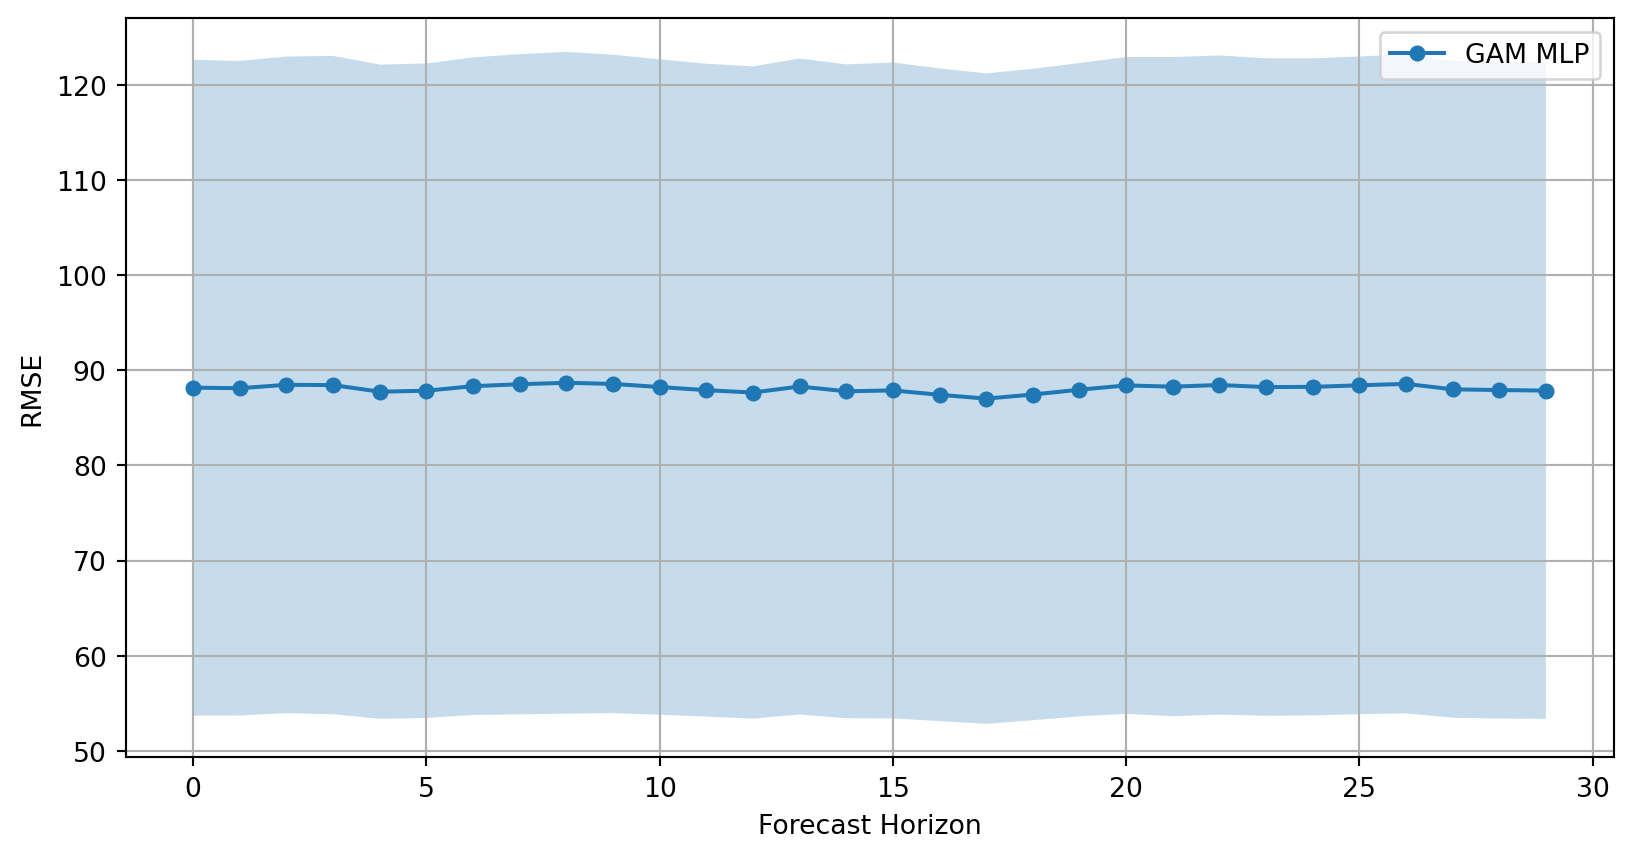

In [48]:
#| code-fold: true
#| code-summary: "Show supplementary code"
y_forecast = np.array(
    np.split(
        relu(sum(components_outsample.values())),      
        int(len(y_outsample) / 30)
    )
)
y_true = np.array(
    np.split(
        y_outsample,      
        int(len(y_outsample) / 30)
    )
)

error_mean, error_sem = compute_rmse(
    y_true=y_true,
    y_forecast=y_forecast,
    axis=0
)
MODELS_RESULTS["GAM - MLP"] = {"error_mean": error_mean, "error_sem": error_sem}

fig, ax = plt.subplots(1, 1, figsize=(10, 5))
ax = visualize_forecast_horizon_accuracy(
    ax=ax,
    model_name="GAM MLP",
    error_name="RMSE",
    error_mean=error_mean,
    error_sem=error_sem,
    marker="o",
    markersize=5
)
plt.legend()
plt.show()

/home/penthotal/mambaforge-pypy3/envs/ghi_forecast_env/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/penthotal/mambaforge-pypy3/envs/ghi_forecast_env/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


/home/penthotal/Desktop/ghi_forecast/modules/diagnostics/visualizers.py:219: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()


/home/penthotal/mambaforge-pypy3/envs/ghi_forecast_env/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


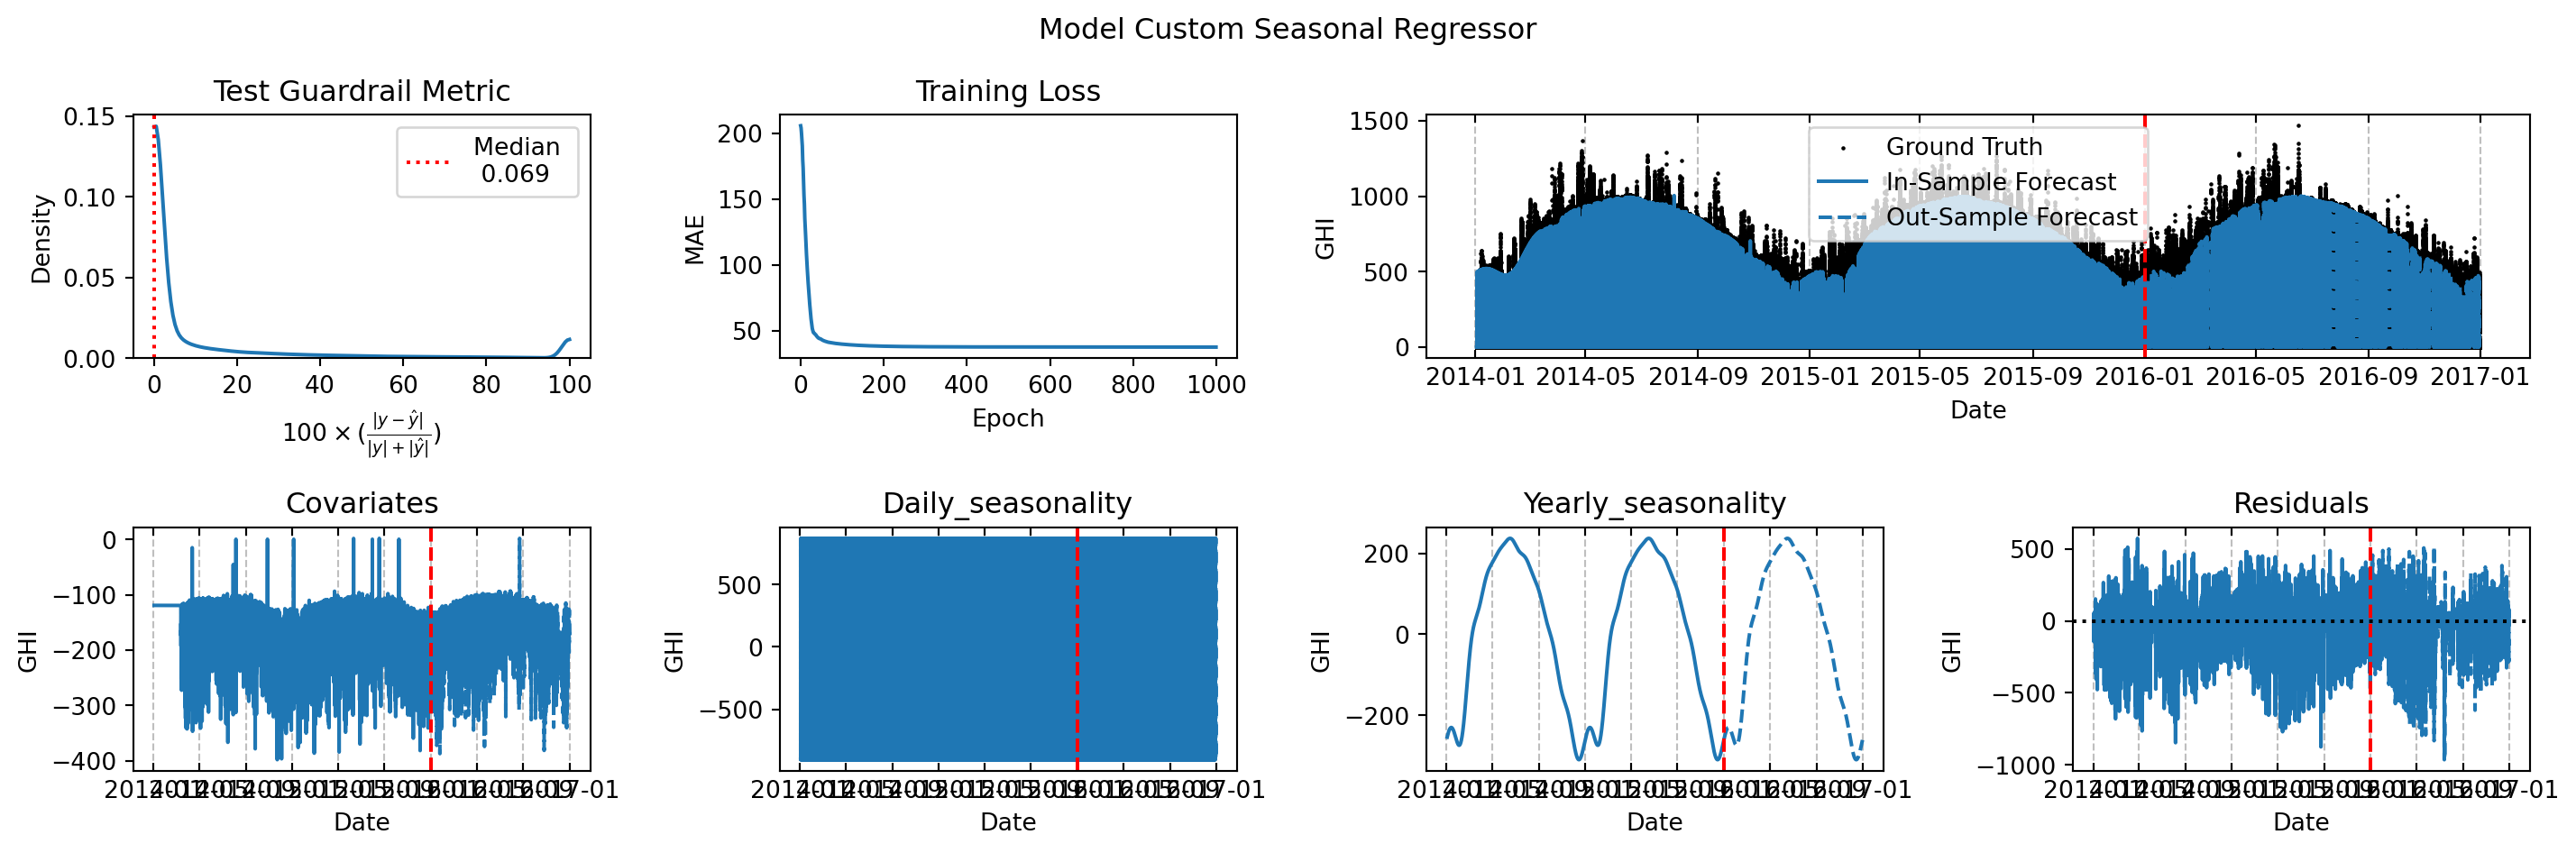

In [49]:
fig = visualize_time_series_components_performance(
    time_series_train=insample_ghi_df["ghi"],
    time_series_test=outsample_ghi_df["ghi"],
    components_insample=components_insample,
    components_outsample=components_outsample,
    link_function=relu,
    target_name="GHI",
    model_name="Custom Seasonal Regressor",
    guardrail_metric=compute_symmetric_absolute_percentage_error,
    loss="MAE",
    history=history,
    figsize=(15, 5),
)
plt.show()

/home/penthotal/mambaforge-pypy3/envs/ghi_forecast_env/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/penthotal/mambaforge-pypy3/envs/ghi_forecast_env/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


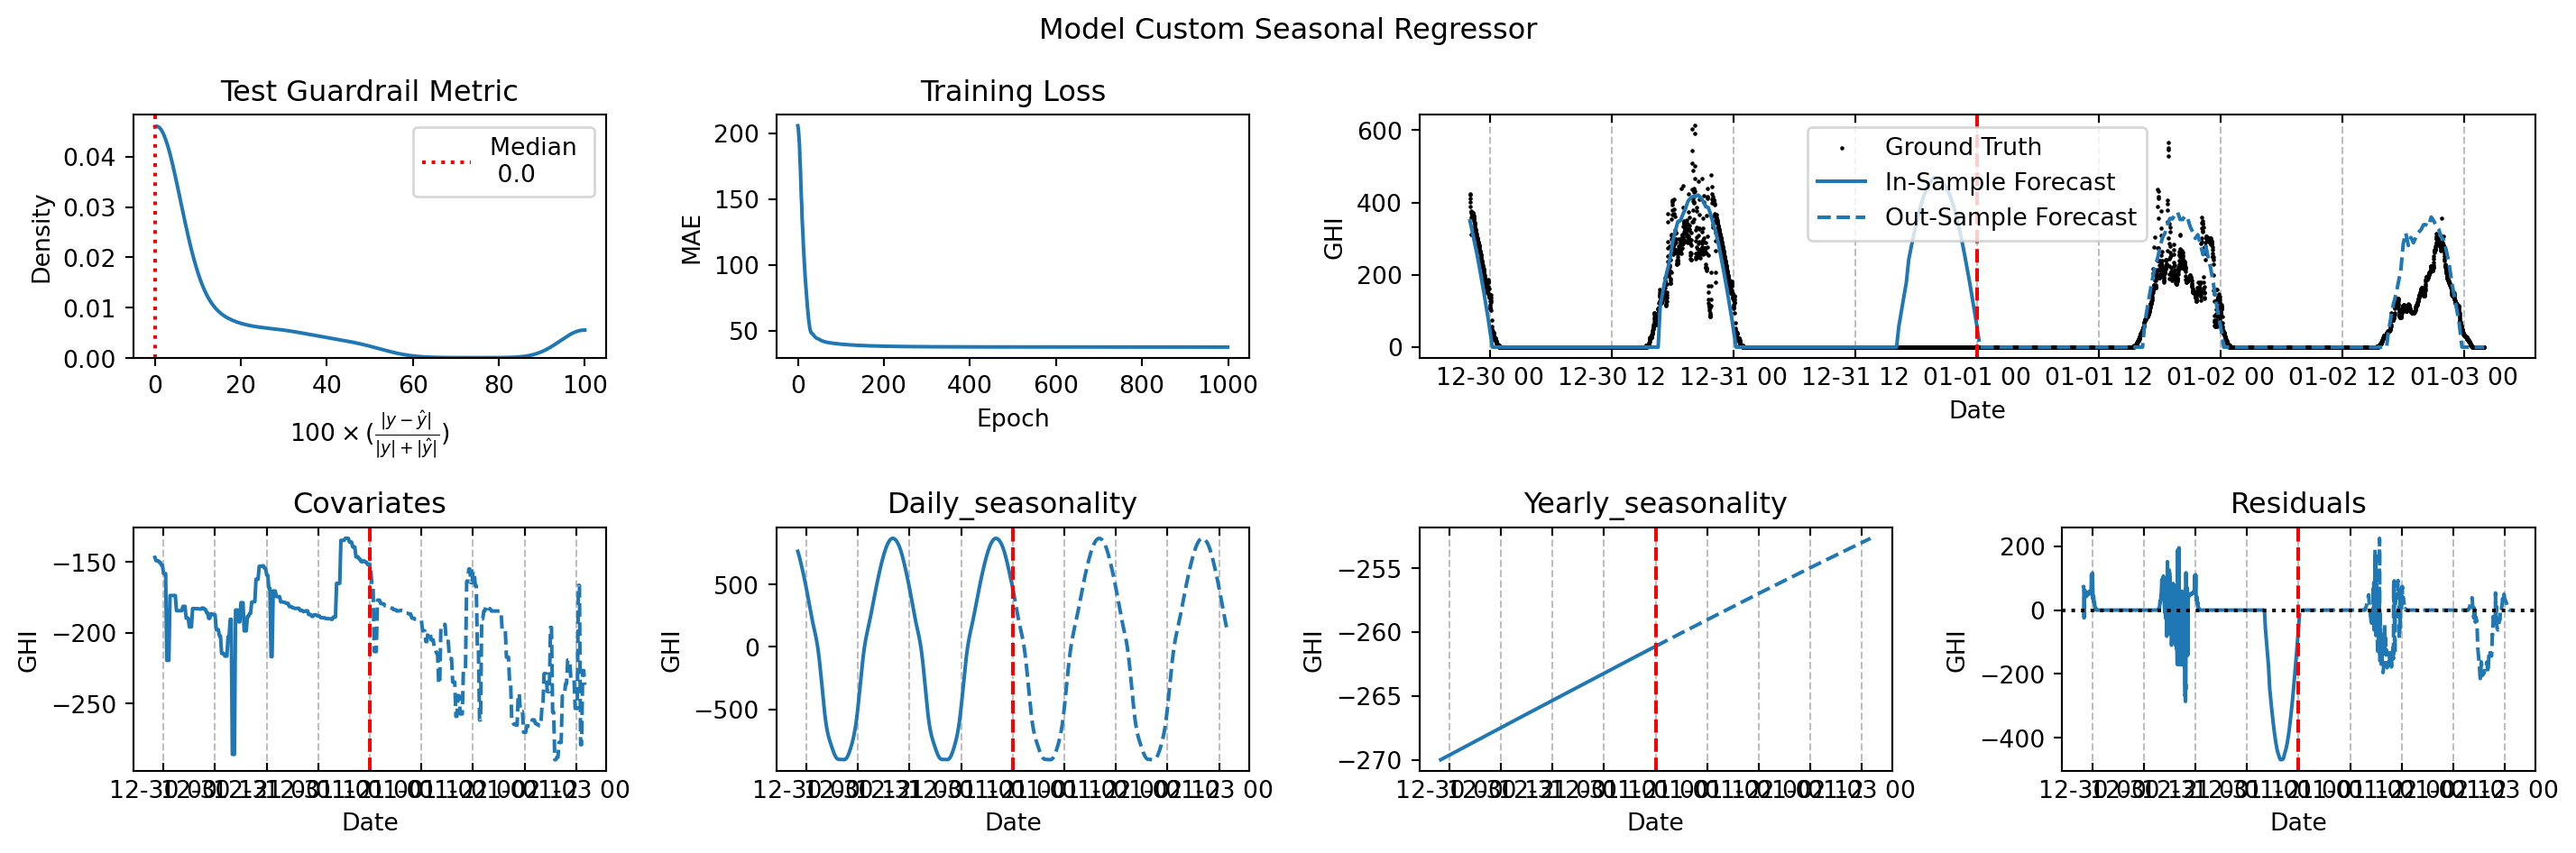

In [50]:
truncated_components_insample = {
    component_name: component_value[-3000:] for component_name, component_value in components_insample.items()
}

truncated_components_outsample = {
    component_name: component_value[:3000] for component_name, component_value in components_outsample.items()
}


fig = visualize_time_series_components_performance(
    time_series_train=insample_ghi_df["ghi"][-3000:],
    time_series_test=outsample_ghi_df["ghi"][:3000],
    components_insample=truncated_components_insample,
    components_outsample=truncated_components_outsample,
    link_function=relu,
    target_name="GHI",
    model_name="Custom Seasonal Regressor",
    guardrail_metric=compute_symmetric_absolute_percentage_error,
    loss="MAE",
    history=history,
    figsize=(15, 5),
)
plt.show()

# Overall Comparison


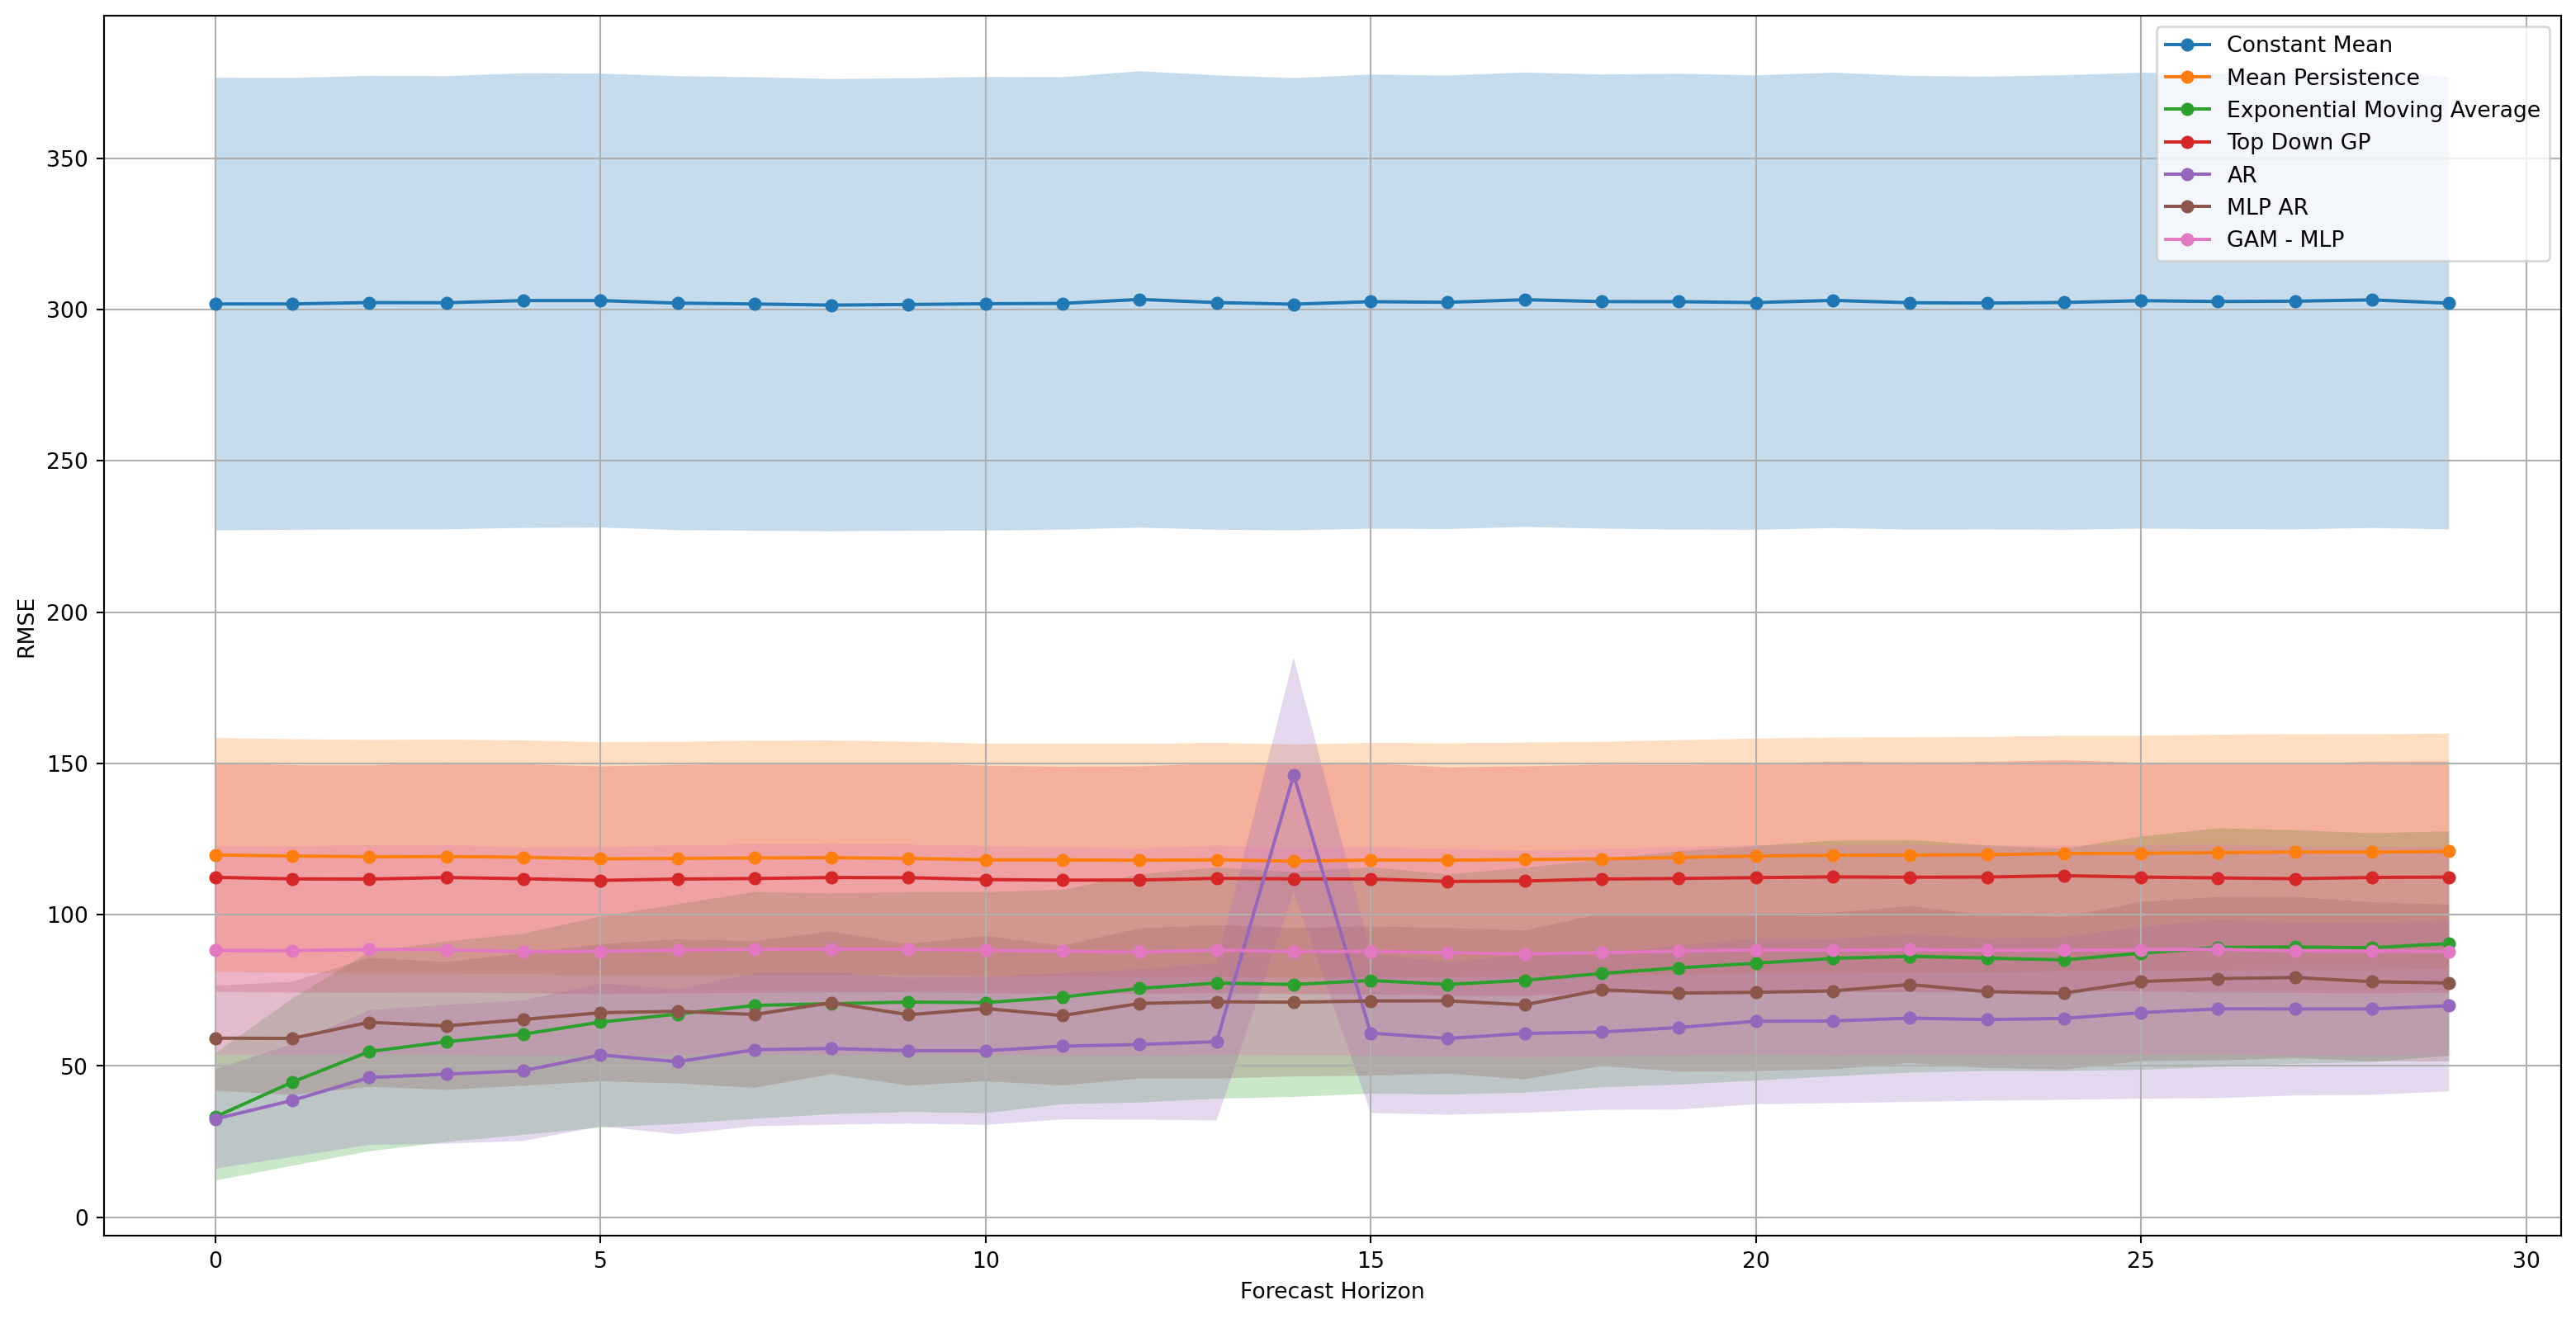

In [51]:
fig, ax = plt.subplots(1, 1, figsize=(20, 10))

for model_name, result in MODELS_RESULTS.items():

    ax = visualize_forecast_horizon_accuracy(
        ax=ax,
        model_name=model_name,
        error_name="RMSE",
        error_mean=result["error_mean"],
        error_sem=result["error_sem"],
        marker="o",
        markersize=5
    )

plt.legend()
plt.show()